In [1]:
!ls ../Data/data_set_phase1/

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import warnings
import time
from collections import Counter
warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

main_path = r'../Data/data_set_phase1/'

# Train data

## Train queries

### EDA

In [3]:
train_queries_df = pd.read_csv(main_path+'train_queries.csv')
# train_queries_df = train_queries_df_copy.copy()

FileNotFoundError: File b'../Data/data_set_phase1/train_queries.csv' does not exist

In [ ]:
train_queries_df.head()

* sid: session ID [会话id]
* pid: profile ID [用户id？]
* req_time: request time [查询请求时间]
* o: original point [出发地坐标]
* d: destination point [目的地坐标]

In [4]:
# check null
train_queries_df.isnull().sum()

NameError: name 'train_queries_df' is not defined

In [5]:
163979/train_queries_df.shape[0]

NameError: name 'train_queries_df' is not defined

In [7]:
train_queries_df.nunique()/train_queries_df.shape[0]

sid         1.000000
pid         0.092382
req_time    0.928422
o           0.010920
d           0.009846
dtype: float64

In [8]:
train_queries_df['o'].value_counts()[:10]

116.37,39.86    5993
116.32,39.89    5930
116.42,39.90    5819
116.41,39.91    5616
116.37,39.91    5246
116.40,39.91    5156
116.39,39.90    4366
116.35,39.94    3674
116.39,39.91    3048
116.41,39.90    3048
Name: o, dtype: int64

In [9]:
train_queries_df['d'].value_counts()[:10]

116.32,39.89    16503
116.37,39.86    13124
116.42,39.90    11256
116.39,39.90     7575
116.39,39.91     7571
116.41,39.91     6348
116.37,39.91     5665
116.45,39.93     5357
116.27,40.00     4222
116.40,39.93     3782
Name: d, dtype: int64

### 小结
* pid缺失严重
    * 讨论如何填补这个缺失值
* sid为唯一值
* 同一个出发地坐标或者目的坐标出现的次数多
* 后期特征工程中需要看看req_time的时间分布情况，如：早晚高峰，节假日或者周末，周五等等。
    * 处理方案是将时间戳划分出星期（标签型 or One-hot？）、小时（标签型 or One-hot？）、是否节假日（binary）等特征
* 数据来自北京市用户出行的用户行为，因此在特征工程的时候是否需要考虑出发或者目的坐标的真实地理位置（市中心、商业集中地、景点等等），以此来加入堵车、人流量过高的真实现象。

## Train plans

### EDA

In [10]:
train_plans_df = pd.read_csv(main_path+'train_plans.csv')
# train_plans_df = train_plans_df_copy.copy()

In [11]:
train_plans_df.head()

sid            plan_time  \
0  1709112  2018-11-04 11:45:04   
1  3327773  2018-10-16 19:09:29   
2  3285959  2018-11-25 15:05:22   
3  1616170  2018-10-03 14:42:40   
4   351369  2018-10-05 19:52:37   

                                               plans  
0  [{"distance": 32303, "price": 600, "eta": 5087...  
1  [{"distance": 3427, "price": 300, "eta": 627, ...  
2  [{"distance": 36234, "price": 1100, "eta": 931...  
3  [{"distance": 11450, "price": 400, "eta": 2801...  
4  [{"distance": 18495, "price": 600, "eta": 4271...

* sid: session ID [会话id]
* plan_time: timestamp [计划生成的时间？or 预计出行的具体时间？]
* plans: list of route plans [计划列表]
    * distance: the estimated route distance in meters [估计出行距离（米）]
    * price: the estimated price in RMB cent [估计价格（人民币）]
    * eta: the estimated time of arrival (ETA) in seconds [估计出行时间（秒）]
    * mode: the transport mode [出行方式]

In [12]:
train_plans_df.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [13]:
train_plans_df.nunique()/train_plans_df.shape[0]

sid          1.000000
plan_time    0.927448
plans        0.996964
dtype: float64

### 小结
* 数据无缺失
* 数据重复数量也不高
* 需要根据sid结合quries表继续探索req_time和plan_time的关系
* 时间处理过程中是否加入出行过程中的时间跨度，比如下午16点出行不是晚高峰，但是结合ETA（估计出行时间的特征），可能会在途中遇到晚高峰的情况
    * 解决方案可以在plan_time这个特征上加上ETA，计算出到达目的地的具体时间，再做特征工程。前提是弄清楚req_time和plan_time之间的关系
* plans得再unstack成新的表，统计每个会话里面的最大（最小、平均）价格、最长（最小、平均）出行时间、出行方式出现次数等等，具体得讨论。

## Train clicks
这个应该是label

In [14]:
train_clicks_df = pd.read_csv(main_path+'train_clicks.csv')
# train_clicks_df = train_clicks_df_copy.copy()

### EDA

In [15]:
train_clicks_df.head()

sid           click_time  click_mode
0  2848914  2018-11-17 18:42:17           1
1  2629085  2018-10-12 16:28:13           3
2   602598  2018-11-11 16:38:42           2
3  2022975  2018-10-14 12:28:11           9
4   988425  2018-11-12 16:47:30           7

**A click record indicates the user feedback of different recommendations. i.e., a user may click on specific routes displayed to him/her for details.**
* sid: session ID [会话时间]
* click_time: a timestamp [点击时间戳]
* click_mode: the clicked transport mode in the display list [用户选择的出行方式]

In [16]:
train_clicks_df.isnull().sum()

sid           0
click_time    0
click_mode    0
dtype: int64

In [17]:
train_clicks_df.nunique()/train_clicks_df.shape[0]

sid           1.000000
click_time    0.931097
click_mode    0.000024
dtype: float64

In [18]:
mode_df = pd.DataFrame(train_clicks_df.click_mode.value_counts())
mode_df['mode'] = mode_df.index
mode_df.columns = ['Frequency', 'Mode']
mode_df

Frequency  Mode
2      136491     2
7       78209     7
1       70369     1
9       48864     9
5       47480     5
3       24626     3
10      14882    10
4       12606     4
6       11863     6
11       6089    11
8        1857     8

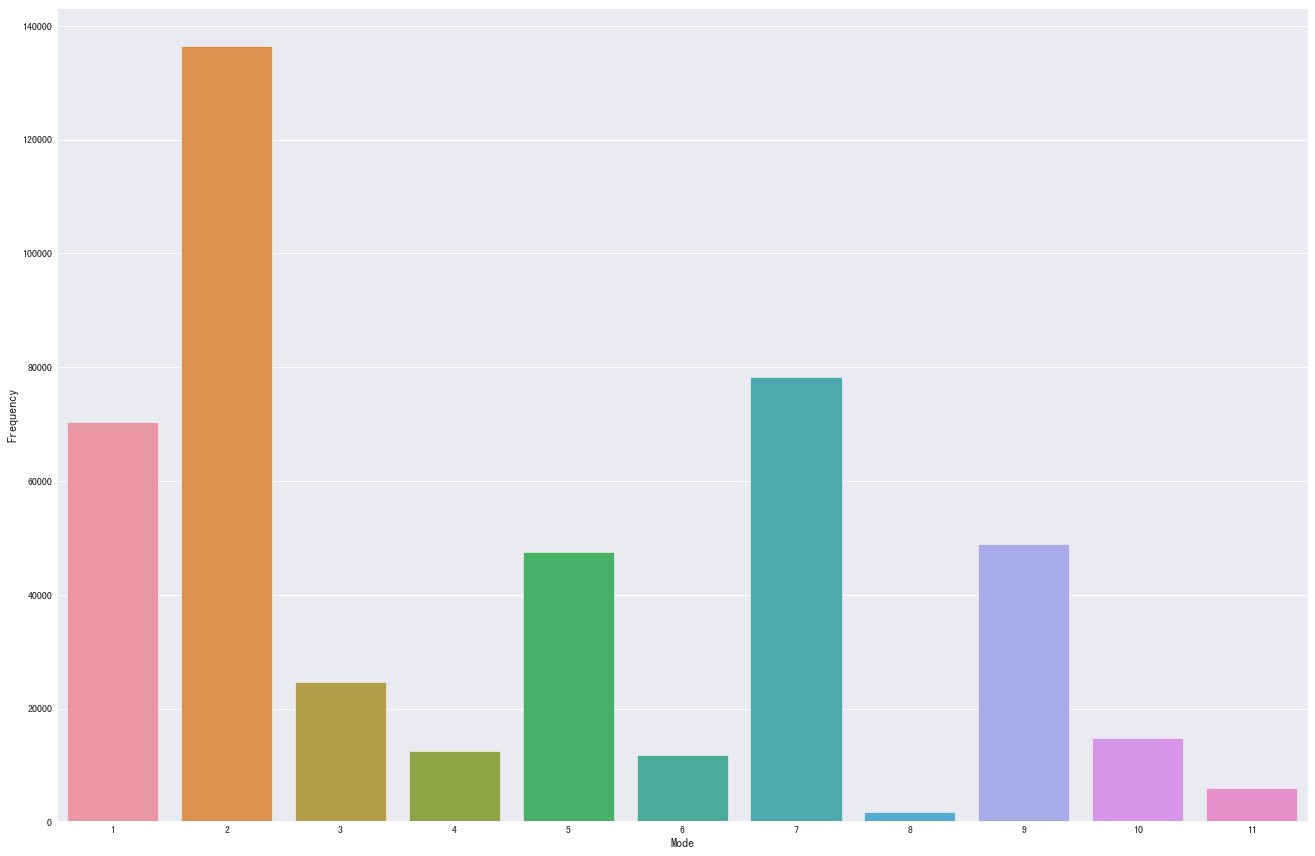

In [19]:
train_clicks_df.click_mode.value_counts()
f, ax = plt.subplots(figsize=(20, 15))
g = sns.barplot(x='Mode', y='Frequency', data=mode_df, ax=ax)

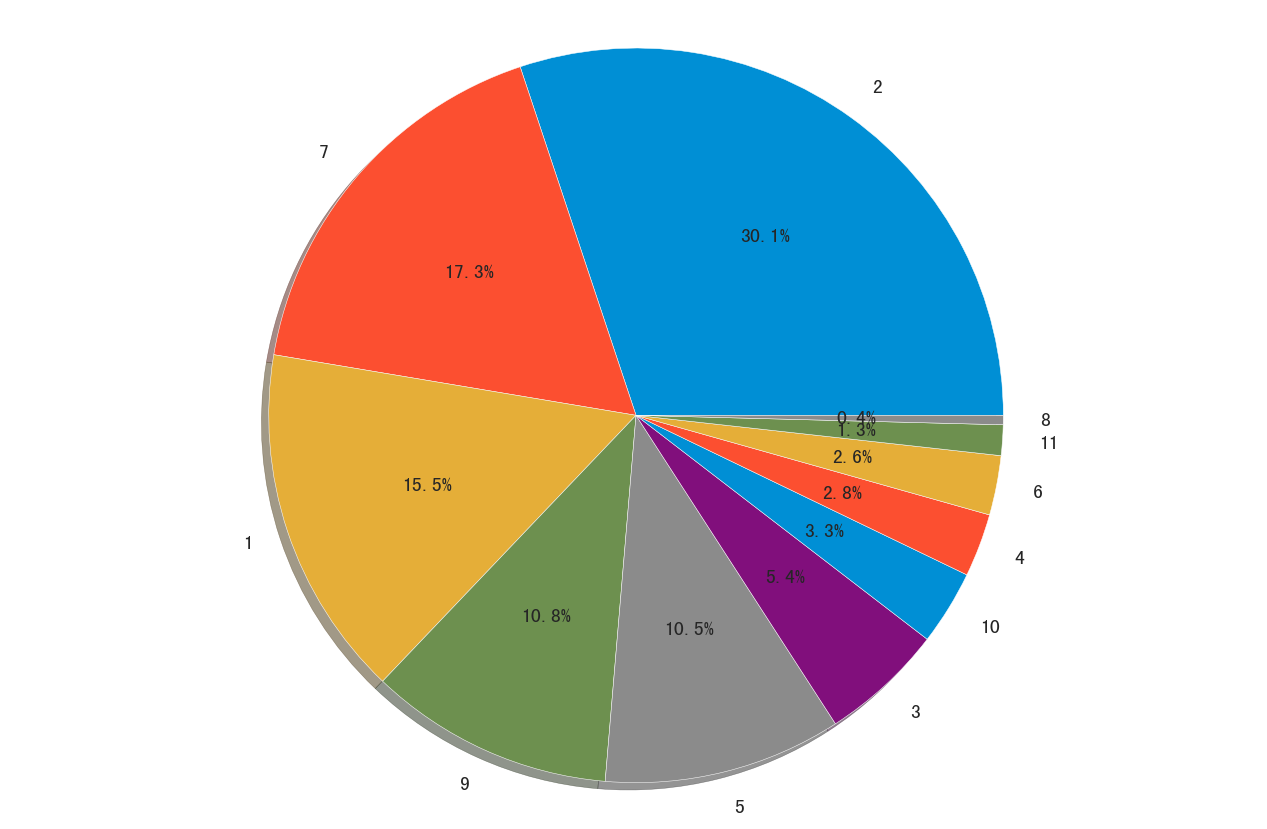

In [20]:
# Pie chart if labels
mpl.rcParams['font.size'] = 20
f1, ax1 = plt.subplots(figsize=(20, 15))
ax1.pie(mode_df['Frequency'].values,
        labels=mode_df['Mode'].values, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

### 小结
* label不平衡
    * 后面得想办法处理（加权采样、组合label、模型加权输出等等）

# Test Data

In [21]:
print('train qureies shape:', train_queries_df.shape)
print('train plans shape:', train_plans_df.shape)
print('train clicks shape:', train_clicks_df.shape)

train qureies shape: (500000, 5)
train plans shape: (491054, 3)
train clicks shape: (453336, 3)


* 并不是所有的queries都会有对应的plans

# Test data

## Test queries

In [22]:
test_queries_df = pd.read_csv(main_path+'test_queries.csv')

In [23]:
test_queries_df.head()

sid       pid             req_time             o             d
0  1126541  178395.0  2018-12-05 14:51:43  116.41,39.92  116.46,39.95
1   453685  179178.0  2018-12-01 12:50:33  116.39,39.90  116.41,39.91
2  2066073  184748.0  2018-12-07 10:17:35  116.37,39.71  116.31,39.89
3   452746  162795.0  2018-12-01 07:52:44  116.33,39.97  116.31,39.98
4  1431672  116384.0  2018-12-06 10:36:30  116.51,39.68  116.51,39.68

In [24]:
# check null
test_queries_df.isnull().sum()

sid             0
pid         31447
req_time        0
o               0
d               0
dtype: int64

In [25]:
print('缺失占比：',31447/test_queries_df.shape[0])

缺失占比： 0.3332732783653744


In [26]:
test_queries_df.nunique()/test_queries_df.shape[0]

sid         1.000000
pid         0.140942
req_time    0.891880
o           0.034517
d           0.030564
dtype: float64

### 小结
* 和train_queries情况基本一致

## test plan

In [27]:
test_plans_df = pd.read_csv(main_path+'test_plans.csv')

In [28]:
test_plans_df.head()

sid            plan_time  \
0  1112456  2018-12-05 17:39:47   
1  1413458  2018-12-06 17:49:17   
2  1243160  2018-12-02 14:50:25   
3  2040494  2018-12-07 09:23:45   
4  1448779  2018-12-06 18:24:46   

                                               plans  
0  [{"distance": 465, "price": "", "eta": 418, "t...  
1  [{"distance": 28846, "price": 600, "eta": 4779...  
2  [{"distance": 24646, "price": 600, "eta": 3513...  
3  [{"distance": 32235, "price": 600, "eta": 4072...  
4  [{"distance": 13502, "price": 400, "eta": 3195...

In [29]:
test_plans_df.isnull().sum()

sid          0
plan_time    0
plans        0
dtype: int64

In [30]:
test_plans_df.nunique()/test_plans_df.shape[0]

sid          1.000000
plan_time    0.890473
plans        0.995593
dtype: float64

### 小结
* 同train_plans

# profiles

In [31]:
profiles_df = pd.read_csv(main_path+'profiles.csv')

In [32]:
profiles_df.head()

pid   p0   p1   p2   p3   p4   p5   p6   p7   p8  ...  p56  p57  p58  \
0  196356  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
1  204083  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
2  170667  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
3  115511  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
4  129719  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   

   p59  p60  p61  p62  p63  p64  p65  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 67 columns]

In [33]:
profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63090 entries, 0 to 63089
Data columns (total 67 columns):
pid    63090 non-null int64
p0     63090 non-null float64
p1     63090 non-null float64
p2     63090 non-null float64
p3     63090 non-null float64
p4     63090 non-null float64
p5     63090 non-null float64
p6     63090 non-null float64
p7     63090 non-null float64
p8     63090 non-null float64
p9     63090 non-null float64
p10    63090 non-null float64
p11    63090 non-null float64
p12    63090 non-null float64
p13    63090 non-null float64
p14    63090 non-null float64
p15    63090 non-null float64
p16    63090 non-null float64
p17    63090 non-null float64
p18    63090 non-null float64
p19    63090 non-null float64
p20    63090 non-null float64
p21    63090 non-null float64
p22    63090 non-null float64
p23    63090 non-null float64
p24    63090 non-null float64
p25    63090 non-null float64
p26    63090 non-null float64
p27    63090 non-null float64
p28    63090 non-null f

* 不存在缺失的情况
* pid的是唯一的;
* p0-p65都是二元的;

In [34]:
print('test qureies shape:', test_queries_df.shape)
print('test plans shape:', test_plans_df.shape)
print('profiles shape:', profiles_df.shape)

test qureies shape: (94358, 5)
test plans shape: (92571, 3)
profiles shape: (63090, 67)


* test_plans和test_queries数据不对等，和train数据情况一致

In [39]:
train_queries_df['pid'].value_counts().head()

167770.0    6094
112198.0    4856
116844.0    3187
203487.0    2818
186452.0    2465
Name: pid, dtype: int64

In [40]:
test_queries_df['pid'].value_counts().head()

167770.0    1635
112198.0    1308
203487.0     714
116844.0     676
202427.0     664
Name: pid, dtype: int64

In [42]:
profiles_df.shape

(63090, 67)

# 其他

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
path = 'E:/Machine-learning/kdd_cup_2019/data/'
data=pd.read_csv(path + '/feature_692434.csv', parse_dates=['req_time','plan_time','click_time'])

In [3]:
#使用高级  numpy方法进行转化率的构建


data_a=data[data.req_time < '2018-11-23']
data_a=data_a[['sid','pid','click_mode']]
data_b=data[['sid','pid','click_mode']]
def  run_get_pid_mode_count_feature(data_a,data_b):
    features=[]

    for i, row in tqdm(data_b.iterrows()):
        #print(i)
        #抽取除当前行的所有行
        the_other_data_row=data_a[data_a['sid']!=row['sid']]
        feature={}
        use_get_CVR_plans_rows=the_other_data_row[the_other_data_row['pid']==row['pid']]
        
        pid_mode_0_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==0)])
        pid_mode_1_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==1)])
        pid_mode_2_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==2)])    
        pid_mode_3_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==3)]) 
        pid_mode_4_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==4)]) 
        pid_mode_5_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==5)]) 
        pid_mode_6_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==6)]) 
        pid_mode_7_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==7)]) 
        pid_mode_8_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==8)]) 
        pid_mode_9_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==9)]) 
        pid_mode_10_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==10)]) 
        pid_mode_11_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==11)])        
        feature['pid_mode_0_count']=pid_mode_0_count
        feature['pid_mode_1_count']=pid_mode_1_count
        feature['pid_mode_2_count']=pid_mode_2_count
        feature['pid_mode_3_count']=pid_mode_3_count
        feature['pid_mode_4_count']=pid_mode_4_count
        feature['pid_mode_5_count']=pid_mode_5_count
        feature['pid_mode_6_count']=pid_mode_6_count
        feature['pid_mode_7_count']=pid_mode_7_count
        feature['pid_mode_8_count']=pid_mode_8_count
        feature['pid_mode_9_count']=pid_mode_9_count
        feature['pid_mode_10_count']=pid_mode_10_count
        feature['pid_mode_11_count']=pid_mode_11_count
        
        features.append(feature)
    features=pd.DataFrame(features)
    return features

pid_mode_count_feature=run_get_pid_mode_count_feature(data_a,data_b)
pid_mode_count_feature.to_csv(path + '/feature_data/pid_mode_count_feature1.csv',index=False)


0it [00:00, ?it/s]
3it [00:00, 29.33it/s]
7it [00:00, 30.34it/s]
11it [00:00, 31.67it/s]
14it [00:00, 30.93it/s]
18it [00:00, 32.84it/s]
22it [00:00, 32.76it/s]
26it [00:00, 32.54it/s]
30it [00:00, 32.08it/s]
34it [00:01, 32.30it/s]
38it [00:01, 33.52it/s]
42it [00:01, 35.21it/s]
46it [00:01, 35.66it/s]
50it [00:01, 36.28it/s]
54it [00:01, 37.09it/s]
58it [00:01, 37.25it/s]
62it [00:01, 37.26it/s]
66it [00:01, 37.37it/s]
70it [00:02, 36.73it/s]
74it [00:02, 32.44it/s]
78it [00:02, 32.40it/s]
83it [00:02, 34.33it/s]
87it [00:02, 35.45it/s]
91it [00:02, 35.98it/s]
95it [00:02, 36.71it/s]
99it [00:02, 37.29it/s]
103it [00:02, 36.47it/s]
107it [00:03, 34.43it/s]
111it [00:03, 32.40it/s]
115it [00:03, 32.61it/s]
119it [00:03, 32.76it/s]
123it [00:03, 34.12it/s]
127it [00:03, 34.34it/s]
131it [00:03, 35.14it/s]
135it [00:03, 34.83it/s]
139it [00:04, 35.43it/s]
143it [00:04, 34.93it/s]
147it [00:04, 33.04it/s]
151it [00:04, 32.06it/s]
155it [00:04, 32.77it/s]
159it [00:04, 34.00it/s]
163it [

1995it [01:15, 25.60it/s]
1998it [01:15, 25.79it/s]
2001it [01:15, 26.33it/s]
2004it [01:15, 26.34it/s]
2007it [01:15, 26.42it/s]
2010it [01:15, 26.33it/s]
2013it [01:15, 26.44it/s]
2016it [01:15, 26.18it/s]
2019it [01:16, 26.27it/s]
2022it [01:16, 26.97it/s]
2025it [01:16, 27.34it/s]
2028it [01:16, 26.85it/s]
2031it [01:16, 26.88it/s]
2034it [01:16, 26.91it/s]
2037it [01:16, 26.28it/s]
2040it [01:16, 25.83it/s]
2043it [01:17, 25.82it/s]
2046it [01:17, 25.35it/s]
2049it [01:17, 25.10it/s]
2052it [01:17, 25.83it/s]
2055it [01:17, 25.88it/s]
2058it [01:17, 26.02it/s]
2061it [01:17, 26.30it/s]
2064it [01:17, 26.21it/s]
2067it [01:17, 25.98it/s]
2070it [01:18, 26.10it/s]
2073it [01:18, 24.84it/s]
2076it [01:18, 25.77it/s]
2079it [01:18, 25.84it/s]
2082it [01:18, 26.30it/s]
2085it [01:18, 26.71it/s]
2088it [01:18, 27.22it/s]
2091it [01:18, 27.18it/s]
2094it [01:18, 26.82it/s]
2097it [01:19, 26.22it/s]
2100it [01:19, 25.72it/s]
2103it [01:19, 25.91it/s]
2106it [01:19, 26.60it/s]
2109it [01:1

3885it [02:28, 26.28it/s]
3888it [02:28, 26.10it/s]
3891it [02:28, 25.64it/s]
3894it [02:28, 25.39it/s]
3897it [02:28, 25.74it/s]
3900it [02:28, 25.76it/s]
3903it [02:29, 26.07it/s]
3906it [02:29, 25.52it/s]
3909it [02:29, 25.70it/s]
3912it [02:29, 25.76it/s]
3915it [02:29, 25.77it/s]
3918it [02:29, 24.66it/s]
3921it [02:29, 25.47it/s]
3924it [02:29, 25.70it/s]
3927it [02:29, 24.89it/s]
3930it [02:30, 25.19it/s]
3933it [02:30, 25.02it/s]
3936it [02:30, 25.37it/s]
3939it [02:30, 24.83it/s]
3942it [02:30, 25.18it/s]
3945it [02:30, 25.45it/s]
3948it [02:30, 26.02it/s]
3951it [02:30, 25.95it/s]
3954it [02:31, 26.67it/s]
3957it [02:31, 26.29it/s]
3960it [02:31, 26.01it/s]
3963it [02:31, 25.84it/s]
3966it [02:31, 25.37it/s]
3969it [02:31, 25.66it/s]
3972it [02:31, 25.02it/s]
3975it [02:31, 25.47it/s]
3978it [02:31, 25.83it/s]
3981it [02:32, 25.75it/s]
3984it [02:32, 26.10it/s]
3987it [02:32, 26.18it/s]
3990it [02:32, 26.83it/s]
3993it [02:32, 26.58it/s]
3996it [02:32, 25.43it/s]
3999it [02:3

5775it [03:41, 24.55it/s]
5778it [03:41, 25.45it/s]
5781it [03:41, 25.46it/s]
5784it [03:41, 26.02it/s]
5787it [03:41, 25.52it/s]
5790it [03:41, 25.90it/s]
5793it [03:42, 25.34it/s]
5796it [03:42, 26.09it/s]
5799it [03:42, 25.90it/s]
5802it [03:42, 25.57it/s]
5805it [03:42, 25.83it/s]
5808it [03:42, 26.02it/s]
5811it [03:42, 25.92it/s]
5814it [03:42, 24.19it/s]
5817it [03:43, 24.50it/s]
5820it [03:43, 25.61it/s]
5823it [03:43, 25.83it/s]
5826it [03:43, 26.12it/s]
5829it [03:43, 25.99it/s]
5832it [03:43, 26.45it/s]
5835it [03:43, 26.25it/s]
5838it [03:43, 26.42it/s]
5841it [03:43, 26.65it/s]
5844it [03:44, 26.32it/s]
5847it [03:44, 26.16it/s]
5850it [03:44, 25.74it/s]
5853it [03:44, 25.86it/s]
5856it [03:44, 25.84it/s]
5859it [03:44, 25.93it/s]
5862it [03:44, 24.95it/s]
5865it [03:44, 24.54it/s]
5868it [03:45, 25.38it/s]
5871it [03:45, 25.15it/s]
5874it [03:45, 25.80it/s]
5877it [03:45, 24.65it/s]
5880it [03:45, 25.36it/s]
5883it [03:45, 25.89it/s]
5886it [03:45, 26.27it/s]
5889it [03:4

7666it [04:54, 25.71it/s]
7669it [04:54, 26.21it/s]
7672it [04:54, 26.36it/s]
7675it [04:54, 26.71it/s]
7678it [04:54, 26.89it/s]
7681it [04:54, 25.34it/s]
7684it [04:54, 25.41it/s]
7687it [04:55, 25.33it/s]
7690it [04:55, 23.97it/s]
7693it [04:55, 24.52it/s]
7696it [04:55, 25.33it/s]
7699it [04:55, 25.86it/s]
7702it [04:55, 25.94it/s]
7705it [04:55, 26.69it/s]
7708it [04:55, 26.38it/s]
7711it [04:55, 25.50it/s]
7714it [04:56, 25.99it/s]
7717it [04:56, 25.63it/s]
7720it [04:56, 26.22it/s]
7723it [04:56, 26.16it/s]
7726it [04:56, 26.53it/s]
7729it [04:56, 26.31it/s]
7732it [04:56, 26.57it/s]
7735it [04:56, 24.58it/s]
7738it [04:57, 24.53it/s]
7741it [04:57, 23.49it/s]
7744it [04:57, 24.14it/s]
7747it [04:57, 24.25it/s]
7750it [04:57, 25.16it/s]
7753it [04:57, 25.84it/s]
7756it [04:57, 26.37it/s]
7759it [04:57, 26.90it/s]
7762it [04:57, 27.25it/s]
7765it [04:58, 26.87it/s]
7768it [04:58, 25.58it/s]
7771it [04:58, 25.81it/s]
7774it [04:58, 25.97it/s]
7777it [04:58, 25.72it/s]
7780it [04:5

9556it [06:07, 24.24it/s]
9559it [06:07, 24.94it/s]
9562it [06:07, 24.27it/s]
9565it [06:07, 23.93it/s]
9568it [06:07, 24.83it/s]
9571it [06:07, 25.50it/s]
9574it [06:08, 25.29it/s]
9577it [06:08, 25.84it/s]
9580it [06:08, 26.16it/s]
9583it [06:08, 25.88it/s]
9586it [06:08, 26.16it/s]
9589it [06:08, 25.23it/s]
9592it [06:08, 25.14it/s]
9595it [06:08, 25.92it/s]
9598it [06:09, 25.95it/s]
9601it [06:09, 25.41it/s]
9604it [06:09, 25.69it/s]
9607it [06:09, 25.85it/s]
9610it [06:09, 25.09it/s]
9613it [06:09, 25.99it/s]
9616it [06:09, 26.41it/s]
9619it [06:09, 26.29it/s]
9622it [06:09, 25.80it/s]
9625it [06:10, 26.10it/s]
9628it [06:10, 26.42it/s]
9631it [06:10, 26.06it/s]
9634it [06:10, 26.15it/s]
9637it [06:10, 26.14it/s]
9640it [06:10, 26.52it/s]
9643it [06:10, 26.83it/s]
9646it [06:10, 26.55it/s]
9649it [06:11, 24.66it/s]
9652it [06:11, 25.08it/s]
9655it [06:11, 25.42it/s]
9658it [06:11, 25.34it/s]
9661it [06:11, 26.31it/s]
9664it [06:11, 26.75it/s]
9667it [06:11, 26.42it/s]
9670it [06:1

11390it [07:17, 26.56it/s]
11393it [07:17, 27.34it/s]
11396it [07:17, 25.61it/s]
11399it [07:18, 24.59it/s]
11402it [07:18, 25.19it/s]
11405it [07:18, 24.99it/s]
11408it [07:18, 25.48it/s]
11411it [07:18, 23.58it/s]
11414it [07:18, 24.65it/s]
11417it [07:18, 25.24it/s]
11420it [07:18, 25.50it/s]
11423it [07:19, 26.40it/s]
11426it [07:19, 26.15it/s]
11429it [07:19, 25.54it/s]
11432it [07:19, 25.85it/s]
11435it [07:19, 26.07it/s]
11438it [07:19, 26.55it/s]
11441it [07:19, 27.00it/s]
11444it [07:19, 26.41it/s]
11447it [07:19, 26.54it/s]
11450it [07:20, 26.73it/s]
11453it [07:20, 26.41it/s]
11456it [07:20, 26.26it/s]
11459it [07:20, 25.88it/s]
11462it [07:20, 26.23it/s]
11465it [07:20, 25.14it/s]
11468it [07:20, 25.53it/s]
11471it [07:20, 26.28it/s]
11474it [07:21, 26.38it/s]
11477it [07:21, 26.41it/s]
11480it [07:21, 26.15it/s]
11483it [07:21, 25.44it/s]
11486it [07:21, 25.26it/s]
11489it [07:21, 25.45it/s]
11492it [07:21, 25.75it/s]
11495it [07:21, 25.53it/s]
11498it [07:21, 26.21it/s]
1

13208it [08:28, 26.93it/s]
13211it [08:28, 26.65it/s]
13214it [08:28, 27.10it/s]
13217it [08:28, 26.99it/s]
13220it [08:28, 26.83it/s]
13223it [08:28, 26.48it/s]
13226it [08:28, 26.69it/s]
13229it [08:28, 26.99it/s]
13232it [08:29, 27.09it/s]
13235it [08:29, 25.43it/s]
13238it [08:29, 25.77it/s]
13241it [08:29, 26.42it/s]
13244it [08:29, 26.37it/s]
13247it [08:29, 26.58it/s]
13250it [08:29, 26.87it/s]
13253it [08:29, 26.68it/s]
13256it [08:29, 26.13it/s]
13259it [08:30, 26.34it/s]
13262it [08:30, 26.24it/s]
13265it [08:30, 26.56it/s]
13268it [08:30, 26.22it/s]
13271it [08:30, 26.40it/s]
13274it [08:30, 26.64it/s]
13277it [08:30, 26.55it/s]
13280it [08:30, 27.22it/s]
13283it [08:30, 25.67it/s]
13286it [08:31, 26.18it/s]
13289it [08:31, 25.37it/s]
13292it [08:31, 25.69it/s]
13295it [08:31, 26.06it/s]
13298it [08:31, 26.60it/s]
13301it [08:31, 25.00it/s]
13304it [08:31, 25.33it/s]
13307it [08:31, 25.66it/s]
13310it [08:32, 26.04it/s]
13313it [08:32, 26.07it/s]
13316it [08:32, 26.02it/s]
1

15027it [09:38, 26.84it/s]
15030it [09:38, 24.99it/s]
15033it [09:38, 24.54it/s]
15036it [09:38, 24.01it/s]
15039it [09:38, 24.98it/s]
15042it [09:38, 25.77it/s]
15045it [09:38, 26.22it/s]
15048it [09:39, 26.29it/s]
15051it [09:39, 26.28it/s]
15054it [09:39, 24.86it/s]
15057it [09:39, 25.33it/s]
15060it [09:39, 25.11it/s]
15063it [09:39, 25.97it/s]
15066it [09:39, 26.79it/s]
15069it [09:39, 26.41it/s]
15072it [09:39, 27.00it/s]
15075it [09:40, 27.32it/s]
15078it [09:40, 27.10it/s]
15081it [09:40, 27.20it/s]
15084it [09:40, 27.17it/s]
15087it [09:40, 27.40it/s]
15090it [09:40, 26.93it/s]
15093it [09:40, 27.38it/s]
15096it [09:40, 27.48it/s]
15099it [09:40, 27.28it/s]
15102it [09:41, 27.52it/s]
15105it [09:41, 26.91it/s]
15108it [09:41, 27.25it/s]
15111it [09:41, 27.61it/s]
15114it [09:41, 28.03it/s]
15117it [09:41, 27.81it/s]
15120it [09:41, 27.59it/s]
15123it [09:41, 26.81it/s]
15126it [09:41, 26.04it/s]
15129it [09:42, 26.31it/s]
15132it [09:42, 25.72it/s]
15135it [09:42, 26.18it/s]
1

16907it [10:48, 27.37it/s]
16911it [10:48, 28.56it/s]
16915it [10:48, 28.69it/s]
16918it [10:48, 28.23it/s]
16922it [10:48, 29.73it/s]
16926it [10:49, 30.49it/s]
16930it [10:49, 28.37it/s]
16933it [10:49, 28.33it/s]
16936it [10:49, 28.06it/s]
16939it [10:49, 27.72it/s]
16942it [10:49, 26.71it/s]
16945it [10:49, 26.71it/s]
16948it [10:49, 26.80it/s]
16951it [10:50, 27.10it/s]
16954it [10:50, 27.09it/s]
16957it [10:50, 27.09it/s]
16960it [10:50, 26.97it/s]
16963it [10:50, 27.41it/s]
16966it [10:50, 27.61it/s]
16969it [10:50, 26.50it/s]
16972it [10:50, 26.39it/s]
16975it [10:50, 26.70it/s]
16978it [10:51, 24.93it/s]
16981it [10:51, 25.74it/s]
16984it [10:51, 26.06it/s]
16987it [10:51, 26.74it/s]
16990it [10:51, 26.88it/s]
16993it [10:51, 26.33it/s]
16996it [10:51, 26.55it/s]
16999it [10:51, 25.61it/s]
17002it [10:51, 26.17it/s]
17005it [10:52, 26.37it/s]
17008it [10:52, 26.12it/s]
17011it [10:52, 26.16it/s]
17014it [10:52, 26.74it/s]
17017it [10:52, 26.66it/s]
17020it [10:52, 26.93it/s]
1

18731it [11:57, 26.66it/s]
18734it [11:57, 26.61it/s]
18737it [11:57, 26.68it/s]
18740it [11:58, 26.90it/s]
18743it [11:58, 26.42it/s]
18746it [11:58, 26.83it/s]
18749it [11:58, 26.98it/s]
18752it [11:58, 26.82it/s]
18755it [11:58, 26.61it/s]
18758it [11:58, 26.09it/s]
18761it [11:58, 25.73it/s]
18764it [11:58, 25.39it/s]
18767it [11:59, 25.74it/s]
18770it [11:59, 26.37it/s]
18773it [11:59, 26.16it/s]
18776it [11:59, 26.05it/s]
18779it [11:59, 26.14it/s]
18782it [11:59, 26.35it/s]
18785it [11:59, 26.63it/s]
18788it [11:59, 26.84it/s]
18791it [11:59, 26.03it/s]
18794it [12:00, 25.76it/s]
18797it [12:00, 25.97it/s]
18800it [12:00, 26.33it/s]
18803it [12:00, 26.62it/s]
18806it [12:00, 27.12it/s]
18809it [12:00, 27.00it/s]
18812it [12:00, 26.69it/s]
18815it [12:00, 27.03it/s]
18818it [12:00, 26.75it/s]
18821it [12:01, 26.78it/s]
18824it [12:01, 27.01it/s]
18827it [12:01, 26.96it/s]
18830it [12:01, 26.53it/s]
18833it [12:01, 26.98it/s]
18836it [12:01, 27.19it/s]
18839it [12:01, 26.97it/s]
1

20549it [13:06, 27.15it/s]
20552it [13:06, 25.53it/s]
20555it [13:07, 25.98it/s]
20558it [13:07, 25.96it/s]
20561it [13:07, 25.81it/s]
20564it [13:07, 25.97it/s]
20567it [13:07, 26.47it/s]
20570it [13:07, 26.16it/s]
20573it [13:07, 25.16it/s]
20576it [13:07, 25.67it/s]
20579it [13:08, 26.60it/s]
20582it [13:08, 25.06it/s]
20585it [13:08, 25.21it/s]
20588it [13:08, 24.27it/s]
20591it [13:08, 25.08it/s]
20594it [13:08, 25.68it/s]
20597it [13:08, 25.78it/s]
20600it [13:08, 25.14it/s]
20603it [13:08, 25.11it/s]
20606it [13:09, 25.34it/s]
20609it [13:09, 25.91it/s]
20612it [13:09, 26.25it/s]
20615it [13:09, 25.09it/s]
20618it [13:09, 25.49it/s]
20621it [13:09, 25.35it/s]
20624it [13:09, 25.35it/s]
20627it [13:09, 25.39it/s]
20630it [13:10, 26.25it/s]
20633it [13:10, 26.45it/s]
20636it [13:10, 25.81it/s]
20639it [13:10, 25.87it/s]
20642it [13:10, 25.85it/s]
20645it [13:10, 26.34it/s]
20648it [13:10, 27.10it/s]
20651it [13:10, 26.52it/s]
20654it [13:10, 26.54it/s]
20657it [13:11, 26.07it/s]
2

22367it [14:16, 25.91it/s]
22370it [14:16, 26.22it/s]
22373it [14:16, 26.30it/s]
22376it [14:16, 26.92it/s]
22379it [14:16, 26.93it/s]
22382it [14:16, 27.01it/s]
22385it [14:16, 26.63it/s]
22388it [14:16, 26.07it/s]
22391it [14:16, 26.22it/s]
22394it [14:17, 25.46it/s]
22397it [14:17, 25.59it/s]
22400it [14:17, 26.16it/s]
22403it [14:17, 25.42it/s]
22406it [14:17, 26.10it/s]
22409it [14:17, 24.84it/s]
22412it [14:17, 25.50it/s]
22415it [14:17, 24.95it/s]
22418it [14:17, 25.10it/s]
22421it [14:18, 25.56it/s]
22424it [14:18, 24.80it/s]
22427it [14:18, 25.94it/s]
22430it [14:18, 26.62it/s]
22433it [14:18, 26.65it/s]
22436it [14:18, 27.29it/s]
22439it [14:18, 26.97it/s]
22442it [14:18, 26.93it/s]
22445it [14:19, 26.51it/s]
22448it [14:19, 26.78it/s]
22451it [14:19, 26.62it/s]
22454it [14:19, 26.72it/s]
22457it [14:19, 27.04it/s]
22460it [14:19, 26.73it/s]
22463it [14:19, 26.27it/s]
22466it [14:19, 26.75it/s]
22469it [14:19, 26.56it/s]
22472it [14:20, 26.47it/s]
22475it [14:20, 25.89it/s]
2

24186it [15:25, 26.53it/s]
24189it [15:25, 26.65it/s]
24192it [15:25, 26.57it/s]
24195it [15:25, 26.68it/s]
24198it [15:25, 26.91it/s]
24201it [15:25, 26.74it/s]
24204it [15:26, 26.66it/s]
24207it [15:26, 26.64it/s]
24210it [15:26, 26.84it/s]
24213it [15:26, 26.80it/s]
24216it [15:26, 26.11it/s]
24219it [15:26, 25.19it/s]
24222it [15:26, 25.44it/s]
24225it [15:26, 25.67it/s]
24228it [15:27, 26.11it/s]
24231it [15:27, 26.64it/s]
24234it [15:27, 26.45it/s]
24237it [15:27, 25.81it/s]
24240it [15:27, 26.38it/s]
24243it [15:27, 26.95it/s]
24246it [15:27, 27.17it/s]
24249it [15:27, 27.14it/s]
24252it [15:27, 27.69it/s]
24255it [15:27, 27.24it/s]
24258it [15:28, 26.47it/s]
24261it [15:28, 26.19it/s]
24264it [15:28, 26.14it/s]
24267it [15:28, 26.17it/s]
24270it [15:28, 25.20it/s]
24273it [15:28, 25.34it/s]
24276it [15:28, 25.48it/s]
24279it [15:28, 24.53it/s]
24282it [15:29, 23.66it/s]
24285it [15:29, 24.23it/s]
24288it [15:29, 24.05it/s]
24291it [15:29, 25.04it/s]
24294it [15:29, 24.64it/s]
2

26004it [16:34, 26.79it/s]
26007it [16:34, 26.62it/s]
26010it [16:34, 26.65it/s]
26013it [16:34, 26.56it/s]
26016it [16:35, 26.75it/s]
26019it [16:35, 27.14it/s]
26022it [16:35, 27.01it/s]
26025it [16:35, 26.92it/s]
26028it [16:35, 26.97it/s]
26031it [16:35, 26.05it/s]
26034it [16:35, 26.28it/s]
26037it [16:35, 26.37it/s]
26040it [16:35, 24.46it/s]
26043it [16:36, 25.14it/s]
26046it [16:36, 25.85it/s]
26049it [16:36, 25.94it/s]
26052it [16:36, 26.48it/s]
26055it [16:36, 26.62it/s]
26058it [16:36, 26.47it/s]
26061it [16:36, 26.65it/s]
26064it [16:36, 26.74it/s]
26067it [16:36, 25.28it/s]
26070it [16:37, 25.20it/s]
26073it [16:37, 25.64it/s]
26076it [16:37, 26.43it/s]
26079it [16:37, 27.09it/s]
26082it [16:37, 26.73it/s]
26085it [16:37, 26.90it/s]
26088it [16:37, 26.81it/s]
26091it [16:37, 24.97it/s]
26094it [16:38, 25.28it/s]
26097it [16:38, 25.53it/s]
26100it [16:38, 25.80it/s]
26103it [16:38, 26.63it/s]
26106it [16:38, 26.62it/s]
26109it [16:38, 26.72it/s]
26112it [16:38, 26.68it/s]
2

27822it [17:43, 26.59it/s]
27825it [17:43, 26.61it/s]
27828it [17:44, 27.08it/s]
27831it [17:44, 26.50it/s]
27834it [17:44, 27.00it/s]
27837it [17:44, 26.95it/s]
27840it [17:44, 27.02it/s]
27843it [17:44, 27.15it/s]
27846it [17:44, 27.05it/s]
27849it [17:44, 27.06it/s]
27852it [17:44, 26.18it/s]
27855it [17:45, 26.06it/s]
27858it [17:45, 26.25it/s]
27861it [17:45, 26.32it/s]
27864it [17:45, 26.86it/s]
27867it [17:45, 26.82it/s]
27870it [17:45, 27.08it/s]
27873it [17:45, 27.23it/s]
27876it [17:45, 26.71it/s]
27879it [17:45, 25.55it/s]
27882it [17:46, 25.62it/s]
27885it [17:46, 25.94it/s]
27888it [17:46, 26.20it/s]
27891it [17:46, 26.28it/s]
27894it [17:46, 26.30it/s]
27897it [17:46, 26.74it/s]
27900it [17:46, 26.56it/s]
27903it [17:46, 26.68it/s]
27906it [17:46, 26.51it/s]
27909it [17:47, 26.86it/s]
27912it [17:47, 26.92it/s]
27915it [17:47, 27.15it/s]
27918it [17:47, 27.02it/s]
27921it [17:47, 27.48it/s]
27924it [17:47, 27.10it/s]
27927it [17:47, 27.20it/s]
27930it [17:47, 27.02it/s]
2

29640it [18:52, 24.97it/s]
29643it [18:53, 25.40it/s]
29646it [18:53, 25.45it/s]
29649it [18:53, 25.95it/s]
29652it [18:53, 26.53it/s]
29655it [18:53, 26.87it/s]
29658it [18:53, 26.79it/s]
29661it [18:53, 26.84it/s]
29664it [18:53, 27.35it/s]
29667it [18:53, 27.46it/s]
29670it [18:53, 27.38it/s]
29673it [18:54, 26.74it/s]
29676it [18:54, 26.98it/s]
29679it [18:54, 26.79it/s]
29682it [18:54, 26.70it/s]
29685it [18:54, 27.03it/s]
29688it [18:54, 26.75it/s]
29691it [18:54, 26.92it/s]
29694it [18:54, 26.64it/s]
29697it [18:55, 26.24it/s]
29700it [18:55, 26.11it/s]
29703it [18:55, 26.50it/s]
29706it [18:55, 25.31it/s]
29709it [18:55, 25.99it/s]
29712it [18:55, 26.24it/s]
29715it [18:55, 26.48it/s]
29718it [18:55, 26.55it/s]
29721it [18:55, 26.71it/s]
29724it [18:56, 26.39it/s]
29727it [18:56, 25.15it/s]
29730it [18:56, 25.31it/s]
29733it [18:56, 25.88it/s]
29736it [18:56, 26.51it/s]
29739it [18:56, 26.41it/s]
29742it [18:56, 25.58it/s]
29745it [18:56, 26.11it/s]
29748it [18:56, 26.54it/s]
2

31458it [20:02, 25.98it/s]
31461it [20:02, 26.06it/s]
31464it [20:02, 26.32it/s]
31467it [20:02, 26.40it/s]
31470it [20:02, 26.08it/s]
31473it [20:02, 26.37it/s]
31476it [20:03, 26.58it/s]
31479it [20:03, 26.62it/s]
31482it [20:03, 26.65it/s]
31485it [20:03, 26.92it/s]
31488it [20:03, 26.96it/s]
31491it [20:03, 27.29it/s]
31494it [20:03, 27.30it/s]
31497it [20:03, 26.90it/s]
31500it [20:03, 26.63it/s]
31503it [20:04, 26.17it/s]
31506it [20:04, 25.23it/s]
31509it [20:04, 25.43it/s]
31512it [20:04, 25.87it/s]
31515it [20:04, 26.32it/s]
31518it [20:04, 26.51it/s]
31521it [20:04, 25.45it/s]
31524it [20:04, 26.29it/s]
31527it [20:05, 26.25it/s]
31530it [20:05, 26.63it/s]
31533it [20:05, 26.44it/s]
31536it [20:05, 25.97it/s]
31539it [20:05, 26.61it/s]
31542it [20:05, 26.57it/s]
31545it [20:05, 27.12it/s]
31548it [20:05, 25.74it/s]
31551it [20:05, 25.46it/s]
31554it [20:06, 25.53it/s]
31557it [20:06, 25.87it/s]
31560it [20:06, 26.15it/s]
31563it [20:06, 26.28it/s]
31566it [20:06, 25.15it/s]
3

33338it [21:12, 25.93it/s]
33341it [21:12, 26.58it/s]
33344it [21:12, 26.80it/s]
33347it [21:12, 27.14it/s]
33350it [21:12, 26.44it/s]
33353it [21:12, 26.55it/s]
33356it [21:12, 26.29it/s]
33359it [21:13, 26.52it/s]
33362it [21:13, 26.79it/s]
33365it [21:13, 27.32it/s]
33368it [21:13, 27.13it/s]
33371it [21:13, 27.42it/s]
33374it [21:13, 27.52it/s]
33377it [21:13, 27.81it/s]
33380it [21:13, 27.36it/s]
33383it [21:13, 27.16it/s]
33386it [21:14, 27.14it/s]
33389it [21:14, 25.95it/s]
33392it [21:14, 26.39it/s]
33395it [21:14, 25.53it/s]
33398it [21:14, 26.32it/s]
33401it [21:14, 26.65it/s]
33404it [21:14, 26.49it/s]
33407it [21:14, 27.14it/s]
33410it [21:14, 27.23it/s]
33413it [21:15, 27.04it/s]
33416it [21:15, 26.98it/s]
33419it [21:15, 26.12it/s]
33422it [21:15, 26.79it/s]
33425it [21:15, 26.84it/s]
33428it [21:15, 27.06it/s]
33431it [21:15, 26.14it/s]
33434it [21:15, 26.63it/s]
33437it [21:16, 26.48it/s]
33440it [21:16, 26.55it/s]
33443it [21:16, 27.10it/s]
33446it [21:16, 27.36it/s]
3

35157it [22:22, 25.33it/s]
35160it [22:22, 25.70it/s]
35163it [22:22, 24.89it/s]
35166it [22:22, 25.94it/s]
35169it [22:22, 26.41it/s]
35172it [22:22, 26.50it/s]
35175it [22:22, 27.11it/s]
35178it [22:22, 27.10it/s]
35181it [22:22, 26.91it/s]
35184it [22:23, 27.52it/s]
35187it [22:23, 27.01it/s]
35190it [22:23, 27.03it/s]
35193it [22:23, 26.44it/s]
35196it [22:23, 26.38it/s]
35199it [22:23, 25.69it/s]
35202it [22:23, 26.30it/s]
35205it [22:23, 26.46it/s]
35208it [22:23, 25.42it/s]
35211it [22:24, 25.50it/s]
35214it [22:24, 25.72it/s]
35217it [22:24, 26.46it/s]
35220it [22:24, 26.25it/s]
35223it [22:24, 24.45it/s]
35226it [22:24, 23.77it/s]
35229it [22:24, 24.77it/s]
35232it [22:24, 25.65it/s]
35235it [22:25, 26.13it/s]
35238it [22:25, 25.63it/s]
35241it [22:25, 25.98it/s]
35244it [22:25, 26.13it/s]
35247it [22:25, 25.49it/s]
35250it [22:25, 25.91it/s]
35253it [22:25, 25.71it/s]
35256it [22:25, 24.90it/s]
35259it [22:25, 24.97it/s]
35262it [22:26, 24.99it/s]
35265it [22:26, 25.62it/s]
3

36976it [23:31, 26.21it/s]
36979it [23:31, 25.91it/s]
36982it [23:31, 25.68it/s]
36985it [23:31, 25.19it/s]
36988it [23:32, 24.96it/s]
36991it [23:32, 25.69it/s]
36994it [23:32, 26.16it/s]
36997it [23:32, 26.61it/s]
37000it [23:32, 27.00it/s]
37003it [23:32, 26.41it/s]
37006it [23:32, 25.13it/s]
37009it [23:32, 25.65it/s]
37012it [23:32, 25.66it/s]
37015it [23:33, 25.77it/s]
37018it [23:33, 26.15it/s]
37021it [23:33, 26.38it/s]
37024it [23:33, 26.20it/s]
37027it [23:33, 27.00it/s]
37030it [23:33, 26.84it/s]
37033it [23:33, 26.95it/s]
37036it [23:33, 27.24it/s]
37039it [23:33, 27.19it/s]
37042it [23:34, 26.54it/s]
37045it [23:34, 26.52it/s]
37048it [23:34, 26.20it/s]
37051it [23:34, 26.22it/s]
37054it [23:34, 26.93it/s]
37057it [23:34, 27.27it/s]
37060it [23:34, 27.33it/s]
37063it [23:34, 26.28it/s]
37066it [23:34, 26.62it/s]
37069it [23:35, 26.61it/s]
37072it [23:35, 26.79it/s]
37075it [23:35, 26.41it/s]
37078it [23:35, 25.95it/s]
37081it [23:35, 25.27it/s]
37084it [23:35, 24.40it/s]
3

38796it [24:41, 26.19it/s]
38799it [24:41, 26.80it/s]
38802it [24:41, 27.11it/s]
38805it [24:42, 26.24it/s]
38808it [24:42, 24.81it/s]
38811it [24:42, 25.71it/s]
38814it [24:42, 26.07it/s]
38817it [24:42, 25.46it/s]
38820it [24:42, 25.99it/s]
38823it [24:42, 26.38it/s]
38826it [24:42, 25.08it/s]
38829it [24:42, 24.91it/s]
38832it [24:43, 25.39it/s]
38835it [24:43, 25.29it/s]
38838it [24:43, 26.27it/s]
38841it [24:43, 26.62it/s]
38844it [24:43, 25.29it/s]
38847it [24:43, 24.35it/s]
38850it [24:43, 24.80it/s]
38853it [24:43, 25.64it/s]
38856it [24:44, 24.58it/s]
38859it [24:44, 24.03it/s]
38862it [24:44, 24.50it/s]
38865it [24:44, 25.13it/s]
38868it [24:44, 25.98it/s]
38871it [24:44, 25.54it/s]
38874it [24:44, 24.76it/s]
38877it [24:44, 25.71it/s]
38880it [24:44, 25.31it/s]
38883it [24:45, 25.65it/s]
38886it [24:45, 25.53it/s]
38889it [24:45, 25.57it/s]
38892it [24:45, 26.01it/s]
38895it [24:45, 26.60it/s]
38898it [24:45, 26.18it/s]
38901it [24:45, 26.62it/s]
38904it [24:45, 26.72it/s]
3

40615it [25:51, 26.10it/s]
40618it [25:51, 26.63it/s]
40621it [25:51, 26.98it/s]
40624it [25:51, 26.02it/s]
40627it [25:51, 26.30it/s]
40630it [25:52, 26.21it/s]
40633it [25:52, 25.95it/s]
40636it [25:52, 26.42it/s]
40639it [25:52, 26.30it/s]
40642it [25:52, 26.81it/s]
40645it [25:52, 27.04it/s]
40648it [25:52, 26.09it/s]
40651it [25:52, 24.99it/s]
40654it [25:53, 24.97it/s]
40657it [25:53, 25.47it/s]
40660it [25:53, 24.84it/s]
40663it [25:53, 25.05it/s]
40666it [25:53, 25.46it/s]
40669it [25:53, 26.06it/s]
40672it [25:53, 26.50it/s]
40675it [25:53, 26.25it/s]
40678it [25:53, 26.21it/s]
40681it [25:54, 26.61it/s]
40684it [25:54, 26.96it/s]
40687it [25:54, 27.22it/s]
40690it [25:54, 24.97it/s]
40693it [25:54, 25.40it/s]
40696it [25:54, 25.81it/s]
40699it [25:54, 26.42it/s]
40702it [25:54, 25.96it/s]
40705it [25:55, 24.91it/s]
40708it [25:55, 25.45it/s]
40711it [25:55, 25.42it/s]
40714it [25:55, 25.83it/s]
40717it [25:55, 24.55it/s]
40720it [25:55, 25.61it/s]
40723it [25:55, 26.31it/s]
4

42435it [27:01, 25.42it/s]
42438it [27:01, 26.24it/s]
42441it [27:01, 26.88it/s]
42444it [27:01, 25.39it/s]
42447it [27:02, 24.94it/s]
42450it [27:02, 23.61it/s]
42453it [27:02, 23.93it/s]
42456it [27:02, 24.71it/s]
42459it [27:02, 25.77it/s]
42462it [27:02, 26.56it/s]
42465it [27:02, 27.11it/s]
42468it [27:02, 26.99it/s]
42471it [27:02, 27.24it/s]
42474it [27:03, 27.27it/s]
42477it [27:03, 26.91it/s]
42480it [27:03, 27.04it/s]
42483it [27:03, 26.65it/s]
42486it [27:03, 26.53it/s]
42489it [27:03, 26.98it/s]
42492it [27:03, 26.90it/s]
42495it [27:03, 25.94it/s]
42498it [27:03, 26.51it/s]
42501it [27:04, 26.19it/s]
42504it [27:04, 26.00it/s]
42507it [27:04, 26.35it/s]
42510it [27:04, 26.63it/s]
42513it [27:04, 24.96it/s]
42516it [27:04, 23.45it/s]
42519it [27:04, 24.43it/s]
42522it [27:04, 25.17it/s]
42525it [27:05, 26.13it/s]
42528it [27:05, 26.40it/s]
42531it [27:05, 26.78it/s]
42534it [27:05, 27.65it/s]
42537it [27:05, 27.25it/s]
42540it [27:05, 27.35it/s]
42543it [27:05, 27.19it/s]
4

44255it [28:11, 26.11it/s]
44258it [28:11, 26.38it/s]
44261it [28:11, 26.73it/s]
44264it [28:11, 26.58it/s]
44267it [28:11, 24.86it/s]
44270it [28:11, 25.42it/s]
44273it [28:12, 25.31it/s]
44276it [28:12, 25.10it/s]
44279it [28:12, 24.53it/s]
44282it [28:12, 24.59it/s]
44285it [28:12, 25.87it/s]
44288it [28:12, 26.79it/s]
44291it [28:12, 27.20it/s]
44294it [28:12, 27.24it/s]
44297it [28:12, 27.34it/s]
44300it [28:13, 27.52it/s]
44303it [28:13, 26.27it/s]
44306it [28:13, 26.30it/s]
44309it [28:13, 25.31it/s]
44312it [28:13, 25.39it/s]
44315it [28:13, 25.98it/s]
44318it [28:13, 26.37it/s]
44321it [28:13, 26.97it/s]
44324it [28:13, 27.34it/s]
44327it [28:14, 27.26it/s]
44330it [28:14, 27.39it/s]
44333it [28:14, 27.33it/s]
44336it [28:14, 27.26it/s]
44339it [28:14, 27.20it/s]
44342it [28:14, 25.56it/s]
44345it [28:14, 25.93it/s]
44348it [28:14, 26.20it/s]
44351it [28:14, 26.52it/s]
44354it [28:15, 26.94it/s]
44357it [28:15, 26.12it/s]
44360it [28:15, 25.75it/s]
44363it [28:15, 26.10it/s]
4

46075it [29:21, 25.37it/s]
46078it [29:21, 25.86it/s]
46081it [29:21, 26.32it/s]
46084it [29:21, 25.99it/s]
46087it [29:21, 25.96it/s]
46090it [29:21, 26.22it/s]
46093it [29:22, 25.77it/s]
46096it [29:22, 25.52it/s]
46099it [29:22, 25.70it/s]
46102it [29:22, 26.16it/s]
46105it [29:22, 26.50it/s]
46108it [29:22, 26.46it/s]
46111it [29:22, 27.22it/s]
46114it [29:22, 26.92it/s]
46117it [29:23, 26.90it/s]
46120it [29:23, 26.88it/s]
46123it [29:23, 23.59it/s]
46126it [29:23, 24.33it/s]
46129it [29:23, 25.06it/s]
46132it [29:23, 25.31it/s]
46135it [29:23, 25.92it/s]
46138it [29:23, 25.35it/s]
46141it [29:23, 25.88it/s]
46144it [29:24, 25.33it/s]
46147it [29:24, 24.93it/s]
46150it [29:24, 25.40it/s]
46153it [29:24, 26.12it/s]
46156it [29:24, 26.23it/s]
46159it [29:24, 26.34it/s]
46162it [29:24, 26.24it/s]
46165it [29:24, 26.59it/s]
46168it [29:25, 26.59it/s]
46171it [29:25, 26.38it/s]
46174it [29:25, 26.41it/s]
46177it [29:25, 26.61it/s]
46180it [29:25, 26.12it/s]
46183it [29:25, 26.97it/s]
4

47893it [30:31, 25.53it/s]
47896it [30:31, 25.91it/s]
47899it [30:31, 26.39it/s]
47902it [30:31, 26.84it/s]
47905it [30:31, 27.09it/s]
47908it [30:31, 27.31it/s]
47911it [30:31, 27.06it/s]
47914it [30:32, 26.70it/s]
47917it [30:32, 26.67it/s]
47920it [30:32, 26.72it/s]
47923it [30:32, 26.26it/s]
47926it [30:32, 25.32it/s]
47929it [30:32, 25.66it/s]
47932it [30:32, 26.41it/s]
47935it [30:32, 26.50it/s]
47938it [30:32, 26.85it/s]
47941it [30:33, 26.67it/s]
47944it [30:33, 26.65it/s]
47947it [30:33, 25.94it/s]
47950it [30:33, 26.41it/s]
47953it [30:33, 25.78it/s]
47956it [30:33, 26.61it/s]
47959it [30:33, 26.89it/s]
47962it [30:33, 26.48it/s]
47965it [30:34, 26.95it/s]
47968it [30:34, 27.06it/s]
47971it [30:34, 27.17it/s]
47974it [30:34, 26.89it/s]
47977it [30:34, 26.48it/s]
47980it [30:34, 26.69it/s]
47983it [30:34, 26.59it/s]
47986it [30:34, 26.66it/s]
47989it [30:34, 26.29it/s]
47992it [30:35, 26.21it/s]
47995it [30:35, 26.68it/s]
47998it [30:35, 27.50it/s]
48001it [30:35, 27.45it/s]
4

49773it [31:41, 25.64it/s]
49776it [31:41, 26.26it/s]
49779it [31:41, 26.15it/s]
49782it [31:41, 26.89it/s]
49785it [31:41, 26.98it/s]
49788it [31:41, 27.38it/s]
49791it [31:41, 27.10it/s]
49794it [31:41, 26.09it/s]
49797it [31:41, 26.00it/s]
49800it [31:42, 24.18it/s]
49803it [31:42, 25.20it/s]
49806it [31:42, 25.74it/s]
49809it [31:42, 24.85it/s]
49812it [31:42, 25.19it/s]
49815it [31:42, 25.50it/s]
49818it [31:42, 25.99it/s]
49821it [31:42, 25.79it/s]
49824it [31:43, 25.93it/s]
49827it [31:43, 26.47it/s]
49830it [31:43, 26.58it/s]
49833it [31:43, 26.62it/s]
49836it [31:43, 26.76it/s]
49839it [31:43, 27.25it/s]
49842it [31:43, 26.84it/s]
49845it [31:43, 27.20it/s]
49848it [31:43, 27.13it/s]
49851it [31:44, 26.75it/s]
49854it [31:44, 26.52it/s]
49857it [31:44, 26.80it/s]
49860it [31:44, 26.84it/s]
49863it [31:44, 26.84it/s]
49866it [31:44, 27.02it/s]
49869it [31:44, 25.98it/s]
49872it [31:44, 25.96it/s]
49875it [31:44, 26.18it/s]
49878it [31:45, 26.13it/s]
49881it [31:45, 26.51it/s]
4

51591it [32:50, 25.50it/s]
51594it [32:50, 26.23it/s]
51597it [32:50, 26.37it/s]
51600it [32:50, 26.58it/s]
51603it [32:51, 26.48it/s]
51606it [32:51, 26.30it/s]
51609it [32:51, 25.10it/s]
51612it [32:51, 25.69it/s]
51615it [32:51, 26.13it/s]
51618it [32:51, 26.16it/s]
51621it [32:51, 26.40it/s]
51624it [32:51, 26.60it/s]
51627it [32:51, 27.07it/s]
51630it [32:52, 25.16it/s]
51633it [32:52, 25.38it/s]
51636it [32:52, 25.66it/s]
51639it [32:52, 25.90it/s]
51642it [32:52, 26.38it/s]
51645it [32:52, 26.84it/s]
51648it [32:52, 26.45it/s]
51651it [32:52, 25.84it/s]
51654it [32:53, 26.37it/s]
51657it [32:53, 26.72it/s]
51660it [32:53, 26.72it/s]
51663it [32:53, 26.16it/s]
51666it [32:53, 26.32it/s]
51669it [32:53, 26.13it/s]
51672it [32:53, 24.95it/s]
51675it [32:53, 25.49it/s]
51678it [32:53, 26.22it/s]
51681it [32:54, 26.12it/s]
51684it [32:54, 25.66it/s]
51687it [32:54, 25.76it/s]
51690it [32:54, 24.97it/s]
51693it [32:54, 25.73it/s]
51696it [32:54, 25.52it/s]
51699it [32:54, 26.17it/s]
5

53409it [34:00, 26.51it/s]
53412it [34:00, 27.00it/s]
53415it [34:00, 26.95it/s]
53418it [34:00, 26.81it/s]
53421it [34:00, 26.85it/s]
53424it [34:00, 27.07it/s]
53427it [34:00, 27.37it/s]
53430it [34:01, 26.87it/s]
53433it [34:01, 27.08it/s]
53436it [34:01, 26.43it/s]
53439it [34:01, 26.52it/s]
53442it [34:01, 26.16it/s]
53445it [34:01, 26.25it/s]
53448it [34:01, 26.57it/s]
53451it [34:01, 26.79it/s]
53454it [34:01, 27.20it/s]
53457it [34:02, 26.87it/s]
53460it [34:02, 26.61it/s]
53463it [34:02, 26.68it/s]
53466it [34:02, 27.27it/s]
53469it [34:02, 26.88it/s]
53472it [34:02, 26.62it/s]
53475it [34:02, 27.01it/s]
53478it [34:02, 26.92it/s]
53481it [34:02, 27.41it/s]
53484it [34:03, 26.98it/s]
53487it [34:03, 26.75it/s]
53490it [34:03, 26.71it/s]
53493it [34:03, 26.67it/s]
53496it [34:03, 25.46it/s]
53499it [34:03, 25.66it/s]
53502it [34:03, 25.27it/s]
53505it [34:03, 25.62it/s]
53508it [34:04, 26.04it/s]
53511it [34:04, 26.31it/s]
53514it [34:04, 26.89it/s]
53517it [34:04, 27.17it/s]
5

55228it [35:09, 24.38it/s]
55231it [35:09, 25.45it/s]
55234it [35:09, 25.95it/s]
55237it [35:10, 25.97it/s]
55240it [35:10, 26.26it/s]
55243it [35:10, 26.25it/s]
55246it [35:10, 26.57it/s]
55249it [35:10, 26.68it/s]
55252it [35:10, 25.40it/s]
55255it [35:10, 25.55it/s]
55258it [35:10, 25.39it/s]
55261it [35:11, 25.41it/s]
55264it [35:11, 25.89it/s]
55267it [35:11, 25.37it/s]
55270it [35:11, 25.96it/s]
55273it [35:11, 26.42it/s]
55276it [35:11, 26.65it/s]
55279it [35:11, 26.89it/s]
55282it [35:11, 26.92it/s]
55285it [35:11, 27.26it/s]
55288it [35:12, 27.32it/s]
55291it [35:12, 27.54it/s]
55294it [35:12, 27.75it/s]
55297it [35:12, 27.73it/s]
55300it [35:12, 27.12it/s]
55303it [35:12, 25.84it/s]
55306it [35:12, 25.90it/s]
55309it [35:12, 26.07it/s]
55312it [35:12, 26.12it/s]
55315it [35:13, 25.49it/s]
55318it [35:13, 24.36it/s]
55321it [35:13, 24.32it/s]
55324it [35:13, 24.62it/s]
55327it [35:13, 25.31it/s]
55330it [35:13, 25.75it/s]
55333it [35:13, 24.86it/s]
55336it [35:13, 25.10it/s]
5

57047it [36:19, 25.21it/s]
57050it [36:19, 25.51it/s]
57053it [36:19, 25.90it/s]
57056it [36:19, 25.77it/s]
57059it [36:19, 26.08it/s]
57062it [36:19, 27.01it/s]
57065it [36:19, 26.42it/s]
57068it [36:20, 26.54it/s]
57071it [36:20, 26.60it/s]
57074it [36:20, 27.03it/s]
57077it [36:20, 26.33it/s]
57080it [36:20, 26.58it/s]
57083it [36:20, 25.27it/s]
57086it [36:20, 25.89it/s]
57089it [36:20, 26.37it/s]
57092it [36:20, 26.62it/s]
57095it [36:21, 26.61it/s]
57098it [36:21, 25.85it/s]
57101it [36:21, 26.03it/s]
57104it [36:21, 25.24it/s]
57107it [36:21, 26.17it/s]
57110it [36:21, 26.72it/s]
57113it [36:21, 26.47it/s]
57116it [36:21, 26.19it/s]
57119it [36:22, 24.92it/s]
57122it [36:22, 25.40it/s]
57125it [36:22, 26.26it/s]
57128it [36:22, 24.75it/s]
57131it [36:22, 25.28it/s]
57134it [36:22, 24.80it/s]
57137it [36:22, 24.62it/s]
57140it [36:22, 24.78it/s]
57143it [36:23, 24.70it/s]
57146it [36:23, 24.93it/s]
57149it [36:23, 25.76it/s]
57152it [36:23, 24.48it/s]
57155it [36:23, 24.43it/s]
5

58866it [37:28, 26.59it/s]
58869it [37:29, 26.74it/s]
58872it [37:29, 26.38it/s]
58875it [37:29, 26.76it/s]
58878it [37:29, 26.46it/s]
58881it [37:29, 27.01it/s]
58884it [37:29, 26.52it/s]
58887it [37:29, 27.16it/s]
58890it [37:29, 26.76it/s]
58893it [37:30, 26.86it/s]
58896it [37:30, 26.35it/s]
58899it [37:30, 26.71it/s]
58902it [37:30, 27.41it/s]
58905it [37:30, 27.57it/s]
58908it [37:30, 26.83it/s]
58911it [37:30, 26.83it/s]
58914it [37:30, 26.65it/s]
58917it [37:30, 26.35it/s]
58920it [37:31, 26.64it/s]
58923it [37:31, 26.38it/s]
58926it [37:31, 26.20it/s]
58929it [37:31, 26.53it/s]
58932it [37:31, 26.73it/s]
58935it [37:31, 26.69it/s]
58938it [37:31, 27.13it/s]
58941it [37:31, 27.19it/s]
58944it [37:31, 26.94it/s]
58947it [37:32, 26.98it/s]
58950it [37:32, 25.52it/s]
58953it [37:32, 26.35it/s]
58956it [37:32, 26.49it/s]
58959it [37:32, 25.97it/s]
58962it [37:32, 26.54it/s]
58965it [37:32, 26.10it/s]
58968it [37:32, 26.49it/s]
58971it [37:32, 26.63it/s]
58974it [37:33, 26.80it/s]
5

60685it [38:38, 24.71it/s]
60688it [38:38, 25.09it/s]
60691it [38:38, 25.82it/s]
60694it [38:38, 26.36it/s]
60697it [38:38, 26.71it/s]
60700it [38:38, 26.61it/s]
60703it [38:39, 26.78it/s]
60706it [38:39, 27.39it/s]
60709it [38:39, 27.52it/s]
60712it [38:39, 27.01it/s]
60715it [38:39, 26.60it/s]
60718it [38:39, 25.58it/s]
60721it [38:39, 25.87it/s]
60724it [38:39, 25.62it/s]
60727it [38:39, 26.24it/s]
60730it [38:40, 25.25it/s]
60733it [38:40, 25.44it/s]
60736it [38:40, 26.08it/s]
60739it [38:40, 25.69it/s]
60742it [38:40, 24.73it/s]
60745it [38:40, 25.65it/s]
60748it [38:40, 24.71it/s]
60751it [38:40, 24.99it/s]
60755it [38:41, 26.15it/s]
60758it [38:41, 26.60it/s]
60761it [38:41, 26.78it/s]
60764it [38:41, 25.53it/s]
60767it [38:41, 24.84it/s]
60770it [38:41, 24.93it/s]
60773it [38:41, 25.47it/s]
60776it [38:41, 24.47it/s]
60779it [38:42, 24.95it/s]
60782it [38:42, 25.61it/s]
60785it [38:42, 25.95it/s]
60788it [38:42, 24.47it/s]
60791it [38:42, 25.04it/s]
60794it [38:42, 25.82it/s]
6

62505it [39:48, 25.74it/s]
62508it [39:48, 26.20it/s]
62511it [39:48, 26.20it/s]
62514it [39:48, 26.42it/s]
62517it [39:48, 26.20it/s]
62520it [39:48, 26.53it/s]
62523it [39:48, 26.03it/s]
62526it [39:48, 24.76it/s]
62529it [39:49, 24.27it/s]
62532it [39:49, 25.21it/s]
62535it [39:49, 25.84it/s]
62538it [39:49, 26.34it/s]
62541it [39:49, 25.47it/s]
62544it [39:49, 24.74it/s]
62547it [39:49, 25.66it/s]
62550it [39:49, 23.19it/s]
62553it [39:50, 23.97it/s]
62556it [39:50, 23.99it/s]
62559it [39:50, 25.09it/s]
62562it [39:50, 25.43it/s]
62565it [39:50, 26.00it/s]
62568it [39:50, 26.74it/s]
62571it [39:50, 26.31it/s]
62574it [39:50, 26.36it/s]
62577it [39:50, 26.61it/s]
62580it [39:51, 26.36it/s]
62583it [39:51, 26.25it/s]
62586it [39:51, 26.71it/s]
62589it [39:51, 26.89it/s]
62592it [39:51, 26.87it/s]
62595it [39:51, 27.19it/s]
62598it [39:51, 27.31it/s]
62601it [39:51, 25.43it/s]
62604it [39:51, 26.24it/s]
62607it [39:52, 25.97it/s]
62610it [39:52, 26.02it/s]
62613it [39:52, 26.19it/s]
6

64324it [40:57, 27.47it/s]
64327it [40:58, 27.43it/s]
64330it [40:58, 25.41it/s]
64333it [40:58, 25.04it/s]
64336it [40:58, 25.92it/s]
64339it [40:58, 26.05it/s]
64342it [40:58, 26.38it/s]
64345it [40:58, 26.07it/s]
64348it [40:58, 25.42it/s]
64351it [40:58, 26.52it/s]
64354it [40:59, 27.04it/s]
64357it [40:59, 26.76it/s]
64360it [40:59, 26.78it/s]
64363it [40:59, 25.37it/s]
64366it [40:59, 25.79it/s]
64369it [40:59, 26.06it/s]
64372it [40:59, 25.95it/s]
64375it [40:59, 26.63it/s]
64378it [41:00, 27.01it/s]
64381it [41:00, 27.07it/s]
64384it [41:00, 27.52it/s]
64387it [41:00, 27.54it/s]
64390it [41:00, 27.21it/s]
64393it [41:00, 27.21it/s]
64396it [41:00, 27.35it/s]
64399it [41:00, 27.42it/s]
64402it [41:00, 27.24it/s]
64405it [41:01, 26.51it/s]
64408it [41:01, 26.22it/s]
64411it [41:01, 26.65it/s]
64414it [41:01, 25.28it/s]
64417it [41:01, 26.06it/s]
64420it [41:01, 26.33it/s]
64423it [41:01, 26.27it/s]
64426it [41:01, 25.26it/s]
64429it [41:01, 25.95it/s]
64432it [41:02, 26.21it/s]
6

66142it [42:07, 25.01it/s]
66145it [42:07, 25.53it/s]
66148it [42:07, 25.70it/s]
66151it [42:07, 25.27it/s]
66154it [42:07, 26.03it/s]
66157it [42:07, 26.02it/s]
66160it [42:08, 25.65it/s]
66163it [42:08, 24.62it/s]
66166it [42:08, 25.76it/s]
66169it [42:08, 26.08it/s]
66172it [42:08, 26.94it/s]
66175it [42:08, 26.98it/s]
66178it [42:08, 27.27it/s]
66181it [42:08, 27.03it/s]
66184it [42:09, 27.04it/s]
66187it [42:09, 26.77it/s]
66190it [42:09, 26.75it/s]
66193it [42:09, 26.89it/s]
66196it [42:09, 26.55it/s]
66199it [42:09, 26.56it/s]
66202it [42:09, 25.26it/s]
66205it [42:09, 25.39it/s]
66208it [42:09, 25.60it/s]
66211it [42:10, 26.03it/s]
66214it [42:10, 26.47it/s]
66217it [42:10, 26.27it/s]
66220it [42:10, 24.55it/s]
66223it [42:10, 23.98it/s]
66226it [42:10, 24.41it/s]
66229it [42:10, 25.18it/s]
66232it [42:10, 25.79it/s]
66235it [42:10, 26.34it/s]
66238it [42:11, 26.52it/s]
66241it [42:11, 26.37it/s]
66244it [42:11, 26.47it/s]
66247it [42:11, 26.97it/s]
66250it [42:11, 27.19it/s]
6

68029it [43:17, 26.73it/s]
68032it [43:17, 26.73it/s]
68035it [43:17, 27.01it/s]
68038it [43:17, 26.67it/s]
68041it [43:17, 26.58it/s]
68044it [43:17, 26.73it/s]
68047it [43:17, 26.94it/s]
68050it [43:17, 27.13it/s]
68053it [43:17, 26.86it/s]
68056it [43:18, 27.00it/s]
68059it [43:18, 27.02it/s]
68062it [43:18, 26.46it/s]
68065it [43:18, 26.90it/s]
68068it [43:18, 26.28it/s]
68071it [43:18, 26.62it/s]
68074it [43:18, 26.83it/s]
68077it [43:18, 26.51it/s]
68080it [43:19, 25.26it/s]
68083it [43:19, 25.58it/s]
68086it [43:19, 26.01it/s]
68089it [43:19, 25.75it/s]
68092it [43:19, 26.30it/s]
68095it [43:19, 26.46it/s]
68098it [43:19, 26.36it/s]
68101it [43:19, 24.82it/s]
68104it [43:19, 25.01it/s]
68107it [43:20, 25.40it/s]
68110it [43:20, 25.85it/s]
68113it [43:20, 26.38it/s]
68116it [43:20, 26.55it/s]
68119it [43:20, 26.63it/s]
68122it [43:20, 26.84it/s]
68125it [43:20, 27.50it/s]
68128it [43:20, 26.26it/s]
68131it [43:20, 26.36it/s]
68134it [43:21, 26.53it/s]
68137it [43:21, 26.98it/s]
6

69850it [44:26, 26.39it/s]
69853it [44:26, 26.84it/s]
69856it [44:26, 26.35it/s]
69859it [44:26, 25.84it/s]
69862it [44:26, 25.96it/s]
69865it [44:26, 26.18it/s]
69868it [44:26, 26.62it/s]
69871it [44:26, 26.68it/s]
69874it [44:26, 27.09it/s]
69877it [44:27, 26.83it/s]
69880it [44:27, 26.44it/s]
69883it [44:27, 26.45it/s]
69886it [44:27, 26.60it/s]
69889it [44:27, 25.41it/s]
69892it [44:27, 26.05it/s]
69895it [44:27, 25.90it/s]
69898it [44:27, 26.21it/s]
69901it [44:28, 26.26it/s]
69904it [44:28, 26.64it/s]
69907it [44:28, 26.34it/s]
69910it [44:28, 26.56it/s]
69913it [44:28, 26.29it/s]
69916it [44:28, 26.45it/s]
69919it [44:28, 26.18it/s]
69922it [44:28, 26.30it/s]
69925it [44:28, 25.78it/s]
69928it [44:29, 26.12it/s]
69931it [44:29, 26.19it/s]
69934it [44:29, 24.90it/s]
69937it [44:29, 25.42it/s]
69940it [44:29, 26.06it/s]
69943it [44:29, 26.36it/s]
69946it [44:29, 24.97it/s]
69949it [44:29, 25.15it/s]
69952it [44:30, 25.05it/s]
69955it [44:30, 25.27it/s]
69958it [44:30, 26.02it/s]
6

71670it [45:35, 25.84it/s]
71673it [45:35, 26.69it/s]
71676it [45:35, 25.73it/s]
71679it [45:35, 26.57it/s]
71682it [45:35, 26.65it/s]
71685it [45:35, 26.64it/s]
71688it [45:35, 26.73it/s]
71691it [45:35, 26.16it/s]
71694it [45:36, 26.33it/s]
71697it [45:36, 26.03it/s]
71700it [45:36, 25.86it/s]
71703it [45:36, 26.56it/s]
71706it [45:36, 26.82it/s]
71709it [45:36, 26.82it/s]
71712it [45:36, 27.19it/s]
71715it [45:36, 27.27it/s]
71718it [45:37, 25.70it/s]
71721it [45:37, 25.76it/s]
71724it [45:37, 26.56it/s]
71727it [45:37, 26.29it/s]
71730it [45:37, 26.70it/s]
71733it [45:37, 27.14it/s]
71736it [45:37, 27.01it/s]
71739it [45:37, 26.71it/s]
71742it [45:37, 26.78it/s]
71745it [45:38, 26.87it/s]
71748it [45:38, 26.68it/s]
71751it [45:38, 26.48it/s]
71754it [45:38, 26.69it/s]
71757it [45:38, 26.66it/s]
71760it [45:38, 26.50it/s]
71763it [45:38, 26.28it/s]
71766it [45:38, 26.77it/s]
71769it [45:38, 27.26it/s]
71772it [45:39, 27.66it/s]
71775it [45:39, 26.18it/s]
71778it [45:39, 26.51it/s]
7

73489it [46:44, 25.94it/s]
73492it [46:44, 26.48it/s]
73495it [46:44, 26.73it/s]
73498it [46:44, 26.51it/s]
73501it [46:44, 26.50it/s]
73504it [46:44, 26.85it/s]
73507it [46:44, 26.56it/s]
73510it [46:44, 26.75it/s]
73513it [46:45, 26.92it/s]
73516it [46:45, 26.54it/s]
73519it [46:45, 26.45it/s]
73522it [46:45, 26.14it/s]
73525it [46:45, 25.15it/s]
73528it [46:45, 24.50it/s]
73531it [46:45, 25.09it/s]
73534it [46:45, 25.14it/s]
73537it [46:46, 25.14it/s]
73540it [46:46, 25.33it/s]
73543it [46:46, 25.77it/s]
73546it [46:46, 26.42it/s]
73549it [46:46, 26.47it/s]
73552it [46:46, 26.62it/s]
73555it [46:46, 27.01it/s]
73558it [46:46, 27.82it/s]
73561it [46:46, 27.40it/s]
73564it [46:47, 27.05it/s]
73567it [46:47, 27.39it/s]
73570it [46:47, 26.85it/s]
73573it [46:47, 24.52it/s]
73576it [46:47, 25.05it/s]
73579it [46:47, 24.83it/s]
73582it [46:47, 25.56it/s]
73585it [46:47, 26.66it/s]
73588it [46:47, 26.29it/s]
73591it [46:48, 26.27it/s]
73594it [46:48, 26.44it/s]
73597it [46:48, 26.56it/s]
7

75307it [47:53, 26.52it/s]
75310it [47:53, 26.79it/s]
75313it [47:53, 26.73it/s]
75316it [47:53, 26.48it/s]
75319it [47:53, 26.80it/s]
75322it [47:53, 25.47it/s]
75325it [47:53, 25.50it/s]
75328it [47:54, 24.95it/s]
75331it [47:54, 25.33it/s]
75334it [47:54, 26.06it/s]
75337it [47:54, 26.12it/s]
75340it [47:54, 25.95it/s]
75343it [47:54, 26.45it/s]
75346it [47:54, 26.36it/s]
75349it [47:54, 26.53it/s]
75352it [47:54, 25.11it/s]
75355it [47:55, 25.35it/s]
75358it [47:55, 25.88it/s]
75361it [47:55, 24.98it/s]
75364it [47:55, 24.66it/s]
75367it [47:55, 25.34it/s]
75370it [47:55, 26.04it/s]
75373it [47:55, 26.20it/s]
75376it [47:55, 26.74it/s]
75379it [47:55, 26.14it/s]
75382it [47:56, 26.10it/s]
75385it [47:56, 26.21it/s]
75388it [47:56, 25.75it/s]
75391it [47:56, 25.15it/s]
75394it [47:56, 25.73it/s]
75397it [47:56, 26.22it/s]
75400it [47:56, 26.24it/s]
75403it [47:56, 26.04it/s]
75406it [47:57, 24.86it/s]
75409it [47:57, 25.42it/s]
75412it [47:57, 25.63it/s]
75415it [47:57, 25.85it/s]
7

77126it [49:02, 26.91it/s]
77129it [49:02, 27.29it/s]
77132it [49:02, 27.12it/s]
77135it [49:03, 25.38it/s]
77138it [49:03, 25.73it/s]
77141it [49:03, 26.12it/s]
77144it [49:03, 26.61it/s]
77147it [49:03, 26.79it/s]
77150it [49:03, 26.66it/s]
77153it [49:03, 26.46it/s]
77156it [49:03, 26.72it/s]
77159it [49:03, 26.82it/s]
77162it [49:04, 27.15it/s]
77165it [49:04, 27.81it/s]
77168it [49:04, 27.74it/s]
77171it [49:04, 27.89it/s]
77174it [49:04, 27.71it/s]
77177it [49:04, 26.71it/s]
77180it [49:04, 26.46it/s]
77183it [49:04, 26.40it/s]
77186it [49:04, 26.96it/s]
77189it [49:05, 27.03it/s]
77192it [49:05, 27.15it/s]
77195it [49:05, 26.95it/s]
77198it [49:05, 26.52it/s]
77201it [49:05, 26.65it/s]
77204it [49:05, 26.74it/s]
77207it [49:05, 27.13it/s]
77210it [49:05, 27.34it/s]
77213it [49:05, 26.78it/s]
77216it [49:06, 26.80it/s]
77219it [49:06, 26.35it/s]
77222it [49:06, 26.71it/s]
77225it [49:06, 27.48it/s]
77228it [49:06, 27.21it/s]
77231it [49:06, 26.45it/s]
77234it [49:06, 26.39it/s]
7

78944it [50:12, 26.56it/s]
78947it [50:12, 26.50it/s]
78950it [50:12, 27.07it/s]
78953it [50:12, 27.14it/s]
78956it [50:12, 26.55it/s]
78959it [50:12, 24.45it/s]
78962it [50:12, 24.38it/s]
78965it [50:13, 24.88it/s]
78968it [50:13, 25.97it/s]
78971it [50:13, 25.65it/s]
78974it [50:13, 25.40it/s]
78977it [50:13, 26.12it/s]
78980it [50:13, 26.40it/s]
78983it [50:13, 25.84it/s]
78986it [50:13, 26.06it/s]
78989it [50:13, 25.58it/s]
78992it [50:14, 25.81it/s]
78995it [50:14, 25.97it/s]
78998it [50:14, 26.29it/s]
79001it [50:14, 25.51it/s]
79004it [50:14, 25.89it/s]
79007it [50:14, 26.31it/s]
79010it [50:14, 26.75it/s]
79013it [50:14, 25.84it/s]
79016it [50:14, 24.83it/s]
79019it [50:15, 25.30it/s]
79022it [50:15, 25.58it/s]
79025it [50:15, 26.08it/s]
79028it [50:15, 26.37it/s]
79031it [50:15, 26.61it/s]
79034it [50:15, 26.75it/s]
79037it [50:15, 26.70it/s]
79040it [50:15, 26.56it/s]
79043it [50:15, 26.68it/s]
79046it [50:16, 26.51it/s]
79049it [50:16, 25.92it/s]
79052it [50:16, 26.22it/s]
7

80764it [51:21, 26.63it/s]
80767it [51:21, 26.31it/s]
80770it [51:21, 26.57it/s]
80773it [51:21, 26.83it/s]
80776it [51:22, 25.96it/s]
80779it [51:22, 26.04it/s]
80782it [51:22, 25.87it/s]
80785it [51:22, 26.22it/s]
80788it [51:22, 26.30it/s]
80791it [51:22, 26.99it/s]
80794it [51:22, 26.41it/s]
80797it [51:22, 26.29it/s]
80800it [51:22, 26.52it/s]
80803it [51:23, 27.23it/s]
80806it [51:23, 25.98it/s]
80809it [51:23, 25.56it/s]
80812it [51:23, 26.03it/s]
80815it [51:23, 26.87it/s]
80818it [51:23, 26.89it/s]
80821it [51:23, 27.54it/s]
80824it [51:23, 25.54it/s]
80827it [51:23, 25.78it/s]
80830it [51:24, 26.12it/s]
80833it [51:24, 26.44it/s]
80836it [51:24, 26.56it/s]
80839it [51:24, 27.11it/s]
80842it [51:24, 27.10it/s]
80845it [51:24, 26.77it/s]
80848it [51:24, 27.04it/s]
80851it [51:24, 27.27it/s]
80854it [51:24, 27.21it/s]
80857it [51:25, 27.21it/s]
80860it [51:25, 26.84it/s]
80863it [51:25, 26.84it/s]
80866it [51:25, 25.66it/s]
80869it [51:25, 26.21it/s]
80872it [51:25, 26.25it/s]
8

82584it [52:30, 26.48it/s]
82587it [52:30, 26.80it/s]
82590it [52:31, 27.21it/s]
82593it [52:31, 26.84it/s]
82596it [52:31, 27.09it/s]
82599it [52:31, 27.13it/s]
82602it [52:31, 27.15it/s]
82605it [52:31, 26.98it/s]
82608it [52:31, 26.90it/s]
82611it [52:31, 25.06it/s]
82614it [52:32, 26.00it/s]
82617it [52:32, 25.25it/s]
82620it [52:32, 25.90it/s]
82623it [52:32, 26.18it/s]
82626it [52:32, 26.19it/s]
82629it [52:32, 26.34it/s]
82632it [52:32, 26.45it/s]
82635it [52:32, 26.36it/s]
82638it [52:32, 26.67it/s]
82641it [52:33, 26.40it/s]
82644it [52:33, 25.78it/s]
82647it [52:33, 25.52it/s]
82650it [52:33, 25.97it/s]
82653it [52:33, 26.32it/s]
82656it [52:33, 26.98it/s]
82659it [52:33, 26.58it/s]
82662it [52:33, 25.14it/s]
82665it [52:33, 25.63it/s]
82668it [52:34, 25.81it/s]
82671it [52:34, 24.59it/s]
82674it [52:34, 24.57it/s]
82677it [52:34, 25.73it/s]
82680it [52:34, 24.58it/s]
82683it [52:34, 25.44it/s]
82686it [52:34, 25.61it/s]
82689it [52:34, 26.20it/s]
82692it [52:35, 26.15it/s]
8

84470it [53:40, 26.63it/s]
84473it [53:40, 25.40it/s]
84476it [53:40, 26.05it/s]
84479it [53:40, 25.90it/s]
84482it [53:41, 25.90it/s]
84485it [53:41, 26.67it/s]
84488it [53:41, 25.95it/s]
84491it [53:41, 26.11it/s]
84494it [53:41, 26.60it/s]
84497it [53:41, 25.41it/s]
84500it [53:41, 25.69it/s]
84503it [53:41, 24.67it/s]
84506it [53:41, 25.25it/s]
84509it [53:42, 25.31it/s]
84512it [53:42, 25.52it/s]
84515it [53:42, 26.28it/s]
84518it [53:42, 26.27it/s]
84521it [53:42, 26.09it/s]
84524it [53:42, 26.55it/s]
84527it [53:42, 26.82it/s]
84530it [53:42, 26.75it/s]
84533it [53:43, 27.10it/s]
84536it [53:43, 26.73it/s]
84539it [53:43, 26.66it/s]
84542it [53:43, 27.03it/s]
84545it [53:43, 26.02it/s]
84548it [53:43, 24.55it/s]
84551it [53:43, 25.10it/s]
84554it [53:43, 25.37it/s]
84557it [53:43, 25.59it/s]
84560it [53:44, 26.54it/s]
84563it [53:44, 26.45it/s]
84566it [53:44, 26.81it/s]
84569it [53:44, 26.86it/s]
84572it [53:44, 27.18it/s]
84575it [53:44, 26.96it/s]
84578it [53:44, 26.53it/s]
8

86288it [54:50, 25.66it/s]
86291it [54:50, 26.38it/s]
86294it [54:50, 26.55it/s]
86297it [54:50, 26.74it/s]
86300it [54:50, 24.47it/s]
86303it [54:50, 24.95it/s]
86306it [54:50, 25.95it/s]
86309it [54:50, 26.14it/s]
86312it [54:50, 25.50it/s]
86315it [54:51, 25.07it/s]
86318it [54:51, 23.98it/s]
86321it [54:51, 24.96it/s]
86324it [54:51, 25.59it/s]
86327it [54:51, 25.88it/s]
86330it [54:51, 26.26it/s]
86333it [54:51, 26.79it/s]
86336it [54:51, 26.98it/s]
86339it [54:51, 26.90it/s]
86342it [54:52, 25.31it/s]
86345it [54:52, 25.10it/s]
86348it [54:52, 25.73it/s]
86351it [54:52, 26.12it/s]
86354it [54:52, 26.36it/s]
86357it [54:52, 25.04it/s]
86360it [54:52, 24.13it/s]
86363it [54:52, 24.73it/s]
86366it [54:53, 25.39it/s]
86369it [54:53, 26.08it/s]
86372it [54:53, 26.09it/s]
86375it [54:53, 26.45it/s]
86378it [54:53, 26.25it/s]
86381it [54:53, 26.21it/s]
86384it [54:53, 27.11it/s]
86387it [54:53, 26.78it/s]
86390it [54:53, 26.94it/s]
86393it [54:54, 27.18it/s]
86396it [54:54, 26.97it/s]
8

88107it [55:59, 26.33it/s]
88110it [55:59, 26.98it/s]
88113it [55:59, 26.83it/s]
88116it [55:59, 26.16it/s]
88119it [55:59, 25.58it/s]
88122it [56:00, 25.91it/s]
88125it [56:00, 26.18it/s]
88128it [56:00, 24.41it/s]
88131it [56:00, 25.06it/s]
88134it [56:00, 25.37it/s]
88137it [56:00, 26.03it/s]
88140it [56:00, 25.96it/s]
88143it [56:00, 26.14it/s]
88146it [56:01, 26.88it/s]
88149it [56:01, 26.16it/s]
88152it [56:01, 25.91it/s]
88155it [56:01, 26.82it/s]
88158it [56:01, 26.68it/s]
88161it [56:01, 25.63it/s]
88164it [56:01, 25.78it/s]
88167it [56:01, 25.95it/s]
88170it [56:01, 25.77it/s]
88173it [56:02, 25.84it/s]
88176it [56:02, 26.34it/s]
88179it [56:02, 26.38it/s]
88182it [56:02, 26.59it/s]
88185it [56:02, 26.41it/s]
88188it [56:02, 26.40it/s]
88191it [56:02, 26.18it/s]
88194it [56:02, 25.79it/s]
88197it [56:02, 26.03it/s]
88200it [56:03, 25.33it/s]
88203it [56:03, 25.76it/s]
88206it [56:03, 26.28it/s]
88209it [56:03, 26.95it/s]
88212it [56:03, 25.53it/s]
88215it [56:03, 26.32it/s]
8

89928it [57:09, 26.14it/s]
89931it [57:09, 26.07it/s]
89934it [57:09, 26.50it/s]
89937it [57:09, 26.25it/s]
89940it [57:10, 26.63it/s]
89943it [57:10, 25.90it/s]
89946it [57:10, 26.70it/s]
89949it [57:10, 26.99it/s]
89952it [57:10, 26.91it/s]
89955it [57:10, 26.96it/s]
89958it [57:10, 27.10it/s]
89961it [57:10, 26.41it/s]
89964it [57:10, 26.05it/s]
89967it [57:11, 25.77it/s]
89970it [57:11, 26.78it/s]
89973it [57:11, 26.98it/s]
89976it [57:11, 27.12it/s]
89979it [57:11, 27.22it/s]
89982it [57:11, 27.70it/s]
89985it [57:11, 26.52it/s]
89988it [57:11, 26.58it/s]
89991it [57:11, 26.84it/s]
89994it [57:12, 26.17it/s]
89997it [57:12, 25.01it/s]
90000it [57:12, 25.73it/s]
90003it [57:12, 25.98it/s]
90006it [57:12, 26.13it/s]
90009it [57:12, 24.84it/s]
90013it [57:12, 25.51it/s]
90016it [57:12, 26.13it/s]
90019it [57:13, 26.00it/s]
90022it [57:13, 26.24it/s]
90025it [57:13, 26.04it/s]
90028it [57:13, 25.15it/s]
90031it [57:13, 25.73it/s]
90034it [57:13, 26.29it/s]
90037it [57:13, 25.31it/s]
9

91749it [58:19, 26.74it/s]
91752it [58:19, 27.09it/s]
91755it [58:19, 27.52it/s]
91758it [58:20, 27.39it/s]
91761it [58:20, 27.56it/s]
91764it [58:20, 27.79it/s]
91767it [58:20, 26.90it/s]
91770it [58:20, 26.96it/s]
91773it [58:20, 27.03it/s]
91776it [58:20, 24.98it/s]
91779it [58:20, 25.03it/s]
91782it [58:20, 25.45it/s]
91785it [58:21, 26.02it/s]
91788it [58:21, 25.71it/s]
91791it [58:21, 26.25it/s]
91794it [58:21, 26.25it/s]
91797it [58:21, 25.54it/s]
91800it [58:21, 26.02it/s]
91803it [58:21, 26.93it/s]
91806it [58:21, 26.65it/s]
91809it [58:22, 26.11it/s]
91812it [58:22, 25.35it/s]
91815it [58:22, 25.10it/s]
91818it [58:22, 25.89it/s]
91821it [58:22, 26.03it/s]
91824it [58:22, 26.44it/s]
91827it [58:22, 26.77it/s]
91830it [58:22, 26.72it/s]
91833it [58:22, 26.93it/s]
91836it [58:23, 27.09it/s]
91839it [58:23, 27.19it/s]
91842it [58:23, 27.23it/s]
91845it [58:23, 27.91it/s]
91848it [58:23, 26.44it/s]
91851it [58:23, 26.63it/s]
91854it [58:23, 25.21it/s]
91857it [58:23, 26.25it/s]
9

93570it [59:29, 24.04it/s]
93573it [59:29, 23.90it/s]
93576it [59:29, 24.80it/s]
93579it [59:30, 25.54it/s]
93582it [59:30, 25.75it/s]
93585it [59:30, 26.41it/s]
93588it [59:30, 26.93it/s]
93591it [59:30, 27.27it/s]
93594it [59:30, 27.14it/s]
93597it [59:30, 26.72it/s]
93600it [59:30, 25.89it/s]
93603it [59:30, 26.27it/s]
93606it [59:31, 24.92it/s]
93609it [59:31, 25.82it/s]
93612it [59:31, 26.29it/s]
93615it [59:31, 26.52it/s]
93618it [59:31, 26.76it/s]
93621it [59:31, 27.22it/s]
93624it [59:31, 26.25it/s]
93627it [59:31, 25.22it/s]
93630it [59:31, 25.29it/s]
93633it [59:32, 24.20it/s]
93636it [59:32, 24.88it/s]
93639it [59:32, 25.18it/s]
93642it [59:32, 25.68it/s]
93645it [59:32, 26.16it/s]
93648it [59:32, 26.18it/s]
93651it [59:32, 25.60it/s]
93654it [59:32, 25.96it/s]
93657it [59:33, 26.14it/s]
93660it [59:33, 26.28it/s]
93663it [59:33, 26.80it/s]
93666it [59:33, 27.07it/s]
93669it [59:33, 26.53it/s]
93672it [59:33, 27.24it/s]
93675it [59:33, 27.15it/s]
93678it [59:33, 27.50it/s]
9

95320it [1:00:36, 27.45it/s]
95323it [1:00:36, 25.65it/s]
95326it [1:00:36, 25.79it/s]
95329it [1:00:37, 25.86it/s]
95332it [1:00:37, 25.12it/s]
95335it [1:00:37, 24.94it/s]
95338it [1:00:37, 25.29it/s]
95341it [1:00:37, 25.93it/s]
95344it [1:00:37, 26.33it/s]
95347it [1:00:37, 26.80it/s]
95350it [1:00:37, 26.32it/s]
95353it [1:00:38, 25.59it/s]
95356it [1:00:38, 25.75it/s]
95359it [1:00:38, 25.63it/s]
95362it [1:00:38, 24.78it/s]
95365it [1:00:38, 25.56it/s]
95368it [1:00:38, 25.24it/s]
95371it [1:00:38, 24.29it/s]
95374it [1:00:38, 25.02it/s]
95377it [1:00:38, 25.25it/s]
95380it [1:00:39, 25.47it/s]
95383it [1:00:39, 25.90it/s]
95386it [1:00:39, 26.35it/s]
95389it [1:00:39, 25.81it/s]
95392it [1:00:39, 26.14it/s]
95395it [1:00:39, 26.70it/s]
95398it [1:00:39, 26.63it/s]
95401it [1:00:39, 26.76it/s]
95404it [1:00:40, 26.33it/s]
95407it [1:00:40, 26.16it/s]
95410it [1:00:40, 25.36it/s]
95413it [1:00:40, 25.95it/s]
95416it [1:00:40, 26.42it/s]
95419it [1:00:40, 24.70it/s]
95422it [1:00:

97013it [1:01:42, 26.45it/s]
97016it [1:01:42, 26.85it/s]
97019it [1:01:42, 27.32it/s]
97022it [1:01:42, 26.38it/s]
97025it [1:01:42, 26.41it/s]
97028it [1:01:42, 27.04it/s]
97031it [1:01:43, 27.27it/s]
97034it [1:01:43, 26.56it/s]
97037it [1:01:43, 25.39it/s]
97040it [1:01:43, 25.19it/s]
97043it [1:01:43, 25.46it/s]
97046it [1:01:43, 24.23it/s]
97049it [1:01:43, 24.31it/s]
97052it [1:01:43, 24.03it/s]
97055it [1:01:44, 25.12it/s]
97058it [1:01:44, 24.42it/s]
97061it [1:01:44, 24.45it/s]
97064it [1:01:44, 24.68it/s]
97067it [1:01:44, 24.19it/s]
97070it [1:01:44, 24.62it/s]
97073it [1:01:44, 25.40it/s]
97076it [1:01:44, 26.02it/s]
97079it [1:01:44, 26.40it/s]
97082it [1:01:45, 25.61it/s]
97085it [1:01:45, 25.34it/s]
97088it [1:01:45, 25.80it/s]
97091it [1:01:45, 26.00it/s]
97094it [1:01:45, 26.49it/s]
97097it [1:01:45, 26.49it/s]
97100it [1:01:45, 25.70it/s]
97103it [1:01:45, 25.02it/s]
97106it [1:01:46, 25.67it/s]
97109it [1:01:46, 26.18it/s]
97112it [1:01:46, 26.16it/s]
97115it [1:01:

98705it [1:02:47, 25.89it/s]
98708it [1:02:48, 26.27it/s]
98711it [1:02:48, 26.13it/s]
98714it [1:02:48, 25.56it/s]
98717it [1:02:48, 24.59it/s]
98720it [1:02:48, 24.24it/s]
98723it [1:02:48, 23.66it/s]
98726it [1:02:48, 24.06it/s]
98729it [1:02:48, 24.86it/s]
98732it [1:02:48, 26.05it/s]
98735it [1:02:49, 25.25it/s]
98738it [1:02:49, 24.84it/s]
98741it [1:02:49, 24.32it/s]
98744it [1:02:49, 24.12it/s]
98747it [1:02:49, 25.03it/s]
98750it [1:02:49, 25.74it/s]
98753it [1:02:49, 25.49it/s]
98756it [1:02:49, 24.16it/s]
98759it [1:02:50, 25.22it/s]
98762it [1:02:50, 25.58it/s]
98765it [1:02:50, 26.05it/s]
98768it [1:02:50, 26.88it/s]
98771it [1:02:50, 26.83it/s]
98774it [1:02:50, 27.05it/s]
98777it [1:02:50, 27.13it/s]
98780it [1:02:50, 26.72it/s]
98783it [1:02:50, 26.82it/s]
98786it [1:02:51, 27.01it/s]
98789it [1:02:51, 27.03it/s]
98792it [1:02:51, 27.15it/s]
98795it [1:02:51, 26.24it/s]
98798it [1:02:51, 26.34it/s]
98801it [1:02:51, 24.84it/s]
98804it [1:02:51, 25.44it/s]
98807it [1:02:

100388it [1:03:52, 25.48it/s]
100391it [1:03:52, 26.35it/s]
100394it [1:03:52, 25.94it/s]
100397it [1:03:52, 26.52it/s]
100400it [1:03:52, 25.33it/s]
100403it [1:03:52, 25.63it/s]
100406it [1:03:52, 25.98it/s]
100409it [1:03:53, 25.76it/s]
100412it [1:03:53, 25.63it/s]
100415it [1:03:53, 26.54it/s]
100418it [1:03:53, 26.17it/s]
100421it [1:03:53, 25.59it/s]
100424it [1:03:53, 26.22it/s]
100427it [1:03:53, 26.54it/s]
100430it [1:03:53, 26.45it/s]
100433it [1:03:53, 25.58it/s]
100436it [1:03:54, 25.32it/s]
100439it [1:03:54, 25.52it/s]
100442it [1:03:54, 25.94it/s]
100445it [1:03:54, 26.03it/s]
100448it [1:03:54, 26.40it/s]
100451it [1:03:54, 26.78it/s]
100454it [1:03:54, 26.62it/s]
100457it [1:03:54, 27.45it/s]
100460it [1:03:54, 26.83it/s]
100463it [1:03:55, 27.08it/s]
100466it [1:03:55, 26.83it/s]
100469it [1:03:55, 27.19it/s]
100472it [1:03:55, 27.20it/s]
100475it [1:03:55, 27.35it/s]
100478it [1:03:55, 26.61it/s]
100481it [1:03:55, 26.82it/s]
100484it [1:03:55, 26.83it/s]
100487it [

102029it [1:04:55, 25.93it/s]
102032it [1:04:55, 26.44it/s]
102035it [1:04:55, 26.34it/s]
102038it [1:04:56, 24.35it/s]
102041it [1:04:56, 25.60it/s]
102044it [1:04:56, 25.75it/s]
102047it [1:04:56, 24.77it/s]
102050it [1:04:56, 25.65it/s]
102053it [1:04:56, 24.08it/s]
102056it [1:04:56, 24.69it/s]
102059it [1:04:56, 23.82it/s]
102062it [1:04:56, 24.50it/s]
102065it [1:04:57, 25.19it/s]
102068it [1:04:57, 24.71it/s]
102071it [1:04:57, 25.21it/s]
102074it [1:04:57, 25.55it/s]
102077it [1:04:57, 24.55it/s]
102080it [1:04:57, 24.39it/s]
102083it [1:04:57, 25.08it/s]
102086it [1:04:57, 25.22it/s]
102089it [1:04:58, 26.02it/s]
102092it [1:04:58, 26.10it/s]
102095it [1:04:58, 26.56it/s]
102098it [1:04:58, 25.72it/s]
102101it [1:04:58, 25.87it/s]
102104it [1:04:58, 26.36it/s]
102107it [1:04:58, 25.68it/s]
102110it [1:04:58, 25.62it/s]
102113it [1:04:58, 25.77it/s]
102116it [1:04:59, 25.29it/s]
102119it [1:04:59, 25.93it/s]
102122it [1:04:59, 25.27it/s]
102125it [1:04:59, 24.91it/s]
102128it [

103730it [1:05:58, 25.07it/s]
103733it [1:05:58, 26.01it/s]
103736it [1:05:58, 26.32it/s]
103739it [1:05:58, 26.61it/s]
103742it [1:05:59, 26.05it/s]
103745it [1:05:59, 25.00it/s]
103748it [1:05:59, 25.49it/s]
103751it [1:05:59, 26.19it/s]
103754it [1:05:59, 26.52it/s]
103757it [1:05:59, 26.58it/s]
103760it [1:05:59, 27.05it/s]
103763it [1:05:59, 27.36it/s]
103766it [1:05:59, 26.94it/s]
103769it [1:06:00, 27.28it/s]
103772it [1:06:00, 26.96it/s]
103775it [1:06:00, 26.99it/s]
103778it [1:06:00, 26.98it/s]
103781it [1:06:00, 26.58it/s]
103784it [1:06:00, 26.44it/s]
103787it [1:06:00, 25.18it/s]
103790it [1:06:00, 25.99it/s]
103793it [1:06:00, 26.59it/s]
103796it [1:06:01, 26.28it/s]
103799it [1:06:01, 26.87it/s]
103802it [1:06:01, 26.75it/s]
103805it [1:06:01, 26.39it/s]
103808it [1:06:01, 26.02it/s]
103811it [1:06:01, 26.22it/s]
103814it [1:06:01, 26.58it/s]
103817it [1:06:01, 26.58it/s]
103820it [1:06:02, 26.03it/s]
103823it [1:06:02, 25.50it/s]
103826it [1:06:02, 26.15it/s]
103829it [

105368it [1:07:00, 27.16it/s]
105371it [1:07:00, 26.28it/s]
105374it [1:07:00, 26.65it/s]
105377it [1:07:01, 26.56it/s]
105380it [1:07:01, 27.34it/s]
105383it [1:07:01, 27.07it/s]
105386it [1:07:01, 27.83it/s]
105389it [1:07:01, 28.27it/s]
105392it [1:07:01, 27.59it/s]
105395it [1:07:01, 27.36it/s]
105398it [1:07:01, 28.08it/s]
105401it [1:07:01, 27.02it/s]
105404it [1:07:02, 26.57it/s]
105407it [1:07:02, 26.26it/s]
105410it [1:07:02, 25.65it/s]
105413it [1:07:02, 25.93it/s]
105416it [1:07:02, 26.51it/s]
105419it [1:07:02, 26.71it/s]
105422it [1:07:02, 26.71it/s]
105425it [1:07:02, 26.86it/s]
105428it [1:07:02, 26.81it/s]
105431it [1:07:03, 26.75it/s]
105434it [1:07:03, 27.44it/s]
105437it [1:07:03, 26.63it/s]
105440it [1:07:03, 26.66it/s]
105443it [1:07:03, 26.12it/s]
105446it [1:07:03, 26.29it/s]
105449it [1:07:03, 25.25it/s]
105452it [1:07:03, 26.14it/s]
105455it [1:07:04, 24.77it/s]
105458it [1:07:04, 24.64it/s]
105461it [1:07:04, 25.32it/s]
105464it [1:07:04, 25.33it/s]
105467it [

107010it [1:08:03, 26.57it/s]
107013it [1:08:03, 25.27it/s]
107016it [1:08:03, 25.62it/s]
107019it [1:08:03, 26.14it/s]
107022it [1:08:03, 26.59it/s]
107025it [1:08:03, 26.52it/s]
107028it [1:08:03, 25.11it/s]
107031it [1:08:03, 25.37it/s]
107034it [1:08:04, 25.37it/s]
107037it [1:08:04, 25.53it/s]
107040it [1:08:04, 24.78it/s]
107043it [1:08:04, 25.30it/s]
107046it [1:08:04, 26.18it/s]
107049it [1:08:04, 25.17it/s]
107052it [1:08:04, 25.82it/s]
107055it [1:08:04, 26.05it/s]
107058it [1:08:05, 25.06it/s]
107061it [1:08:05, 25.73it/s]
107064it [1:08:05, 25.85it/s]
107067it [1:08:05, 23.98it/s]
107070it [1:08:05, 24.83it/s]
107073it [1:08:05, 24.86it/s]
107076it [1:08:05, 23.67it/s]
107079it [1:08:05, 24.51it/s]
107082it [1:08:05, 24.57it/s]
107085it [1:08:06, 24.71it/s]
107088it [1:08:06, 25.90it/s]
107091it [1:08:06, 25.00it/s]
107094it [1:08:06, 24.91it/s]
107097it [1:08:06, 25.43it/s]
107100it [1:08:06, 25.47it/s]
107103it [1:08:06, 25.90it/s]
107106it [1:08:06, 24.90it/s]
107109it [

108648it [1:09:05, 26.86it/s]
108651it [1:09:05, 27.07it/s]
108654it [1:09:05, 26.39it/s]
108657it [1:09:05, 25.37it/s]
108660it [1:09:06, 23.97it/s]
108663it [1:09:06, 24.67it/s]
108666it [1:09:06, 25.35it/s]
108669it [1:09:06, 25.91it/s]
108672it [1:09:06, 26.49it/s]
108675it [1:09:06, 25.09it/s]
108678it [1:09:06, 25.39it/s]
108681it [1:09:06, 25.68it/s]
108684it [1:09:07, 25.88it/s]
108687it [1:09:07, 25.79it/s]
108690it [1:09:07, 26.16it/s]
108693it [1:09:07, 26.75it/s]
108696it [1:09:07, 26.70it/s]
108699it [1:09:07, 25.94it/s]
108702it [1:09:07, 26.03it/s]
108705it [1:09:07, 26.55it/s]
108708it [1:09:07, 26.60it/s]
108711it [1:09:08, 26.92it/s]
108714it [1:09:08, 26.22it/s]
108717it [1:09:08, 26.13it/s]
108720it [1:09:08, 26.33it/s]
108723it [1:09:08, 26.77it/s]
108726it [1:09:08, 26.68it/s]
108729it [1:09:08, 25.93it/s]
108732it [1:09:08, 26.33it/s]
108735it [1:09:08, 25.37it/s]
108738it [1:09:09, 25.86it/s]
108741it [1:09:09, 26.46it/s]
108744it [1:09:09, 26.57it/s]
108747it [

110287it [1:10:08, 26.26it/s]
110290it [1:10:08, 25.58it/s]
110293it [1:10:08, 26.36it/s]
110296it [1:10:08, 26.29it/s]
110299it [1:10:08, 26.99it/s]
110302it [1:10:08, 27.12it/s]
110305it [1:10:08, 26.39it/s]
110308it [1:10:09, 26.77it/s]
110311it [1:10:09, 26.58it/s]
110314it [1:10:09, 27.27it/s]
110317it [1:10:09, 26.92it/s]
110320it [1:10:09, 26.26it/s]
110323it [1:10:09, 26.82it/s]
110326it [1:10:09, 26.75it/s]
110329it [1:10:09, 26.14it/s]
110332it [1:10:10, 25.60it/s]
110335it [1:10:10, 25.05it/s]
110338it [1:10:10, 25.30it/s]
110341it [1:10:10, 25.22it/s]
110344it [1:10:10, 25.42it/s]
110347it [1:10:10, 26.10it/s]
110350it [1:10:10, 26.35it/s]
110353it [1:10:10, 26.25it/s]
110356it [1:10:10, 26.35it/s]
110359it [1:10:11, 26.53it/s]
110362it [1:10:11, 26.55it/s]
110365it [1:10:11, 26.96it/s]
110368it [1:10:11, 26.56it/s]
110371it [1:10:11, 25.39it/s]
110374it [1:10:11, 25.32it/s]
110377it [1:10:11, 25.30it/s]
110380it [1:10:11, 25.58it/s]
110383it [1:10:11, 26.11it/s]
110386it [

111925it [1:11:11, 25.34it/s]
111928it [1:11:11, 24.93it/s]
111931it [1:11:11, 25.03it/s]
111934it [1:11:11, 25.71it/s]
111937it [1:11:11, 26.17it/s]
111940it [1:11:11, 26.72it/s]
111943it [1:11:11, 26.79it/s]
111946it [1:11:11, 27.66it/s]
111949it [1:11:11, 27.71it/s]
111952it [1:11:12, 27.29it/s]
111955it [1:11:12, 26.82it/s]
111958it [1:11:12, 27.05it/s]
111961it [1:11:12, 26.66it/s]
111964it [1:11:12, 26.43it/s]
111967it [1:11:12, 26.69it/s]
111970it [1:11:12, 26.77it/s]
111973it [1:11:12, 25.23it/s]
111976it [1:11:12, 25.82it/s]
111979it [1:11:13, 25.88it/s]
111982it [1:11:13, 26.16it/s]
111985it [1:11:13, 24.85it/s]
111988it [1:11:13, 24.72it/s]
111991it [1:11:13, 24.07it/s]
111994it [1:11:13, 24.71it/s]
111997it [1:11:13, 24.24it/s]
112000it [1:11:13, 25.09it/s]
112003it [1:11:14, 24.88it/s]
112006it [1:11:14, 25.41it/s]
112009it [1:11:14, 25.75it/s]
112012it [1:11:14, 26.38it/s]
112015it [1:11:14, 26.30it/s]
112018it [1:11:14, 26.46it/s]
112021it [1:11:14, 26.58it/s]
112024it [

113564it [1:12:13, 24.49it/s]
113567it [1:12:13, 24.96it/s]
113570it [1:12:13, 25.26it/s]
113573it [1:12:13, 25.71it/s]
113576it [1:12:13, 25.94it/s]
113579it [1:12:13, 25.96it/s]
113582it [1:12:14, 25.38it/s]
113585it [1:12:14, 25.12it/s]
113588it [1:12:14, 25.45it/s]
113591it [1:12:14, 25.91it/s]
113594it [1:12:14, 25.07it/s]
113597it [1:12:14, 24.05it/s]
113600it [1:12:14, 24.22it/s]
113603it [1:12:14, 23.73it/s]
113606it [1:12:15, 24.38it/s]
113609it [1:12:15, 25.25it/s]
113612it [1:12:15, 25.22it/s]
113615it [1:12:15, 26.12it/s]
113618it [1:12:15, 26.40it/s]
113621it [1:12:15, 26.39it/s]
113624it [1:12:15, 25.87it/s]
113627it [1:12:15, 25.38it/s]
113630it [1:12:16, 25.64it/s]
113633it [1:12:16, 25.26it/s]
113636it [1:12:16, 25.75it/s]
113639it [1:12:16, 26.13it/s]
113642it [1:12:16, 26.23it/s]
113645it [1:12:16, 25.66it/s]
113648it [1:12:16, 26.07it/s]
113651it [1:12:16, 26.12it/s]
113654it [1:12:16, 25.72it/s]
113657it [1:12:17, 25.00it/s]
113660it [1:12:17, 25.52it/s]
113663it [

115204it [1:13:16, 26.37it/s]
115207it [1:13:16, 25.72it/s]
115210it [1:13:16, 26.21it/s]
115213it [1:13:16, 26.16it/s]
115216it [1:13:17, 26.18it/s]
115219it [1:13:17, 26.51it/s]
115222it [1:13:17, 26.82it/s]
115225it [1:13:17, 26.30it/s]
115228it [1:13:17, 26.78it/s]
115231it [1:13:17, 26.89it/s]
115234it [1:13:17, 26.95it/s]
115237it [1:13:17, 26.48it/s]
115240it [1:13:17, 26.45it/s]
115243it [1:13:18, 26.46it/s]
115246it [1:13:18, 26.43it/s]
115249it [1:13:18, 26.80it/s]
115252it [1:13:18, 27.06it/s]
115255it [1:13:18, 26.78it/s]
115258it [1:13:18, 26.58it/s]
115261it [1:13:18, 26.27it/s]
115264it [1:13:18, 26.65it/s]
115267it [1:13:19, 26.04it/s]
115270it [1:13:19, 25.93it/s]
115273it [1:13:19, 26.94it/s]
115276it [1:13:19, 27.09it/s]
115279it [1:13:19, 26.30it/s]
115282it [1:13:19, 26.78it/s]
115285it [1:13:19, 26.65it/s]
115288it [1:13:19, 27.11it/s]
115291it [1:13:19, 26.66it/s]
115294it [1:13:20, 26.40it/s]
115297it [1:13:20, 26.25it/s]
115300it [1:13:20, 26.09it/s]
115303it [

116843it [1:14:19, 25.15it/s]
116846it [1:14:19, 25.28it/s]
116849it [1:14:19, 25.89it/s]
116852it [1:14:19, 25.66it/s]
116855it [1:14:19, 26.38it/s]
116858it [1:14:19, 26.38it/s]
116861it [1:14:20, 26.69it/s]
116864it [1:14:20, 25.47it/s]
116867it [1:14:20, 24.47it/s]
116870it [1:14:20, 25.20it/s]
116873it [1:14:20, 25.15it/s]
116876it [1:14:20, 24.99it/s]
116879it [1:14:20, 26.08it/s]
116882it [1:14:20, 26.41it/s]
116885it [1:14:20, 26.82it/s]
116888it [1:14:21, 26.65it/s]
116891it [1:14:21, 26.18it/s]
116894it [1:14:21, 26.34it/s]
116897it [1:14:21, 24.90it/s]
116900it [1:14:21, 24.47it/s]
116903it [1:14:21, 24.98it/s]
116906it [1:14:21, 25.47it/s]
116909it [1:14:21, 26.38it/s]
116912it [1:14:22, 26.69it/s]
116915it [1:14:22, 26.45it/s]
116918it [1:14:22, 26.29it/s]
116921it [1:14:22, 26.70it/s]
116924it [1:14:22, 26.77it/s]
116927it [1:14:22, 26.94it/s]
116930it [1:14:22, 26.62it/s]
116933it [1:14:22, 27.01it/s]
116936it [1:14:22, 27.21it/s]
116939it [1:14:23, 27.36it/s]
116942it [

118481it [1:15:21, 25.67it/s]
118484it [1:15:21, 26.18it/s]
118487it [1:15:22, 25.02it/s]
118490it [1:15:22, 25.87it/s]
118493it [1:15:22, 25.78it/s]
118496it [1:15:22, 25.85it/s]
118499it [1:15:22, 26.14it/s]
118502it [1:15:22, 26.62it/s]
118505it [1:15:22, 26.79it/s]
118508it [1:15:22, 26.73it/s]
118511it [1:15:22, 27.02it/s]
118514it [1:15:23, 26.82it/s]
118517it [1:15:23, 27.11it/s]
118520it [1:15:23, 27.14it/s]
118523it [1:15:23, 26.97it/s]
118526it [1:15:23, 27.15it/s]
118529it [1:15:23, 27.54it/s]
118532it [1:15:23, 27.25it/s]
118535it [1:15:23, 27.01it/s]
118538it [1:15:23, 25.81it/s]
118541it [1:15:24, 25.38it/s]
118544it [1:15:24, 25.76it/s]
118547it [1:15:24, 25.94it/s]
118550it [1:15:24, 24.71it/s]
118553it [1:15:24, 25.54it/s]
118556it [1:15:24, 25.52it/s]
118559it [1:15:24, 25.31it/s]
118562it [1:15:24, 26.08it/s]
118565it [1:15:24, 26.55it/s]
118568it [1:15:25, 26.35it/s]
118571it [1:15:25, 26.46it/s]
118574it [1:15:25, 26.54it/s]
118577it [1:15:25, 25.90it/s]
118580it [

120119it [1:16:24, 26.81it/s]
120122it [1:16:24, 26.29it/s]
120125it [1:16:24, 26.10it/s]
120128it [1:16:24, 26.39it/s]
120131it [1:16:24, 26.70it/s]
120134it [1:16:25, 27.14it/s]
120137it [1:16:25, 25.49it/s]
120140it [1:16:25, 26.32it/s]
120144it [1:16:25, 27.38it/s]
120147it [1:16:25, 27.14it/s]
120150it [1:16:25, 25.96it/s]
120153it [1:16:25, 26.08it/s]
120156it [1:16:25, 25.72it/s]
120159it [1:16:25, 25.32it/s]
120162it [1:16:26, 25.72it/s]
120165it [1:16:26, 25.94it/s]
120168it [1:16:26, 26.13it/s]
120171it [1:16:26, 26.27it/s]
120174it [1:16:26, 26.83it/s]
120177it [1:16:26, 26.94it/s]
120180it [1:16:26, 25.93it/s]
120183it [1:16:26, 25.69it/s]
120186it [1:16:27, 24.67it/s]
120190it [1:16:27, 25.75it/s]
120193it [1:16:27, 24.87it/s]
120196it [1:16:27, 25.34it/s]
120199it [1:16:27, 25.74it/s]
120202it [1:16:27, 25.69it/s]
120205it [1:16:27, 26.09it/s]
120208it [1:16:27, 26.59it/s]
120211it [1:16:27, 26.56it/s]
120214it [1:16:28, 26.96it/s]
120217it [1:16:28, 25.19it/s]
120220it [

121829it [1:17:27, 25.42it/s]
121832it [1:17:28, 25.43it/s]
121835it [1:17:28, 24.75it/s]
121838it [1:17:28, 25.70it/s]
121841it [1:17:28, 25.27it/s]
121844it [1:17:28, 25.49it/s]
121847it [1:17:28, 26.22it/s]
121850it [1:17:28, 26.30it/s]
121853it [1:17:28, 26.77it/s]
121856it [1:17:28, 26.86it/s]
121859it [1:17:29, 27.32it/s]
121862it [1:17:29, 27.24it/s]
121865it [1:17:29, 27.34it/s]
121868it [1:17:29, 27.00it/s]
121871it [1:17:29, 27.40it/s]
121874it [1:17:29, 27.34it/s]
121877it [1:17:29, 27.33it/s]
121881it [1:17:29, 28.35it/s]
121884it [1:17:29, 28.23it/s]
121887it [1:17:30, 27.49it/s]
121890it [1:17:30, 27.52it/s]
121893it [1:17:30, 26.94it/s]
121896it [1:17:30, 26.10it/s]
121900it [1:17:30, 26.99it/s]
121903it [1:17:30, 27.09it/s]
121906it [1:17:30, 27.73it/s]
121909it [1:17:30, 27.68it/s]
121912it [1:17:30, 27.46it/s]
121915it [1:17:31, 27.61it/s]
121918it [1:17:31, 27.22it/s]
121921it [1:17:31, 27.40it/s]
121924it [1:17:31, 27.45it/s]
121927it [1:17:31, 27.04it/s]
121930it [

123473it [1:18:30, 25.85it/s]
123476it [1:18:30, 26.14it/s]
123479it [1:18:30, 26.04it/s]
123482it [1:18:30, 26.55it/s]
123485it [1:18:30, 26.01it/s]
123488it [1:18:30, 25.84it/s]
123491it [1:18:30, 25.86it/s]
123494it [1:18:30, 25.64it/s]
123497it [1:18:31, 25.99it/s]
123500it [1:18:31, 26.03it/s]
123503it [1:18:31, 26.51it/s]
123506it [1:18:31, 26.82it/s]
123509it [1:18:31, 27.53it/s]
123512it [1:18:31, 27.58it/s]
123515it [1:18:31, 26.91it/s]
123518it [1:18:31, 27.11it/s]
123521it [1:18:31, 26.84it/s]
123524it [1:18:32, 26.48it/s]
123527it [1:18:32, 25.63it/s]
123530it [1:18:32, 25.75it/s]
123533it [1:18:32, 26.30it/s]
123536it [1:18:32, 26.18it/s]
123539it [1:18:32, 24.96it/s]
123542it [1:18:32, 25.49it/s]
123545it [1:18:32, 25.16it/s]
123548it [1:18:33, 25.25it/s]
123551it [1:18:33, 25.16it/s]
123554it [1:18:33, 25.34it/s]
123557it [1:18:33, 24.57it/s]
123560it [1:18:33, 24.92it/s]
123563it [1:18:33, 25.83it/s]
123566it [1:18:33, 26.33it/s]
123569it [1:18:33, 26.55it/s]
123572it [

125114it [1:19:32, 25.27it/s]
125117it [1:19:32, 25.72it/s]
125120it [1:19:32, 25.97it/s]
125123it [1:19:32, 26.26it/s]
125126it [1:19:32, 26.40it/s]
125129it [1:19:33, 26.60it/s]
125132it [1:19:33, 26.85it/s]
125135it [1:19:33, 27.06it/s]
125138it [1:19:33, 27.10it/s]
125141it [1:19:33, 27.28it/s]
125144it [1:19:33, 26.57it/s]
125147it [1:19:33, 26.23it/s]
125150it [1:19:33, 26.87it/s]
125153it [1:19:33, 26.50it/s]
125156it [1:19:34, 26.48it/s]
125159it [1:19:34, 26.76it/s]
125162it [1:19:34, 26.64it/s]
125165it [1:19:34, 26.59it/s]
125168it [1:19:34, 27.51it/s]
125171it [1:19:34, 27.57it/s]
125174it [1:19:34, 26.83it/s]
125177it [1:19:34, 27.05it/s]
125180it [1:19:34, 26.38it/s]
125183it [1:19:35, 26.51it/s]
125186it [1:19:35, 26.47it/s]
125189it [1:19:35, 26.68it/s]
125192it [1:19:35, 26.62it/s]
125195it [1:19:35, 26.30it/s]
125198it [1:19:35, 26.25it/s]
125201it [1:19:35, 26.56it/s]
125204it [1:19:35, 26.36it/s]
125207it [1:19:36, 25.78it/s]
125210it [1:19:36, 25.46it/s]
125213it [

126753it [1:20:34, 26.23it/s]
126756it [1:20:35, 26.20it/s]
126759it [1:20:35, 26.22it/s]
126762it [1:20:35, 26.36it/s]
126765it [1:20:35, 26.33it/s]
126768it [1:20:35, 26.41it/s]
126771it [1:20:35, 25.68it/s]
126774it [1:20:35, 25.85it/s]
126777it [1:20:35, 26.14it/s]
126780it [1:20:35, 25.83it/s]
126783it [1:20:36, 26.54it/s]
126786it [1:20:36, 26.38it/s]
126789it [1:20:36, 26.84it/s]
126792it [1:20:36, 26.80it/s]
126795it [1:20:36, 26.77it/s]
126798it [1:20:36, 26.68it/s]
126801it [1:20:36, 26.52it/s]
126804it [1:20:36, 26.83it/s]
126807it [1:20:36, 25.56it/s]
126810it [1:20:37, 26.16it/s]
126813it [1:20:37, 25.52it/s]
126816it [1:20:37, 25.54it/s]
126819it [1:20:37, 24.72it/s]
126822it [1:20:37, 25.35it/s]
126825it [1:20:37, 25.81it/s]
126828it [1:20:37, 26.21it/s]
126831it [1:20:37, 25.85it/s]
126834it [1:20:38, 26.59it/s]
126837it [1:20:38, 25.94it/s]
126840it [1:20:38, 26.41it/s]
126843it [1:20:38, 26.36it/s]
126846it [1:20:38, 26.29it/s]
126849it [1:20:38, 26.42it/s]
126852it [

128391it [1:21:37, 25.03it/s]
128394it [1:21:37, 25.48it/s]
128397it [1:21:37, 25.77it/s]
128400it [1:21:37, 26.32it/s]
128403it [1:21:37, 26.94it/s]
128406it [1:21:37, 26.00it/s]
128409it [1:21:38, 26.24it/s]
128412it [1:21:38, 26.17it/s]
128415it [1:21:38, 25.86it/s]
128418it [1:21:38, 25.57it/s]
128421it [1:21:38, 25.74it/s]
128424it [1:21:38, 24.82it/s]
128427it [1:21:38, 25.20it/s]
128430it [1:21:38, 25.97it/s]
128433it [1:21:39, 26.54it/s]
128436it [1:21:39, 26.24it/s]
128439it [1:21:39, 26.11it/s]
128442it [1:21:39, 26.53it/s]
128445it [1:21:39, 26.48it/s]
128448it [1:21:39, 26.80it/s]
128451it [1:21:39, 25.15it/s]
128454it [1:21:39, 25.85it/s]
128457it [1:21:39, 26.48it/s]
128460it [1:21:40, 25.40it/s]
128463it [1:21:40, 25.98it/s]
128466it [1:21:40, 25.53it/s]
128469it [1:21:40, 25.44it/s]
128472it [1:21:40, 25.95it/s]
128475it [1:21:40, 26.10it/s]
128478it [1:21:40, 26.08it/s]
128481it [1:21:40, 25.96it/s]
128484it [1:21:40, 26.60it/s]
128487it [1:21:41, 26.39it/s]
128490it [

130032it [1:22:39, 26.44it/s]
130035it [1:22:39, 26.07it/s]
130038it [1:22:40, 26.12it/s]
130041it [1:22:40, 25.62it/s]
130044it [1:22:40, 25.74it/s]
130047it [1:22:40, 26.02it/s]
130050it [1:22:40, 26.51it/s]
130053it [1:22:40, 26.25it/s]
130056it [1:22:40, 26.36it/s]
130059it [1:22:40, 26.22it/s]
130062it [1:22:41, 25.99it/s]
130065it [1:22:41, 26.13it/s]
130068it [1:22:41, 26.06it/s]
130071it [1:22:41, 25.39it/s]
130074it [1:22:41, 25.67it/s]
130077it [1:22:41, 26.46it/s]
130080it [1:22:41, 25.32it/s]
130083it [1:22:41, 25.89it/s]
130086it [1:22:41, 26.06it/s]
130089it [1:22:42, 26.12it/s]
130092it [1:22:42, 25.33it/s]
130095it [1:22:42, 25.69it/s]
130098it [1:22:42, 24.02it/s]
130101it [1:22:42, 24.35it/s]
130104it [1:22:42, 25.01it/s]
130107it [1:22:42, 25.37it/s]
130110it [1:22:42, 25.66it/s]
130113it [1:22:43, 25.93it/s]
130116it [1:22:43, 26.27it/s]
130119it [1:22:43, 26.40it/s]
130122it [1:22:43, 25.74it/s]
130125it [1:22:43, 25.86it/s]
130128it [1:22:43, 23.92it/s]
130131it [

131672it [1:23:42, 25.09it/s]
131675it [1:23:42, 26.19it/s]
131678it [1:23:42, 25.70it/s]
131681it [1:23:42, 26.10it/s]
131684it [1:23:42, 25.00it/s]
131687it [1:23:43, 25.46it/s]
131690it [1:23:43, 25.23it/s]
131693it [1:23:43, 25.99it/s]
131696it [1:23:43, 26.10it/s]
131699it [1:23:43, 26.67it/s]
131702it [1:23:43, 26.94it/s]
131705it [1:23:43, 26.91it/s]
131708it [1:23:43, 26.92it/s]
131711it [1:23:43, 25.62it/s]
131714it [1:23:44, 25.47it/s]
131717it [1:23:44, 26.48it/s]
131720it [1:23:44, 26.59it/s]
131723it [1:23:44, 26.24it/s]
131726it [1:23:44, 26.45it/s]
131729it [1:23:44, 26.35it/s]
131732it [1:23:44, 26.75it/s]
131735it [1:23:44, 26.66it/s]
131738it [1:23:44, 26.86it/s]
131741it [1:23:45, 26.89it/s]
131744it [1:23:45, 27.31it/s]
131747it [1:23:45, 27.13it/s]
131750it [1:23:45, 27.53it/s]
131753it [1:23:45, 26.07it/s]
131756it [1:23:45, 26.09it/s]
131759it [1:23:45, 26.55it/s]
131762it [1:23:45, 26.39it/s]
131765it [1:23:46, 24.44it/s]
131768it [1:23:46, 25.30it/s]
131771it [

133311it [1:24:44, 26.99it/s]
133314it [1:24:45, 27.32it/s]
133317it [1:24:45, 27.02it/s]
133320it [1:24:45, 26.97it/s]
133323it [1:24:45, 26.57it/s]
133326it [1:24:45, 26.26it/s]
133329it [1:24:45, 26.68it/s]
133332it [1:24:45, 25.96it/s]
133335it [1:24:45, 25.88it/s]
133338it [1:24:45, 25.72it/s]
133341it [1:24:46, 26.25it/s]
133344it [1:24:46, 26.01it/s]
133347it [1:24:46, 25.98it/s]
133350it [1:24:46, 25.92it/s]
133353it [1:24:46, 25.88it/s]
133356it [1:24:46, 25.82it/s]
133359it [1:24:46, 25.16it/s]
133362it [1:24:46, 25.48it/s]
133365it [1:24:47, 25.41it/s]
133368it [1:24:47, 25.92it/s]
133371it [1:24:47, 25.98it/s]
133374it [1:24:47, 26.27it/s]
133377it [1:24:47, 25.69it/s]
133380it [1:24:47, 24.64it/s]
133383it [1:24:47, 25.32it/s]
133386it [1:24:47, 25.89it/s]
133389it [1:24:47, 26.55it/s]
133392it [1:24:48, 26.67it/s]
133395it [1:24:48, 26.58it/s]
133398it [1:24:48, 26.87it/s]
133401it [1:24:48, 26.36it/s]
133404it [1:24:48, 25.98it/s]
133407it [1:24:48, 25.79it/s]
133410it [

134949it [1:25:47, 26.66it/s]
134952it [1:25:47, 26.53it/s]
134955it [1:25:47, 25.24it/s]
134958it [1:25:47, 25.21it/s]
134961it [1:25:47, 25.95it/s]
134964it [1:25:47, 24.74it/s]
134967it [1:25:48, 24.23it/s]
134970it [1:25:48, 24.92it/s]
134973it [1:25:48, 24.50it/s]
134976it [1:25:48, 23.47it/s]
134979it [1:25:48, 24.45it/s]
134982it [1:25:48, 25.08it/s]
134985it [1:25:48, 24.70it/s]
134988it [1:25:48, 25.30it/s]
134991it [1:25:49, 25.81it/s]
134994it [1:25:49, 25.71it/s]
134997it [1:25:49, 26.55it/s]
135000it [1:25:49, 27.07it/s]
135003it [1:25:49, 26.67it/s]
135006it [1:25:49, 26.03it/s]
135009it [1:25:49, 26.16it/s]
135012it [1:25:49, 26.43it/s]
135015it [1:25:49, 26.44it/s]
135018it [1:25:50, 26.42it/s]
135021it [1:25:50, 26.37it/s]
135024it [1:25:50, 26.26it/s]
135027it [1:25:50, 26.50it/s]
135030it [1:25:50, 26.42it/s]
135033it [1:25:50, 26.73it/s]
135036it [1:25:50, 26.47it/s]
135039it [1:25:50, 26.80it/s]
135042it [1:25:50, 26.77it/s]
135045it [1:25:51, 25.65it/s]
135048it [

136589it [1:26:49, 25.38it/s]
136592it [1:26:50, 25.66it/s]
136595it [1:26:50, 26.00it/s]
136598it [1:26:50, 26.32it/s]
136601it [1:26:50, 26.79it/s]
136604it [1:26:50, 26.17it/s]
136607it [1:26:50, 26.68it/s]
136610it [1:26:50, 25.34it/s]
136613it [1:26:50, 25.87it/s]
136616it [1:26:51, 26.96it/s]
136619it [1:26:51, 27.44it/s]
136622it [1:26:51, 26.75it/s]
136625it [1:26:51, 25.06it/s]
136628it [1:26:51, 25.37it/s]
136631it [1:26:51, 26.10it/s]
136634it [1:26:51, 26.21it/s]
136637it [1:26:51, 26.32it/s]
136640it [1:26:51, 26.23it/s]
136643it [1:26:52, 26.13it/s]
136646it [1:26:52, 25.08it/s]
136649it [1:26:52, 25.71it/s]
136652it [1:26:52, 25.77it/s]
136655it [1:26:52, 25.55it/s]
136658it [1:26:52, 26.16it/s]
136661it [1:26:52, 26.50it/s]
136664it [1:26:52, 26.70it/s]
136667it [1:26:52, 25.91it/s]
136670it [1:26:53, 25.81it/s]
136673it [1:26:53, 25.90it/s]
136676it [1:26:53, 26.35it/s]
136679it [1:26:53, 26.32it/s]
136682it [1:26:53, 26.51it/s]
136685it [1:26:53, 26.32it/s]
136688it [

138228it [1:27:52, 26.51it/s]
138231it [1:27:53, 25.99it/s]
138234it [1:27:53, 24.59it/s]
138237it [1:27:53, 23.58it/s]
138240it [1:27:53, 24.29it/s]
138243it [1:27:53, 25.22it/s]
138246it [1:27:53, 25.95it/s]
138249it [1:27:53, 26.35it/s]
138252it [1:27:53, 26.53it/s]
138255it [1:27:54, 26.58it/s]
138258it [1:27:54, 26.84it/s]
138261it [1:27:54, 27.18it/s]
138264it [1:27:54, 25.48it/s]
138267it [1:27:54, 24.36it/s]
138270it [1:27:54, 23.63it/s]
138273it [1:27:54, 24.39it/s]
138276it [1:27:54, 24.92it/s]
138279it [1:27:55, 25.69it/s]
138282it [1:27:55, 25.75it/s]
138285it [1:27:55, 25.60it/s]
138288it [1:27:55, 25.96it/s]
138291it [1:27:55, 25.22it/s]
138294it [1:27:55, 25.55it/s]
138297it [1:27:55, 25.89it/s]
138300it [1:27:55, 25.60it/s]
138303it [1:27:55, 25.99it/s]
138306it [1:27:56, 26.66it/s]
138309it [1:27:56, 26.89it/s]
138312it [1:27:56, 25.96it/s]
138315it [1:27:56, 26.01it/s]
138318it [1:27:56, 26.46it/s]
138321it [1:27:56, 27.08it/s]
138324it [1:27:56, 25.01it/s]
138327it [

139867it [1:28:55, 25.12it/s]
139870it [1:28:55, 25.61it/s]
139873it [1:28:55, 26.27it/s]
139876it [1:28:55, 26.62it/s]
139879it [1:28:55, 25.68it/s]
139882it [1:28:55, 26.19it/s]
139885it [1:28:55, 26.81it/s]
139888it [1:28:56, 26.96it/s]
139891it [1:28:56, 26.18it/s]
139894it [1:28:56, 26.51it/s]
139897it [1:28:56, 25.92it/s]
139900it [1:28:56, 24.27it/s]
139903it [1:28:56, 24.00it/s]
139906it [1:28:56, 24.78it/s]
139909it [1:28:56, 24.34it/s]
139912it [1:28:57, 25.04it/s]
139915it [1:28:57, 24.61it/s]
139918it [1:28:57, 25.24it/s]
139921it [1:28:57, 26.13it/s]
139924it [1:28:57, 26.66it/s]
139927it [1:28:57, 26.74it/s]
139930it [1:28:57, 26.74it/s]
139933it [1:28:57, 26.41it/s]
139936it [1:28:57, 27.15it/s]
139939it [1:28:58, 26.98it/s]
139942it [1:28:58, 25.79it/s]
139945it [1:28:58, 26.37it/s]
139948it [1:28:58, 25.01it/s]
139951it [1:28:58, 25.43it/s]
139954it [1:28:58, 26.35it/s]
139957it [1:28:58, 26.35it/s]
139960it [1:28:58, 26.67it/s]
139963it [1:28:59, 25.86it/s]
139966it [

141506it [1:29:57, 25.76it/s]
141509it [1:29:57, 26.24it/s]
141512it [1:29:57, 24.84it/s]
141515it [1:29:58, 25.32it/s]
141518it [1:29:58, 25.79it/s]
141521it [1:29:58, 25.96it/s]
141524it [1:29:58, 26.78it/s]
141527it [1:29:58, 25.37it/s]
141530it [1:29:58, 24.95it/s]
141533it [1:29:58, 24.52it/s]
141536it [1:29:58, 25.04it/s]
141539it [1:29:58, 25.52it/s]
141542it [1:29:59, 25.94it/s]
141545it [1:29:59, 25.93it/s]
141548it [1:29:59, 26.37it/s]
141551it [1:29:59, 26.36it/s]
141554it [1:29:59, 26.40it/s]
141557it [1:29:59, 26.67it/s]
141560it [1:29:59, 27.27it/s]
141563it [1:29:59, 27.17it/s]
141566it [1:29:59, 26.74it/s]
141569it [1:30:00, 26.63it/s]
141572it [1:30:00, 25.96it/s]
141575it [1:30:00, 26.18it/s]
141578it [1:30:00, 26.80it/s]
141581it [1:30:00, 26.84it/s]
141584it [1:30:00, 27.17it/s]
141587it [1:30:00, 26.78it/s]
141590it [1:30:00, 26.65it/s]
141593it [1:30:00, 26.63it/s]
141596it [1:30:01, 26.59it/s]
141599it [1:30:01, 25.44it/s]
141602it [1:30:01, 25.91it/s]
141605it [

143145it [1:31:00, 25.23it/s]
143148it [1:31:00, 25.83it/s]
143151it [1:31:00, 25.29it/s]
143154it [1:31:00, 25.25it/s]
143157it [1:31:00, 25.44it/s]
143160it [1:31:01, 25.98it/s]
143163it [1:31:01, 25.17it/s]
143166it [1:31:01, 25.71it/s]
143169it [1:31:01, 25.97it/s]
143172it [1:31:01, 26.72it/s]
143175it [1:31:01, 25.52it/s]
143178it [1:31:01, 25.93it/s]
143181it [1:31:01, 26.51it/s]
143184it [1:31:02, 25.75it/s]
143187it [1:31:02, 25.90it/s]
143190it [1:31:02, 25.97it/s]
143193it [1:31:02, 25.81it/s]
143196it [1:31:02, 26.15it/s]
143199it [1:31:02, 26.38it/s]
143202it [1:31:02, 26.13it/s]
143205it [1:31:02, 26.73it/s]
143208it [1:31:02, 26.51it/s]
143211it [1:31:03, 26.68it/s]
143214it [1:31:03, 25.33it/s]
143217it [1:31:03, 23.86it/s]
143220it [1:31:03, 24.29it/s]
143223it [1:31:03, 24.66it/s]
143226it [1:31:03, 25.47it/s]
143229it [1:31:03, 24.59it/s]
143232it [1:31:03, 24.45it/s]
143235it [1:31:04, 23.60it/s]
143238it [1:31:04, 24.90it/s]
143242it [1:31:04, 27.04it/s]
143245it [

144844it [1:32:03, 26.02it/s]
144847it [1:32:03, 26.12it/s]
144850it [1:32:03, 26.54it/s]
144853it [1:32:03, 26.45it/s]
144856it [1:32:04, 25.29it/s]
144859it [1:32:04, 24.44it/s]
144862it [1:32:04, 24.99it/s]
144865it [1:32:04, 26.01it/s]
144868it [1:32:04, 26.57it/s]
144871it [1:32:04, 26.37it/s]
144874it [1:32:04, 24.70it/s]
144877it [1:32:04, 24.96it/s]
144880it [1:32:05, 24.64it/s]
144883it [1:32:05, 24.22it/s]
144886it [1:32:05, 23.23it/s]
144889it [1:32:05, 24.00it/s]
144892it [1:32:05, 25.20it/s]
144895it [1:32:05, 25.44it/s]
144898it [1:32:05, 25.16it/s]
144901it [1:32:05, 23.89it/s]
144904it [1:32:06, 24.70it/s]
144907it [1:32:06, 24.92it/s]
144910it [1:32:06, 25.83it/s]
144913it [1:32:06, 26.23it/s]
144916it [1:32:06, 25.66it/s]
144919it [1:32:06, 24.77it/s]
144922it [1:32:06, 25.59it/s]
144925it [1:32:06, 26.08it/s]
144928it [1:32:06, 25.63it/s]
144931it [1:32:07, 26.05it/s]
144934it [1:32:07, 26.28it/s]
144937it [1:32:07, 26.23it/s]
144940it [1:32:07, 27.02it/s]
144943it [

146482it [1:33:06, 26.33it/s]
146485it [1:33:06, 26.37it/s]
146488it [1:33:06, 27.09it/s]
146491it [1:33:06, 26.83it/s]
146494it [1:33:07, 26.58it/s]
146497it [1:33:07, 26.94it/s]
146500it [1:33:07, 26.62it/s]
146503it [1:33:07, 26.30it/s]
146506it [1:33:07, 26.92it/s]
146509it [1:33:07, 26.64it/s]
146512it [1:33:07, 26.95it/s]
146515it [1:33:07, 25.22it/s]
146518it [1:33:07, 25.32it/s]
146521it [1:33:08, 24.67it/s]
146524it [1:33:08, 25.41it/s]
146527it [1:33:08, 25.30it/s]
146530it [1:33:08, 25.82it/s]
146533it [1:33:08, 25.48it/s]
146536it [1:33:08, 26.04it/s]
146539it [1:33:08, 26.34it/s]
146542it [1:33:08, 26.28it/s]
146545it [1:33:09, 26.10it/s]
146548it [1:33:09, 27.03it/s]
146551it [1:33:09, 27.57it/s]
146554it [1:33:09, 27.05it/s]
146557it [1:33:09, 26.41it/s]
146560it [1:33:09, 25.98it/s]
146563it [1:33:09, 26.20it/s]
146566it [1:33:09, 26.46it/s]
146569it [1:33:09, 26.36it/s]
146572it [1:33:10, 26.08it/s]
146575it [1:33:10, 26.34it/s]
146578it [1:33:10, 26.49it/s]
146581it [

148122it [1:34:09, 25.44it/s]
148125it [1:34:09, 26.08it/s]
148128it [1:34:09, 25.11it/s]
148131it [1:34:09, 26.17it/s]
148134it [1:34:09, 26.47it/s]
148137it [1:34:10, 26.23it/s]
148140it [1:34:10, 26.62it/s]
148143it [1:34:10, 26.94it/s]
148146it [1:34:10, 26.58it/s]
148149it [1:34:10, 26.84it/s]
148152it [1:34:10, 26.07it/s]
148155it [1:34:10, 25.98it/s]
148158it [1:34:10, 26.55it/s]
148161it [1:34:10, 26.53it/s]
148164it [1:34:11, 26.80it/s]
148167it [1:34:11, 27.03it/s]
148170it [1:34:11, 27.30it/s]
148173it [1:34:11, 26.79it/s]
148176it [1:34:11, 26.56it/s]
148179it [1:34:11, 26.82it/s]
148182it [1:34:11, 26.64it/s]
148185it [1:34:11, 26.95it/s]
148188it [1:34:11, 26.74it/s]
148191it [1:34:12, 26.27it/s]
148194it [1:34:12, 26.09it/s]
148197it [1:34:12, 25.77it/s]
148200it [1:34:12, 25.77it/s]
148203it [1:34:12, 25.85it/s]
148206it [1:34:12, 25.73it/s]
148209it [1:34:12, 26.22it/s]
148212it [1:34:12, 26.44it/s]
148215it [1:34:12, 26.14it/s]
148218it [1:34:13, 26.31it/s]
148221it [

149760it [1:35:12, 26.49it/s]
149763it [1:35:12, 25.90it/s]
149766it [1:35:12, 26.45it/s]
149769it [1:35:12, 25.61it/s]
149772it [1:35:12, 26.03it/s]
149775it [1:35:12, 25.56it/s]
149778it [1:35:12, 26.07it/s]
149781it [1:35:12, 26.40it/s]
149784it [1:35:13, 26.21it/s]
149787it [1:35:13, 27.08it/s]
149790it [1:35:13, 25.95it/s]
149793it [1:35:13, 24.87it/s]
149796it [1:35:13, 25.53it/s]
149799it [1:35:13, 25.94it/s]
149802it [1:35:13, 26.00it/s]
149805it [1:35:13, 24.84it/s]
149808it [1:35:13, 25.57it/s]
149811it [1:35:14, 24.35it/s]
149814it [1:35:14, 25.49it/s]
149817it [1:35:14, 24.97it/s]
149820it [1:35:14, 24.21it/s]
149823it [1:35:14, 24.85it/s]
149826it [1:35:14, 26.01it/s]
149829it [1:35:14, 26.96it/s]
149832it [1:35:14, 26.71it/s]
149835it [1:35:15, 27.00it/s]
149838it [1:35:15, 26.84it/s]
149841it [1:35:15, 26.27it/s]
149844it [1:35:15, 26.54it/s]
149847it [1:35:15, 26.42it/s]
149850it [1:35:15, 26.61it/s]
149853it [1:35:15, 25.39it/s]
149856it [1:35:15, 25.09it/s]
149859it [

151398it [1:36:14, 26.61it/s]
151401it [1:36:14, 26.93it/s]
151404it [1:36:15, 27.01it/s]
151407it [1:36:15, 26.88it/s]
151410it [1:36:15, 25.24it/s]
151413it [1:36:15, 24.99it/s]
151416it [1:36:15, 26.18it/s]
151419it [1:36:15, 26.52it/s]
151422it [1:36:15, 26.72it/s]
151425it [1:36:15, 26.93it/s]
151428it [1:36:15, 25.36it/s]
151431it [1:36:16, 25.99it/s]
151434it [1:36:16, 26.20it/s]
151437it [1:36:16, 26.08it/s]
151440it [1:36:16, 26.31it/s]
151443it [1:36:16, 26.89it/s]
151446it [1:36:16, 27.13it/s]
151449it [1:36:16, 27.30it/s]
151452it [1:36:16, 27.23it/s]
151455it [1:36:16, 27.37it/s]
151458it [1:36:17, 27.51it/s]
151461it [1:36:17, 26.58it/s]
151464it [1:36:17, 26.55it/s]
151467it [1:36:17, 26.53it/s]
151470it [1:36:17, 26.44it/s]
151473it [1:36:17, 26.56it/s]
151476it [1:36:17, 26.93it/s]
151479it [1:36:17, 26.76it/s]
151482it [1:36:17, 26.56it/s]
151485it [1:36:18, 26.22it/s]
151488it [1:36:18, 26.06it/s]
151491it [1:36:18, 26.53it/s]
151494it [1:36:18, 26.34it/s]
151497it [

153038it [1:37:17, 24.90it/s]
153041it [1:37:18, 23.87it/s]
153044it [1:37:18, 24.84it/s]
153047it [1:37:18, 25.67it/s]
153050it [1:37:18, 26.01it/s]
153053it [1:37:18, 26.76it/s]
153056it [1:37:18, 26.85it/s]
153059it [1:37:18, 26.70it/s]
153062it [1:37:18, 27.18it/s]
153065it [1:37:18, 27.37it/s]
153068it [1:37:18, 27.25it/s]
153071it [1:37:19, 26.26it/s]
153074it [1:37:19, 26.36it/s]
153077it [1:37:19, 26.36it/s]
153080it [1:37:19, 25.10it/s]
153083it [1:37:19, 24.71it/s]
153086it [1:37:19, 25.47it/s]
153089it [1:37:19, 24.62it/s]
153092it [1:37:19, 24.84it/s]
153095it [1:37:20, 25.40it/s]
153098it [1:37:20, 25.59it/s]
153101it [1:37:20, 25.95it/s]
153104it [1:37:20, 26.31it/s]
153107it [1:37:20, 26.12it/s]
153110it [1:37:20, 26.36it/s]
153113it [1:37:20, 26.57it/s]
153116it [1:37:20, 26.83it/s]
153119it [1:37:20, 26.51it/s]
153122it [1:37:21, 25.95it/s]
153125it [1:37:21, 26.24it/s]
153128it [1:37:21, 25.90it/s]
153131it [1:37:21, 25.54it/s]
153134it [1:37:21, 25.52it/s]
153137it [

154676it [1:38:20, 26.53it/s]
154679it [1:38:21, 25.27it/s]
154682it [1:38:21, 26.23it/s]
154685it [1:38:21, 26.03it/s]
154688it [1:38:21, 26.20it/s]
154691it [1:38:21, 26.49it/s]
154694it [1:38:21, 25.28it/s]
154697it [1:38:21, 25.86it/s]
154700it [1:38:21, 26.56it/s]
154703it [1:38:21, 26.75it/s]
154706it [1:38:22, 25.38it/s]
154709it [1:38:22, 25.28it/s]
154712it [1:38:22, 25.99it/s]
154715it [1:38:22, 26.24it/s]
154718it [1:38:22, 25.67it/s]
154721it [1:38:22, 26.07it/s]
154724it [1:38:22, 26.16it/s]
154727it [1:38:22, 26.32it/s]
154730it [1:38:23, 25.08it/s]
154733it [1:38:23, 25.65it/s]
154736it [1:38:23, 25.76it/s]
154739it [1:38:23, 26.24it/s]
154742it [1:38:23, 26.49it/s]
154745it [1:38:23, 26.80it/s]
154748it [1:38:23, 26.74it/s]
154751it [1:38:23, 26.91it/s]
154754it [1:38:23, 27.11it/s]
154757it [1:38:24, 25.38it/s]
154760it [1:38:24, 25.02it/s]
154763it [1:38:24, 25.54it/s]
154766it [1:38:24, 24.94it/s]
154769it [1:38:24, 24.07it/s]
154772it [1:38:24, 24.47it/s]
154775it [

156315it [1:39:24, 25.86it/s]
156318it [1:39:24, 26.42it/s]
156321it [1:39:24, 26.62it/s]
156324it [1:39:24, 26.75it/s]
156327it [1:39:24, 26.21it/s]
156330it [1:39:24, 26.54it/s]
156333it [1:39:24, 27.06it/s]
156336it [1:39:25, 26.14it/s]
156339it [1:39:25, 26.52it/s]
156342it [1:39:25, 25.62it/s]
156345it [1:39:25, 26.42it/s]
156348it [1:39:25, 26.79it/s]
156351it [1:39:25, 26.50it/s]
156354it [1:39:25, 25.87it/s]
156357it [1:39:25, 25.19it/s]
156360it [1:39:26, 25.63it/s]
156363it [1:39:26, 25.95it/s]
156366it [1:39:26, 26.21it/s]
156369it [1:39:26, 26.46it/s]
156372it [1:39:26, 26.86it/s]
156375it [1:39:26, 26.25it/s]
156378it [1:39:26, 26.15it/s]
156381it [1:39:26, 26.42it/s]
156384it [1:39:26, 26.40it/s]
156387it [1:39:27, 24.84it/s]
156390it [1:39:27, 24.81it/s]
156393it [1:39:27, 24.94it/s]
156396it [1:39:27, 24.48it/s]
156399it [1:39:27, 23.29it/s]
156402it [1:39:27, 24.02it/s]
156405it [1:39:27, 24.43it/s]
156408it [1:39:27, 24.25it/s]
156411it [1:39:28, 24.27it/s]
156414it [

157954it [1:40:27, 25.68it/s]
157957it [1:40:27, 25.42it/s]
157960it [1:40:28, 26.13it/s]
157963it [1:40:28, 25.24it/s]
157966it [1:40:28, 25.90it/s]
157969it [1:40:28, 26.07it/s]
157972it [1:40:28, 25.17it/s]
157975it [1:40:28, 24.88it/s]
157978it [1:40:28, 25.53it/s]
157981it [1:40:28, 26.28it/s]
157984it [1:40:28, 26.38it/s]
157987it [1:40:29, 26.27it/s]
157990it [1:40:29, 24.49it/s]
157993it [1:40:29, 24.62it/s]
157996it [1:40:29, 25.63it/s]
157999it [1:40:29, 25.29it/s]
158002it [1:40:29, 25.34it/s]
158005it [1:40:29, 25.81it/s]
158008it [1:40:29, 26.17it/s]
158011it [1:40:30, 26.44it/s]
158014it [1:40:30, 26.42it/s]
158017it [1:40:30, 26.33it/s]
158020it [1:40:30, 26.17it/s]
158023it [1:40:30, 26.47it/s]
158026it [1:40:30, 26.19it/s]
158029it [1:40:30, 26.49it/s]
158032it [1:40:30, 26.88it/s]
158035it [1:40:30, 27.23it/s]
158038it [1:40:31, 26.01it/s]
158041it [1:40:31, 26.61it/s]
158044it [1:40:31, 26.60it/s]
158047it [1:40:31, 26.18it/s]
158050it [1:40:31, 25.93it/s]
158053it [

159593it [1:41:30, 26.85it/s]
159596it [1:41:30, 27.25it/s]
159599it [1:41:30, 27.42it/s]
159602it [1:41:31, 26.27it/s]
159605it [1:41:31, 26.09it/s]
159608it [1:41:31, 26.38it/s]
159611it [1:41:31, 26.52it/s]
159614it [1:41:31, 26.43it/s]
159617it [1:41:31, 27.17it/s]
159620it [1:41:31, 25.35it/s]
159623it [1:41:31, 25.16it/s]
159626it [1:41:31, 25.44it/s]
159629it [1:41:32, 25.95it/s]
159632it [1:41:32, 25.80it/s]
159635it [1:41:32, 26.34it/s]
159638it [1:41:32, 26.31it/s]
159641it [1:41:32, 24.88it/s]
159644it [1:41:32, 24.74it/s]
159647it [1:41:32, 25.43it/s]
159650it [1:41:32, 24.44it/s]
159653it [1:41:33, 25.18it/s]
159656it [1:41:33, 26.12it/s]
159659it [1:41:33, 26.33it/s]
159662it [1:41:33, 26.48it/s]
159665it [1:41:33, 26.84it/s]
159668it [1:41:33, 26.98it/s]
159671it [1:41:33, 26.61it/s]
159674it [1:41:33, 26.57it/s]
159677it [1:41:33, 26.83it/s]
159680it [1:41:34, 26.87it/s]
159683it [1:41:34, 26.68it/s]
159686it [1:41:34, 26.80it/s]
159689it [1:41:34, 27.21it/s]
159692it [

161231it [1:42:33, 26.37it/s]
161234it [1:42:33, 26.75it/s]
161237it [1:42:34, 26.92it/s]
161240it [1:42:34, 26.02it/s]
161243it [1:42:34, 26.22it/s]
161246it [1:42:34, 26.58it/s]
161249it [1:42:34, 26.91it/s]
161252it [1:42:34, 26.60it/s]
161255it [1:42:34, 26.32it/s]
161258it [1:42:34, 25.30it/s]
161261it [1:42:34, 25.57it/s]
161264it [1:42:35, 26.10it/s]
161267it [1:42:35, 26.24it/s]
161270it [1:42:35, 25.77it/s]
161273it [1:42:35, 26.29it/s]
161277it [1:42:35, 27.47it/s]
161280it [1:42:35, 27.42it/s]
161283it [1:42:35, 26.73it/s]
161286it [1:42:35, 26.44it/s]
161289it [1:42:36, 26.52it/s]
161292it [1:42:36, 26.51it/s]
161295it [1:42:36, 26.64it/s]
161298it [1:42:36, 26.31it/s]
161301it [1:42:36, 26.54it/s]
161304it [1:42:36, 26.17it/s]
161307it [1:42:36, 26.68it/s]
161310it [1:42:36, 24.89it/s]
161313it [1:42:36, 24.87it/s]
161316it [1:42:37, 25.43it/s]
161319it [1:42:37, 25.34it/s]
161322it [1:42:37, 25.84it/s]
161325it [1:42:37, 26.34it/s]
161328it [1:42:37, 26.73it/s]
161331it [

162870it [1:43:37, 25.82it/s]
162873it [1:43:37, 25.19it/s]
162876it [1:43:37, 25.89it/s]
162879it [1:43:37, 26.27it/s]
162882it [1:43:37, 26.76it/s]
162885it [1:43:37, 26.93it/s]
162888it [1:43:37, 26.90it/s]
162891it [1:43:37, 25.64it/s]
162894it [1:43:37, 26.02it/s]
162897it [1:43:38, 26.12it/s]
162900it [1:43:38, 24.63it/s]
162903it [1:43:38, 25.03it/s]
162906it [1:43:38, 25.42it/s]
162909it [1:43:38, 25.89it/s]
162912it [1:43:38, 26.41it/s]
162915it [1:43:38, 25.36it/s]
162918it [1:43:38, 26.26it/s]
162921it [1:43:39, 27.18it/s]
162924it [1:43:39, 25.82it/s]
162927it [1:43:39, 26.11it/s]
162930it [1:43:39, 25.98it/s]
162933it [1:43:39, 26.30it/s]
162936it [1:43:39, 25.98it/s]
162939it [1:43:39, 26.37it/s]
162942it [1:43:39, 25.10it/s]
162945it [1:43:39, 25.37it/s]
162948it [1:43:40, 25.50it/s]
162951it [1:43:40, 25.42it/s]
162954it [1:43:40, 25.70it/s]
162957it [1:43:40, 26.27it/s]
162960it [1:43:40, 26.26it/s]
162963it [1:43:40, 26.47it/s]
162966it [1:43:40, 25.04it/s]
162969it [

164572it [1:44:40, 26.45it/s]
164575it [1:44:40, 26.49it/s]
164578it [1:44:40, 26.49it/s]
164581it [1:44:40, 27.06it/s]
164584it [1:44:40, 26.85it/s]
164587it [1:44:41, 26.42it/s]
164590it [1:44:41, 26.51it/s]
164593it [1:44:41, 26.39it/s]
164596it [1:44:41, 26.66it/s]
164599it [1:44:41, 26.29it/s]
164602it [1:44:41, 26.59it/s]
164605it [1:44:41, 26.88it/s]
164608it [1:44:41, 26.58it/s]
164611it [1:44:41, 26.41it/s]
164614it [1:44:42, 25.85it/s]
164617it [1:44:42, 26.70it/s]
164620it [1:44:42, 27.14it/s]
164623it [1:44:42, 26.86it/s]
164626it [1:44:42, 26.01it/s]
164629it [1:44:42, 25.81it/s]
164632it [1:44:42, 26.01it/s]
164635it [1:44:42, 25.32it/s]
164638it [1:44:43, 25.59it/s]
164641it [1:44:43, 26.19it/s]
164644it [1:44:43, 25.90it/s]
164647it [1:44:43, 26.21it/s]
164650it [1:44:43, 25.95it/s]
164653it [1:44:43, 25.77it/s]
164656it [1:44:43, 25.98it/s]
164659it [1:44:43, 26.37it/s]
164662it [1:44:43, 25.55it/s]
164665it [1:44:44, 25.49it/s]
164668it [1:44:44, 26.15it/s]
164671it [

166210it [1:45:43, 27.20it/s]
166213it [1:45:43, 26.41it/s]
166216it [1:45:43, 25.88it/s]
166219it [1:45:43, 26.23it/s]
166222it [1:45:43, 26.13it/s]
166225it [1:45:43, 24.92it/s]
166228it [1:45:43, 25.24it/s]
166231it [1:45:44, 25.53it/s]
166234it [1:45:44, 26.05it/s]
166237it [1:45:44, 25.67it/s]
166240it [1:45:44, 26.04it/s]
166243it [1:45:44, 25.92it/s]
166246it [1:45:44, 26.29it/s]
166249it [1:45:44, 25.41it/s]
166252it [1:45:44, 26.09it/s]
166255it [1:45:44, 24.56it/s]
166258it [1:45:45, 25.26it/s]
166261it [1:45:45, 25.95it/s]
166264it [1:45:45, 26.21it/s]
166267it [1:45:45, 25.29it/s]
166270it [1:45:45, 25.54it/s]
166273it [1:45:45, 25.65it/s]
166276it [1:45:45, 25.79it/s]
166279it [1:45:45, 24.58it/s]
166282it [1:45:46, 25.57it/s]
166285it [1:45:46, 26.01it/s]
166288it [1:45:46, 26.49it/s]
166291it [1:45:46, 26.70it/s]
166294it [1:45:46, 26.81it/s]
166297it [1:45:46, 27.00it/s]
166300it [1:45:46, 27.28it/s]
166303it [1:45:46, 26.83it/s]
166306it [1:45:46, 26.83it/s]
166309it [

167849it [1:46:45, 24.72it/s]
167852it [1:46:45, 25.85it/s]
167855it [1:46:45, 26.31it/s]
167858it [1:46:46, 26.29it/s]
167861it [1:46:46, 26.35it/s]
167864it [1:46:46, 26.35it/s]
167867it [1:46:46, 26.60it/s]
167870it [1:46:46, 26.41it/s]
167873it [1:46:46, 26.54it/s]
167876it [1:46:46, 26.73it/s]
167879it [1:46:46, 26.73it/s]
167882it [1:46:46, 27.23it/s]
167885it [1:46:47, 25.52it/s]
167888it [1:46:47, 25.67it/s]
167891it [1:46:47, 26.18it/s]
167894it [1:46:47, 26.09it/s]
167897it [1:46:47, 26.07it/s]
167900it [1:46:47, 26.36it/s]
167903it [1:46:47, 26.68it/s]
167906it [1:46:47, 26.73it/s]
167909it [1:46:47, 25.33it/s]
167912it [1:46:48, 25.50it/s]
167915it [1:46:48, 25.26it/s]
167918it [1:46:48, 25.92it/s]
167921it [1:46:48, 25.81it/s]
167924it [1:46:48, 25.67it/s]
167927it [1:46:48, 25.94it/s]
167930it [1:46:48, 26.19it/s]
167933it [1:46:48, 26.38it/s]
167936it [1:46:48, 26.51it/s]
167939it [1:46:49, 26.33it/s]
167942it [1:46:49, 26.13it/s]
167945it [1:46:49, 26.10it/s]
167948it [

169488it [1:47:48, 26.10it/s]
169491it [1:47:48, 24.65it/s]
169494it [1:47:48, 25.33it/s]
169497it [1:47:48, 25.70it/s]
169500it [1:47:48, 26.06it/s]
169503it [1:47:49, 25.23it/s]
169506it [1:47:49, 25.59it/s]
169509it [1:47:49, 24.98it/s]
169512it [1:47:49, 26.14it/s]
169515it [1:47:49, 26.52it/s]
169518it [1:47:49, 25.82it/s]
169521it [1:47:49, 26.12it/s]
169524it [1:47:49, 24.55it/s]
169527it [1:47:49, 25.00it/s]
169530it [1:47:50, 25.92it/s]
169533it [1:47:50, 25.78it/s]
169536it [1:47:50, 26.26it/s]
169539it [1:47:50, 26.33it/s]
169542it [1:47:50, 26.87it/s]
169545it [1:47:50, 25.10it/s]
169548it [1:47:50, 24.77it/s]
169551it [1:47:50, 25.23it/s]
169554it [1:47:51, 23.93it/s]
169557it [1:47:51, 25.05it/s]
169560it [1:47:51, 24.95it/s]
169563it [1:47:51, 25.07it/s]
169566it [1:47:51, 25.94it/s]
169569it [1:47:51, 26.84it/s]
169572it [1:47:51, 26.73it/s]
169575it [1:47:51, 25.93it/s]
169578it [1:47:51, 24.64it/s]
169581it [1:47:52, 24.73it/s]
169584it [1:47:52, 25.20it/s]
169587it [

171127it [1:48:51, 26.26it/s]
171130it [1:48:51, 26.79it/s]
171133it [1:48:51, 26.95it/s]
171136it [1:48:51, 27.54it/s]
171139it [1:48:51, 27.67it/s]
171142it [1:48:51, 26.40it/s]
171145it [1:48:51, 26.92it/s]
171148it [1:48:51, 27.30it/s]
171151it [1:48:52, 26.83it/s]
171154it [1:48:52, 27.01it/s]
171157it [1:48:52, 27.07it/s]
171160it [1:48:52, 26.82it/s]
171163it [1:48:52, 26.64it/s]
171166it [1:48:52, 26.81it/s]
171169it [1:48:52, 26.67it/s]
171172it [1:48:52, 26.19it/s]
171175it [1:48:52, 25.03it/s]
171178it [1:48:53, 25.84it/s]
171181it [1:48:53, 26.20it/s]
171184it [1:48:53, 26.60it/s]
171187it [1:48:53, 27.25it/s]
171190it [1:48:53, 27.27it/s]
171193it [1:48:53, 27.03it/s]
171196it [1:48:53, 27.08it/s]
171199it [1:48:53, 27.01it/s]
171202it [1:48:53, 25.90it/s]
171205it [1:48:54, 26.38it/s]
171208it [1:48:54, 26.10it/s]
171211it [1:48:54, 26.59it/s]
171214it [1:48:54, 26.88it/s]
171217it [1:48:54, 26.51it/s]
171220it [1:48:54, 26.85it/s]
171223it [1:48:54, 26.88it/s]
171226it [

172766it [1:49:53, 26.28it/s]
172769it [1:49:54, 25.50it/s]
172772it [1:49:54, 25.85it/s]
172775it [1:49:54, 26.31it/s]
172778it [1:49:54, 26.97it/s]
172781it [1:49:54, 26.46it/s]
172784it [1:49:54, 26.61it/s]
172787it [1:49:54, 26.08it/s]
172790it [1:49:54, 25.05it/s]
172793it [1:49:54, 26.23it/s]
172796it [1:49:55, 27.13it/s]
172799it [1:49:55, 26.78it/s]
172802it [1:49:55, 26.00it/s]
172805it [1:49:55, 26.28it/s]
172808it [1:49:55, 27.09it/s]
172811it [1:49:55, 26.44it/s]
172814it [1:49:55, 26.45it/s]
172817it [1:49:55, 26.28it/s]
172820it [1:49:55, 24.74it/s]
172823it [1:49:56, 25.59it/s]
172826it [1:49:56, 25.39it/s]
172829it [1:49:56, 25.61it/s]
172832it [1:49:56, 25.66it/s]
172835it [1:49:56, 25.90it/s]
172838it [1:49:56, 26.11it/s]
172841it [1:49:56, 26.43it/s]
172844it [1:49:56, 26.10it/s]
172847it [1:49:56, 26.74it/s]
172850it [1:49:57, 26.84it/s]
172853it [1:49:57, 26.82it/s]
172856it [1:49:57, 26.82it/s]
172859it [1:49:57, 26.61it/s]
172862it [1:49:57, 26.79it/s]
172865it [

174406it [1:50:57, 25.64it/s]
174409it [1:50:57, 25.98it/s]
174412it [1:50:57, 26.27it/s]
174415it [1:50:57, 26.37it/s]
174418it [1:50:57, 25.01it/s]
174421it [1:50:57, 25.53it/s]
174424it [1:50:57, 25.74it/s]
174427it [1:50:57, 25.11it/s]
174430it [1:50:57, 25.87it/s]
174433it [1:50:58, 25.95it/s]
174436it [1:50:58, 24.96it/s]
174439it [1:50:58, 25.63it/s]
174442it [1:50:58, 25.61it/s]
174445it [1:50:58, 25.77it/s]
174448it [1:50:58, 25.81it/s]
174451it [1:50:58, 26.67it/s]
174454it [1:50:58, 26.79it/s]
174457it [1:50:59, 26.10it/s]
174460it [1:50:59, 26.08it/s]
174463it [1:50:59, 26.09it/s]
174466it [1:50:59, 26.73it/s]
174469it [1:50:59, 26.87it/s]
174472it [1:50:59, 25.95it/s]
174475it [1:50:59, 26.18it/s]
174478it [1:50:59, 26.20it/s]
174481it [1:50:59, 26.25it/s]
174484it [1:51:00, 26.35it/s]
174487it [1:51:00, 26.71it/s]
174490it [1:51:00, 26.15it/s]
174493it [1:51:00, 26.49it/s]
174496it [1:51:00, 26.84it/s]
174499it [1:51:00, 27.43it/s]
174502it [1:51:00, 27.40it/s]
174505it [

176044it [1:51:59, 27.35it/s]
176047it [1:52:00, 27.19it/s]
176050it [1:52:00, 27.16it/s]
176053it [1:52:00, 27.24it/s]
176056it [1:52:00, 26.54it/s]
176059it [1:52:00, 26.31it/s]
176062it [1:52:00, 26.60it/s]
176065it [1:52:00, 25.94it/s]
176068it [1:52:00, 26.45it/s]
176071it [1:52:00, 26.21it/s]
176074it [1:52:01, 26.26it/s]
176077it [1:52:01, 26.39it/s]
176080it [1:52:01, 25.84it/s]
176083it [1:52:01, 26.55it/s]
176086it [1:52:01, 26.45it/s]
176089it [1:52:01, 25.45it/s]
176092it [1:52:01, 25.88it/s]
176095it [1:52:01, 26.76it/s]
176098it [1:52:01, 26.57it/s]
176101it [1:52:02, 26.65it/s]
176104it [1:52:02, 25.67it/s]
176107it [1:52:02, 26.15it/s]
176110it [1:52:02, 25.94it/s]
176113it [1:52:02, 26.41it/s]
176116it [1:52:02, 26.53it/s]
176119it [1:52:02, 26.80it/s]
176122it [1:52:02, 26.32it/s]
176125it [1:52:03, 26.40it/s]
176128it [1:52:03, 26.39it/s]
176131it [1:52:03, 26.91it/s]
176134it [1:52:03, 27.00it/s]
176137it [1:52:03, 27.17it/s]
176140it [1:52:03, 27.18it/s]
176143it [

177682it [1:53:02, 25.57it/s]
177685it [1:53:02, 26.07it/s]
177688it [1:53:02, 26.58it/s]
177691it [1:53:02, 26.06it/s]
177694it [1:53:03, 26.43it/s]
177697it [1:53:03, 26.65it/s]
177700it [1:53:03, 25.84it/s]
177703it [1:53:03, 26.41it/s]
177706it [1:53:03, 26.93it/s]
177709it [1:53:03, 26.54it/s]
177712it [1:53:03, 25.31it/s]
177715it [1:53:03, 25.13it/s]
177718it [1:53:03, 24.16it/s]
177721it [1:53:04, 24.88it/s]
177724it [1:53:04, 25.60it/s]
177727it [1:53:04, 26.68it/s]
177730it [1:53:04, 26.87it/s]
177733it [1:53:04, 27.27it/s]
177736it [1:53:04, 26.42it/s]
177739it [1:53:04, 25.65it/s]
177742it [1:53:04, 25.93it/s]
177745it [1:53:04, 26.26it/s]
177748it [1:53:05, 26.05it/s]
177751it [1:53:05, 26.53it/s]
177754it [1:53:05, 26.55it/s]
177757it [1:53:05, 26.85it/s]
177760it [1:53:05, 26.88it/s]
177763it [1:53:05, 27.12it/s]
177766it [1:53:05, 27.15it/s]
177769it [1:53:05, 27.69it/s]
177772it [1:53:06, 25.21it/s]
177775it [1:53:06, 24.01it/s]
177778it [1:53:06, 24.64it/s]
177781it [

179320it [1:54:05, 24.21it/s]
179323it [1:54:05, 24.79it/s]
179326it [1:54:05, 23.65it/s]
179329it [1:54:05, 23.51it/s]
179332it [1:54:05, 24.33it/s]
179335it [1:54:05, 24.42it/s]
179338it [1:54:06, 25.29it/s]
179341it [1:54:06, 25.90it/s]
179344it [1:54:06, 24.77it/s]
179347it [1:54:06, 25.75it/s]
179350it [1:54:06, 26.14it/s]
179353it [1:54:06, 26.07it/s]
179356it [1:54:06, 26.40it/s]
179359it [1:54:06, 26.70it/s]
179362it [1:54:06, 26.39it/s]
179365it [1:54:07, 26.28it/s]
179368it [1:54:07, 26.51it/s]
179371it [1:54:07, 26.45it/s]
179374it [1:54:07, 26.39it/s]
179377it [1:54:07, 26.88it/s]
179380it [1:54:07, 26.06it/s]
179383it [1:54:07, 26.64it/s]
179386it [1:54:07, 25.47it/s]
179389it [1:54:08, 25.70it/s]
179392it [1:54:08, 25.89it/s]
179395it [1:54:08, 25.96it/s]
179398it [1:54:08, 26.53it/s]
179401it [1:54:08, 26.48it/s]
179404it [1:54:08, 26.27it/s]
179407it [1:54:08, 26.47it/s]
179410it [1:54:08, 26.90it/s]
179413it [1:54:08, 26.38it/s]
179416it [1:54:09, 24.68it/s]
179419it [

180959it [1:55:08, 26.68it/s]
180962it [1:55:08, 26.34it/s]
180965it [1:55:08, 25.80it/s]
180968it [1:55:08, 24.32it/s]
180971it [1:55:08, 24.71it/s]
180974it [1:55:08, 25.80it/s]
180977it [1:55:08, 26.31it/s]
180980it [1:55:08, 26.15it/s]
180983it [1:55:09, 25.81it/s]
180986it [1:55:09, 25.67it/s]
180989it [1:55:09, 26.15it/s]
180992it [1:55:09, 26.59it/s]
180995it [1:55:09, 26.42it/s]
180998it [1:55:09, 25.07it/s]
181001it [1:55:09, 25.68it/s]
181004it [1:55:09, 26.22it/s]
181007it [1:55:09, 26.12it/s]
181010it [1:55:10, 26.19it/s]
181013it [1:55:10, 25.94it/s]
181016it [1:55:10, 24.32it/s]
181019it [1:55:10, 25.05it/s]
181022it [1:55:10, 25.11it/s]
181025it [1:55:10, 25.25it/s]
181028it [1:55:10, 25.70it/s]
181031it [1:55:10, 26.07it/s]
181034it [1:55:11, 26.40it/s]
181037it [1:55:11, 26.46it/s]
181040it [1:55:11, 26.44it/s]
181043it [1:55:11, 25.80it/s]
181046it [1:55:11, 25.57it/s]
181049it [1:55:11, 24.87it/s]
181052it [1:55:11, 25.17it/s]
181055it [1:55:11, 25.58it/s]
181058it [

182663it [1:56:11, 25.99it/s]
182666it [1:56:11, 26.17it/s]
182669it [1:56:11, 26.54it/s]
182672it [1:56:11, 26.52it/s]
182675it [1:56:11, 26.40it/s]
182678it [1:56:11, 25.35it/s]
182681it [1:56:11, 25.68it/s]
182684it [1:56:12, 25.36it/s]
182687it [1:56:12, 25.01it/s]
182690it [1:56:12, 23.65it/s]
182693it [1:56:12, 24.52it/s]
182696it [1:56:12, 25.56it/s]
182699it [1:56:12, 26.34it/s]
182702it [1:56:12, 26.24it/s]
182705it [1:56:12, 26.24it/s]
182708it [1:56:12, 26.70it/s]
182711it [1:56:13, 26.63it/s]
182714it [1:56:13, 26.55it/s]
182717it [1:56:13, 26.28it/s]
182720it [1:56:13, 26.24it/s]
182723it [1:56:13, 26.45it/s]
182726it [1:56:13, 26.63it/s]
182729it [1:56:13, 26.73it/s]
182732it [1:56:13, 27.09it/s]
182735it [1:56:13, 26.90it/s]
182738it [1:56:14, 27.03it/s]
182741it [1:56:14, 26.68it/s]
182744it [1:56:14, 26.98it/s]
182747it [1:56:14, 25.49it/s]
182750it [1:56:14, 25.16it/s]
182753it [1:56:14, 24.12it/s]
182756it [1:56:14, 24.84it/s]
182759it [1:56:14, 24.50it/s]
182762it [

184302it [1:57:13, 25.60it/s]
184305it [1:57:13, 26.10it/s]
184308it [1:57:13, 26.24it/s]
184311it [1:57:13, 26.04it/s]
184314it [1:57:14, 26.41it/s]
184317it [1:57:14, 27.04it/s]
184320it [1:57:14, 26.80it/s]
184323it [1:57:14, 26.45it/s]
184326it [1:57:14, 26.29it/s]
184329it [1:57:14, 26.52it/s]
184332it [1:57:14, 26.33it/s]
184335it [1:57:14, 26.06it/s]
184338it [1:57:14, 25.26it/s]
184341it [1:57:15, 25.38it/s]
184344it [1:57:15, 24.03it/s]
184347it [1:57:15, 25.09it/s]
184350it [1:57:15, 25.59it/s]
184353it [1:57:15, 26.26it/s]
184356it [1:57:15, 26.43it/s]
184359it [1:57:15, 26.10it/s]
184362it [1:57:15, 26.42it/s]
184365it [1:57:15, 24.55it/s]
184368it [1:57:16, 24.94it/s]
184371it [1:57:16, 25.55it/s]
184374it [1:57:16, 25.69it/s]
184377it [1:57:16, 26.29it/s]
184380it [1:57:16, 26.52it/s]
184383it [1:57:16, 27.16it/s]
184386it [1:57:16, 27.06it/s]
184389it [1:57:16, 26.96it/s]
184392it [1:57:16, 27.48it/s]
184395it [1:57:17, 27.13it/s]
184398it [1:57:17, 26.12it/s]
184401it [

185941it [1:58:16, 26.30it/s]
185944it [1:58:16, 26.11it/s]
185947it [1:58:16, 25.98it/s]
185950it [1:58:16, 26.09it/s]
185953it [1:58:16, 26.42it/s]
185956it [1:58:16, 24.76it/s]
185959it [1:58:16, 25.22it/s]
185962it [1:58:16, 25.52it/s]
185965it [1:58:16, 26.34it/s]
185968it [1:58:17, 26.32it/s]
185971it [1:58:17, 26.68it/s]
185974it [1:58:17, 26.30it/s]
185977it [1:58:17, 25.16it/s]
185980it [1:58:17, 25.28it/s]
185983it [1:58:17, 24.44it/s]
185986it [1:58:17, 24.74it/s]
185989it [1:58:17, 25.08it/s]
185992it [1:58:18, 25.64it/s]
185995it [1:58:18, 26.19it/s]
185998it [1:58:18, 26.67it/s]
186001it [1:58:18, 26.79it/s]
186004it [1:58:18, 26.13it/s]
186007it [1:58:18, 26.59it/s]
186010it [1:58:18, 26.88it/s]
186013it [1:58:18, 27.19it/s]
186016it [1:58:18, 26.72it/s]
186019it [1:58:19, 26.79it/s]
186022it [1:58:19, 26.59it/s]
186025it [1:58:19, 25.60it/s]
186028it [1:58:19, 26.76it/s]
186031it [1:58:19, 26.29it/s]
186034it [1:58:19, 26.52it/s]
186037it [1:58:19, 25.75it/s]
186040it [

187579it [1:59:18, 25.23it/s]
187582it [1:59:18, 25.72it/s]
187585it [1:59:18, 25.71it/s]
187588it [1:59:18, 26.28it/s]
187591it [1:59:18, 26.37it/s]
187594it [1:59:18, 26.23it/s]
187597it [1:59:18, 26.27it/s]
187600it [1:59:19, 26.61it/s]
187603it [1:59:19, 25.07it/s]
187606it [1:59:19, 25.94it/s]
187609it [1:59:19, 26.13it/s]
187612it [1:59:19, 26.37it/s]
187615it [1:59:19, 26.30it/s]
187618it [1:59:19, 26.28it/s]
187621it [1:59:19, 25.18it/s]
187624it [1:59:20, 24.67it/s]
187627it [1:59:20, 25.15it/s]
187630it [1:59:20, 25.54it/s]
187633it [1:59:20, 25.45it/s]
187636it [1:59:20, 25.36it/s]
187639it [1:59:20, 24.85it/s]
187642it [1:59:20, 25.48it/s]
187645it [1:59:20, 26.14it/s]
187648it [1:59:20, 26.14it/s]
187651it [1:59:21, 26.48it/s]
187654it [1:59:21, 25.86it/s]
187657it [1:59:21, 26.46it/s]
187660it [1:59:21, 26.71it/s]
187663it [1:59:21, 26.57it/s]
187666it [1:59:21, 26.51it/s]
187669it [1:59:21, 26.86it/s]
187672it [1:59:21, 27.03it/s]
187675it [1:59:21, 27.23it/s]
187678it [

189217it [2:00:20, 26.57it/s]
189220it [2:00:20, 27.23it/s]
189223it [2:00:20, 27.04it/s]
189226it [2:00:20, 26.98it/s]
189229it [2:00:21, 26.43it/s]
189232it [2:00:21, 26.62it/s]
189235it [2:00:21, 26.65it/s]
189238it [2:00:21, 26.01it/s]
189241it [2:00:21, 26.39it/s]
189244it [2:00:21, 27.28it/s]
189247it [2:00:21, 27.71it/s]
189250it [2:00:21, 27.11it/s]
189253it [2:00:21, 27.10it/s]
189256it [2:00:22, 26.41it/s]
189259it [2:00:22, 26.61it/s]
189262it [2:00:22, 26.18it/s]
189265it [2:00:22, 26.10it/s]
189268it [2:00:22, 26.49it/s]
189271it [2:00:22, 26.52it/s]
189274it [2:00:22, 26.51it/s]
189277it [2:00:22, 26.53it/s]
189280it [2:00:22, 25.86it/s]
189283it [2:00:23, 25.94it/s]
189286it [2:00:23, 25.97it/s]
189289it [2:00:23, 26.46it/s]
189292it [2:00:23, 26.26it/s]
189295it [2:00:23, 25.10it/s]
189298it [2:00:23, 25.30it/s]
189301it [2:00:23, 25.88it/s]
189304it [2:00:23, 26.30it/s]
189307it [2:00:24, 26.21it/s]
189310it [2:00:24, 26.05it/s]
189313it [2:00:24, 26.60it/s]
189316it [

190858it [2:01:22, 26.67it/s]
190861it [2:01:22, 25.45it/s]
190864it [2:01:23, 25.32it/s]
190867it [2:01:23, 25.86it/s]
190870it [2:01:23, 26.35it/s]
190873it [2:01:23, 26.56it/s]
190876it [2:01:23, 26.79it/s]
190879it [2:01:23, 27.32it/s]
190882it [2:01:23, 26.99it/s]
190885it [2:01:23, 27.05it/s]
190888it [2:01:23, 25.76it/s]
190891it [2:01:24, 26.18it/s]
190894it [2:01:24, 25.46it/s]
190897it [2:01:24, 26.03it/s]
190900it [2:01:24, 26.51it/s]
190903it [2:01:24, 26.39it/s]
190906it [2:01:24, 26.74it/s]
190909it [2:01:24, 26.52it/s]
190912it [2:01:24, 27.01it/s]
190915it [2:01:24, 25.64it/s]
190918it [2:01:25, 25.75it/s]
190921it [2:01:25, 26.31it/s]
190924it [2:01:25, 25.65it/s]
190927it [2:01:25, 25.69it/s]
190930it [2:01:25, 26.61it/s]
190933it [2:01:25, 26.93it/s]
190936it [2:01:25, 27.09it/s]
190939it [2:01:25, 26.58it/s]
190942it [2:01:26, 24.80it/s]
190945it [2:01:26, 25.31it/s]
190948it [2:01:26, 25.62it/s]
190951it [2:01:26, 25.77it/s]
190954it [2:01:26, 26.05it/s]
190957it [

192496it [2:02:25, 27.03it/s]
192499it [2:02:25, 26.86it/s]
192502it [2:02:25, 26.60it/s]
192505it [2:02:25, 25.74it/s]
192508it [2:02:25, 25.99it/s]
192511it [2:02:25, 26.24it/s]
192514it [2:02:25, 25.47it/s]
192517it [2:02:26, 25.63it/s]
192520it [2:02:26, 26.19it/s]
192523it [2:02:26, 26.41it/s]
192526it [2:02:26, 26.29it/s]
192529it [2:02:26, 26.31it/s]
192532it [2:02:26, 26.61it/s]
192535it [2:02:26, 26.64it/s]
192538it [2:02:26, 26.28it/s]
192541it [2:02:27, 26.06it/s]
192544it [2:02:27, 25.61it/s]
192547it [2:02:27, 25.47it/s]
192550it [2:02:27, 25.53it/s]
192553it [2:02:27, 25.68it/s]
192556it [2:02:27, 24.88it/s]
192559it [2:02:27, 25.53it/s]
192562it [2:02:27, 25.54it/s]
192565it [2:02:27, 26.33it/s]
192568it [2:02:28, 26.66it/s]
192571it [2:02:28, 26.50it/s]
192574it [2:02:28, 25.22it/s]
192577it [2:02:28, 25.01it/s]
192580it [2:02:28, 25.43it/s]
192583it [2:02:28, 26.00it/s]
192586it [2:02:28, 26.11it/s]
192589it [2:02:28, 26.53it/s]
192592it [2:02:28, 26.45it/s]
192595it [

194135it [2:03:28, 26.48it/s]
194138it [2:03:28, 25.80it/s]
194141it [2:03:28, 25.96it/s]
194144it [2:03:28, 26.36it/s]
194147it [2:03:28, 26.68it/s]
194150it [2:03:28, 26.83it/s]
194153it [2:03:28, 27.14it/s]
194156it [2:03:28, 26.26it/s]
194159it [2:03:28, 26.57it/s]
194162it [2:03:29, 26.40it/s]
194165it [2:03:29, 26.32it/s]
194168it [2:03:29, 26.44it/s]
194171it [2:03:29, 26.99it/s]
194174it [2:03:29, 27.31it/s]
194177it [2:03:29, 27.46it/s]
194180it [2:03:29, 27.05it/s]
194183it [2:03:29, 26.82it/s]
194186it [2:03:29, 26.64it/s]
194189it [2:03:30, 26.92it/s]
194192it [2:03:30, 26.36it/s]
194195it [2:03:30, 25.58it/s]
194198it [2:03:30, 24.60it/s]
194201it [2:03:30, 25.17it/s]
194204it [2:03:30, 25.42it/s]
194207it [2:03:30, 24.95it/s]
194210it [2:03:30, 25.36it/s]
194213it [2:03:31, 26.16it/s]
194216it [2:03:31, 26.46it/s]
194219it [2:03:31, 26.82it/s]
194222it [2:03:31, 25.17it/s]
194225it [2:03:31, 25.61it/s]
194228it [2:03:31, 26.10it/s]
194231it [2:03:31, 26.85it/s]
194234it [

195773it [2:04:30, 27.25it/s]
195776it [2:04:30, 26.37it/s]
195779it [2:04:30, 26.51it/s]
195782it [2:04:31, 25.42it/s]
195785it [2:04:31, 25.79it/s]
195788it [2:04:31, 25.79it/s]
195791it [2:04:31, 25.46it/s]
195794it [2:04:31, 25.86it/s]
195797it [2:04:31, 26.11it/s]
195800it [2:04:31, 26.39it/s]
195803it [2:04:31, 25.97it/s]
195806it [2:04:31, 26.05it/s]
195809it [2:04:32, 25.97it/s]
195812it [2:04:32, 25.62it/s]
195815it [2:04:32, 25.77it/s]
195818it [2:04:32, 25.26it/s]
195821it [2:04:32, 24.18it/s]
195824it [2:04:32, 24.98it/s]
195827it [2:04:32, 25.98it/s]
195830it [2:04:32, 26.30it/s]
195833it [2:04:32, 26.42it/s]
195836it [2:04:33, 26.13it/s]
195839it [2:04:33, 25.76it/s]
195842it [2:04:33, 25.67it/s]
195845it [2:04:33, 24.27it/s]
195848it [2:04:33, 24.77it/s]
195851it [2:04:33, 25.29it/s]
195854it [2:04:33, 26.00it/s]
195857it [2:04:33, 25.15it/s]
195860it [2:04:34, 25.60it/s]
195863it [2:04:34, 25.56it/s]
195866it [2:04:34, 26.31it/s]
195869it [2:04:34, 26.46it/s]
195872it [

197412it [2:05:33, 26.52it/s]
197415it [2:05:33, 26.97it/s]
197418it [2:05:33, 26.64it/s]
197421it [2:05:33, 26.88it/s]
197424it [2:05:33, 26.20it/s]
197427it [2:05:34, 26.14it/s]
197430it [2:05:34, 26.66it/s]
197433it [2:05:34, 27.04it/s]
197436it [2:05:34, 26.98it/s]
197439it [2:05:34, 26.93it/s]
197442it [2:05:34, 25.14it/s]
197445it [2:05:34, 25.66it/s]
197448it [2:05:34, 26.17it/s]
197451it [2:05:34, 24.92it/s]
197454it [2:05:35, 23.82it/s]
197457it [2:05:35, 23.66it/s]
197460it [2:05:35, 24.71it/s]
197463it [2:05:35, 25.57it/s]
197466it [2:05:35, 25.92it/s]
197469it [2:05:35, 26.36it/s]
197472it [2:05:35, 26.40it/s]
197475it [2:05:35, 25.31it/s]
197478it [2:05:36, 25.59it/s]
197481it [2:05:36, 24.48it/s]
197484it [2:05:36, 24.14it/s]
197487it [2:05:36, 24.89it/s]
197490it [2:05:36, 25.51it/s]
197493it [2:05:36, 25.93it/s]
197496it [2:05:36, 26.33it/s]
197499it [2:05:36, 26.27it/s]
197502it [2:05:36, 26.26it/s]
197505it [2:05:37, 26.22it/s]
197508it [2:05:37, 26.61it/s]
197511it [

199053it [2:06:36, 26.36it/s]
199056it [2:06:36, 25.65it/s]
199059it [2:06:36, 26.27it/s]
199062it [2:06:36, 26.47it/s]
199065it [2:06:36, 26.30it/s]
199068it [2:06:36, 26.18it/s]
199071it [2:06:36, 26.62it/s]
199074it [2:06:37, 26.19it/s]
199077it [2:06:37, 26.52it/s]
199080it [2:06:37, 26.51it/s]
199083it [2:06:37, 26.86it/s]
199086it [2:06:37, 25.35it/s]
199089it [2:06:37, 25.42it/s]
199092it [2:06:37, 25.93it/s]
199095it [2:06:37, 25.99it/s]
199098it [2:06:38, 25.93it/s]
199101it [2:06:38, 26.44it/s]
199104it [2:06:38, 26.52it/s]
199107it [2:06:38, 26.47it/s]
199110it [2:06:38, 25.14it/s]
199113it [2:06:38, 24.46it/s]
199116it [2:06:38, 24.45it/s]
199119it [2:06:38, 24.90it/s]
199122it [2:06:38, 25.85it/s]
199125it [2:06:39, 25.90it/s]
199128it [2:06:39, 25.57it/s]
199131it [2:06:39, 25.87it/s]
199134it [2:06:39, 25.81it/s]
199137it [2:06:39, 26.11it/s]
199140it [2:06:39, 25.45it/s]
199143it [2:06:39, 24.25it/s]
199146it [2:06:39, 23.55it/s]
199149it [2:06:40, 24.45it/s]
199152it [

200693it [2:07:39, 26.29it/s]
200696it [2:07:39, 26.59it/s]
200699it [2:07:39, 27.13it/s]
200702it [2:07:39, 26.19it/s]
200705it [2:07:39, 26.52it/s]
200708it [2:07:39, 26.83it/s]
200711it [2:07:39, 27.23it/s]
200714it [2:07:39, 25.60it/s]
200717it [2:07:39, 26.13it/s]
200720it [2:07:40, 26.51it/s]
200723it [2:07:40, 26.36it/s]
200726it [2:07:40, 26.50it/s]
200729it [2:07:40, 26.42it/s]
200732it [2:07:40, 26.62it/s]
200735it [2:07:40, 26.61it/s]
200738it [2:07:40, 26.97it/s]
200741it [2:07:40, 27.22it/s]
200744it [2:07:40, 26.70it/s]
200747it [2:07:41, 26.60it/s]
200750it [2:07:41, 26.46it/s]
200753it [2:07:41, 26.53it/s]
200756it [2:07:41, 25.70it/s]
200759it [2:07:41, 26.23it/s]
200762it [2:07:41, 26.10it/s]
200765it [2:07:41, 25.87it/s]
200768it [2:07:41, 26.43it/s]
200771it [2:07:42, 24.83it/s]
200774it [2:07:42, 25.05it/s]
200777it [2:07:42, 25.36it/s]
200780it [2:07:42, 24.92it/s]
200783it [2:07:42, 25.46it/s]
200786it [2:07:42, 25.93it/s]
200789it [2:07:42, 25.17it/s]
200792it [

202331it [2:08:41, 26.74it/s]
202334it [2:08:42, 26.66it/s]
202337it [2:08:42, 26.60it/s]
202340it [2:08:42, 26.85it/s]
202343it [2:08:42, 27.03it/s]
202346it [2:08:42, 26.50it/s]
202349it [2:08:42, 26.71it/s]
202352it [2:08:42, 26.36it/s]
202355it [2:08:42, 26.57it/s]
202358it [2:08:42, 25.14it/s]
202361it [2:08:43, 25.53it/s]
202364it [2:08:43, 25.74it/s]
202367it [2:08:43, 25.75it/s]
202370it [2:08:43, 25.02it/s]
202373it [2:08:43, 25.31it/s]
202376it [2:08:43, 25.13it/s]
202379it [2:08:43, 25.89it/s]
202382it [2:08:43, 26.20it/s]
202385it [2:08:43, 25.38it/s]
202388it [2:08:44, 24.93it/s]
202391it [2:08:44, 23.77it/s]
202394it [2:08:44, 24.80it/s]
202397it [2:08:44, 23.97it/s]
202400it [2:08:44, 24.76it/s]
202403it [2:08:44, 25.48it/s]
202406it [2:08:44, 26.11it/s]
202409it [2:08:44, 26.57it/s]
202412it [2:08:45, 26.40it/s]
202415it [2:08:45, 26.74it/s]
202418it [2:08:45, 26.56it/s]
202421it [2:08:45, 27.00it/s]
202424it [2:08:45, 26.00it/s]
202427it [2:08:45, 26.18it/s]
202430it [

204038it [2:09:45, 27.51it/s]
204041it [2:09:45, 27.12it/s]
204044it [2:09:45, 27.52it/s]
204047it [2:09:45, 27.61it/s]
204050it [2:09:45, 27.30it/s]
204053it [2:09:45, 27.65it/s]
204056it [2:09:45, 25.64it/s]
204059it [2:09:45, 25.75it/s]
204062it [2:09:46, 26.00it/s]
204065it [2:09:46, 26.52it/s]
204068it [2:09:46, 26.76it/s]
204071it [2:09:46, 25.68it/s]
204074it [2:09:46, 25.98it/s]
204077it [2:09:46, 26.44it/s]
204080it [2:09:46, 26.73it/s]
204083it [2:09:46, 26.73it/s]
204086it [2:09:46, 26.13it/s]
204089it [2:09:47, 26.80it/s]
204092it [2:09:47, 26.66it/s]
204095it [2:09:47, 27.15it/s]
204098it [2:09:47, 26.31it/s]
204101it [2:09:47, 26.71it/s]
204104it [2:09:47, 26.22it/s]
204107it [2:09:47, 26.61it/s]
204110it [2:09:47, 27.30it/s]
204113it [2:09:47, 27.27it/s]
204116it [2:09:48, 27.06it/s]
204119it [2:09:48, 26.99it/s]
204122it [2:09:48, 27.28it/s]
204125it [2:09:48, 27.14it/s]
204128it [2:09:48, 27.05it/s]
204131it [2:09:48, 27.39it/s]
204134it [2:09:48, 27.11it/s]
204137it [

205676it [2:10:47, 25.46it/s]
205679it [2:10:48, 26.20it/s]
205682it [2:10:48, 24.90it/s]
205685it [2:10:48, 24.88it/s]
205688it [2:10:48, 25.31it/s]
205691it [2:10:48, 25.55it/s]
205694it [2:10:48, 25.96it/s]
205697it [2:10:48, 26.11it/s]
205700it [2:10:48, 26.15it/s]
205703it [2:10:48, 26.32it/s]
205706it [2:10:49, 25.17it/s]
205709it [2:10:49, 25.51it/s]
205712it [2:10:49, 26.24it/s]
205715it [2:10:49, 26.21it/s]
205718it [2:10:49, 26.11it/s]
205721it [2:10:49, 25.32it/s]
205724it [2:10:49, 25.56it/s]
205727it [2:10:49, 25.93it/s]
205730it [2:10:50, 25.82it/s]
205733it [2:10:50, 25.78it/s]
205736it [2:10:50, 26.19it/s]
205739it [2:10:50, 26.84it/s]
205742it [2:10:50, 26.77it/s]
205745it [2:10:50, 24.91it/s]
205748it [2:10:50, 25.04it/s]
205751it [2:10:50, 24.43it/s]
205754it [2:10:50, 25.49it/s]
205757it [2:10:51, 26.67it/s]
205760it [2:10:51, 26.54it/s]
205763it [2:10:51, 26.85it/s]
205766it [2:10:51, 25.18it/s]
205769it [2:10:51, 25.72it/s]
205772it [2:10:51, 24.60it/s]
205775it [

207314it [2:11:50, 26.53it/s]
207317it [2:11:50, 26.20it/s]
207320it [2:11:50, 26.67it/s]
207323it [2:11:51, 26.61it/s]
207326it [2:11:51, 26.79it/s]
207329it [2:11:51, 26.00it/s]
207332it [2:11:51, 26.45it/s]
207335it [2:11:51, 26.22it/s]
207338it [2:11:51, 26.43it/s]
207341it [2:11:51, 26.27it/s]
207344it [2:11:51, 25.99it/s]
207347it [2:11:51, 23.63it/s]
207350it [2:11:52, 23.98it/s]
207353it [2:11:52, 24.31it/s]
207356it [2:11:52, 25.56it/s]
207359it [2:11:52, 26.10it/s]
207362it [2:11:52, 26.42it/s]
207365it [2:11:52, 27.12it/s]
207368it [2:11:52, 26.78it/s]
207371it [2:11:52, 26.98it/s]
207374it [2:11:52, 27.15it/s]
207377it [2:11:53, 26.73it/s]
207380it [2:11:53, 27.13it/s]
207383it [2:11:53, 26.82it/s]
207386it [2:11:53, 25.82it/s]
207389it [2:11:53, 25.84it/s]
207392it [2:11:53, 26.20it/s]
207395it [2:11:53, 26.32it/s]
207398it [2:11:53, 26.51it/s]
207401it [2:11:54, 26.75it/s]
207404it [2:11:54, 26.99it/s]
207407it [2:11:54, 27.13it/s]
207410it [2:11:54, 26.78it/s]
207413it [

208952it [2:12:53, 26.33it/s]
208955it [2:12:53, 25.90it/s]
208958it [2:12:54, 24.06it/s]
208961it [2:12:54, 24.92it/s]
208964it [2:12:54, 25.90it/s]
208967it [2:12:54, 26.03it/s]
208970it [2:12:54, 25.56it/s]
208973it [2:12:54, 25.34it/s]
208976it [2:12:54, 26.00it/s]
208979it [2:12:54, 26.21it/s]
208982it [2:12:54, 26.43it/s]
208985it [2:12:55, 26.41it/s]
208988it [2:12:55, 26.86it/s]
208991it [2:12:55, 26.92it/s]
208994it [2:12:55, 25.72it/s]
208997it [2:12:55, 25.91it/s]
209000it [2:12:55, 24.66it/s]
209003it [2:12:55, 25.27it/s]
209006it [2:12:55, 25.52it/s]
209009it [2:12:55, 25.60it/s]
209012it [2:12:56, 26.23it/s]
209015it [2:12:56, 26.31it/s]
209018it [2:12:56, 26.53it/s]
209021it [2:12:56, 26.34it/s]
209024it [2:12:56, 26.17it/s]
209027it [2:12:56, 26.62it/s]
209030it [2:12:56, 25.10it/s]
209033it [2:12:56, 25.33it/s]
209036it [2:12:57, 25.70it/s]
209039it [2:12:57, 25.86it/s]
209042it [2:12:57, 26.01it/s]
209045it [2:12:57, 26.49it/s]
209048it [2:12:57, 26.14it/s]
209051it [

210591it [2:13:57, 26.55it/s]
210594it [2:13:57, 26.29it/s]
210597it [2:13:57, 27.02it/s]
210600it [2:13:57, 25.26it/s]
210603it [2:13:57, 25.51it/s]
210606it [2:13:57, 25.70it/s]
210609it [2:13:57, 25.93it/s]
210612it [2:13:57, 26.26it/s]
210615it [2:13:57, 26.71it/s]
210618it [2:13:58, 26.86it/s]
210621it [2:13:58, 27.00it/s]
210624it [2:13:58, 26.95it/s]
210627it [2:13:58, 27.06it/s]
210630it [2:13:58, 27.47it/s]
210633it [2:13:58, 27.06it/s]
210636it [2:13:58, 27.47it/s]
210639it [2:13:58, 26.31it/s]
210642it [2:13:58, 26.36it/s]
210645it [2:13:59, 26.86it/s]
210648it [2:13:59, 26.25it/s]
210651it [2:13:59, 26.28it/s]
210654it [2:13:59, 26.20it/s]
210657it [2:13:59, 26.49it/s]
210660it [2:13:59, 26.95it/s]
210663it [2:13:59, 25.44it/s]
210666it [2:13:59, 25.90it/s]
210669it [2:13:59, 25.57it/s]
210672it [2:14:00, 26.31it/s]
210675it [2:14:00, 26.05it/s]
210678it [2:14:00, 26.46it/s]
210681it [2:14:00, 26.43it/s]
210684it [2:14:00, 27.16it/s]
210687it [2:14:00, 26.88it/s]
210690it [

212231it [2:15:00, 24.47it/s]
212234it [2:15:00, 25.02it/s]
212237it [2:15:00, 24.97it/s]
212240it [2:15:00, 25.56it/s]
212243it [2:15:00, 25.83it/s]
212246it [2:15:00, 25.85it/s]
212249it [2:15:00, 25.67it/s]
212252it [2:15:01, 25.09it/s]
212255it [2:15:01, 25.72it/s]
212258it [2:15:01, 26.05it/s]
212261it [2:15:01, 26.63it/s]
212264it [2:15:01, 25.63it/s]
212267it [2:15:01, 25.59it/s]
212270it [2:15:01, 25.55it/s]
212273it [2:15:01, 25.46it/s]
212276it [2:15:01, 25.66it/s]
212279it [2:15:02, 24.77it/s]
212282it [2:15:02, 25.52it/s]
212285it [2:15:02, 26.10it/s]
212288it [2:15:02, 26.78it/s]
212291it [2:15:02, 26.37it/s]
212294it [2:15:02, 26.47it/s]
212297it [2:15:02, 25.43it/s]
212300it [2:15:02, 25.73it/s]
212303it [2:15:02, 26.65it/s]
212306it [2:15:03, 26.01it/s]
212309it [2:15:03, 26.78it/s]
212312it [2:15:03, 26.62it/s]
212315it [2:15:03, 26.02it/s]
212318it [2:15:03, 26.12it/s]
212321it [2:15:03, 25.14it/s]
212324it [2:15:03, 24.46it/s]
212327it [2:15:03, 24.85it/s]
212330it [

213871it [2:16:03, 25.47it/s]
213874it [2:16:03, 25.54it/s]
213877it [2:16:03, 24.66it/s]
213880it [2:16:03, 25.21it/s]
213883it [2:16:03, 25.61it/s]
213886it [2:16:04, 26.45it/s]
213889it [2:16:04, 26.08it/s]
213892it [2:16:04, 26.44it/s]
213895it [2:16:04, 25.93it/s]
213898it [2:16:04, 25.14it/s]
213901it [2:16:04, 24.95it/s]
213904it [2:16:04, 25.20it/s]
213907it [2:16:04, 24.87it/s]
213910it [2:16:04, 24.22it/s]
213913it [2:16:05, 25.40it/s]
213916it [2:16:05, 25.95it/s]
213919it [2:16:05, 26.63it/s]
213922it [2:16:05, 25.53it/s]
213925it [2:16:05, 26.67it/s]
213928it [2:16:05, 26.54it/s]
213931it [2:16:05, 26.59it/s]
213934it [2:16:05, 26.28it/s]
213937it [2:16:06, 25.96it/s]
213940it [2:16:06, 25.74it/s]
213943it [2:16:06, 26.20it/s]
213946it [2:16:06, 26.46it/s]
213949it [2:16:06, 26.43it/s]
213952it [2:16:06, 26.98it/s]
213955it [2:16:06, 27.16it/s]
213958it [2:16:06, 27.02it/s]
213961it [2:16:06, 25.95it/s]
213964it [2:16:07, 26.49it/s]
213967it [2:16:07, 26.77it/s]
213970it [

215510it [2:17:06, 25.20it/s]
215513it [2:17:06, 26.07it/s]
215516it [2:17:06, 26.58it/s]
215519it [2:17:06, 25.89it/s]
215522it [2:17:07, 24.74it/s]
215525it [2:17:07, 24.52it/s]
215528it [2:17:07, 24.86it/s]
215531it [2:17:07, 24.55it/s]
215534it [2:17:07, 24.97it/s]
215537it [2:17:07, 24.50it/s]
215540it [2:17:07, 25.19it/s]
215543it [2:17:07, 25.40it/s]
215546it [2:17:08, 26.12it/s]
215549it [2:17:08, 26.72it/s]
215552it [2:17:08, 25.72it/s]
215555it [2:17:08, 26.49it/s]
215558it [2:17:08, 26.81it/s]
215561it [2:17:08, 25.32it/s]
215564it [2:17:08, 25.62it/s]
215567it [2:17:08, 25.84it/s]
215570it [2:17:08, 26.16it/s]
215573it [2:17:09, 26.36it/s]
215576it [2:17:09, 26.47it/s]
215579it [2:17:09, 26.44it/s]
215582it [2:17:09, 26.38it/s]
215585it [2:17:09, 26.30it/s]
215588it [2:17:09, 26.32it/s]
215591it [2:17:09, 24.64it/s]
215594it [2:17:09, 24.88it/s]
215597it [2:17:09, 24.77it/s]
215600it [2:17:10, 25.20it/s]
215603it [2:17:10, 25.93it/s]
215606it [2:17:10, 25.11it/s]
215609it [

217148it [2:18:10, 25.64it/s]
217151it [2:18:10, 25.78it/s]
217154it [2:18:10, 26.37it/s]
217157it [2:18:10, 27.19it/s]
217160it [2:18:10, 25.89it/s]
217163it [2:18:10, 25.89it/s]
217166it [2:18:10, 25.70it/s]
217169it [2:18:10, 26.27it/s]
217172it [2:18:10, 25.30it/s]
217175it [2:18:11, 25.67it/s]
217178it [2:18:11, 25.51it/s]
217181it [2:18:11, 26.00it/s]
217184it [2:18:11, 26.21it/s]
217187it [2:18:11, 25.22it/s]
217190it [2:18:11, 25.58it/s]
217193it [2:18:11, 26.28it/s]
217196it [2:18:11, 24.90it/s]
217199it [2:18:12, 24.45it/s]
217202it [2:18:12, 24.93it/s]
217205it [2:18:12, 25.51it/s]
217208it [2:18:12, 23.59it/s]
217211it [2:18:12, 24.18it/s]
217214it [2:18:12, 25.05it/s]
217217it [2:18:12, 26.09it/s]
217220it [2:18:12, 26.07it/s]
217223it [2:18:13, 23.29it/s]
217226it [2:18:13, 23.87it/s]
217229it [2:18:13, 25.09it/s]
217232it [2:18:13, 25.20it/s]
217235it [2:18:13, 25.31it/s]
217238it [2:18:13, 24.82it/s]
217241it [2:18:13, 25.36it/s]
217244it [2:18:13, 25.62it/s]
217247it [

218847it [2:19:13, 26.97it/s]
218850it [2:19:13, 26.93it/s]
218853it [2:19:13, 25.76it/s]
218856it [2:19:13, 25.73it/s]
218859it [2:19:13, 25.92it/s]
218862it [2:19:14, 25.98it/s]
218865it [2:19:14, 25.30it/s]
218868it [2:19:14, 25.68it/s]
218871it [2:19:14, 25.74it/s]
218874it [2:19:14, 25.14it/s]
218877it [2:19:14, 25.37it/s]
218880it [2:19:14, 26.13it/s]
218883it [2:19:14, 26.76it/s]
218886it [2:19:15, 26.39it/s]
218889it [2:19:15, 25.12it/s]
218892it [2:19:15, 25.29it/s]
218895it [2:19:15, 25.90it/s]
218898it [2:19:15, 26.52it/s]
218901it [2:19:15, 26.40it/s]
218904it [2:19:15, 26.53it/s]
218907it [2:19:15, 25.63it/s]
218910it [2:19:15, 24.79it/s]
218913it [2:19:16, 24.86it/s]
218916it [2:19:16, 25.04it/s]
218919it [2:19:16, 25.49it/s]
218922it [2:19:16, 25.54it/s]
218925it [2:19:16, 25.13it/s]
218928it [2:19:16, 24.05it/s]
218931it [2:19:16, 25.04it/s]
218934it [2:19:16, 25.26it/s]
218937it [2:19:17, 24.79it/s]
218940it [2:19:17, 24.92it/s]
218943it [2:19:17, 25.60it/s]
218946it [

220485it [2:20:16, 26.91it/s]
220488it [2:20:16, 27.18it/s]
220491it [2:20:16, 27.26it/s]
220494it [2:20:16, 27.32it/s]
220497it [2:20:16, 25.73it/s]
220500it [2:20:16, 26.33it/s]
220503it [2:20:17, 26.76it/s]
220506it [2:20:17, 26.05it/s]
220509it [2:20:17, 25.57it/s]
220512it [2:20:17, 25.97it/s]
220515it [2:20:17, 26.22it/s]
220518it [2:20:17, 26.37it/s]
220521it [2:20:17, 24.67it/s]
220524it [2:20:17, 25.12it/s]
220527it [2:20:17, 25.10it/s]
220530it [2:20:18, 25.33it/s]
220533it [2:20:18, 25.05it/s]
220536it [2:20:18, 25.27it/s]
220539it [2:20:18, 24.34it/s]
220542it [2:20:18, 25.26it/s]
220545it [2:20:18, 25.95it/s]
220548it [2:20:18, 25.28it/s]
220551it [2:20:18, 25.33it/s]
220554it [2:20:19, 25.34it/s]
220557it [2:20:19, 25.51it/s]
220560it [2:20:19, 24.77it/s]
220563it [2:20:19, 24.54it/s]
220566it [2:20:19, 23.89it/s]
220569it [2:20:19, 24.49it/s]
220572it [2:20:19, 25.44it/s]
220575it [2:20:19, 26.15it/s]
220578it [2:20:19, 25.18it/s]
220581it [2:20:20, 25.49it/s]
220584it [

222125it [2:21:18, 27.09it/s]
222128it [2:21:18, 26.17it/s]
222131it [2:21:18, 24.91it/s]
222134it [2:21:18, 24.58it/s]
222137it [2:21:18, 25.00it/s]
222140it [2:21:19, 25.13it/s]
222143it [2:21:19, 25.56it/s]
222146it [2:21:19, 25.96it/s]
222149it [2:21:19, 26.64it/s]
222152it [2:21:19, 26.91it/s]
222155it [2:21:19, 25.29it/s]
222158it [2:21:19, 24.90it/s]
222161it [2:21:19, 25.74it/s]
222164it [2:21:20, 25.69it/s]
222167it [2:21:20, 25.99it/s]
222170it [2:21:20, 26.84it/s]
222173it [2:21:20, 26.38it/s]
222176it [2:21:20, 26.72it/s]
222179it [2:21:20, 26.47it/s]
222182it [2:21:20, 25.79it/s]
222185it [2:21:20, 25.89it/s]
222188it [2:21:20, 25.90it/s]
222191it [2:21:21, 25.15it/s]
222194it [2:21:21, 25.34it/s]
222197it [2:21:21, 26.42it/s]
222200it [2:21:21, 26.61it/s]
222203it [2:21:21, 27.22it/s]
222206it [2:21:21, 27.00it/s]
222209it [2:21:21, 27.39it/s]
222212it [2:21:21, 27.52it/s]
222215it [2:21:21, 27.61it/s]
222218it [2:21:22, 26.93it/s]
222221it [2:21:22, 27.12it/s]
222224it [

223764it [2:22:20, 26.87it/s]
223767it [2:22:20, 26.75it/s]
223770it [2:22:20, 26.74it/s]
223773it [2:22:21, 27.06it/s]
223776it [2:22:21, 27.32it/s]
223779it [2:22:21, 27.40it/s]
223782it [2:22:21, 27.01it/s]
223785it [2:22:21, 26.74it/s]
223788it [2:22:21, 25.53it/s]
223791it [2:22:21, 26.15it/s]
223794it [2:22:21, 26.04it/s]
223797it [2:22:21, 25.90it/s]
223800it [2:22:22, 26.48it/s]
223803it [2:22:22, 24.44it/s]
223806it [2:22:22, 25.30it/s]
223809it [2:22:22, 25.98it/s]
223812it [2:22:22, 26.26it/s]
223815it [2:22:22, 25.55it/s]
223818it [2:22:22, 26.33it/s]
223821it [2:22:22, 26.27it/s]
223824it [2:22:22, 26.37it/s]
223827it [2:22:23, 25.72it/s]
223830it [2:22:23, 26.04it/s]
223833it [2:22:23, 26.31it/s]
223836it [2:22:23, 26.29it/s]
223839it [2:22:23, 26.99it/s]
223842it [2:22:23, 26.76it/s]
223845it [2:22:23, 26.93it/s]
223848it [2:22:23, 26.16it/s]
223851it [2:22:23, 26.15it/s]
223854it [2:22:24, 26.45it/s]
223857it [2:22:24, 26.21it/s]
223860it [2:22:24, 26.64it/s]
223863it [

225406it [2:23:23, 25.52it/s]
225409it [2:23:23, 26.55it/s]
225412it [2:23:23, 26.60it/s]
225415it [2:23:23, 25.22it/s]
225418it [2:23:23, 25.55it/s]
225421it [2:23:23, 25.59it/s]
225424it [2:23:23, 26.33it/s]
225427it [2:23:23, 26.51it/s]
225430it [2:23:23, 26.93it/s]
225433it [2:23:24, 26.33it/s]
225436it [2:23:24, 26.45it/s]
225439it [2:23:24, 26.70it/s]
225442it [2:23:24, 25.64it/s]
225445it [2:23:24, 25.59it/s]
225448it [2:23:24, 25.42it/s]
225451it [2:23:24, 25.73it/s]
225454it [2:23:24, 25.92it/s]
225457it [2:23:25, 26.67it/s]
225460it [2:23:25, 27.53it/s]
225463it [2:23:25, 27.21it/s]
225466it [2:23:25, 26.07it/s]
225469it [2:23:25, 26.36it/s]
225472it [2:23:25, 26.50it/s]
225475it [2:23:25, 26.46it/s]
225478it [2:23:25, 26.05it/s]
225481it [2:23:25, 25.77it/s]
225484it [2:23:26, 25.91it/s]
225487it [2:23:26, 25.91it/s]
225490it [2:23:26, 26.96it/s]
225493it [2:23:26, 26.01it/s]
225496it [2:23:26, 26.46it/s]
225499it [2:23:26, 26.26it/s]
225502it [2:23:26, 26.82it/s]
225505it [

227045it [2:24:25, 26.74it/s]
227048it [2:24:25, 26.81it/s]
227051it [2:24:25, 26.96it/s]
227054it [2:24:25, 27.10it/s]
227057it [2:24:25, 25.73it/s]
227060it [2:24:26, 26.26it/s]
227063it [2:24:26, 26.39it/s]
227066it [2:24:26, 26.63it/s]
227069it [2:24:26, 25.93it/s]
227072it [2:24:26, 26.65it/s]
227075it [2:24:26, 26.85it/s]
227078it [2:24:26, 26.88it/s]
227081it [2:24:26, 27.16it/s]
227084it [2:24:26, 27.40it/s]
227087it [2:24:27, 27.11it/s]
227090it [2:24:27, 27.10it/s]
227093it [2:24:27, 26.41it/s]
227096it [2:24:27, 26.75it/s]
227099it [2:24:27, 25.25it/s]
227102it [2:24:27, 25.81it/s]
227105it [2:24:27, 26.42it/s]
227108it [2:24:27, 26.54it/s]
227111it [2:24:27, 26.42it/s]
227114it [2:24:28, 26.30it/s]
227117it [2:24:28, 24.78it/s]
227120it [2:24:28, 25.39it/s]
227123it [2:24:28, 25.61it/s]
227126it [2:24:28, 26.14it/s]
227129it [2:24:28, 25.70it/s]
227132it [2:24:28, 25.59it/s]
227135it [2:24:28, 26.09it/s]
227138it [2:24:28, 26.84it/s]
227141it [2:24:29, 25.21it/s]
227144it [

228684it [2:25:28, 25.44it/s]
228687it [2:25:28, 25.78it/s]
228690it [2:25:28, 26.40it/s]
228693it [2:25:28, 26.63it/s]
228696it [2:25:28, 27.09it/s]
228699it [2:25:28, 27.38it/s]
228702it [2:25:28, 27.40it/s]
228705it [2:25:28, 27.27it/s]
228708it [2:25:29, 27.36it/s]
228711it [2:25:29, 26.83it/s]
228714it [2:25:29, 26.83it/s]
228717it [2:25:29, 25.11it/s]
228720it [2:25:29, 25.80it/s]
228723it [2:25:29, 26.10it/s]
228726it [2:25:29, 26.71it/s]
228729it [2:25:29, 25.35it/s]
228732it [2:25:29, 25.85it/s]
228735it [2:25:30, 25.66it/s]
228738it [2:25:30, 26.24it/s]
228741it [2:25:30, 25.57it/s]
228744it [2:25:30, 26.52it/s]
228747it [2:25:30, 26.93it/s]
228750it [2:25:30, 25.39it/s]
228753it [2:25:30, 25.84it/s]
228756it [2:25:30, 26.13it/s]
228759it [2:25:30, 26.34it/s]
228762it [2:25:31, 26.45it/s]
228765it [2:25:31, 26.85it/s]
228768it [2:25:31, 27.17it/s]
228771it [2:25:31, 27.33it/s]
228774it [2:25:31, 26.74it/s]
228777it [2:25:31, 27.55it/s]
228780it [2:25:31, 27.41it/s]
228783it [

230323it [2:26:30, 26.72it/s]
230326it [2:26:30, 25.62it/s]
230329it [2:26:30, 24.84it/s]
230332it [2:26:30, 24.99it/s]
230335it [2:26:30, 24.97it/s]
230338it [2:26:31, 25.83it/s]
230341it [2:26:31, 26.26it/s]
230344it [2:26:31, 26.54it/s]
230347it [2:26:31, 26.56it/s]
230350it [2:26:31, 26.53it/s]
230353it [2:26:31, 27.17it/s]
230356it [2:26:31, 27.33it/s]
230359it [2:26:31, 27.55it/s]
230362it [2:26:31, 27.18it/s]
230365it [2:26:32, 27.08it/s]
230368it [2:26:32, 24.52it/s]
230371it [2:26:32, 25.14it/s]
230374it [2:26:32, 25.66it/s]
230377it [2:26:32, 26.59it/s]
230380it [2:26:32, 26.38it/s]
230383it [2:26:32, 26.91it/s]
230386it [2:26:32, 27.22it/s]
230389it [2:26:32, 26.95it/s]
230392it [2:26:33, 27.29it/s]
230395it [2:26:33, 25.65it/s]
230398it [2:26:33, 26.62it/s]
230401it [2:26:33, 26.72it/s]
230404it [2:26:33, 26.58it/s]
230407it [2:26:33, 26.59it/s]
230410it [2:26:33, 26.17it/s]
230413it [2:26:33, 26.51it/s]
230416it [2:26:33, 25.68it/s]
230419it [2:26:34, 25.32it/s]
230422it [

231962it [2:27:32, 25.82it/s]
231965it [2:27:32, 25.91it/s]
231968it [2:27:32, 26.57it/s]
231971it [2:27:33, 26.58it/s]
231974it [2:27:33, 26.94it/s]
231977it [2:27:33, 27.09it/s]
231980it [2:27:33, 27.24it/s]
231983it [2:27:33, 27.04it/s]
231986it [2:27:33, 27.27it/s]
231989it [2:27:33, 27.14it/s]
231992it [2:27:33, 27.12it/s]
231995it [2:27:33, 26.96it/s]
231998it [2:27:34, 26.67it/s]
232001it [2:27:34, 27.01it/s]
232004it [2:27:34, 25.89it/s]
232007it [2:27:34, 26.38it/s]
232010it [2:27:34, 26.94it/s]
232013it [2:27:34, 26.91it/s]
232016it [2:27:34, 26.96it/s]
232019it [2:27:34, 27.14it/s]
232022it [2:27:35, 25.04it/s]
232025it [2:27:35, 25.82it/s]
232028it [2:27:35, 26.25it/s]
232031it [2:27:35, 26.56it/s]
232034it [2:27:35, 25.42it/s]
232037it [2:27:35, 25.89it/s]
232040it [2:27:35, 26.59it/s]
232043it [2:27:35, 27.47it/s]
232046it [2:27:35, 26.94it/s]
232049it [2:27:36, 26.91it/s]
232052it [2:27:36, 26.67it/s]
232055it [2:27:36, 26.79it/s]
232058it [2:27:36, 26.88it/s]
232061it [

233603it [2:28:35, 26.77it/s]
233606it [2:28:35, 27.15it/s]
233609it [2:28:35, 27.32it/s]
233612it [2:28:35, 26.91it/s]
233615it [2:28:35, 25.98it/s]
233618it [2:28:35, 26.20it/s]
233621it [2:28:35, 26.42it/s]
233624it [2:28:36, 26.37it/s]
233627it [2:28:36, 25.99it/s]
233630it [2:28:36, 25.60it/s]
233633it [2:28:36, 26.23it/s]
233636it [2:28:36, 26.30it/s]
233639it [2:28:36, 26.78it/s]
233642it [2:28:36, 27.31it/s]
233645it [2:28:36, 27.35it/s]
233648it [2:28:37, 26.97it/s]
233651it [2:28:37, 26.61it/s]
233654it [2:28:37, 27.15it/s]
233657it [2:28:37, 27.02it/s]
233660it [2:28:37, 27.07it/s]
233663it [2:28:37, 27.45it/s]
233666it [2:28:37, 26.93it/s]
233669it [2:28:37, 27.08it/s]
233672it [2:28:37, 25.85it/s]
233675it [2:28:38, 26.17it/s]
233678it [2:28:38, 25.96it/s]
233681it [2:28:38, 24.69it/s]
233684it [2:28:38, 24.79it/s]
233687it [2:28:38, 25.37it/s]
233690it [2:28:38, 26.06it/s]
233693it [2:28:38, 25.13it/s]
233696it [2:28:38, 24.79it/s]
233699it [2:28:38, 24.93it/s]
233702it [

235243it [2:29:38, 27.13it/s]
235246it [2:29:38, 27.30it/s]
235249it [2:29:38, 25.43it/s]
235252it [2:29:38, 25.87it/s]
235255it [2:29:38, 26.57it/s]
235258it [2:29:38, 25.29it/s]
235261it [2:29:38, 25.25it/s]
235264it [2:29:38, 25.51it/s]
235267it [2:29:39, 26.27it/s]
235270it [2:29:39, 26.43it/s]
235273it [2:29:39, 26.27it/s]
235276it [2:29:39, 25.62it/s]
235279it [2:29:39, 26.18it/s]
235282it [2:29:39, 26.44it/s]
235285it [2:29:39, 26.18it/s]
235288it [2:29:39, 24.64it/s]
235291it [2:29:39, 24.37it/s]
235294it [2:29:40, 24.66it/s]
235297it [2:29:40, 24.89it/s]
235300it [2:29:40, 25.22it/s]
235303it [2:29:40, 24.43it/s]
235306it [2:29:40, 25.13it/s]
235309it [2:29:40, 24.40it/s]
235312it [2:29:40, 25.50it/s]
235315it [2:29:40, 25.88it/s]
235318it [2:29:41, 26.37it/s]
235321it [2:29:41, 26.37it/s]
235324it [2:29:41, 26.33it/s]
235327it [2:29:41, 26.55it/s]
235330it [2:29:41, 26.92it/s]
235333it [2:29:41, 25.45it/s]
235336it [2:29:41, 26.06it/s]
235339it [2:29:41, 25.88it/s]
235342it [

236882it [2:30:41, 27.23it/s]
236885it [2:30:41, 27.56it/s]
236888it [2:30:41, 27.53it/s]
236891it [2:30:41, 27.43it/s]
236894it [2:30:41, 27.21it/s]
236897it [2:30:41, 27.13it/s]
236900it [2:30:41, 25.78it/s]
236903it [2:30:41, 26.22it/s]
236906it [2:30:41, 26.20it/s]
236909it [2:30:42, 25.61it/s]
236912it [2:30:42, 24.71it/s]
236915it [2:30:42, 25.57it/s]
236918it [2:30:42, 26.07it/s]
236921it [2:30:42, 25.99it/s]
236924it [2:30:42, 26.41it/s]
236927it [2:30:42, 25.07it/s]
236930it [2:30:42, 25.31it/s]
236933it [2:30:43, 24.19it/s]
236936it [2:30:43, 25.12it/s]
236939it [2:30:43, 25.97it/s]
236942it [2:30:43, 26.12it/s]
236945it [2:30:43, 26.33it/s]
236948it [2:30:43, 26.77it/s]
236951it [2:30:43, 27.00it/s]
236954it [2:30:43, 27.03it/s]
236957it [2:30:43, 26.97it/s]
236960it [2:30:44, 26.89it/s]
236963it [2:30:44, 27.28it/s]
236966it [2:30:44, 27.07it/s]
236969it [2:30:44, 26.36it/s]
236972it [2:30:44, 26.64it/s]
236975it [2:30:44, 26.10it/s]
236978it [2:30:44, 25.38it/s]
236981it [

238522it [2:31:43, 25.38it/s]
238525it [2:31:43, 25.94it/s]
238528it [2:31:43, 26.55it/s]
238531it [2:31:44, 26.53it/s]
238534it [2:31:44, 26.83it/s]
238537it [2:31:44, 26.87it/s]
238540it [2:31:44, 26.68it/s]
238543it [2:31:44, 26.41it/s]
238546it [2:31:44, 26.46it/s]
238550it [2:31:44, 27.81it/s]
238553it [2:31:44, 26.63it/s]
238556it [2:31:44, 26.65it/s]
238559it [2:31:45, 26.64it/s]
238562it [2:31:45, 26.84it/s]
238565it [2:31:45, 26.80it/s]
238568it [2:31:45, 26.85it/s]
238571it [2:31:45, 26.66it/s]
238574it [2:31:45, 26.54it/s]
238577it [2:31:45, 25.80it/s]
238580it [2:31:45, 26.20it/s]
238583it [2:31:45, 25.94it/s]
238586it [2:31:46, 25.93it/s]
238589it [2:31:46, 26.33it/s]
238592it [2:31:46, 26.38it/s]
238595it [2:31:46, 26.69it/s]
238598it [2:31:46, 27.02it/s]
238601it [2:31:46, 27.00it/s]
238604it [2:31:46, 27.02it/s]
238607it [2:31:46, 26.75it/s]
238610it [2:31:47, 24.81it/s]
238613it [2:31:47, 25.42it/s]
238616it [2:31:47, 25.93it/s]
238619it [2:31:47, 25.99it/s]
238622it [

240225it [2:32:46, 25.80it/s]
240228it [2:32:46, 26.38it/s]
240231it [2:32:46, 26.17it/s]
240234it [2:32:46, 25.10it/s]
240237it [2:32:46, 25.63it/s]
240240it [2:32:47, 25.23it/s]
240243it [2:32:47, 25.75it/s]
240246it [2:32:47, 26.03it/s]
240249it [2:32:47, 26.13it/s]
240252it [2:32:47, 26.17it/s]
240255it [2:32:47, 26.64it/s]
240258it [2:32:47, 26.67it/s]
240261it [2:32:47, 25.95it/s]
240264it [2:32:48, 26.21it/s]
240267it [2:32:48, 25.85it/s]
240270it [2:32:48, 26.55it/s]
240273it [2:32:48, 26.50it/s]
240276it [2:32:48, 25.70it/s]
240279it [2:32:48, 25.80it/s]
240282it [2:32:48, 24.99it/s]
240285it [2:32:48, 25.85it/s]
240288it [2:32:48, 25.90it/s]
240291it [2:32:49, 26.38it/s]
240294it [2:32:49, 26.44it/s]
240297it [2:32:49, 26.60it/s]
240300it [2:32:49, 26.88it/s]
240303it [2:32:49, 26.94it/s]
240306it [2:32:49, 26.80it/s]
240309it [2:32:49, 26.07it/s]
240312it [2:32:49, 25.75it/s]
240315it [2:32:49, 26.04it/s]
240318it [2:32:50, 25.53it/s]
240321it [2:32:50, 25.87it/s]
240324it [

241866it [2:33:48, 26.91it/s]
241869it [2:33:49, 26.89it/s]
241872it [2:33:49, 25.73it/s]
241875it [2:33:49, 26.00it/s]
241878it [2:33:49, 26.49it/s]
241881it [2:33:49, 26.45it/s]
241884it [2:33:49, 26.60it/s]
241887it [2:33:49, 26.35it/s]
241890it [2:33:49, 25.61it/s]
241893it [2:33:49, 25.37it/s]
241896it [2:33:50, 24.29it/s]
241899it [2:33:50, 24.90it/s]
241902it [2:33:50, 25.52it/s]
241905it [2:33:50, 25.95it/s]
241908it [2:33:50, 26.70it/s]
241911it [2:33:50, 26.78it/s]
241914it [2:33:50, 26.72it/s]
241917it [2:33:50, 27.57it/s]
241920it [2:33:50, 27.31it/s]
241923it [2:33:51, 25.66it/s]
241926it [2:33:51, 25.70it/s]
241929it [2:33:51, 25.70it/s]
241932it [2:33:51, 25.63it/s]
241935it [2:33:51, 25.51it/s]
241938it [2:33:51, 24.71it/s]
241941it [2:33:51, 25.09it/s]
241944it [2:33:51, 25.49it/s]
241947it [2:33:52, 25.95it/s]
241950it [2:33:52, 25.63it/s]
241953it [2:33:52, 25.88it/s]
241956it [2:33:52, 25.85it/s]
241959it [2:33:52, 26.56it/s]
241962it [2:33:52, 25.75it/s]
241965it [

243504it [2:34:51, 26.53it/s]
243507it [2:34:51, 26.38it/s]
243510it [2:34:51, 26.83it/s]
243513it [2:34:51, 26.65it/s]
243516it [2:34:51, 26.78it/s]
243519it [2:34:51, 24.80it/s]
243522it [2:34:51, 25.12it/s]
243525it [2:34:51, 24.48it/s]
243528it [2:34:51, 24.63it/s]
243531it [2:34:52, 25.13it/s]
243534it [2:34:52, 25.68it/s]
243537it [2:34:52, 25.85it/s]
243540it [2:34:52, 25.93it/s]
243543it [2:34:52, 25.86it/s]
243546it [2:34:52, 26.04it/s]
243549it [2:34:52, 26.59it/s]
243552it [2:34:52, 26.77it/s]
243555it [2:34:52, 26.57it/s]
243558it [2:34:53, 26.62it/s]
243561it [2:34:53, 26.65it/s]
243564it [2:34:53, 26.74it/s]
243567it [2:34:53, 26.63it/s]
243570it [2:34:53, 26.55it/s]
243573it [2:34:53, 27.36it/s]
243576it [2:34:53, 27.02it/s]
243579it [2:34:53, 26.29it/s]
243582it [2:34:53, 25.87it/s]
243585it [2:34:54, 25.88it/s]
243588it [2:34:54, 26.12it/s]
243591it [2:34:54, 25.62it/s]
243594it [2:34:54, 26.01it/s]
243597it [2:34:54, 26.08it/s]
243600it [2:34:54, 25.89it/s]
243603it [

245144it [2:35:53, 27.05it/s]
245147it [2:35:53, 26.84it/s]
245150it [2:35:53, 26.10it/s]
245153it [2:35:53, 26.01it/s]
245156it [2:35:54, 26.18it/s]
245159it [2:35:54, 25.96it/s]
245162it [2:35:54, 26.43it/s]
245165it [2:35:54, 26.30it/s]
245168it [2:35:54, 25.94it/s]
245171it [2:35:54, 26.24it/s]
245174it [2:35:54, 26.41it/s]
245177it [2:35:54, 26.57it/s]
245180it [2:35:54, 26.72it/s]
245183it [2:35:55, 26.44it/s]
245186it [2:35:55, 26.31it/s]
245189it [2:35:55, 26.33it/s]
245192it [2:35:55, 26.27it/s]
245195it [2:35:55, 26.50it/s]
245198it [2:35:55, 26.05it/s]
245201it [2:35:55, 26.14it/s]
245204it [2:35:55, 26.06it/s]
245207it [2:35:56, 26.15it/s]
245210it [2:35:56, 26.46it/s]
245213it [2:35:56, 27.37it/s]
245216it [2:35:56, 26.88it/s]
245219it [2:35:56, 26.33it/s]
245222it [2:35:56, 26.38it/s]
245225it [2:35:56, 26.51it/s]
245228it [2:35:56, 25.58it/s]
245231it [2:35:56, 25.81it/s]
245234it [2:35:57, 26.14it/s]
245237it [2:35:57, 26.11it/s]
245240it [2:35:57, 26.64it/s]
245243it [

246785it [2:36:55, 26.04it/s]
246788it [2:36:56, 24.93it/s]
246791it [2:36:56, 25.57it/s]
246794it [2:36:56, 25.90it/s]
246797it [2:36:56, 26.74it/s]
246800it [2:36:56, 25.80it/s]
246803it [2:36:56, 26.10it/s]
246806it [2:36:56, 25.22it/s]
246809it [2:36:56, 25.42it/s]
246812it [2:36:57, 25.60it/s]
246815it [2:36:57, 25.82it/s]
246818it [2:36:57, 25.98it/s]
246821it [2:36:57, 26.34it/s]
246824it [2:36:57, 26.41it/s]
246827it [2:36:57, 26.75it/s]
246830it [2:36:57, 26.70it/s]
246833it [2:36:57, 27.25it/s]
246836it [2:36:57, 26.44it/s]
246839it [2:36:58, 26.11it/s]
246842it [2:36:58, 25.61it/s]
246845it [2:36:58, 26.34it/s]
246848it [2:36:58, 26.56it/s]
246851it [2:36:58, 26.50it/s]
246854it [2:36:58, 26.85it/s]
246857it [2:36:58, 26.92it/s]
246860it [2:36:58, 27.04it/s]
246863it [2:36:58, 27.12it/s]
246866it [2:36:59, 26.60it/s]
246869it [2:36:59, 26.15it/s]
246872it [2:36:59, 25.87it/s]
246875it [2:36:59, 25.77it/s]
246878it [2:36:59, 26.18it/s]
246881it [2:36:59, 26.48it/s]
246884it [

248424it [2:37:58, 26.31it/s]
248427it [2:37:58, 25.95it/s]
248430it [2:37:58, 26.11it/s]
248433it [2:37:58, 26.82it/s]
248436it [2:37:58, 26.79it/s]
248439it [2:37:58, 26.91it/s]
248442it [2:37:59, 27.18it/s]
248445it [2:37:59, 27.00it/s]
248448it [2:37:59, 26.84it/s]
248451it [2:37:59, 26.77it/s]
248454it [2:37:59, 27.30it/s]
248457it [2:37:59, 26.16it/s]
248460it [2:37:59, 26.43it/s]
248463it [2:37:59, 25.18it/s]
248466it [2:37:59, 24.79it/s]
248469it [2:38:00, 24.99it/s]
248472it [2:38:00, 25.10it/s]
248475it [2:38:00, 25.30it/s]
248478it [2:38:00, 26.18it/s]
248481it [2:38:00, 25.21it/s]
248484it [2:38:00, 24.12it/s]
248487it [2:38:00, 24.91it/s]
248490it [2:38:00, 25.65it/s]
248493it [2:38:01, 25.86it/s]
248496it [2:38:01, 25.25it/s]
248499it [2:38:01, 25.97it/s]
248502it [2:38:01, 26.09it/s]
248505it [2:38:01, 25.80it/s]
248508it [2:38:01, 26.24it/s]
248511it [2:38:01, 26.41it/s]
248514it [2:38:01, 25.75it/s]
248517it [2:38:01, 25.80it/s]
248520it [2:38:02, 26.41it/s]
248523it [

250063it [2:39:01, 27.28it/s]
250066it [2:39:01, 27.04it/s]
250069it [2:39:01, 26.33it/s]
250072it [2:39:01, 26.48it/s]
250075it [2:39:01, 26.73it/s]
250078it [2:39:01, 26.87it/s]
250081it [2:39:01, 26.68it/s]
250084it [2:39:02, 25.89it/s]
250087it [2:39:02, 25.73it/s]
250090it [2:39:02, 26.24it/s]
250093it [2:39:02, 26.56it/s]
250096it [2:39:02, 26.19it/s]
250099it [2:39:02, 26.20it/s]
250102it [2:39:02, 25.64it/s]
250105it [2:39:02, 25.20it/s]
250108it [2:39:03, 25.44it/s]
250111it [2:39:03, 26.25it/s]
250114it [2:39:03, 27.03it/s]
250117it [2:39:03, 26.61it/s]
250120it [2:39:03, 26.93it/s]
250123it [2:39:03, 26.65it/s]
250126it [2:39:03, 25.22it/s]
250129it [2:39:03, 24.76it/s]
250132it [2:39:03, 25.19it/s]
250135it [2:39:04, 25.89it/s]
250138it [2:39:04, 26.34it/s]
250141it [2:39:04, 26.38it/s]
250144it [2:39:04, 25.27it/s]
250147it [2:39:04, 25.17it/s]
250150it [2:39:04, 25.16it/s]
250153it [2:39:04, 26.15it/s]
250156it [2:39:04, 26.24it/s]
250159it [2:39:04, 26.49it/s]
250162it [

251704it [2:40:03, 27.01it/s]
251707it [2:40:03, 26.70it/s]
251710it [2:40:04, 26.96it/s]
251713it [2:40:04, 26.81it/s]
251716it [2:40:04, 26.57it/s]
251719it [2:40:04, 26.12it/s]
251722it [2:40:04, 26.16it/s]
251725it [2:40:04, 26.61it/s]
251728it [2:40:04, 26.96it/s]
251731it [2:40:04, 26.71it/s]
251734it [2:40:04, 26.71it/s]
251737it [2:40:05, 26.05it/s]
251740it [2:40:05, 24.41it/s]
251744it [2:40:05, 25.86it/s]
251747it [2:40:05, 26.49it/s]
251750it [2:40:05, 26.00it/s]
251753it [2:40:05, 26.42it/s]
251756it [2:40:05, 26.79it/s]
251759it [2:40:05, 24.84it/s]
251762it [2:40:06, 25.05it/s]
251765it [2:40:06, 25.56it/s]
251768it [2:40:06, 25.47it/s]
251771it [2:40:06, 26.07it/s]
251774it [2:40:06, 26.40it/s]
251777it [2:40:06, 25.94it/s]
251780it [2:40:06, 24.96it/s]
251783it [2:40:06, 25.66it/s]
251786it [2:40:06, 26.10it/s]
251789it [2:40:07, 26.35it/s]
251792it [2:40:07, 26.53it/s]
251795it [2:40:07, 25.46it/s]
251798it [2:40:07, 24.29it/s]
251801it [2:40:07, 25.41it/s]
251804it [

253343it [2:41:06, 25.49it/s]
253346it [2:41:06, 25.65it/s]
253349it [2:41:06, 26.23it/s]
253352it [2:41:06, 26.20it/s]
253355it [2:41:06, 26.32it/s]
253358it [2:41:06, 26.16it/s]
253361it [2:41:07, 26.08it/s]
253364it [2:41:07, 26.30it/s]
253367it [2:41:07, 26.08it/s]
253370it [2:41:07, 26.44it/s]
253373it [2:41:07, 26.56it/s]
253376it [2:41:07, 26.61it/s]
253379it [2:41:07, 26.50it/s]
253382it [2:41:07, 26.35it/s]
253385it [2:41:07, 26.49it/s]
253388it [2:41:08, 26.14it/s]
253391it [2:41:08, 26.00it/s]
253394it [2:41:08, 25.57it/s]
253397it [2:41:08, 26.42it/s]
253400it [2:41:08, 26.76it/s]
253403it [2:41:08, 25.25it/s]
253406it [2:41:08, 25.58it/s]
253409it [2:41:08, 25.28it/s]
253412it [2:41:09, 25.47it/s]
253415it [2:41:09, 25.93it/s]
253418it [2:41:09, 25.14it/s]
253421it [2:41:09, 25.62it/s]
253424it [2:41:09, 25.91it/s]
253427it [2:41:09, 24.48it/s]
253430it [2:41:09, 24.89it/s]
253433it [2:41:09, 25.54it/s]
253436it [2:41:09, 25.19it/s]
253439it [2:41:10, 25.73it/s]
253442it [

254982it [2:42:09, 26.05it/s]
254985it [2:42:09, 26.11it/s]
254988it [2:42:09, 26.02it/s]
254991it [2:42:09, 26.86it/s]
254994it [2:42:09, 26.53it/s]
254997it [2:42:09, 25.14it/s]
255000it [2:42:09, 25.33it/s]
255003it [2:42:09, 24.87it/s]
255006it [2:42:09, 25.33it/s]
255009it [2:42:10, 25.96it/s]
255012it [2:42:10, 25.61it/s]
255015it [2:42:10, 26.03it/s]
255018it [2:42:10, 26.37it/s]
255021it [2:42:10, 26.62it/s]
255024it [2:42:10, 25.20it/s]
255027it [2:42:10, 25.57it/s]
255030it [2:42:10, 25.67it/s]
255033it [2:42:10, 25.97it/s]
255036it [2:42:11, 25.99it/s]
255039it [2:42:11, 26.42it/s]
255042it [2:42:11, 26.30it/s]
255045it [2:42:11, 27.18it/s]
255048it [2:42:11, 27.45it/s]
255051it [2:42:11, 27.56it/s]
255054it [2:42:11, 27.38it/s]
255057it [2:42:11, 26.81it/s]
255060it [2:42:12, 26.53it/s]
255063it [2:42:12, 26.10it/s]
255066it [2:42:12, 26.18it/s]
255069it [2:42:12, 25.72it/s]
255072it [2:42:12, 25.78it/s]
255075it [2:42:12, 26.12it/s]
255078it [2:42:12, 26.54it/s]
255081it [

256624it [2:43:11, 26.72it/s]
256627it [2:43:11, 26.12it/s]
256630it [2:43:12, 26.65it/s]
256633it [2:43:12, 25.39it/s]
256636it [2:43:12, 25.55it/s]
256639it [2:43:12, 25.89it/s]
256642it [2:43:12, 25.99it/s]
256645it [2:43:12, 26.24it/s]
256648it [2:43:12, 26.14it/s]
256651it [2:43:12, 26.07it/s]
256654it [2:43:12, 25.85it/s]
256657it [2:43:13, 26.31it/s]
256660it [2:43:13, 26.93it/s]
256663it [2:43:13, 26.51it/s]
256666it [2:43:13, 26.25it/s]
256669it [2:43:13, 26.57it/s]
256672it [2:43:13, 26.40it/s]
256675it [2:43:13, 26.78it/s]
256678it [2:43:13, 26.98it/s]
256681it [2:43:13, 26.68it/s]
256684it [2:43:14, 27.02it/s]
256687it [2:43:14, 27.07it/s]
256690it [2:43:14, 27.15it/s]
256693it [2:43:14, 27.35it/s]
256696it [2:43:14, 27.19it/s]
256699it [2:43:14, 26.94it/s]
256702it [2:43:14, 26.80it/s]
256705it [2:43:14, 26.88it/s]
256708it [2:43:14, 27.05it/s]
256711it [2:43:15, 25.86it/s]
256714it [2:43:15, 26.11it/s]
256717it [2:43:15, 26.86it/s]
256720it [2:43:15, 26.81it/s]
256723it [

258330it [2:44:14, 26.19it/s]
258333it [2:44:14, 26.59it/s]
258336it [2:44:14, 26.99it/s]
258339it [2:44:15, 26.34it/s]
258342it [2:44:15, 26.95it/s]
258345it [2:44:15, 26.99it/s]
258348it [2:44:15, 25.86it/s]
258351it [2:44:15, 26.21it/s]
258354it [2:44:15, 26.43it/s]
258357it [2:44:15, 26.55it/s]
258360it [2:44:15, 26.78it/s]
258363it [2:44:16, 25.27it/s]
258366it [2:44:16, 25.52it/s]
258369it [2:44:16, 25.02it/s]
258372it [2:44:16, 25.44it/s]
258375it [2:44:16, 26.08it/s]
258378it [2:44:16, 26.23it/s]
258381it [2:44:16, 26.38it/s]
258384it [2:44:16, 26.20it/s]
258387it [2:44:16, 26.14it/s]
258390it [2:44:17, 26.52it/s]
258393it [2:44:17, 26.84it/s]
258396it [2:44:17, 26.59it/s]
258399it [2:44:17, 26.45it/s]
258402it [2:44:17, 26.32it/s]
258405it [2:44:17, 26.61it/s]
258408it [2:44:17, 26.15it/s]
258411it [2:44:17, 26.46it/s]
258414it [2:44:17, 26.36it/s]
258417it [2:44:18, 25.88it/s]
258420it [2:44:18, 26.40it/s]
258423it [2:44:18, 26.36it/s]
258426it [2:44:18, 26.23it/s]
258429it [

259973it [2:45:17, 26.64it/s]
259976it [2:45:17, 25.67it/s]
259979it [2:45:17, 25.77it/s]
259982it [2:45:17, 26.32it/s]
259985it [2:45:17, 26.23it/s]
259988it [2:45:18, 24.99it/s]
259991it [2:45:18, 25.22it/s]
259994it [2:45:18, 25.55it/s]
259997it [2:45:18, 25.99it/s]
260000it [2:45:18, 26.00it/s]
260003it [2:45:18, 26.71it/s]
260006it [2:45:18, 25.13it/s]
260009it [2:45:18, 26.09it/s]
260012it [2:45:18, 26.80it/s]
260015it [2:45:19, 26.53it/s]
260018it [2:45:19, 26.72it/s]
260021it [2:45:19, 26.61it/s]
260024it [2:45:19, 25.88it/s]
260027it [2:45:19, 26.02it/s]
260030it [2:45:19, 26.54it/s]
260033it [2:45:19, 26.45it/s]
260036it [2:45:19, 26.82it/s]
260039it [2:45:19, 26.50it/s]
260042it [2:45:20, 25.68it/s]
260045it [2:45:20, 25.78it/s]
260048it [2:45:20, 26.57it/s]
260051it [2:45:20, 26.54it/s]
260054it [2:45:20, 24.72it/s]
260057it [2:45:20, 25.00it/s]
260060it [2:45:20, 25.20it/s]
260063it [2:45:20, 26.02it/s]
260066it [2:45:21, 26.72it/s]
260069it [2:45:21, 26.65it/s]
260072it [

261612it [2:46:20, 26.80it/s]
261615it [2:46:20, 26.92it/s]
261618it [2:46:20, 26.93it/s]
261621it [2:46:20, 27.34it/s]
261624it [2:46:20, 25.78it/s]
261627it [2:46:20, 26.06it/s]
261630it [2:46:21, 26.04it/s]
261633it [2:46:21, 26.28it/s]
261636it [2:46:21, 27.09it/s]
261639it [2:46:21, 27.20it/s]
261642it [2:46:21, 27.46it/s]
261645it [2:46:21, 26.97it/s]
261648it [2:46:21, 26.97it/s]
261651it [2:46:21, 26.75it/s]
261654it [2:46:21, 26.99it/s]
261657it [2:46:22, 26.83it/s]
261660it [2:46:22, 26.13it/s]
261663it [2:46:22, 26.37it/s]
261666it [2:46:22, 26.51it/s]
261669it [2:46:22, 24.82it/s]
261672it [2:46:22, 25.65it/s]
261675it [2:46:22, 24.77it/s]
261678it [2:46:22, 24.91it/s]
261681it [2:46:22, 24.05it/s]
261684it [2:46:23, 24.91it/s]
261687it [2:46:23, 25.46it/s]
261690it [2:46:23, 25.59it/s]
261693it [2:46:23, 25.52it/s]
261696it [2:46:23, 26.04it/s]
261699it [2:46:23, 25.70it/s]
261702it [2:46:23, 26.27it/s]
261705it [2:46:23, 26.33it/s]
261708it [2:46:23, 26.34it/s]
261711it [

263252it [2:47:23, 25.99it/s]
263255it [2:47:23, 26.48it/s]
263258it [2:47:23, 26.95it/s]
263261it [2:47:23, 26.38it/s]
263264it [2:47:24, 25.96it/s]
263267it [2:47:24, 26.57it/s]
263270it [2:47:24, 26.75it/s]
263273it [2:47:24, 26.89it/s]
263276it [2:47:24, 26.73it/s]
263279it [2:47:24, 26.87it/s]
263282it [2:47:24, 26.50it/s]
263285it [2:47:24, 26.53it/s]
263288it [2:47:24, 26.66it/s]
263291it [2:47:25, 26.67it/s]
263294it [2:47:25, 25.23it/s]
263297it [2:47:25, 26.27it/s]
263300it [2:47:25, 26.65it/s]
263303it [2:47:25, 26.88it/s]
263306it [2:47:25, 26.72it/s]
263309it [2:47:25, 27.16it/s]
263312it [2:47:25, 26.56it/s]
263315it [2:47:25, 25.95it/s]
263318it [2:47:26, 26.28it/s]
263321it [2:47:26, 26.20it/s]
263324it [2:47:26, 26.60it/s]
263327it [2:47:26, 26.74it/s]
263330it [2:47:26, 25.67it/s]
263333it [2:47:26, 24.72it/s]
263336it [2:47:26, 24.39it/s]
263339it [2:47:26, 25.39it/s]
263342it [2:47:27, 26.42it/s]
263345it [2:47:27, 25.43it/s]
263348it [2:47:27, 26.24it/s]
263351it [

264891it [2:48:26, 27.64it/s]
264894it [2:48:26, 27.47it/s]
264897it [2:48:26, 27.58it/s]
264900it [2:48:26, 27.17it/s]
264903it [2:48:26, 25.51it/s]
264906it [2:48:27, 25.76it/s]
264909it [2:48:27, 26.24it/s]
264912it [2:48:27, 26.49it/s]
264915it [2:48:27, 26.70it/s]
264918it [2:48:27, 25.97it/s]
264921it [2:48:27, 26.47it/s]
264924it [2:48:27, 26.12it/s]
264927it [2:48:27, 26.23it/s]
264930it [2:48:28, 24.95it/s]
264933it [2:48:28, 25.65it/s]
264936it [2:48:28, 25.73it/s]
264939it [2:48:28, 25.58it/s]
264942it [2:48:28, 25.98it/s]
264945it [2:48:28, 26.26it/s]
264948it [2:48:28, 26.40it/s]
264951it [2:48:28, 26.53it/s]
264954it [2:48:28, 26.62it/s]
264957it [2:48:29, 26.58it/s]
264960it [2:48:29, 26.23it/s]
264963it [2:48:29, 26.20it/s]
264966it [2:48:29, 26.25it/s]
264969it [2:48:29, 26.74it/s]
264972it [2:48:29, 27.02it/s]
264975it [2:48:29, 27.52it/s]
264978it [2:48:29, 27.58it/s]
264981it [2:48:29, 27.54it/s]
264984it [2:48:30, 27.06it/s]
264987it [2:48:30, 27.11it/s]
264990it [

266531it [2:49:29, 25.76it/s]
266534it [2:49:29, 26.04it/s]
266537it [2:49:29, 26.31it/s]
266540it [2:49:29, 26.82it/s]
266543it [2:49:29, 26.33it/s]
266546it [2:49:30, 26.27it/s]
266549it [2:49:30, 25.52it/s]
266552it [2:49:30, 24.75it/s]
266555it [2:49:30, 23.82it/s]
266558it [2:49:30, 24.65it/s]
266561it [2:49:30, 24.34it/s]
266564it [2:49:30, 24.73it/s]
266567it [2:49:30, 25.99it/s]
266570it [2:49:31, 25.34it/s]
266573it [2:49:31, 24.74it/s]
266576it [2:49:31, 24.35it/s]
266579it [2:49:31, 25.14it/s]
266582it [2:49:31, 25.82it/s]
266585it [2:49:31, 26.29it/s]
266588it [2:49:31, 26.38it/s]
266591it [2:49:31, 24.65it/s]
266594it [2:49:32, 24.67it/s]
266597it [2:49:32, 25.44it/s]
266600it [2:49:32, 25.85it/s]
266603it [2:49:32, 25.60it/s]
266606it [2:49:32, 24.70it/s]
266609it [2:49:32, 25.34it/s]
266612it [2:49:32, 24.32it/s]
266615it [2:49:32, 24.75it/s]
266618it [2:49:32, 25.21it/s]
266621it [2:49:33, 25.84it/s]
266624it [2:49:33, 24.89it/s]
266627it [2:49:33, 25.32it/s]
266630it [

268171it [2:50:32, 25.30it/s]
268174it [2:50:32, 23.63it/s]
268177it [2:50:32, 24.72it/s]
268180it [2:50:32, 24.85it/s]
268183it [2:50:32, 25.67it/s]
268186it [2:50:33, 25.91it/s]
268189it [2:50:33, 26.11it/s]
268192it [2:50:33, 25.55it/s]
268195it [2:50:33, 25.11it/s]
268198it [2:50:33, 25.73it/s]
268201it [2:50:33, 24.19it/s]
268204it [2:50:33, 25.24it/s]
268207it [2:50:33, 25.44it/s]
268210it [2:50:34, 25.87it/s]
268213it [2:50:34, 26.22it/s]
268216it [2:50:34, 26.40it/s]
268219it [2:50:34, 27.22it/s]
268222it [2:50:34, 27.21it/s]
268225it [2:50:34, 26.56it/s]
268228it [2:50:34, 26.68it/s]
268231it [2:50:34, 26.72it/s]
268234it [2:50:34, 25.75it/s]
268237it [2:50:35, 25.15it/s]
268240it [2:50:35, 25.05it/s]
268243it [2:50:35, 25.93it/s]
268246it [2:50:35, 26.26it/s]
268249it [2:50:35, 26.54it/s]
268252it [2:50:35, 26.45it/s]
268255it [2:50:35, 26.39it/s]
268258it [2:50:35, 26.21it/s]
268261it [2:50:35, 26.18it/s]
268264it [2:50:36, 26.45it/s]
268267it [2:50:36, 26.53it/s]
268270it [

269811it [2:51:35, 26.65it/s]
269814it [2:51:35, 26.53it/s]
269817it [2:51:35, 26.80it/s]
269820it [2:51:35, 24.72it/s]
269823it [2:51:35, 23.89it/s]
269826it [2:51:35, 24.16it/s]
269829it [2:51:36, 24.66it/s]
269832it [2:51:36, 24.77it/s]
269835it [2:51:36, 24.10it/s]
269838it [2:51:36, 24.86it/s]
269841it [2:51:36, 24.52it/s]
269844it [2:51:36, 25.14it/s]
269847it [2:51:36, 25.43it/s]
269850it [2:51:36, 25.50it/s]
269853it [2:51:36, 25.79it/s]
269856it [2:51:37, 25.86it/s]
269859it [2:51:37, 26.60it/s]
269862it [2:51:37, 26.42it/s]
269865it [2:51:37, 26.79it/s]
269868it [2:51:37, 27.21it/s]
269871it [2:51:37, 27.32it/s]
269874it [2:51:37, 27.70it/s]
269877it [2:51:37, 27.47it/s]
269880it [2:51:37, 26.76it/s]
269883it [2:51:38, 26.29it/s]
269886it [2:51:38, 26.31it/s]
269889it [2:51:38, 25.65it/s]
269892it [2:51:38, 26.10it/s]
269895it [2:51:38, 24.84it/s]
269898it [2:51:38, 25.57it/s]
269901it [2:51:38, 26.21it/s]
269904it [2:51:38, 25.88it/s]
269907it [2:51:39, 25.95it/s]
269910it [

271518it [2:52:38, 26.57it/s]
271521it [2:52:39, 26.33it/s]
271524it [2:52:39, 26.51it/s]
271527it [2:52:39, 26.54it/s]
271530it [2:52:39, 26.56it/s]
271533it [2:52:39, 25.71it/s]
271536it [2:52:39, 26.24it/s]
271539it [2:52:39, 26.56it/s]
271542it [2:52:39, 26.50it/s]
271545it [2:52:39, 26.78it/s]
271548it [2:52:40, 26.62it/s]
271551it [2:52:40, 26.93it/s]
271554it [2:52:40, 27.01it/s]
271557it [2:52:40, 27.00it/s]
271560it [2:52:40, 27.35it/s]
271563it [2:52:40, 27.12it/s]
271566it [2:52:40, 25.68it/s]
271569it [2:52:40, 25.71it/s]
271572it [2:52:40, 26.04it/s]
271575it [2:52:41, 26.27it/s]
271578it [2:52:41, 26.23it/s]
271581it [2:52:41, 26.58it/s]
271584it [2:52:41, 26.34it/s]
271587it [2:52:41, 25.12it/s]
271590it [2:52:41, 26.11it/s]
271593it [2:52:41, 25.65it/s]
271596it [2:52:41, 25.63it/s]
271599it [2:52:42, 26.11it/s]
271602it [2:52:42, 26.36it/s]
271605it [2:52:42, 26.61it/s]
271608it [2:52:42, 26.43it/s]
271611it [2:52:42, 26.55it/s]
271614it [2:52:42, 26.35it/s]
271617it [

273156it [2:53:41, 26.50it/s]
273159it [2:53:41, 26.46it/s]
273162it [2:53:41, 25.78it/s]
273165it [2:53:41, 25.55it/s]
273168it [2:53:41, 26.20it/s]
273171it [2:53:41, 26.32it/s]
273174it [2:53:41, 26.47it/s]
273177it [2:53:42, 25.99it/s]
273180it [2:53:42, 26.03it/s]
273183it [2:53:42, 25.63it/s]
273186it [2:53:42, 25.88it/s]
273189it [2:53:42, 26.09it/s]
273192it [2:53:42, 26.10it/s]
273195it [2:53:42, 26.01it/s]
273198it [2:53:42, 26.71it/s]
273201it [2:53:43, 26.75it/s]
273204it [2:53:43, 26.95it/s]
273207it [2:53:43, 26.49it/s]
273210it [2:53:43, 26.59it/s]
273213it [2:53:43, 26.92it/s]
273216it [2:53:43, 26.22it/s]
273219it [2:53:43, 26.54it/s]
273222it [2:53:43, 26.31it/s]
273225it [2:53:43, 25.20it/s]
273228it [2:53:44, 25.80it/s]
273231it [2:53:44, 26.48it/s]
273234it [2:53:44, 26.77it/s]
273237it [2:53:44, 26.86it/s]
273240it [2:53:44, 26.81it/s]
273243it [2:53:44, 26.50it/s]
273246it [2:53:44, 27.05it/s]
273249it [2:53:44, 27.62it/s]
273252it [2:53:44, 27.45it/s]
273255it [

274794it [2:54:44, 25.93it/s]
274797it [2:54:44, 25.93it/s]
274800it [2:54:44, 26.72it/s]
274803it [2:54:44, 26.72it/s]
274806it [2:54:44, 26.61it/s]
274809it [2:54:44, 26.32it/s]
274812it [2:54:44, 26.51it/s]
274815it [2:54:44, 26.43it/s]
274818it [2:54:44, 26.59it/s]
274821it [2:54:45, 26.60it/s]
274824it [2:54:45, 27.03it/s]
274827it [2:54:45, 27.34it/s]
274830it [2:54:45, 27.15it/s]
274833it [2:54:45, 26.55it/s]
274836it [2:54:45, 26.35it/s]
274839it [2:54:45, 26.92it/s]
274842it [2:54:45, 26.97it/s]
274845it [2:54:45, 25.88it/s]
274848it [2:54:46, 25.82it/s]
274851it [2:54:46, 23.70it/s]
274854it [2:54:46, 24.20it/s]
274857it [2:54:46, 25.09it/s]
274860it [2:54:46, 25.56it/s]
274863it [2:54:46, 26.44it/s]
274866it [2:54:46, 25.31it/s]
274869it [2:54:46, 25.59it/s]
274872it [2:54:47, 25.78it/s]
274875it [2:54:47, 26.16it/s]
274878it [2:54:47, 26.53it/s]
274881it [2:54:47, 25.76it/s]
274884it [2:54:47, 26.53it/s]
274887it [2:54:47, 26.69it/s]
274890it [2:54:47, 26.59it/s]
274893it [

276433it [2:55:46, 26.17it/s]
276436it [2:55:46, 26.54it/s]
276439it [2:55:46, 25.54it/s]
276442it [2:55:46, 25.81it/s]
276445it [2:55:47, 25.84it/s]
276448it [2:55:47, 25.17it/s]
276451it [2:55:47, 25.16it/s]
276454it [2:55:47, 25.03it/s]
276457it [2:55:47, 25.45it/s]
276460it [2:55:47, 25.07it/s]
276463it [2:55:47, 25.15it/s]
276466it [2:55:47, 24.75it/s]
276469it [2:55:48, 25.11it/s]
276472it [2:55:48, 25.44it/s]
276475it [2:55:48, 24.97it/s]
276478it [2:55:48, 25.73it/s]
276481it [2:55:48, 24.79it/s]
276484it [2:55:48, 24.59it/s]
276487it [2:55:48, 25.61it/s]
276490it [2:55:48, 25.89it/s]
276493it [2:55:48, 26.13it/s]
276496it [2:55:49, 26.06it/s]
276499it [2:55:49, 26.36it/s]
276502it [2:55:49, 26.50it/s]
276505it [2:55:49, 26.71it/s]
276508it [2:55:49, 26.46it/s]
276511it [2:55:49, 25.98it/s]
276514it [2:55:49, 25.93it/s]
276517it [2:55:49, 25.95it/s]
276520it [2:55:50, 24.55it/s]
276523it [2:55:50, 25.22it/s]
276526it [2:55:50, 25.42it/s]
276529it [2:55:50, 25.47it/s]
276532it [

278072it [2:56:49, 25.05it/s]
278075it [2:56:49, 25.59it/s]
278078it [2:56:49, 26.40it/s]
278081it [2:56:49, 26.49it/s]
278084it [2:56:49, 26.77it/s]
278087it [2:56:50, 25.92it/s]
278090it [2:56:50, 25.01it/s]
278093it [2:56:50, 25.99it/s]
278096it [2:56:50, 26.63it/s]
278099it [2:56:50, 24.95it/s]
278102it [2:56:50, 25.72it/s]
278105it [2:56:50, 26.11it/s]
278108it [2:56:50, 26.68it/s]
278111it [2:56:50, 26.30it/s]
278114it [2:56:51, 26.64it/s]
278117it [2:56:51, 26.66it/s]
278120it [2:56:51, 26.43it/s]
278123it [2:56:51, 26.41it/s]
278126it [2:56:51, 26.86it/s]
278129it [2:56:51, 26.08it/s]
278132it [2:56:51, 25.82it/s]
278135it [2:56:51, 26.56it/s]
278138it [2:56:51, 26.22it/s]
278141it [2:56:52, 24.76it/s]
278144it [2:56:52, 25.03it/s]
278148it [2:56:52, 26.44it/s]
278151it [2:56:52, 26.25it/s]
278154it [2:56:52, 25.77it/s]
278157it [2:56:52, 25.78it/s]
278160it [2:56:52, 24.42it/s]
278163it [2:56:52, 24.98it/s]
278166it [2:56:53, 25.67it/s]
278169it [2:56:53, 26.14it/s]
278172it [

279713it [2:57:52, 25.70it/s]
279716it [2:57:52, 26.03it/s]
279719it [2:57:52, 26.03it/s]
279722it [2:57:52, 25.72it/s]
279725it [2:57:52, 25.48it/s]
279728it [2:57:52, 25.64it/s]
279731it [2:57:52, 25.39it/s]
279734it [2:57:52, 25.77it/s]
279737it [2:57:53, 26.02it/s]
279740it [2:57:53, 25.91it/s]
279743it [2:57:53, 26.01it/s]
279746it [2:57:53, 25.45it/s]
279749it [2:57:53, 25.88it/s]
279752it [2:57:53, 25.66it/s]
279755it [2:57:53, 25.15it/s]
279758it [2:57:53, 25.27it/s]
279761it [2:57:53, 25.43it/s]
279764it [2:57:54, 25.70it/s]
279767it [2:57:54, 26.10it/s]
279770it [2:57:54, 26.11it/s]
279773it [2:57:54, 26.39it/s]
279776it [2:57:54, 26.77it/s]
279779it [2:57:54, 26.37it/s]
279782it [2:57:54, 26.26it/s]
279785it [2:57:54, 26.15it/s]
279788it [2:57:55, 25.71it/s]
279791it [2:57:55, 25.67it/s]
279794it [2:57:55, 25.67it/s]
279797it [2:57:55, 26.01it/s]
279800it [2:57:55, 26.25it/s]
279803it [2:57:55, 25.94it/s]
279806it [2:57:55, 26.07it/s]
279809it [2:57:55, 25.55it/s]
279812it [

281351it [2:58:58, 26.09it/s]
281354it [2:58:58, 25.80it/s]
281357it [2:58:58, 26.07it/s]
281360it [2:58:58, 25.04it/s]
281363it [2:58:58, 24.94it/s]
281366it [2:58:58, 25.35it/s]
281369it [2:58:58, 25.68it/s]
281372it [2:58:58, 25.75it/s]
281375it [2:58:58, 26.34it/s]
281378it [2:58:59, 26.52it/s]
281381it [2:58:59, 26.40it/s]
281384it [2:58:59, 27.22it/s]
281387it [2:58:59, 27.18it/s]
281390it [2:58:59, 25.88it/s]
281393it [2:58:59, 25.95it/s]
281396it [2:58:59, 25.97it/s]
281399it [2:58:59, 26.54it/s]
281402it [2:59:00, 26.38it/s]
281405it [2:59:00, 26.34it/s]
281408it [2:59:00, 26.21it/s]
281411it [2:59:00, 25.68it/s]
281414it [2:59:00, 25.65it/s]
281417it [2:59:00, 25.82it/s]
281420it [2:59:00, 24.19it/s]
281423it [2:59:00, 24.05it/s]
281426it [2:59:00, 23.29it/s]
281429it [2:59:01, 24.58it/s]
281432it [2:59:01, 25.31it/s]
281435it [2:59:01, 25.49it/s]
281438it [2:59:01, 26.32it/s]
281441it [2:59:01, 26.72it/s]
281444it [2:59:01, 26.60it/s]
281447it [2:59:01, 26.93it/s]
281450it [

283046it [3:00:02, 26.91it/s]
283049it [3:00:02, 27.18it/s]
283052it [3:00:02, 26.93it/s]
283055it [3:00:02, 26.94it/s]
283058it [3:00:02, 27.09it/s]
283061it [3:00:03, 27.09it/s]
283064it [3:00:03, 26.86it/s]
283067it [3:00:03, 25.35it/s]
283070it [3:00:03, 25.71it/s]
283073it [3:00:03, 26.21it/s]
283076it [3:00:03, 26.01it/s]
283079it [3:00:03, 24.76it/s]
283082it [3:00:03, 25.64it/s]
283085it [3:00:04, 25.92it/s]
283088it [3:00:04, 26.12it/s]
283091it [3:00:04, 24.95it/s]
283094it [3:00:04, 24.73it/s]
283097it [3:00:04, 25.16it/s]
283100it [3:00:04, 25.48it/s]
283103it [3:00:04, 25.77it/s]
283106it [3:00:04, 26.32it/s]
283109it [3:00:04, 25.82it/s]
283112it [3:00:05, 26.68it/s]
283115it [3:00:05, 27.09it/s]
283118it [3:00:05, 26.19it/s]
283121it [3:00:05, 26.07it/s]
283124it [3:00:05, 25.62it/s]
283127it [3:00:05, 26.18it/s]
283130it [3:00:05, 26.16it/s]
283133it [3:00:05, 26.61it/s]
283136it [3:00:05, 26.29it/s]
283139it [3:00:06, 26.07it/s]
283142it [3:00:06, 25.92it/s]
283145it [

284684it [3:01:05, 25.31it/s]
284687it [3:01:06, 25.57it/s]
284690it [3:01:06, 25.34it/s]
284693it [3:01:06, 25.64it/s]
284696it [3:01:06, 25.59it/s]
284699it [3:01:06, 25.88it/s]
284702it [3:01:06, 26.54it/s]
284705it [3:01:06, 26.88it/s]
284708it [3:01:06, 27.31it/s]
284711it [3:01:06, 27.02it/s]
284714it [3:01:07, 26.43it/s]
284717it [3:01:07, 24.61it/s]
284720it [3:01:07, 24.74it/s]
284723it [3:01:07, 25.53it/s]
284726it [3:01:07, 25.64it/s]
284729it [3:01:07, 25.85it/s]
284732it [3:01:07, 26.14it/s]
284735it [3:01:07, 26.21it/s]
284738it [3:01:08, 26.36it/s]
284741it [3:01:08, 26.29it/s]
284744it [3:01:08, 24.99it/s]
284747it [3:01:08, 24.79it/s]
284750it [3:01:08, 23.60it/s]
284753it [3:01:08, 24.27it/s]
284756it [3:01:08, 24.83it/s]
284759it [3:01:08, 25.27it/s]
284762it [3:01:09, 25.08it/s]
284765it [3:01:09, 25.45it/s]
284768it [3:01:09, 25.88it/s]
284771it [3:01:09, 25.82it/s]
284774it [3:01:09, 26.02it/s]
284777it [3:01:09, 25.16it/s]
284780it [3:01:09, 25.48it/s]
284783it [

286322it [3:02:12, 21.73it/s]
286325it [3:02:13, 22.07it/s]
286328it [3:02:13, 23.05it/s]
286331it [3:02:13, 23.28it/s]
286334it [3:02:13, 23.78it/s]
286337it [3:02:13, 24.38it/s]
286340it [3:02:13, 24.34it/s]
286343it [3:02:13, 23.72it/s]
286346it [3:02:13, 24.31it/s]
286349it [3:02:14, 24.23it/s]
286352it [3:02:14, 24.02it/s]
286355it [3:02:14, 24.00it/s]
286358it [3:02:14, 24.04it/s]
286361it [3:02:14, 23.61it/s]
286364it [3:02:14, 24.68it/s]
286367it [3:02:14, 25.48it/s]
286370it [3:02:14, 24.78it/s]
286373it [3:02:15, 24.79it/s]
286376it [3:02:15, 24.77it/s]
286379it [3:02:15, 24.98it/s]
286382it [3:02:15, 25.47it/s]
286385it [3:02:15, 25.41it/s]
286388it [3:02:15, 25.79it/s]
286391it [3:02:15, 25.49it/s]
286394it [3:02:15, 25.48it/s]
286397it [3:02:15, 25.25it/s]
286400it [3:02:16, 24.39it/s]
286403it [3:02:16, 24.43it/s]
286406it [3:02:16, 24.43it/s]
286409it [3:02:16, 25.20it/s]
286412it [3:02:16, 25.05it/s]
286415it [3:02:16, 25.79it/s]
286418it [3:02:16, 25.53it/s]
286421it [

287960it [3:03:17, 25.43it/s]
287963it [3:03:17, 25.53it/s]
287966it [3:03:17, 25.88it/s]
287969it [3:03:17, 26.16it/s]
287972it [3:03:17, 26.08it/s]
287975it [3:03:17, 24.61it/s]
287978it [3:03:18, 24.93it/s]
287981it [3:03:18, 25.57it/s]
287984it [3:03:18, 26.07it/s]
287987it [3:03:18, 25.65it/s]
287990it [3:03:18, 25.79it/s]
287993it [3:03:18, 25.73it/s]
287996it [3:03:18, 25.98it/s]
287999it [3:03:18, 25.82it/s]
288002it [3:03:18, 25.26it/s]
288005it [3:03:19, 25.07it/s]
288008it [3:03:19, 25.28it/s]
288011it [3:03:19, 25.53it/s]
288014it [3:03:19, 25.41it/s]
288017it [3:03:19, 25.66it/s]
288020it [3:03:19, 25.21it/s]
288023it [3:03:19, 25.32it/s]
288026it [3:03:19, 25.46it/s]
288029it [3:03:20, 25.40it/s]
288032it [3:03:20, 26.01it/s]
288035it [3:03:20, 25.91it/s]
288038it [3:03:20, 26.22it/s]
288041it [3:03:20, 26.05it/s]
288044it [3:03:20, 26.25it/s]
288047it [3:03:20, 26.18it/s]
288050it [3:03:20, 26.44it/s]
288053it [3:03:20, 26.07it/s]
288056it [3:03:21, 26.12it/s]
288059it [

289598it [3:04:21, 26.19it/s]
289601it [3:04:21, 26.04it/s]
289604it [3:04:21, 24.50it/s]
289607it [3:04:21, 24.84it/s]
289610it [3:04:21, 25.31it/s]
289613it [3:04:21, 25.49it/s]
289616it [3:04:21, 25.91it/s]
289619it [3:04:21, 25.28it/s]
289622it [3:04:22, 25.24it/s]
289625it [3:04:22, 25.57it/s]
289628it [3:04:22, 25.60it/s]
289631it [3:04:22, 25.30it/s]
289634it [3:04:22, 25.38it/s]
289637it [3:04:22, 25.77it/s]
289640it [3:04:22, 26.01it/s]
289643it [3:04:22, 25.91it/s]
289646it [3:04:23, 26.25it/s]
289649it [3:04:23, 25.82it/s]
289652it [3:04:23, 25.65it/s]
289655it [3:04:23, 26.30it/s]
289658it [3:04:23, 26.11it/s]
289661it [3:04:23, 25.32it/s]
289664it [3:04:23, 25.30it/s]
289667it [3:04:23, 25.32it/s]
289670it [3:04:23, 25.36it/s]
289673it [3:04:24, 25.82it/s]
289676it [3:04:24, 25.42it/s]
289679it [3:04:24, 25.69it/s]
289682it [3:04:24, 25.92it/s]
289685it [3:04:24, 25.82it/s]
289688it [3:04:24, 25.74it/s]
289691it [3:04:24, 25.86it/s]
289694it [3:04:24, 26.21it/s]
289697it [

291236it [3:05:24, 25.93it/s]
291239it [3:05:24, 26.12it/s]
291242it [3:05:24, 26.16it/s]
291245it [3:05:24, 24.66it/s]
291248it [3:05:25, 25.60it/s]
291251it [3:05:25, 26.03it/s]
291254it [3:05:25, 26.06it/s]
291257it [3:05:25, 26.53it/s]
291260it [3:05:25, 26.37it/s]
291263it [3:05:25, 26.09it/s]
291266it [3:05:25, 25.98it/s]
291269it [3:05:25, 26.51it/s]
291272it [3:05:25, 25.62it/s]
291275it [3:05:26, 25.87it/s]
291278it [3:05:26, 26.01it/s]
291281it [3:05:26, 26.12it/s]
291284it [3:05:26, 26.36it/s]
291287it [3:05:26, 26.47it/s]
291290it [3:05:26, 26.02it/s]
291293it [3:05:26, 24.58it/s]
291296it [3:05:26, 24.00it/s]
291299it [3:05:27, 24.69it/s]
291302it [3:05:27, 25.17it/s]
291305it [3:05:27, 24.54it/s]
291308it [3:05:27, 25.41it/s]
291311it [3:05:27, 25.76it/s]
291314it [3:05:27, 25.44it/s]
291317it [3:05:27, 25.98it/s]
291320it [3:05:27, 26.26it/s]
291323it [3:05:27, 25.62it/s]
291326it [3:05:28, 24.15it/s]
291329it [3:05:28, 23.54it/s]
291332it [3:05:28, 23.83it/s]
291335it [

292875it [3:06:28, 26.11it/s]
292878it [3:06:28, 26.08it/s]
292881it [3:06:29, 26.74it/s]
292884it [3:06:29, 26.77it/s]
292887it [3:06:29, 25.13it/s]
292890it [3:06:29, 25.30it/s]
292893it [3:06:29, 25.87it/s]
292896it [3:06:29, 24.67it/s]
292899it [3:06:29, 24.84it/s]
292902it [3:06:29, 25.05it/s]
292905it [3:06:29, 25.30it/s]
292908it [3:06:30, 26.01it/s]
292911it [3:06:30, 25.58it/s]
292914it [3:06:30, 25.61it/s]
292917it [3:06:30, 25.50it/s]
292920it [3:06:30, 25.85it/s]
292923it [3:06:30, 26.66it/s]
292926it [3:06:30, 27.08it/s]
292929it [3:06:30, 27.00it/s]
292932it [3:06:30, 26.07it/s]
292935it [3:06:31, 25.85it/s]
292938it [3:06:31, 25.64it/s]
292941it [3:06:31, 25.88it/s]
292944it [3:06:31, 25.49it/s]
292947it [3:06:31, 25.88it/s]
292950it [3:06:31, 25.39it/s]
292953it [3:06:31, 26.01it/s]
292956it [3:06:31, 25.91it/s]
292959it [3:06:32, 26.15it/s]
292962it [3:06:32, 25.97it/s]
292965it [3:06:32, 25.82it/s]
292968it [3:06:32, 25.98it/s]
292971it [3:06:32, 26.30it/s]
292974it [

294513it [3:07:32, 26.41it/s]
294516it [3:07:32, 26.89it/s]
294519it [3:07:32, 26.52it/s]
294522it [3:07:32, 25.59it/s]
294525it [3:07:32, 24.13it/s]
294528it [3:07:33, 24.19it/s]
294531it [3:07:33, 23.66it/s]
294534it [3:07:33, 24.71it/s]
294537it [3:07:33, 25.34it/s]
294540it [3:07:33, 25.71it/s]
294543it [3:07:33, 25.80it/s]
294546it [3:07:33, 24.71it/s]
294549it [3:07:33, 24.56it/s]
294552it [3:07:33, 25.36it/s]
294555it [3:07:34, 24.16it/s]
294558it [3:07:34, 24.42it/s]
294561it [3:07:34, 24.88it/s]
294564it [3:07:34, 25.43it/s]
294567it [3:07:34, 24.75it/s]
294570it [3:07:34, 25.21it/s]
294573it [3:07:34, 25.51it/s]
294576it [3:07:34, 25.73it/s]
294579it [3:07:35, 26.02it/s]
294582it [3:07:35, 25.95it/s]
294585it [3:07:35, 25.70it/s]
294588it [3:07:35, 25.76it/s]
294591it [3:07:35, 24.48it/s]
294594it [3:07:35, 25.27it/s]
294597it [3:07:35, 24.73it/s]
294600it [3:07:35, 25.20it/s]
294603it [3:07:36, 25.67it/s]
294606it [3:07:36, 25.84it/s]
294609it [3:07:36, 26.16it/s]
294612it [

296151it [3:08:36, 25.99it/s]
296154it [3:08:36, 25.93it/s]
296157it [3:08:36, 26.06it/s]
296160it [3:08:36, 25.42it/s]
296163it [3:08:36, 25.96it/s]
296166it [3:08:37, 26.05it/s]
296169it [3:08:37, 24.41it/s]
296172it [3:08:37, 24.00it/s]
296175it [3:08:37, 24.45it/s]
296178it [3:08:37, 25.84it/s]
296181it [3:08:37, 24.95it/s]
296184it [3:08:37, 24.70it/s]
296187it [3:08:37, 25.08it/s]
296190it [3:08:37, 25.32it/s]
296193it [3:08:38, 25.69it/s]
296196it [3:08:38, 25.04it/s]
296199it [3:08:38, 25.14it/s]
296202it [3:08:38, 25.30it/s]
296205it [3:08:38, 25.28it/s]
296208it [3:08:38, 25.70it/s]
296211it [3:08:38, 24.61it/s]
296214it [3:08:38, 25.15it/s]
296217it [3:08:39, 25.90it/s]
296220it [3:08:39, 25.50it/s]
296223it [3:08:39, 25.52it/s]
296226it [3:08:39, 25.87it/s]
296229it [3:08:39, 26.19it/s]
296232it [3:08:39, 26.48it/s]
296235it [3:08:39, 26.24it/s]
296238it [3:08:39, 26.48it/s]
296241it [3:08:39, 26.27it/s]
296244it [3:08:40, 26.13it/s]
296247it [3:08:40, 26.20it/s]
296250it [

297846it [3:09:39, 24.54it/s]
297849it [3:09:40, 25.09it/s]
297852it [3:09:40, 25.66it/s]
297855it [3:09:40, 25.90it/s]
297858it [3:09:40, 25.60it/s]
297861it [3:09:40, 25.01it/s]
297864it [3:09:40, 25.40it/s]
297867it [3:09:40, 25.92it/s]
297870it [3:09:40, 26.36it/s]
297873it [3:09:41, 26.15it/s]
297876it [3:09:41, 26.21it/s]
297879it [3:09:41, 26.22it/s]
297882it [3:09:41, 26.79it/s]
297885it [3:09:41, 26.59it/s]
297888it [3:09:41, 26.92it/s]
297891it [3:09:41, 26.36it/s]
297894it [3:09:41, 26.58it/s]
297897it [3:09:41, 25.70it/s]
297900it [3:09:42, 25.69it/s]
297903it [3:09:42, 25.49it/s]
297906it [3:09:42, 25.75it/s]
297909it [3:09:42, 26.24it/s]
297912it [3:09:42, 26.03it/s]
297915it [3:09:42, 26.20it/s]
297918it [3:09:42, 26.49it/s]
297921it [3:09:42, 27.03it/s]
297924it [3:09:42, 26.97it/s]
297927it [3:09:43, 25.71it/s]
297930it [3:09:43, 25.54it/s]
297933it [3:09:43, 26.02it/s]
297936it [3:09:43, 25.88it/s]
297939it [3:09:43, 26.40it/s]
297942it [3:09:43, 26.39it/s]
297945it [

299484it [3:10:43, 24.66it/s]
299487it [3:10:43, 24.44it/s]
299490it [3:10:43, 24.89it/s]
299493it [3:10:43, 25.32it/s]
299496it [3:10:44, 25.42it/s]
299499it [3:10:44, 24.87it/s]
299502it [3:10:44, 25.43it/s]
299505it [3:10:44, 25.80it/s]
299508it [3:10:44, 25.57it/s]
299511it [3:10:44, 25.37it/s]
299514it [3:10:44, 25.56it/s]
299517it [3:10:44, 26.27it/s]
299520it [3:10:44, 26.26it/s]
299523it [3:10:45, 26.09it/s]
299526it [3:10:45, 26.07it/s]
299529it [3:10:45, 25.75it/s]
299532it [3:10:45, 25.76it/s]
299535it [3:10:45, 25.51it/s]
299538it [3:10:45, 25.27it/s]
299541it [3:10:45, 25.62it/s]
299544it [3:10:45, 24.91it/s]
299547it [3:10:46, 25.36it/s]
299550it [3:10:46, 25.55it/s]
299553it [3:10:46, 25.76it/s]
299556it [3:10:46, 25.64it/s]
299559it [3:10:46, 25.23it/s]
299562it [3:10:46, 25.79it/s]
299565it [3:10:46, 26.20it/s]
299568it [3:10:46, 26.28it/s]
299571it [3:10:46, 26.37it/s]
299574it [3:10:47, 26.27it/s]
299577it [3:10:47, 26.23it/s]
299580it [3:10:47, 25.24it/s]
299583it [

301122it [3:11:47, 26.27it/s]
301125it [3:11:47, 25.62it/s]
301128it [3:11:47, 26.35it/s]
301131it [3:11:48, 25.06it/s]
301134it [3:11:48, 25.64it/s]
301137it [3:11:48, 26.05it/s]
301140it [3:11:48, 24.97it/s]
301143it [3:11:48, 24.80it/s]
301146it [3:11:48, 25.41it/s]
301149it [3:11:48, 25.72it/s]
301152it [3:11:48, 26.25it/s]
301155it [3:11:49, 26.04it/s]
301158it [3:11:49, 26.95it/s]
301161it [3:11:49, 26.99it/s]
301164it [3:11:49, 26.76it/s]
301167it [3:11:49, 27.18it/s]
301170it [3:11:49, 26.68it/s]
301173it [3:11:49, 26.37it/s]
301176it [3:11:49, 26.72it/s]
301179it [3:11:49, 26.13it/s]
301182it [3:11:50, 25.79it/s]
301185it [3:11:50, 25.96it/s]
301188it [3:11:50, 26.01it/s]
301191it [3:11:50, 26.15it/s]
301194it [3:11:50, 26.07it/s]
301197it [3:11:50, 26.19it/s]
301200it [3:11:50, 26.45it/s]
301203it [3:11:50, 25.16it/s]
301206it [3:11:50, 25.94it/s]
301209it [3:11:51, 24.71it/s]
301212it [3:11:51, 25.15it/s]
301215it [3:11:51, 25.28it/s]
301218it [3:11:51, 25.53it/s]
301221it [

302762it [3:12:51, 25.35it/s]
302765it [3:12:51, 25.35it/s]
302768it [3:12:51, 25.55it/s]
302771it [3:12:51, 26.19it/s]
302774it [3:12:51, 25.87it/s]
302777it [3:12:51, 26.22it/s]
302780it [3:12:51, 26.12it/s]
302783it [3:12:52, 25.11it/s]
302786it [3:12:52, 25.37it/s]
302789it [3:12:52, 26.06it/s]
302792it [3:12:52, 26.64it/s]
302795it [3:12:52, 25.90it/s]
302798it [3:12:52, 26.56it/s]
302801it [3:12:52, 26.01it/s]
302804it [3:12:52, 26.08it/s]
302807it [3:12:53, 25.86it/s]
302810it [3:12:53, 26.18it/s]
302813it [3:12:53, 26.17it/s]
302816it [3:12:53, 26.02it/s]
302819it [3:12:53, 26.42it/s]
302822it [3:12:53, 24.67it/s]
302825it [3:12:53, 24.78it/s]
302828it [3:12:53, 25.30it/s]
302831it [3:12:53, 26.04it/s]
302834it [3:12:54, 26.21it/s]
302837it [3:12:54, 26.57it/s]
302840it [3:12:54, 25.39it/s]
302843it [3:12:54, 25.09it/s]
302846it [3:12:54, 25.56it/s]
302849it [3:12:54, 25.47it/s]
302852it [3:12:54, 25.12it/s]
302855it [3:12:54, 25.91it/s]
302858it [3:12:54, 26.21it/s]
302861it [

304400it [3:13:54, 26.06it/s]
304403it [3:13:55, 24.91it/s]
304406it [3:13:55, 24.91it/s]
304409it [3:13:55, 24.25it/s]
304412it [3:13:55, 25.62it/s]
304415it [3:13:55, 25.57it/s]
304418it [3:13:55, 25.41it/s]
304421it [3:13:55, 25.69it/s]
304424it [3:13:55, 25.62it/s]
304427it [3:13:56, 25.03it/s]
304430it [3:13:56, 25.64it/s]
304433it [3:13:56, 23.87it/s]
304436it [3:13:56, 24.60it/s]
304439it [3:13:56, 24.64it/s]
304442it [3:13:56, 23.87it/s]
304445it [3:13:56, 24.75it/s]
304448it [3:13:56, 25.18it/s]
304451it [3:13:56, 24.92it/s]
304454it [3:13:57, 24.83it/s]
304457it [3:13:57, 25.02it/s]
304460it [3:13:57, 25.83it/s]
304463it [3:13:57, 25.75it/s]
304466it [3:13:57, 25.63it/s]
304469it [3:13:57, 26.05it/s]
304472it [3:13:57, 26.28it/s]
304475it [3:13:57, 26.62it/s]
304478it [3:13:58, 25.82it/s]
304481it [3:13:58, 24.88it/s]
304484it [3:13:58, 24.17it/s]
304487it [3:13:58, 23.04it/s]
304490it [3:13:58, 24.36it/s]
304493it [3:13:58, 25.05it/s]
304496it [3:13:58, 24.64it/s]
304499it [

306038it [3:14:59, 24.83it/s]
306041it [3:14:59, 24.55it/s]
306044it [3:14:59, 24.91it/s]
306047it [3:14:59, 25.33it/s]
306050it [3:14:59, 24.14it/s]
306053it [3:15:00, 24.77it/s]
306056it [3:15:00, 25.19it/s]
306059it [3:15:00, 25.76it/s]
306062it [3:15:00, 26.14it/s]
306065it [3:15:00, 25.94it/s]
306068it [3:15:00, 26.16it/s]
306071it [3:15:00, 25.92it/s]
306074it [3:15:00, 25.26it/s]
306077it [3:15:00, 25.91it/s]
306080it [3:15:01, 26.08it/s]
306083it [3:15:01, 26.44it/s]
306086it [3:15:01, 26.07it/s]
306089it [3:15:01, 26.47it/s]
306092it [3:15:01, 26.33it/s]
306095it [3:15:01, 26.13it/s]
306098it [3:15:01, 26.13it/s]
306101it [3:15:01, 25.27it/s]
306104it [3:15:02, 25.62it/s]
306107it [3:15:02, 25.94it/s]
306110it [3:15:02, 26.24it/s]
306113it [3:15:02, 26.34it/s]
306116it [3:15:02, 24.32it/s]
306119it [3:15:02, 24.90it/s]
306122it [3:15:02, 25.32it/s]
306125it [3:15:02, 22.76it/s]
306128it [3:15:03, 23.85it/s]
306131it [3:15:03, 23.93it/s]
306134it [3:15:03, 24.40it/s]
306137it [

307677it [3:16:03, 25.99it/s]
307680it [3:16:03, 26.91it/s]
307683it [3:16:04, 26.29it/s]
307686it [3:16:04, 25.53it/s]
307689it [3:16:04, 26.11it/s]
307692it [3:16:04, 24.85it/s]
307695it [3:16:04, 25.19it/s]
307698it [3:16:04, 24.20it/s]
307701it [3:16:04, 24.98it/s]
307704it [3:16:04, 25.16it/s]
307707it [3:16:04, 25.19it/s]
307710it [3:16:05, 25.89it/s]
307713it [3:16:05, 26.37it/s]
307716it [3:16:05, 25.99it/s]
307719it [3:16:05, 26.80it/s]
307722it [3:16:05, 26.89it/s]
307725it [3:16:05, 26.94it/s]
307728it [3:16:05, 24.89it/s]
307731it [3:16:05, 25.09it/s]
307734it [3:16:06, 24.89it/s]
307737it [3:16:06, 25.54it/s]
307740it [3:16:06, 25.98it/s]
307743it [3:16:06, 26.27it/s]
307746it [3:16:06, 25.33it/s]
307749it [3:16:06, 25.60it/s]
307752it [3:16:06, 24.58it/s]
307755it [3:16:06, 24.96it/s]
307758it [3:16:06, 24.83it/s]
307761it [3:16:07, 24.95it/s]
307764it [3:16:07, 25.87it/s]
307767it [3:16:07, 26.05it/s]
307770it [3:16:07, 26.42it/s]
307773it [3:16:07, 26.58it/s]
307776it [

309315it [3:17:07, 25.92it/s]
309318it [3:17:07, 26.43it/s]
309321it [3:17:07, 26.20it/s]
309324it [3:17:07, 26.49it/s]
309327it [3:17:07, 26.85it/s]
309330it [3:17:07, 26.66it/s]
309333it [3:17:08, 26.61it/s]
309336it [3:17:08, 26.05it/s]
309339it [3:17:08, 26.67it/s]
309342it [3:17:08, 26.72it/s]
309345it [3:17:08, 26.79it/s]
309348it [3:17:08, 26.55it/s]
309351it [3:17:08, 26.89it/s]
309354it [3:17:08, 26.48it/s]
309357it [3:17:08, 25.27it/s]
309360it [3:17:09, 25.69it/s]
309363it [3:17:09, 25.79it/s]
309366it [3:17:09, 24.95it/s]
309369it [3:17:09, 25.26it/s]
309372it [3:17:09, 26.01it/s]
309375it [3:17:09, 26.43it/s]
309378it [3:17:09, 25.46it/s]
309381it [3:17:09, 25.73it/s]
309384it [3:17:10, 24.76it/s]
309387it [3:17:10, 22.80it/s]
309390it [3:17:10, 23.65it/s]
309393it [3:17:10, 23.85it/s]
309396it [3:17:10, 24.73it/s]
309399it [3:17:10, 25.10it/s]
309402it [3:17:10, 25.57it/s]
309405it [3:17:10, 24.96it/s]
309408it [3:17:11, 24.71it/s]
309411it [3:17:11, 25.83it/s]
309414it [

310953it [3:18:11, 25.02it/s]
310956it [3:18:11, 24.96it/s]
310959it [3:18:11, 25.30it/s]
310962it [3:18:11, 25.54it/s]
310965it [3:18:11, 26.29it/s]
310968it [3:18:11, 26.28it/s]
310971it [3:18:11, 26.17it/s]
310974it [3:18:11, 25.59it/s]
310977it [3:18:12, 25.13it/s]
310980it [3:18:12, 23.64it/s]
310983it [3:18:12, 24.43it/s]
310986it [3:18:12, 24.07it/s]
310989it [3:18:12, 24.56it/s]
310992it [3:18:12, 23.21it/s]
310995it [3:18:12, 23.81it/s]
310998it [3:18:12, 23.74it/s]
311001it [3:18:13, 24.53it/s]
311004it [3:18:13, 24.53it/s]
311007it [3:18:13, 23.35it/s]
311010it [3:18:13, 24.00it/s]
311013it [3:18:13, 24.88it/s]
311016it [3:18:13, 25.37it/s]
311019it [3:18:13, 25.08it/s]
311022it [3:18:13, 25.23it/s]
311025it [3:18:14, 25.17it/s]
311028it [3:18:14, 24.85it/s]
311031it [3:18:14, 25.32it/s]
311034it [3:18:14, 25.26it/s]
311037it [3:18:14, 25.72it/s]
311040it [3:18:14, 25.06it/s]
311043it [3:18:14, 24.99it/s]
311046it [3:18:14, 25.19it/s]
311049it [3:18:14, 25.63it/s]
311052it [

312591it [3:19:15, 24.71it/s]
312594it [3:19:15, 25.44it/s]
312597it [3:19:15, 26.01it/s]
312600it [3:19:15, 26.32it/s]
312603it [3:19:15, 25.89it/s]
312606it [3:19:16, 25.93it/s]
312609it [3:19:16, 25.04it/s]
312612it [3:19:16, 26.05it/s]
312615it [3:19:16, 26.42it/s]
312618it [3:19:16, 26.55it/s]
312621it [3:19:16, 26.42it/s]
312624it [3:19:16, 26.65it/s]
312627it [3:19:16, 26.78it/s]
312630it [3:19:16, 26.54it/s]
312633it [3:19:17, 26.56it/s]
312636it [3:19:17, 26.36it/s]
312639it [3:19:17, 26.30it/s]
312642it [3:19:17, 26.21it/s]
312645it [3:19:17, 26.05it/s]
312648it [3:19:17, 26.39it/s]
312651it [3:19:17, 26.62it/s]
312654it [3:19:17, 24.83it/s]
312657it [3:19:18, 25.99it/s]
312660it [3:19:18, 26.17it/s]
312663it [3:19:18, 26.40it/s]
312666it [3:19:18, 25.45it/s]
312669it [3:19:18, 24.97it/s]
312672it [3:19:18, 24.78it/s]
312675it [3:19:18, 25.14it/s]
312678it [3:19:18, 25.39it/s]
312681it [3:19:18, 25.81it/s]
312684it [3:19:19, 26.32it/s]
312687it [3:19:19, 26.54it/s]
312690it [

314288it [3:20:19, 26.79it/s]
314291it [3:20:20, 26.41it/s]
314294it [3:20:20, 26.57it/s]
314297it [3:20:20, 25.72it/s]
314300it [3:20:20, 26.39it/s]
314303it [3:20:20, 26.77it/s]
314306it [3:20:20, 26.30it/s]
314309it [3:20:20, 26.39it/s]
314312it [3:20:20, 26.03it/s]
314315it [3:20:20, 25.40it/s]
314318it [3:20:21, 25.45it/s]
314321it [3:20:21, 26.05it/s]
314324it [3:20:21, 26.32it/s]
314327it [3:20:21, 24.70it/s]
314330it [3:20:21, 25.34it/s]
314333it [3:20:21, 25.09it/s]
314336it [3:20:21, 25.46it/s]
314339it [3:20:21, 25.46it/s]
314342it [3:20:22, 24.95it/s]
314345it [3:20:22, 24.98it/s]
314348it [3:20:22, 25.60it/s]
314351it [3:20:22, 26.13it/s]
314354it [3:20:22, 24.62it/s]
314357it [3:20:22, 25.24it/s]
314360it [3:20:22, 25.67it/s]
314363it [3:20:22, 25.51it/s]
314366it [3:20:22, 25.30it/s]
314369it [3:20:23, 25.09it/s]
314372it [3:20:23, 25.92it/s]
314375it [3:20:23, 26.09it/s]
314378it [3:20:23, 26.07it/s]
314381it [3:20:23, 25.85it/s]
314384it [3:20:23, 26.31it/s]
314387it [

315927it [3:21:22, 25.82it/s]
315930it [3:21:22, 25.88it/s]
315933it [3:21:22, 26.23it/s]
315936it [3:21:23, 25.96it/s]
315939it [3:21:23, 26.43it/s]
315942it [3:21:23, 26.58it/s]
315945it [3:21:23, 26.20it/s]
315948it [3:21:23, 25.35it/s]
315951it [3:21:23, 25.45it/s]
315954it [3:21:23, 26.29it/s]
315957it [3:21:23, 26.74it/s]
315960it [3:21:24, 26.91it/s]
315963it [3:21:24, 25.48it/s]
315966it [3:21:24, 25.84it/s]
315969it [3:21:24, 25.76it/s]
315972it [3:21:24, 26.52it/s]
315975it [3:21:24, 25.53it/s]
315978it [3:21:24, 25.57it/s]
315981it [3:21:24, 25.15it/s]
315984it [3:21:24, 25.54it/s]
315987it [3:21:25, 25.68it/s]
315990it [3:21:25, 26.12it/s]
315993it [3:21:25, 25.82it/s]
315996it [3:21:25, 26.36it/s]
315999it [3:21:25, 26.43it/s]
316002it [3:21:25, 26.30it/s]
316005it [3:21:25, 26.50it/s]
316008it [3:21:25, 26.14it/s]
316011it [3:21:25, 25.15it/s]
316014it [3:21:26, 25.57it/s]
316017it [3:21:26, 25.02it/s]
316020it [3:21:26, 25.97it/s]
316023it [3:21:26, 25.62it/s]
316026it [

317565it [3:22:26, 25.21it/s]
317568it [3:22:26, 25.26it/s]
317571it [3:22:26, 25.35it/s]
317574it [3:22:27, 25.78it/s]
317577it [3:22:27, 25.75it/s]
317580it [3:22:27, 26.10it/s]
317583it [3:22:27, 24.87it/s]
317586it [3:22:27, 24.95it/s]
317589it [3:22:27, 24.79it/s]
317592it [3:22:27, 25.21it/s]
317595it [3:22:27, 25.35it/s]
317598it [3:22:27, 25.65it/s]
317601it [3:22:28, 25.66it/s]
317604it [3:22:28, 26.24it/s]
317607it [3:22:28, 26.24it/s]
317610it [3:22:28, 26.11it/s]
317613it [3:22:28, 25.71it/s]
317616it [3:22:28, 25.77it/s]
317619it [3:22:28, 25.64it/s]
317622it [3:22:28, 25.11it/s]
317625it [3:22:29, 25.60it/s]
317628it [3:22:29, 25.56it/s]
317631it [3:22:29, 24.89it/s]
317634it [3:22:29, 25.28it/s]
317637it [3:22:29, 25.73it/s]
317640it [3:22:29, 25.62it/s]
317643it [3:22:29, 26.24it/s]
317646it [3:22:29, 24.96it/s]
317649it [3:22:29, 25.24it/s]
317652it [3:22:30, 25.47it/s]
317655it [3:22:30, 25.70it/s]
317658it [3:22:30, 25.56it/s]
317661it [3:22:30, 25.73it/s]
317664it [

319204it [3:23:29, 25.29it/s]
319207it [3:23:30, 25.28it/s]
319210it [3:23:30, 25.27it/s]
319213it [3:23:30, 25.29it/s]
319216it [3:23:30, 24.90it/s]
319219it [3:23:30, 25.58it/s]
319222it [3:23:30, 25.98it/s]
319225it [3:23:30, 25.99it/s]
319228it [3:23:30, 25.80it/s]
319231it [3:23:31, 25.08it/s]
319234it [3:23:31, 25.01it/s]
319237it [3:23:31, 25.27it/s]
319240it [3:23:31, 25.85it/s]
319243it [3:23:31, 25.94it/s]
319246it [3:23:31, 26.20it/s]
319249it [3:23:31, 26.14it/s]
319252it [3:23:31, 26.14it/s]
319255it [3:23:31, 25.02it/s]
319258it [3:23:32, 24.72it/s]
319261it [3:23:32, 25.25it/s]
319264it [3:23:32, 25.61it/s]
319267it [3:23:32, 25.80it/s]
319270it [3:23:32, 26.17it/s]
319273it [3:23:32, 25.62it/s]
319276it [3:23:32, 25.94it/s]
319279it [3:23:32, 26.73it/s]
319282it [3:23:33, 26.06it/s]
319285it [3:23:33, 25.03it/s]
319288it [3:23:33, 25.35it/s]
319291it [3:23:33, 25.42it/s]
319294it [3:23:33, 25.24it/s]
319297it [3:23:33, 24.96it/s]
319300it [3:23:33, 25.56it/s]
319303it [

320842it [3:24:33, 24.81it/s]
320845it [3:24:33, 25.09it/s]
320848it [3:24:33, 26.23it/s]
320851it [3:24:33, 25.24it/s]
320854it [3:24:33, 25.60it/s]
320857it [3:24:33, 25.89it/s]
320860it [3:24:33, 26.37it/s]
320863it [3:24:33, 26.30it/s]
320866it [3:24:33, 26.49it/s]
320869it [3:24:34, 26.28it/s]
320872it [3:24:34, 25.53it/s]
320875it [3:24:34, 25.44it/s]
320878it [3:24:34, 26.01it/s]
320881it [3:24:34, 26.28it/s]
320884it [3:24:34, 26.41it/s]
320887it [3:24:34, 26.33it/s]
320890it [3:24:34, 26.16it/s]
320893it [3:24:35, 24.73it/s]
320896it [3:24:35, 24.82it/s]
320899it [3:24:35, 25.17it/s]
320902it [3:24:35, 25.71it/s]
320905it [3:24:35, 25.67it/s]
320908it [3:24:35, 25.41it/s]
320911it [3:24:35, 26.09it/s]
320914it [3:24:35, 26.07it/s]
320917it [3:24:35, 25.65it/s]
320920it [3:24:36, 24.55it/s]
320923it [3:24:36, 25.16it/s]
320926it [3:24:36, 25.29it/s]
320929it [3:24:36, 25.47it/s]
320932it [3:24:36, 25.60it/s]
320935it [3:24:36, 25.86it/s]
320938it [3:24:36, 26.38it/s]
320941it [

322480it [3:25:36, 26.37it/s]
322483it [3:25:36, 26.02it/s]
322486it [3:25:37, 25.85it/s]
322489it [3:25:37, 25.60it/s]
322492it [3:25:37, 25.79it/s]
322495it [3:25:37, 26.03it/s]
322498it [3:25:37, 26.20it/s]
322501it [3:25:37, 26.38it/s]
322504it [3:25:37, 26.87it/s]
322507it [3:25:37, 26.19it/s]
322510it [3:25:37, 25.80it/s]
322513it [3:25:38, 26.27it/s]
322516it [3:25:38, 26.58it/s]
322519it [3:25:38, 26.24it/s]
322522it [3:25:38, 25.05it/s]
322525it [3:25:38, 25.33it/s]
322528it [3:25:38, 24.47it/s]
322531it [3:25:38, 25.17it/s]
322534it [3:25:38, 24.91it/s]
322537it [3:25:39, 23.84it/s]
322540it [3:25:39, 24.37it/s]
322543it [3:25:39, 24.87it/s]
322546it [3:25:39, 24.37it/s]
322549it [3:25:39, 24.57it/s]
322552it [3:25:39, 24.71it/s]
322555it [3:25:39, 25.44it/s]
322558it [3:25:39, 25.54it/s]
322561it [3:25:40, 24.61it/s]
322564it [3:25:40, 25.37it/s]
322567it [3:25:40, 25.56it/s]
322570it [3:25:40, 26.03it/s]
322573it [3:25:40, 26.09it/s]
322576it [3:25:40, 26.14it/s]
322579it [

324118it [3:26:40, 26.08it/s]
324121it [3:26:40, 25.86it/s]
324124it [3:26:40, 25.94it/s]
324127it [3:26:40, 26.55it/s]
324130it [3:26:40, 26.96it/s]
324133it [3:26:41, 26.71it/s]
324136it [3:26:41, 27.03it/s]
324139it [3:26:41, 26.79it/s]
324142it [3:26:41, 26.63it/s]
324145it [3:26:41, 26.72it/s]
324148it [3:26:41, 26.51it/s]
324151it [3:26:41, 27.11it/s]
324154it [3:26:41, 26.99it/s]
324157it [3:26:42, 25.30it/s]
324160it [3:26:42, 25.10it/s]
324163it [3:26:42, 25.53it/s]
324166it [3:26:42, 26.01it/s]
324169it [3:26:42, 25.98it/s]
324172it [3:26:42, 25.86it/s]
324175it [3:26:42, 26.31it/s]
324178it [3:26:42, 27.01it/s]
324181it [3:26:42, 26.42it/s]
324184it [3:26:43, 25.75it/s]
324187it [3:26:43, 25.97it/s]
324190it [3:26:43, 25.81it/s]
324193it [3:26:43, 26.28it/s]
324196it [3:26:43, 26.20it/s]
324199it [3:26:43, 25.48it/s]
324202it [3:26:43, 24.75it/s]
324205it [3:26:43, 25.21it/s]
324208it [3:26:43, 25.71it/s]
324211it [3:26:44, 24.93it/s]
324214it [3:26:44, 24.68it/s]
324217it [

325756it [3:27:44, 24.19it/s]
325759it [3:27:44, 25.11it/s]
325762it [3:27:44, 25.67it/s]
325765it [3:27:44, 25.19it/s]
325768it [3:27:44, 24.46it/s]
325771it [3:27:44, 25.13it/s]
325774it [3:27:44, 25.55it/s]
325777it [3:27:45, 25.99it/s]
325780it [3:27:45, 24.50it/s]
325783it [3:27:45, 25.03it/s]
325786it [3:27:45, 25.45it/s]
325789it [3:27:45, 25.45it/s]
325792it [3:27:45, 25.10it/s]
325795it [3:27:45, 24.47it/s]
325798it [3:27:45, 24.88it/s]
325801it [3:27:46, 24.03it/s]
325804it [3:27:46, 25.15it/s]
325807it [3:27:46, 25.05it/s]
325810it [3:27:46, 25.50it/s]
325813it [3:27:46, 25.68it/s]
325816it [3:27:46, 25.88it/s]
325819it [3:27:46, 25.86it/s]
325822it [3:27:46, 25.44it/s]
325825it [3:27:46, 25.45it/s]
325828it [3:27:47, 24.22it/s]
325831it [3:27:47, 24.88it/s]
325834it [3:27:47, 25.47it/s]
325837it [3:27:47, 25.47it/s]
325840it [3:27:47, 25.90it/s]
325843it [3:27:47, 25.93it/s]
325846it [3:27:47, 25.72it/s]
325849it [3:27:47, 26.29it/s]
325852it [3:27:47, 25.97it/s]
325855it [

327451it [3:28:48, 26.56it/s]
327454it [3:28:48, 26.75it/s]
327457it [3:28:49, 27.40it/s]
327460it [3:28:49, 27.15it/s]
327463it [3:28:49, 27.28it/s]
327466it [3:28:49, 27.50it/s]
327469it [3:28:49, 27.68it/s]
327472it [3:28:49, 27.31it/s]
327475it [3:28:49, 27.20it/s]
327478it [3:28:49, 26.94it/s]
327481it [3:28:49, 26.62it/s]
327484it [3:28:50, 27.42it/s]
327487it [3:28:50, 27.47it/s]
327490it [3:28:50, 26.91it/s]
327493it [3:28:50, 27.10it/s]
327496it [3:28:50, 26.66it/s]
327499it [3:28:50, 26.54it/s]
327502it [3:28:50, 27.06it/s]
327505it [3:28:50, 26.14it/s]
327508it [3:28:50, 25.93it/s]
327511it [3:28:51, 25.86it/s]
327514it [3:28:51, 26.11it/s]
327517it [3:28:51, 26.82it/s]
327520it [3:28:51, 27.00it/s]
327523it [3:28:51, 25.84it/s]
327526it [3:28:51, 26.21it/s]
327529it [3:28:51, 26.36it/s]
327532it [3:28:51, 26.50it/s]
327535it [3:28:51, 26.04it/s]
327538it [3:28:52, 25.60it/s]
327541it [3:28:52, 26.27it/s]
327544it [3:28:52, 26.23it/s]
327547it [3:28:52, 25.92it/s]
327550it [

329089it [3:29:52, 25.48it/s]
329092it [3:29:52, 25.15it/s]
329095it [3:29:52, 25.25it/s]
329098it [3:29:52, 25.70it/s]
329101it [3:29:52, 25.76it/s]
329104it [3:29:52, 25.98it/s]
329107it [3:29:53, 25.95it/s]
329110it [3:29:53, 26.08it/s]
329113it [3:29:53, 26.06it/s]
329116it [3:29:53, 26.36it/s]
329119it [3:29:53, 26.22it/s]
329122it [3:29:53, 26.02it/s]
329125it [3:29:53, 25.04it/s]
329128it [3:29:53, 25.29it/s]
329131it [3:29:54, 24.87it/s]
329134it [3:29:54, 25.36it/s]
329137it [3:29:54, 25.30it/s]
329140it [3:29:54, 25.81it/s]
329143it [3:29:54, 25.44it/s]
329146it [3:29:54, 25.42it/s]
329149it [3:29:54, 25.53it/s]
329152it [3:29:54, 25.51it/s]
329155it [3:29:54, 24.49it/s]
329158it [3:29:55, 24.81it/s]
329161it [3:29:55, 25.55it/s]
329164it [3:29:55, 25.46it/s]
329167it [3:29:55, 24.73it/s]
329170it [3:29:55, 24.98it/s]
329173it [3:29:55, 25.25it/s]
329176it [3:29:55, 25.41it/s]
329179it [3:29:55, 25.43it/s]
329182it [3:29:56, 24.96it/s]
329185it [3:29:56, 24.83it/s]
329188it [

330728it [3:30:55, 26.38it/s]
330731it [3:30:55, 26.13it/s]
330734it [3:30:55, 26.30it/s]
330737it [3:30:55, 25.71it/s]
330740it [3:30:56, 26.17it/s]
330743it [3:30:56, 27.01it/s]
330746it [3:30:56, 26.63it/s]
330749it [3:30:56, 25.11it/s]
330752it [3:30:56, 25.51it/s]
330755it [3:30:56, 25.73it/s]
330758it [3:30:56, 26.29it/s]
330761it [3:30:56, 26.35it/s]
330764it [3:30:56, 25.09it/s]
330767it [3:30:57, 25.36it/s]
330770it [3:30:57, 25.69it/s]
330773it [3:30:57, 26.16it/s]
330776it [3:30:57, 25.91it/s]
330779it [3:30:57, 25.74it/s]
330782it [3:30:57, 25.86it/s]
330785it [3:30:57, 25.94it/s]
330788it [3:30:57, 25.18it/s]
330791it [3:30:58, 25.49it/s]
330794it [3:30:58, 24.85it/s]
330797it [3:30:58, 25.54it/s]
330800it [3:30:58, 25.85it/s]
330803it [3:30:58, 26.00it/s]
330806it [3:30:58, 26.04it/s]
330809it [3:30:58, 25.93it/s]
330812it [3:30:58, 25.96it/s]
330815it [3:30:58, 26.15it/s]
330818it [3:30:59, 26.52it/s]
330821it [3:30:59, 26.44it/s]
330824it [3:30:59, 25.37it/s]
330827it [

332366it [3:31:58, 26.65it/s]
332369it [3:31:58, 27.00it/s]
332372it [3:31:59, 26.52it/s]
332375it [3:31:59, 26.72it/s]
332378it [3:31:59, 26.40it/s]
332381it [3:31:59, 26.01it/s]
332384it [3:31:59, 26.43it/s]
332387it [3:31:59, 26.62it/s]
332390it [3:31:59, 26.65it/s]
332393it [3:31:59, 26.32it/s]
332396it [3:31:59, 26.54it/s]
332399it [3:32:00, 26.42it/s]
332402it [3:32:00, 26.43it/s]
332405it [3:32:00, 25.05it/s]
332408it [3:32:00, 24.71it/s]
332411it [3:32:00, 23.86it/s]
332414it [3:32:00, 24.77it/s]
332417it [3:32:00, 25.26it/s]
332420it [3:32:00, 25.81it/s]
332423it [3:32:01, 25.87it/s]
332426it [3:32:01, 26.19it/s]
332429it [3:32:01, 26.41it/s]
332432it [3:32:01, 26.75it/s]
332435it [3:32:01, 26.46it/s]
332438it [3:32:01, 26.53it/s]
332441it [3:32:01, 26.00it/s]
332444it [3:32:01, 26.63it/s]
332447it [3:32:01, 26.27it/s]
332450it [3:32:02, 26.33it/s]
332453it [3:32:02, 26.37it/s]
332456it [3:32:02, 26.37it/s]
332459it [3:32:02, 26.94it/s]
332462it [3:32:02, 26.37it/s]
332465it [

334004it [3:33:02, 25.65it/s]
334007it [3:33:02, 25.40it/s]
334010it [3:33:02, 24.82it/s]
334013it [3:33:02, 24.95it/s]
334016it [3:33:02, 25.62it/s]
334019it [3:33:02, 25.87it/s]
334022it [3:33:02, 26.01it/s]
334025it [3:33:02, 25.68it/s]
334028it [3:33:02, 26.26it/s]
334031it [3:33:03, 26.71it/s]
334034it [3:33:03, 26.43it/s]
334037it [3:33:03, 25.93it/s]
334040it [3:33:03, 24.61it/s]
334043it [3:33:03, 25.08it/s]
334046it [3:33:03, 25.29it/s]
334049it [3:33:03, 25.54it/s]
334052it [3:33:03, 24.88it/s]
334055it [3:33:04, 25.21it/s]
334058it [3:33:04, 25.74it/s]
334061it [3:33:04, 25.96it/s]
334064it [3:33:04, 25.06it/s]
334067it [3:33:04, 23.63it/s]
334070it [3:33:04, 24.18it/s]
334073it [3:33:04, 24.46it/s]
334076it [3:33:04, 25.29it/s]
334079it [3:33:04, 26.07it/s]
334082it [3:33:05, 26.12it/s]
334085it [3:33:05, 26.19it/s]
334088it [3:33:05, 26.35it/s]
334091it [3:33:05, 26.39it/s]
334094it [3:33:05, 27.10it/s]
334097it [3:33:05, 27.05it/s]
334100it [3:33:05, 26.84it/s]
334103it [

335642it [3:34:05, 26.64it/s]
335645it [3:34:05, 27.02it/s]
335649it [3:34:05, 28.00it/s]
335652it [3:34:05, 27.79it/s]
335655it [3:34:05, 26.20it/s]
335658it [3:34:05, 26.01it/s]
335661it [3:34:05, 26.18it/s]
335664it [3:34:06, 24.29it/s]
335667it [3:34:06, 24.63it/s]
335670it [3:34:06, 24.18it/s]
335673it [3:34:06, 24.73it/s]
335676it [3:34:06, 24.61it/s]
335679it [3:34:06, 25.14it/s]
335682it [3:34:06, 25.43it/s]
335685it [3:34:06, 26.18it/s]
335688it [3:34:06, 26.16it/s]
335691it [3:34:07, 26.26it/s]
335694it [3:34:07, 26.60it/s]
335697it [3:34:07, 26.01it/s]
335700it [3:34:07, 25.71it/s]
335703it [3:34:07, 25.97it/s]
335706it [3:34:07, 26.05it/s]
335709it [3:34:07, 26.21it/s]
335712it [3:34:07, 26.15it/s]
335715it [3:34:07, 26.35it/s]
335718it [3:34:08, 26.53it/s]
335721it [3:34:08, 26.80it/s]
335724it [3:34:08, 26.74it/s]
335727it [3:34:08, 26.38it/s]
335730it [3:34:08, 26.20it/s]
335733it [3:34:08, 25.84it/s]
335736it [3:34:08, 26.09it/s]
335739it [3:34:08, 25.15it/s]
335742it [

337281it [3:35:08, 25.64it/s]
337284it [3:35:08, 25.52it/s]
337287it [3:35:08, 25.60it/s]
337290it [3:35:08, 26.06it/s]
337293it [3:35:08, 26.39it/s]
337296it [3:35:08, 26.52it/s]
337299it [3:35:08, 26.62it/s]
337302it [3:35:08, 26.50it/s]
337305it [3:35:08, 26.49it/s]
337308it [3:35:09, 25.67it/s]
337311it [3:35:09, 26.67it/s]
337314it [3:35:09, 26.79it/s]
337317it [3:35:09, 26.84it/s]
337320it [3:35:09, 26.07it/s]
337323it [3:35:09, 26.68it/s]
337326it [3:35:09, 26.69it/s]
337329it [3:35:09, 26.52it/s]
337332it [3:35:10, 26.26it/s]
337335it [3:35:10, 26.36it/s]
337338it [3:35:10, 26.02it/s]
337341it [3:35:10, 26.26it/s]
337344it [3:35:10, 26.82it/s]
337347it [3:35:10, 26.64it/s]
337350it [3:35:10, 25.22it/s]
337353it [3:35:10, 25.91it/s]
337356it [3:35:10, 26.15it/s]
337359it [3:35:11, 24.97it/s]
337362it [3:35:11, 24.68it/s]
337365it [3:35:11, 24.21it/s]
337368it [3:35:11, 25.07it/s]
337371it [3:35:11, 25.81it/s]
337374it [3:35:11, 25.74it/s]
337377it [3:35:11, 26.40it/s]
337380it [

338919it [3:36:11, 26.03it/s]
338922it [3:36:11, 26.44it/s]
338925it [3:36:11, 25.97it/s]
338928it [3:36:11, 26.05it/s]
338931it [3:36:11, 25.32it/s]
338934it [3:36:11, 25.59it/s]
338937it [3:36:12, 25.42it/s]
338940it [3:36:12, 25.56it/s]
338943it [3:36:12, 26.17it/s]
338946it [3:36:12, 26.65it/s]
338949it [3:36:12, 25.51it/s]
338952it [3:36:12, 26.03it/s]
338955it [3:36:12, 26.40it/s]
338958it [3:36:12, 26.36it/s]
338961it [3:36:12, 26.57it/s]
338964it [3:36:13, 26.51it/s]
338967it [3:36:13, 25.98it/s]
338970it [3:36:13, 26.16it/s]
338973it [3:36:13, 26.61it/s]
338976it [3:36:13, 26.75it/s]
338979it [3:36:13, 26.70it/s]
338982it [3:36:13, 26.92it/s]
338985it [3:36:13, 27.23it/s]
338988it [3:36:13, 26.71it/s]
338991it [3:36:14, 26.89it/s]
338994it [3:36:14, 26.76it/s]
338997it [3:36:14, 26.64it/s]
339000it [3:36:14, 26.49it/s]
339003it [3:36:14, 26.80it/s]
339006it [3:36:14, 26.92it/s]
339009it [3:36:14, 27.00it/s]
339012it [3:36:14, 25.84it/s]
339015it [3:36:15, 26.03it/s]
339018it [

340557it [3:37:14, 26.21it/s]
340560it [3:37:14, 26.29it/s]
340563it [3:37:15, 25.15it/s]
340566it [3:37:15, 23.95it/s]
340569it [3:37:15, 24.44it/s]
340572it [3:37:15, 24.99it/s]
340575it [3:37:15, 25.58it/s]
340578it [3:37:15, 25.16it/s]
340581it [3:37:15, 25.28it/s]
340584it [3:37:15, 25.76it/s]
340587it [3:37:15, 25.47it/s]
340590it [3:37:16, 25.25it/s]
340593it [3:37:16, 24.71it/s]
340596it [3:37:16, 25.00it/s]
340599it [3:37:16, 24.79it/s]
340602it [3:37:16, 25.05it/s]
340605it [3:37:16, 24.74it/s]
340608it [3:37:16, 25.24it/s]
340611it [3:37:16, 25.50it/s]
340614it [3:37:17, 25.42it/s]
340617it [3:37:17, 25.73it/s]
340620it [3:37:17, 25.68it/s]
340623it [3:37:17, 25.75it/s]
340626it [3:37:17, 24.45it/s]
340629it [3:37:17, 24.12it/s]
340632it [3:37:17, 23.33it/s]
340635it [3:37:17, 24.05it/s]
340638it [3:37:18, 24.98it/s]
340641it [3:37:18, 25.84it/s]
340644it [3:37:18, 25.89it/s]
340647it [3:37:18, 26.17it/s]
340650it [3:37:18, 26.19it/s]
340653it [3:37:18, 26.21it/s]
340656it [

342197it [3:38:17, 25.20it/s]
342200it [3:38:17, 25.60it/s]
342203it [3:38:17, 25.59it/s]
342206it [3:38:17, 26.12it/s]
342209it [3:38:18, 26.16it/s]
342212it [3:38:18, 26.12it/s]
342215it [3:38:18, 24.88it/s]
342218it [3:38:18, 24.71it/s]
342221it [3:38:18, 25.09it/s]
342224it [3:38:18, 26.26it/s]
342227it [3:38:18, 26.50it/s]
342230it [3:38:18, 26.22it/s]
342233it [3:38:19, 26.47it/s]
342236it [3:38:19, 25.79it/s]
342239it [3:38:19, 25.86it/s]
342242it [3:38:19, 26.14it/s]
342245it [3:38:19, 25.44it/s]
342248it [3:38:19, 25.45it/s]
342251it [3:38:19, 26.12it/s]
342254it [3:38:19, 25.13it/s]
342257it [3:38:19, 25.30it/s]
342260it [3:38:20, 25.35it/s]
342263it [3:38:20, 25.74it/s]
342266it [3:38:20, 25.69it/s]
342269it [3:38:20, 25.69it/s]
342272it [3:38:20, 26.06it/s]
342275it [3:38:20, 25.84it/s]
342278it [3:38:20, 26.06it/s]
342281it [3:38:20, 24.91it/s]
342284it [3:38:21, 25.46it/s]
342287it [3:38:21, 26.26it/s]
342290it [3:38:21, 26.68it/s]
342293it [3:38:21, 26.58it/s]
342296it [

343835it [3:39:21, 24.67it/s]
343838it [3:39:21, 25.41it/s]
343841it [3:39:21, 25.17it/s]
343844it [3:39:21, 25.95it/s]
343847it [3:39:21, 25.94it/s]
343850it [3:39:21, 26.16it/s]
343853it [3:39:21, 26.22it/s]
343856it [3:39:22, 25.49it/s]
343859it [3:39:22, 25.85it/s]
343862it [3:39:22, 24.96it/s]
343865it [3:39:22, 24.95it/s]
343868it [3:39:22, 25.39it/s]
343871it [3:39:22, 25.25it/s]
343874it [3:39:22, 25.41it/s]
343877it [3:39:22, 24.46it/s]
343880it [3:39:23, 24.75it/s]
343883it [3:39:23, 25.18it/s]
343886it [3:39:23, 25.82it/s]
343889it [3:39:23, 26.36it/s]
343892it [3:39:23, 26.08it/s]
343895it [3:39:23, 25.60it/s]
343898it [3:39:23, 25.89it/s]
343901it [3:39:23, 26.20it/s]
343904it [3:39:23, 26.56it/s]
343907it [3:39:24, 25.62it/s]
343910it [3:39:24, 25.74it/s]
343913it [3:39:24, 25.89it/s]
343916it [3:39:24, 25.24it/s]
343919it [3:39:24, 25.18it/s]
343922it [3:39:24, 24.82it/s]
343925it [3:39:24, 25.14it/s]
343928it [3:39:24, 25.11it/s]
343931it [3:39:25, 25.67it/s]
343934it [

345473it [3:40:25, 24.45it/s]
345476it [3:40:25, 25.09it/s]
345479it [3:40:25, 25.72it/s]
345482it [3:40:25, 26.35it/s]
345485it [3:40:25, 26.36it/s]
345488it [3:40:25, 26.67it/s]
345491it [3:40:25, 25.76it/s]
345494it [3:40:25, 24.84it/s]
345497it [3:40:26, 25.44it/s]
345500it [3:40:26, 25.41it/s]
345503it [3:40:26, 25.53it/s]
345506it [3:40:26, 26.28it/s]
345509it [3:40:26, 26.20it/s]
345512it [3:40:26, 26.21it/s]
345515it [3:40:26, 25.95it/s]
345518it [3:40:26, 26.21it/s]
345521it [3:40:26, 26.32it/s]
345524it [3:40:27, 26.51it/s]
345527it [3:40:27, 24.64it/s]
345530it [3:40:27, 24.57it/s]
345533it [3:40:27, 24.03it/s]
345536it [3:40:27, 24.77it/s]
345539it [3:40:27, 25.72it/s]
345542it [3:40:27, 26.14it/s]
345545it [3:40:27, 25.44it/s]
345548it [3:40:28, 25.55it/s]
345551it [3:40:28, 25.93it/s]
345554it [3:40:28, 26.12it/s]
345557it [3:40:28, 26.33it/s]
345560it [3:40:28, 26.59it/s]
345563it [3:40:28, 26.73it/s]
345566it [3:40:28, 26.69it/s]
345569it [3:40:28, 25.60it/s]
345572it [

347174it [3:41:28, 26.22it/s]
347177it [3:41:29, 26.05it/s]
347180it [3:41:29, 26.53it/s]
347183it [3:41:29, 26.48it/s]
347186it [3:41:29, 26.98it/s]
347189it [3:41:29, 26.94it/s]
347192it [3:41:29, 27.20it/s]
347195it [3:41:29, 26.76it/s]
347198it [3:41:29, 26.25it/s]
347201it [3:41:30, 26.36it/s]
347204it [3:41:30, 25.68it/s]
347207it [3:41:30, 25.81it/s]
347210it [3:41:30, 24.97it/s]
347213it [3:41:30, 25.60it/s]
347216it [3:41:30, 24.46it/s]
347219it [3:41:30, 25.55it/s]
347222it [3:41:30, 26.54it/s]
347225it [3:41:30, 26.81it/s]
347228it [3:41:31, 26.96it/s]
347231it [3:41:31, 26.89it/s]
347234it [3:41:31, 26.58it/s]
347237it [3:41:31, 26.41it/s]
347240it [3:41:31, 26.40it/s]
347243it [3:41:31, 26.49it/s]
347246it [3:41:31, 25.44it/s]
347249it [3:41:31, 23.72it/s]
347252it [3:41:32, 24.46it/s]
347255it [3:41:32, 24.03it/s]
347258it [3:41:32, 25.09it/s]
347261it [3:41:32, 25.40it/s]
347264it [3:41:32, 26.05it/s]
347267it [3:41:32, 26.07it/s]
347270it [3:41:32, 23.82it/s]
347273it [

348813it [3:42:32, 26.45it/s]
348816it [3:42:32, 27.15it/s]
348819it [3:42:32, 25.66it/s]
348822it [3:42:32, 26.10it/s]
348825it [3:42:32, 25.12it/s]
348828it [3:42:32, 24.48it/s]
348831it [3:42:32, 24.44it/s]
348834it [3:42:33, 25.15it/s]
348837it [3:42:33, 25.67it/s]
348840it [3:42:33, 25.51it/s]
348843it [3:42:33, 25.76it/s]
348846it [3:42:33, 25.38it/s]
348849it [3:42:33, 26.13it/s]
348852it [3:42:33, 24.71it/s]
348855it [3:42:33, 25.15it/s]
348858it [3:42:33, 25.12it/s]
348861it [3:42:34, 25.54it/s]
348864it [3:42:34, 26.15it/s]
348867it [3:42:34, 26.15it/s]
348870it [3:42:34, 26.18it/s]
348873it [3:42:34, 25.02it/s]
348876it [3:42:34, 25.37it/s]
348879it [3:42:34, 25.63it/s]
348882it [3:42:34, 25.55it/s]
348885it [3:42:35, 24.79it/s]
348888it [3:42:35, 25.31it/s]
348891it [3:42:35, 25.68it/s]
348894it [3:42:35, 26.46it/s]
348897it [3:42:35, 26.05it/s]
348900it [3:42:35, 26.46it/s]
348903it [3:42:35, 26.78it/s]
348906it [3:42:35, 27.09it/s]
348909it [3:42:35, 26.79it/s]
348912it [

350453it [3:43:34, 25.57it/s]
350456it [3:43:34, 25.31it/s]
350459it [3:43:35, 24.70it/s]
350462it [3:43:35, 25.43it/s]
350465it [3:43:35, 25.70it/s]
350468it [3:43:35, 26.34it/s]
350471it [3:43:35, 25.28it/s]
350474it [3:43:35, 25.73it/s]
350477it [3:43:35, 26.08it/s]
350480it [3:43:35, 26.41it/s]
350483it [3:43:36, 26.29it/s]
350486it [3:43:36, 26.17it/s]
350489it [3:43:36, 25.33it/s]
350492it [3:43:36, 24.74it/s]
350495it [3:43:36, 25.59it/s]
350498it [3:43:36, 25.99it/s]
350501it [3:43:36, 25.86it/s]
350504it [3:43:36, 24.84it/s]
350507it [3:43:36, 25.34it/s]
350510it [3:43:37, 25.71it/s]
350513it [3:43:37, 26.45it/s]
350516it [3:43:37, 25.71it/s]
350519it [3:43:37, 25.97it/s]
350522it [3:43:37, 26.64it/s]
350525it [3:43:37, 26.88it/s]
350528it [3:43:37, 26.79it/s]
350531it [3:43:37, 27.13it/s]
350534it [3:43:37, 26.75it/s]
350537it [3:43:38, 26.08it/s]
350540it [3:43:38, 23.48it/s]
350543it [3:43:38, 23.10it/s]
350546it [3:43:38, 23.99it/s]
350549it [3:43:38, 24.38it/s]
350552it [

352092it [3:44:38, 26.87it/s]
352095it [3:44:38, 26.82it/s]
352098it [3:44:38, 26.47it/s]
352101it [3:44:38, 26.69it/s]
352104it [3:44:38, 26.77it/s]
352107it [3:44:38, 26.89it/s]
352110it [3:44:38, 24.20it/s]
352113it [3:44:38, 25.67it/s]
352116it [3:44:39, 24.69it/s]
352119it [3:44:39, 24.76it/s]
352122it [3:44:39, 25.22it/s]
352125it [3:44:39, 24.88it/s]
352128it [3:44:39, 25.18it/s]
352131it [3:44:39, 24.40it/s]
352134it [3:44:39, 24.93it/s]
352137it [3:44:39, 25.53it/s]
352140it [3:44:40, 25.94it/s]
352143it [3:44:40, 26.63it/s]
352146it [3:44:40, 26.83it/s]
352149it [3:44:40, 25.69it/s]
352152it [3:44:40, 25.82it/s]
352155it [3:44:40, 26.68it/s]
352158it [3:44:40, 27.05it/s]
352161it [3:44:40, 26.52it/s]
352164it [3:44:40, 26.65it/s]
352167it [3:44:41, 26.99it/s]
352170it [3:44:41, 26.87it/s]
352173it [3:44:41, 26.86it/s]
352176it [3:44:41, 27.11it/s]
352179it [3:44:41, 27.06it/s]
352182it [3:44:41, 25.41it/s]
352185it [3:44:41, 25.69it/s]
352188it [3:44:41, 25.92it/s]
352191it [

353731it [3:45:41, 25.64it/s]
353734it [3:45:41, 25.89it/s]
353737it [3:45:41, 26.62it/s]
353740it [3:45:41, 26.90it/s]
353743it [3:45:41, 26.49it/s]
353746it [3:45:41, 26.07it/s]
353749it [3:45:42, 26.29it/s]
353752it [3:45:42, 26.38it/s]
353755it [3:45:42, 26.25it/s]
353758it [3:45:42, 26.49it/s]
353761it [3:45:42, 26.35it/s]
353764it [3:45:42, 26.96it/s]
353767it [3:45:42, 25.71it/s]
353770it [3:45:42, 25.50it/s]
353773it [3:45:42, 25.72it/s]
353776it [3:45:43, 26.25it/s]
353779it [3:45:43, 25.64it/s]
353782it [3:45:43, 25.85it/s]
353785it [3:45:43, 25.09it/s]
353788it [3:45:43, 25.82it/s]
353791it [3:45:43, 26.25it/s]
353794it [3:45:43, 26.08it/s]
353797it [3:45:43, 26.62it/s]
353800it [3:45:43, 26.75it/s]
353803it [3:45:44, 26.49it/s]
353806it [3:45:44, 25.31it/s]
353809it [3:45:44, 25.33it/s]
353812it [3:45:44, 24.71it/s]
353815it [3:45:44, 25.09it/s]
353818it [3:45:44, 24.64it/s]
353821it [3:45:44, 25.39it/s]
353824it [3:45:44, 25.87it/s]
353827it [3:45:45, 25.39it/s]
353830it [

355371it [3:46:44, 24.77it/s]
355374it [3:46:44, 24.61it/s]
355377it [3:46:44, 25.53it/s]
355380it [3:46:44, 25.77it/s]
355383it [3:46:44, 25.52it/s]
355386it [3:46:44, 25.93it/s]
355389it [3:46:45, 26.30it/s]
355392it [3:46:45, 26.49it/s]
355395it [3:46:45, 26.21it/s]
355398it [3:46:45, 25.68it/s]
355401it [3:46:45, 25.81it/s]
355404it [3:46:45, 26.25it/s]
355407it [3:46:45, 26.67it/s]
355410it [3:46:45, 26.40it/s]
355413it [3:46:45, 25.38it/s]
355416it [3:46:46, 25.67it/s]
355419it [3:46:46, 25.84it/s]
355422it [3:46:46, 25.89it/s]
355425it [3:46:46, 26.34it/s]
355428it [3:46:46, 25.94it/s]
355431it [3:46:46, 26.91it/s]
355434it [3:46:46, 24.69it/s]
355437it [3:46:46, 25.49it/s]
355440it [3:46:47, 25.62it/s]
355443it [3:46:47, 25.18it/s]
355446it [3:46:47, 25.62it/s]
355449it [3:46:47, 25.74it/s]
355452it [3:46:47, 24.43it/s]
355455it [3:46:47, 25.20it/s]
355458it [3:46:47, 25.34it/s]
355461it [3:46:47, 26.04it/s]
355464it [3:46:47, 26.21it/s]
355467it [3:46:48, 26.75it/s]
355470it [

357009it [3:47:46, 27.11it/s]
357012it [3:47:46, 27.25it/s]
357015it [3:47:46, 27.46it/s]
357018it [3:47:46, 26.97it/s]
357021it [3:47:46, 26.97it/s]
357024it [3:47:47, 26.78it/s]
357027it [3:47:47, 27.58it/s]
357030it [3:47:47, 27.73it/s]
357033it [3:47:47, 25.43it/s]
357036it [3:47:47, 26.03it/s]
357039it [3:47:47, 25.46it/s]
357042it [3:47:47, 26.17it/s]
357045it [3:47:47, 24.85it/s]
357048it [3:47:48, 25.29it/s]
357051it [3:47:48, 24.59it/s]
357054it [3:47:48, 24.91it/s]
357057it [3:47:48, 25.55it/s]
357060it [3:47:48, 25.82it/s]
357063it [3:47:48, 24.91it/s]
357066it [3:47:48, 25.46it/s]
357069it [3:47:48, 26.47it/s]
357072it [3:47:48, 26.23it/s]
357075it [3:47:49, 26.69it/s]
357078it [3:47:49, 26.99it/s]
357081it [3:47:49, 25.63it/s]
357084it [3:47:49, 25.06it/s]
357087it [3:47:49, 25.37it/s]
357090it [3:47:49, 25.73it/s]
357093it [3:47:49, 26.36it/s]
357096it [3:47:49, 26.68it/s]
357099it [3:47:49, 25.63it/s]
357102it [3:47:50, 25.81it/s]
357106it [3:47:50, 26.94it/s]
357109it [

358650it [3:48:49, 26.79it/s]
358653it [3:48:49, 27.55it/s]
358656it [3:48:49, 26.32it/s]
358659it [3:48:49, 26.61it/s]
358662it [3:48:50, 26.54it/s]
358665it [3:48:50, 26.80it/s]
358668it [3:48:50, 26.32it/s]
358671it [3:48:50, 26.65it/s]
358674it [3:48:50, 26.88it/s]
358677it [3:48:50, 27.24it/s]
358680it [3:48:50, 26.09it/s]
358683it [3:48:50, 26.34it/s]
358686it [3:48:50, 26.63it/s]
358689it [3:48:51, 26.65it/s]
358692it [3:48:51, 26.74it/s]
358695it [3:48:51, 26.92it/s]
358698it [3:48:51, 26.32it/s]
358701it [3:48:51, 26.58it/s]
358704it [3:48:51, 26.73it/s]
358707it [3:48:51, 27.09it/s]
358710it [3:48:51, 26.68it/s]
358713it [3:48:51, 23.46it/s]
358716it [3:48:52, 23.74it/s]
358719it [3:48:52, 24.87it/s]
358722it [3:48:52, 25.04it/s]
358725it [3:48:52, 25.23it/s]
358728it [3:48:52, 25.50it/s]
358731it [3:48:52, 25.88it/s]
358734it [3:48:52, 26.47it/s]
358737it [3:48:52, 26.94it/s]
358740it [3:48:53, 26.87it/s]
358743it [3:48:53, 26.82it/s]
358746it [3:48:53, 26.65it/s]
358749it [

360292it [3:49:52, 26.08it/s]
360295it [3:49:52, 26.65it/s]
360298it [3:49:52, 27.07it/s]
360301it [3:49:52, 26.29it/s]
360304it [3:49:53, 26.00it/s]
360307it [3:49:53, 26.31it/s]
360310it [3:49:53, 26.29it/s]
360313it [3:49:53, 25.38it/s]
360316it [3:49:53, 24.96it/s]
360319it [3:49:53, 24.34it/s]
360322it [3:49:53, 24.70it/s]
360325it [3:49:53, 25.50it/s]
360328it [3:49:53, 25.82it/s]
360331it [3:49:54, 26.46it/s]
360334it [3:49:54, 26.57it/s]
360337it [3:49:54, 26.61it/s]
360340it [3:49:54, 26.64it/s]
360343it [3:49:54, 26.84it/s]
360346it [3:49:54, 26.52it/s]
360349it [3:49:54, 26.76it/s]
360352it [3:49:54, 26.29it/s]
360355it [3:49:55, 25.27it/s]
360358it [3:49:55, 25.30it/s]
360361it [3:49:55, 25.87it/s]
360364it [3:49:55, 26.12it/s]
360367it [3:49:55, 26.30it/s]
360370it [3:49:55, 26.04it/s]
360373it [3:49:55, 26.03it/s]
360376it [3:49:55, 26.17it/s]
360379it [3:49:55, 26.02it/s]
360382it [3:49:56, 25.98it/s]
360385it [3:49:56, 26.37it/s]
360388it [3:49:56, 26.06it/s]
360391it [

361930it [3:50:55, 26.31it/s]
361933it [3:50:56, 27.04it/s]
361936it [3:50:56, 26.55it/s]
361939it [3:50:56, 27.29it/s]
361942it [3:50:56, 27.00it/s]
361945it [3:50:56, 26.84it/s]
361948it [3:50:56, 26.48it/s]
361951it [3:50:56, 26.48it/s]
361954it [3:50:56, 26.24it/s]
361957it [3:50:56, 26.07it/s]
361960it [3:50:57, 26.05it/s]
361963it [3:50:57, 26.60it/s]
361966it [3:50:57, 23.83it/s]
361969it [3:50:57, 24.09it/s]
361972it [3:50:57, 23.43it/s]
361976it [3:50:57, 25.17it/s]
361979it [3:50:57, 25.81it/s]
361982it [3:50:57, 25.84it/s]
361985it [3:50:58, 26.16it/s]
361988it [3:50:58, 26.43it/s]
361991it [3:50:58, 26.24it/s]
361994it [3:50:58, 26.24it/s]
361997it [3:50:58, 26.28it/s]
362000it [3:50:58, 26.65it/s]
362003it [3:50:58, 26.22it/s]
362006it [3:50:58, 25.85it/s]
362009it [3:50:58, 26.31it/s]
362012it [3:50:59, 26.33it/s]
362015it [3:50:59, 26.76it/s]
362018it [3:50:59, 27.33it/s]
362021it [3:50:59, 26.64it/s]
362024it [3:50:59, 27.06it/s]
362027it [3:50:59, 27.32it/s]
362030it [

363569it [3:51:59, 26.27it/s]
363572it [3:51:59, 26.16it/s]
363575it [3:51:59, 26.32it/s]
363578it [3:51:59, 26.80it/s]
363581it [3:51:59, 27.02it/s]
363584it [3:51:59, 26.89it/s]
363587it [3:51:59, 26.80it/s]
363590it [3:51:59, 26.85it/s]
363593it [3:52:00, 25.74it/s]
363596it [3:52:00, 25.23it/s]
363599it [3:52:00, 25.63it/s]
363602it [3:52:00, 26.46it/s]
363605it [3:52:00, 26.40it/s]
363608it [3:52:00, 26.46it/s]
363611it [3:52:00, 26.32it/s]
363614it [3:52:00, 24.46it/s]
363617it [3:52:01, 24.78it/s]
363620it [3:52:01, 25.21it/s]
363623it [3:52:01, 25.64it/s]
363626it [3:52:01, 26.06it/s]
363629it [3:52:01, 25.61it/s]
363632it [3:52:01, 26.07it/s]
363635it [3:52:01, 26.33it/s]
363638it [3:52:01, 26.58it/s]
363641it [3:52:01, 26.69it/s]
363644it [3:52:02, 25.09it/s]
363647it [3:52:02, 25.26it/s]
363650it [3:52:02, 25.07it/s]
363653it [3:52:02, 25.61it/s]
363656it [3:52:02, 25.70it/s]
363659it [3:52:02, 25.99it/s]
363662it [3:52:02, 25.90it/s]
363665it [3:52:02, 25.28it/s]
363668it [

365269it [3:53:02, 25.88it/s]
365272it [3:53:02, 24.86it/s]
365275it [3:53:02, 25.19it/s]
365278it [3:53:02, 25.02it/s]
365281it [3:53:02, 25.51it/s]
365284it [3:53:02, 25.76it/s]
365287it [3:53:02, 25.50it/s]
365290it [3:53:02, 25.99it/s]
365293it [3:53:02, 26.55it/s]
365296it [3:53:03, 26.32it/s]
365299it [3:53:03, 26.51it/s]
365302it [3:53:03, 27.00it/s]
365305it [3:53:03, 26.95it/s]
365308it [3:53:03, 27.21it/s]
365311it [3:53:03, 26.74it/s]
365314it [3:53:03, 26.84it/s]
365317it [3:53:03, 25.53it/s]
365320it [3:53:03, 26.11it/s]
365323it [3:53:04, 26.40it/s]
365326it [3:53:04, 26.49it/s]
365329it [3:53:04, 27.14it/s]
365332it [3:53:04, 27.27it/s]
365335it [3:53:04, 27.02it/s]
365338it [3:53:04, 26.97it/s]
365341it [3:53:04, 27.15it/s]
365344it [3:53:04, 27.39it/s]
365347it [3:53:04, 27.14it/s]
365350it [3:53:05, 27.46it/s]
365353it [3:53:05, 27.46it/s]
365356it [3:53:05, 26.83it/s]
365359it [3:53:05, 27.16it/s]
365362it [3:53:05, 26.73it/s]
365365it [3:53:05, 26.34it/s]
365368it [

366907it [3:54:04, 25.99it/s]
366910it [3:54:04, 26.00it/s]
366913it [3:54:04, 26.17it/s]
366916it [3:54:04, 26.16it/s]
366919it [3:54:04, 25.19it/s]
366922it [3:54:04, 25.60it/s]
366925it [3:54:05, 26.02it/s]
366928it [3:54:05, 26.51it/s]
366931it [3:54:05, 27.33it/s]
366934it [3:54:05, 26.25it/s]
366937it [3:54:05, 26.35it/s]
366940it [3:54:05, 26.18it/s]
366943it [3:54:05, 24.77it/s]
366946it [3:54:05, 25.26it/s]
366949it [3:54:05, 25.29it/s]
366952it [3:54:06, 25.41it/s]
366955it [3:54:06, 26.26it/s]
366958it [3:54:06, 26.97it/s]
366961it [3:54:06, 27.22it/s]
366964it [3:54:06, 27.03it/s]
366967it [3:54:06, 27.34it/s]
366970it [3:54:06, 27.11it/s]
366973it [3:54:06, 27.51it/s]
366976it [3:54:06, 27.01it/s]
366979it [3:54:07, 25.25it/s]
366982it [3:54:07, 25.61it/s]
366985it [3:54:07, 25.56it/s]
366988it [3:54:07, 25.44it/s]
366991it [3:54:07, 26.18it/s]
366994it [3:54:07, 26.16it/s]
366997it [3:54:07, 26.86it/s]
367000it [3:54:07, 26.82it/s]
367003it [3:54:07, 26.89it/s]
367006it [

368545it [3:55:07, 25.41it/s]
368548it [3:55:07, 26.02it/s]
368551it [3:55:07, 26.06it/s]
368554it [3:55:07, 26.78it/s]
368557it [3:55:07, 26.94it/s]
368560it [3:55:07, 26.69it/s]
368563it [3:55:07, 25.77it/s]
368566it [3:55:08, 26.22it/s]
368569it [3:55:08, 26.54it/s]
368572it [3:55:08, 26.81it/s]
368575it [3:55:08, 26.56it/s]
368578it [3:55:08, 26.61it/s]
368581it [3:55:08, 27.07it/s]
368584it [3:55:08, 27.08it/s]
368587it [3:55:08, 24.01it/s]
368590it [3:55:08, 24.40it/s]
368593it [3:55:09, 24.53it/s]
368596it [3:55:09, 25.08it/s]
368599it [3:55:09, 25.36it/s]
368602it [3:55:09, 25.26it/s]
368605it [3:55:09, 25.58it/s]
368608it [3:55:09, 24.94it/s]
368611it [3:55:09, 25.45it/s]
368614it [3:55:09, 25.75it/s]
368617it [3:55:10, 26.30it/s]
368620it [3:55:10, 26.32it/s]
368623it [3:55:10, 26.47it/s]
368626it [3:55:10, 25.92it/s]
368629it [3:55:10, 26.05it/s]
368632it [3:55:10, 26.01it/s]
368635it [3:55:10, 25.64it/s]
368638it [3:55:10, 25.43it/s]
368641it [3:55:10, 25.67it/s]
368644it [

370183it [3:56:10, 26.17it/s]
370186it [3:56:10, 25.99it/s]
370189it [3:56:11, 25.79it/s]
370192it [3:56:11, 25.69it/s]
370195it [3:56:11, 25.99it/s]
370198it [3:56:11, 26.34it/s]
370201it [3:56:11, 26.24it/s]
370204it [3:56:11, 24.32it/s]
370207it [3:56:11, 25.00it/s]
370210it [3:56:11, 24.58it/s]
370213it [3:56:12, 25.24it/s]
370216it [3:56:12, 24.68it/s]
370219it [3:56:12, 25.16it/s]
370222it [3:56:12, 24.60it/s]
370225it [3:56:12, 24.52it/s]
370228it [3:56:12, 25.11it/s]
370231it [3:56:12, 24.99it/s]
370234it [3:56:12, 24.97it/s]
370237it [3:56:12, 25.54it/s]
370240it [3:56:13, 26.15it/s]
370243it [3:56:13, 26.28it/s]
370246it [3:56:13, 26.41it/s]
370249it [3:56:13, 26.89it/s]
370252it [3:56:13, 26.31it/s]
370255it [3:56:13, 26.50it/s]
370258it [3:56:13, 26.81it/s]
370261it [3:56:13, 26.75it/s]
370264it [3:56:13, 24.59it/s]
370267it [3:56:14, 25.03it/s]
370270it [3:56:14, 25.78it/s]
370273it [3:56:14, 26.54it/s]
370276it [3:56:14, 25.97it/s]
370279it [3:56:14, 25.98it/s]
370282it [

371821it [3:57:14, 25.37it/s]
371824it [3:57:14, 25.66it/s]
371827it [3:57:14, 26.07it/s]
371830it [3:57:14, 25.78it/s]
371833it [3:57:14, 26.06it/s]
371836it [3:57:14, 26.29it/s]
371839it [3:57:15, 26.45it/s]
371842it [3:57:15, 26.35it/s]
371845it [3:57:15, 25.00it/s]
371848it [3:57:15, 25.85it/s]
371851it [3:57:15, 26.52it/s]
371854it [3:57:15, 26.37it/s]
371857it [3:57:15, 26.54it/s]
371860it [3:57:15, 26.07it/s]
371863it [3:57:16, 26.26it/s]
371866it [3:57:16, 26.26it/s]
371869it [3:57:16, 26.22it/s]
371872it [3:57:16, 26.54it/s]
371875it [3:57:16, 26.66it/s]
371878it [3:57:16, 25.82it/s]
371881it [3:57:16, 25.52it/s]
371884it [3:57:16, 26.24it/s]
371887it [3:57:16, 25.70it/s]
371890it [3:57:17, 26.00it/s]
371893it [3:57:17, 26.04it/s]
371896it [3:57:17, 24.83it/s]
371899it [3:57:17, 25.93it/s]
371902it [3:57:17, 24.76it/s]
371905it [3:57:17, 24.18it/s]
371908it [3:57:17, 23.22it/s]
371911it [3:57:17, 23.88it/s]
371914it [3:57:18, 24.75it/s]
371917it [3:57:18, 25.25it/s]
371920it [

373459it [3:58:17, 26.30it/s]
373462it [3:58:17, 24.45it/s]
373465it [3:58:17, 23.77it/s]
373468it [3:58:17, 24.40it/s]
373471it [3:58:18, 23.68it/s]
373474it [3:58:18, 24.28it/s]
373477it [3:58:18, 24.59it/s]
373480it [3:58:18, 25.16it/s]
373483it [3:58:18, 25.58it/s]
373486it [3:58:18, 25.06it/s]
373489it [3:58:18, 26.00it/s]
373492it [3:58:18, 26.60it/s]
373495it [3:58:18, 26.74it/s]
373498it [3:58:19, 27.20it/s]
373501it [3:58:19, 27.28it/s]
373504it [3:58:19, 26.39it/s]
373507it [3:58:19, 26.04it/s]
373510it [3:58:19, 26.06it/s]
373513it [3:58:19, 26.29it/s]
373516it [3:58:19, 26.63it/s]
373519it [3:58:19, 25.27it/s]
373522it [3:58:19, 24.52it/s]
373525it [3:58:20, 25.33it/s]
373528it [3:58:20, 25.80it/s]
373531it [3:58:20, 26.27it/s]
373534it [3:58:20, 25.07it/s]
373537it [3:58:20, 25.29it/s]
373540it [3:58:20, 25.57it/s]
373543it [3:58:20, 26.17it/s]
373546it [3:58:20, 26.58it/s]
373549it [3:58:21, 26.94it/s]
373552it [3:58:21, 26.66it/s]
373555it [3:58:21, 26.78it/s]
373558it [

375097it [3:59:20, 26.27it/s]
375100it [3:59:20, 26.65it/s]
375103it [3:59:20, 26.49it/s]
375106it [3:59:20, 26.70it/s]
375109it [3:59:20, 26.35it/s]
375112it [3:59:20, 26.25it/s]
375115it [3:59:21, 25.77it/s]
375118it [3:59:21, 25.98it/s]
375121it [3:59:21, 25.14it/s]
375124it [3:59:21, 25.72it/s]
375127it [3:59:21, 25.95it/s]
375130it [3:59:21, 26.21it/s]
375133it [3:59:21, 26.39it/s]
375136it [3:59:21, 24.93it/s]
375139it [3:59:22, 24.96it/s]
375142it [3:59:22, 25.21it/s]
375145it [3:59:22, 25.06it/s]
375148it [3:59:22, 25.67it/s]
375151it [3:59:22, 26.28it/s]
375154it [3:59:22, 25.18it/s]
375157it [3:59:22, 25.68it/s]
375160it [3:59:22, 26.12it/s]
375163it [3:59:22, 26.54it/s]
375166it [3:59:23, 26.99it/s]
375169it [3:59:23, 27.09it/s]
375172it [3:59:23, 26.76it/s]
375175it [3:59:23, 26.29it/s]
375178it [3:59:23, 26.48it/s]
375181it [3:59:23, 26.41it/s]
375184it [3:59:23, 26.82it/s]
375187it [3:59:23, 27.08it/s]
375190it [3:59:23, 26.68it/s]
375193it [3:59:24, 26.91it/s]
375196it [

376735it [4:00:23, 26.96it/s]
376738it [4:00:23, 26.78it/s]
376741it [4:00:24, 25.53it/s]
376744it [4:00:24, 24.50it/s]
376747it [4:00:24, 25.32it/s]
376750it [4:00:24, 25.04it/s]
376753it [4:00:24, 25.72it/s]
376756it [4:00:24, 25.91it/s]
376759it [4:00:24, 26.25it/s]
376762it [4:00:24, 25.91it/s]
376765it [4:00:24, 26.35it/s]
376768it [4:00:25, 26.49it/s]
376771it [4:00:25, 26.35it/s]
376774it [4:00:25, 26.60it/s]
376777it [4:00:25, 26.81it/s]
376780it [4:00:25, 27.07it/s]
376783it [4:00:25, 26.93it/s]
376786it [4:00:25, 27.61it/s]
376789it [4:00:25, 27.71it/s]
376792it [4:00:26, 25.16it/s]
376795it [4:00:26, 25.35it/s]
376798it [4:00:26, 25.74it/s]
376801it [4:00:26, 26.32it/s]
376804it [4:00:26, 26.23it/s]
376807it [4:00:26, 26.27it/s]
376810it [4:00:26, 25.99it/s]
376813it [4:00:26, 24.38it/s]
376816it [4:00:26, 24.97it/s]
376819it [4:00:27, 25.24it/s]
376822it [4:00:27, 25.67it/s]
376825it [4:00:27, 26.39it/s]
376828it [4:00:27, 26.45it/s]
376831it [4:00:27, 26.85it/s]
376834it [

378373it [4:01:26, 24.71it/s]
378376it [4:01:27, 25.28it/s]
378379it [4:01:27, 25.21it/s]
378382it [4:01:27, 25.17it/s]
378385it [4:01:27, 25.45it/s]
378388it [4:01:27, 26.15it/s]
378391it [4:01:27, 26.46it/s]
378394it [4:01:27, 26.36it/s]
378397it [4:01:27, 26.82it/s]
378400it [4:01:27, 25.33it/s]
378403it [4:01:28, 25.27it/s]
378406it [4:01:28, 25.96it/s]
378409it [4:01:28, 25.81it/s]
378412it [4:01:28, 25.97it/s]
378415it [4:01:28, 26.02it/s]
378418it [4:01:28, 26.57it/s]
378421it [4:01:28, 26.72it/s]
378424it [4:01:28, 26.47it/s]
378427it [4:01:28, 26.33it/s]
378430it [4:01:29, 25.08it/s]
378433it [4:01:29, 25.32it/s]
378436it [4:01:29, 25.93it/s]
378439it [4:01:29, 25.01it/s]
378442it [4:01:29, 25.24it/s]
378445it [4:01:29, 25.83it/s]
378448it [4:01:29, 25.23it/s]
378451it [4:01:29, 25.66it/s]
378454it [4:01:30, 25.44it/s]
378457it [4:01:30, 25.67it/s]
378460it [4:01:30, 26.25it/s]
378463it [4:01:30, 26.18it/s]
378466it [4:01:30, 26.27it/s]
378469it [4:01:30, 26.54it/s]
378472it [

380073it [4:02:30, 27.12it/s]
380076it [4:02:30, 26.85it/s]
380079it [4:02:31, 27.48it/s]
380082it [4:02:31, 26.28it/s]
380085it [4:02:31, 26.76it/s]
380088it [4:02:31, 26.96it/s]
380091it [4:02:31, 26.43it/s]
380094it [4:02:31, 25.76it/s]
380097it [4:02:31, 25.74it/s]
380100it [4:02:31, 26.30it/s]
380103it [4:02:31, 26.74it/s]
380106it [4:02:32, 25.67it/s]
380109it [4:02:32, 26.04it/s]
380112it [4:02:32, 26.24it/s]
380115it [4:02:32, 26.66it/s]
380118it [4:02:32, 26.71it/s]
380121it [4:02:32, 27.15it/s]
380124it [4:02:32, 26.76it/s]
380127it [4:02:32, 26.33it/s]
380130it [4:02:32, 27.09it/s]
380133it [4:02:33, 26.83it/s]
380136it [4:02:33, 25.36it/s]
380139it [4:02:33, 25.79it/s]
380142it [4:02:33, 24.95it/s]
380145it [4:02:33, 25.55it/s]
380148it [4:02:33, 25.66it/s]
380151it [4:02:33, 25.60it/s]
380154it [4:02:33, 25.40it/s]
380157it [4:02:34, 25.38it/s]
380160it [4:02:34, 26.28it/s]
380163it [4:02:34, 26.83it/s]
380166it [4:02:34, 27.05it/s]
380169it [4:02:34, 27.43it/s]
380172it [

381712it [4:03:33, 25.40it/s]
381715it [4:03:33, 25.65it/s]
381718it [4:03:33, 26.34it/s]
381721it [4:03:33, 26.04it/s]
381724it [4:03:33, 25.37it/s]
381727it [4:03:34, 25.53it/s]
381730it [4:03:34, 26.07it/s]
381733it [4:03:34, 26.44it/s]
381736it [4:03:34, 26.52it/s]
381739it [4:03:34, 26.58it/s]
381742it [4:03:34, 27.46it/s]
381745it [4:03:34, 27.65it/s]
381748it [4:03:34, 27.10it/s]
381751it [4:03:34, 25.97it/s]
381754it [4:03:35, 25.61it/s]
381757it [4:03:35, 25.15it/s]
381760it [4:03:35, 26.14it/s]
381763it [4:03:35, 26.34it/s]
381766it [4:03:35, 26.31it/s]
381769it [4:03:35, 26.26it/s]
381772it [4:03:35, 26.43it/s]
381775it [4:03:35, 24.86it/s]
381778it [4:03:36, 25.10it/s]
381781it [4:03:36, 24.93it/s]
381784it [4:03:36, 23.94it/s]
381787it [4:03:36, 24.05it/s]
381790it [4:03:36, 23.79it/s]
381793it [4:03:36, 24.72it/s]
381796it [4:03:36, 24.36it/s]
381799it [4:03:36, 24.93it/s]
381802it [4:03:37, 25.46it/s]
381805it [4:03:37, 26.02it/s]
381808it [4:03:37, 26.40it/s]
381811it [

383352it [4:04:36, 25.96it/s]
383355it [4:04:36, 26.19it/s]
383358it [4:04:36, 26.27it/s]
383361it [4:04:37, 26.09it/s]
383364it [4:04:37, 26.77it/s]
383367it [4:04:37, 26.54it/s]
383370it [4:04:37, 26.63it/s]
383373it [4:04:37, 25.73it/s]
383376it [4:04:37, 25.58it/s]
383379it [4:04:37, 26.22it/s]
383382it [4:04:37, 26.12it/s]
383385it [4:04:38, 25.99it/s]
383388it [4:04:38, 26.31it/s]
383391it [4:04:38, 26.64it/s]
383394it [4:04:38, 27.10it/s]
383397it [4:04:38, 26.69it/s]
383400it [4:04:38, 26.81it/s]
383403it [4:04:38, 26.71it/s]
383406it [4:04:38, 25.42it/s]
383409it [4:04:38, 25.30it/s]
383412it [4:04:39, 25.19it/s]
383415it [4:04:39, 25.89it/s]
383418it [4:04:39, 26.66it/s]
383421it [4:04:39, 27.26it/s]
383424it [4:04:39, 27.39it/s]
383427it [4:04:39, 27.15it/s]
383430it [4:04:39, 27.54it/s]
383433it [4:04:39, 27.06it/s]
383436it [4:04:39, 25.35it/s]
383439it [4:04:40, 25.72it/s]
383442it [4:04:40, 26.50it/s]
383445it [4:04:40, 26.39it/s]
383448it [4:04:40, 26.38it/s]
383451it [

384990it [4:05:39, 27.24it/s]
384993it [4:05:39, 26.79it/s]
384996it [4:05:39, 26.07it/s]
384999it [4:05:39, 26.19it/s]
385002it [4:05:39, 26.31it/s]
385005it [4:05:39, 26.08it/s]
385008it [4:05:39, 25.27it/s]
385011it [4:05:40, 25.04it/s]
385014it [4:05:40, 25.65it/s]
385017it [4:05:40, 25.86it/s]
385020it [4:05:40, 26.46it/s]
385023it [4:05:40, 26.36it/s]
385026it [4:05:40, 26.39it/s]
385029it [4:05:40, 26.49it/s]
385032it [4:05:40, 26.95it/s]
385035it [4:05:40, 26.35it/s]
385038it [4:05:41, 26.42it/s]
385041it [4:05:41, 26.61it/s]
385044it [4:05:41, 27.12it/s]
385047it [4:05:41, 26.53it/s]
385050it [4:05:41, 26.65it/s]
385053it [4:05:41, 25.55it/s]
385056it [4:05:41, 25.82it/s]
385059it [4:05:41, 25.71it/s]
385062it [4:05:42, 26.00it/s]
385065it [4:05:42, 25.31it/s]
385068it [4:05:42, 25.07it/s]
385071it [4:05:42, 24.66it/s]
385074it [4:05:42, 25.18it/s]
385077it [4:05:42, 25.55it/s]
385080it [4:05:42, 26.07it/s]
385083it [4:05:42, 25.75it/s]
385086it [4:05:42, 26.10it/s]
385089it [

386628it [4:06:41, 25.59it/s]
386631it [4:06:42, 26.02it/s]
386634it [4:06:42, 25.85it/s]
386637it [4:06:42, 25.21it/s]
386640it [4:06:42, 25.68it/s]
386643it [4:06:42, 25.55it/s]
386646it [4:06:42, 25.89it/s]
386649it [4:06:42, 26.10it/s]
386652it [4:06:42, 26.07it/s]
386655it [4:06:42, 26.26it/s]
386658it [4:06:43, 24.39it/s]
386661it [4:06:43, 24.26it/s]
386664it [4:06:43, 25.07it/s]
386667it [4:06:43, 25.28it/s]
386670it [4:06:43, 25.70it/s]
386673it [4:06:43, 25.56it/s]
386676it [4:06:43, 25.37it/s]
386679it [4:06:43, 25.86it/s]
386682it [4:06:44, 24.87it/s]
386685it [4:06:44, 24.92it/s]
386688it [4:06:44, 24.96it/s]
386691it [4:06:44, 25.56it/s]
386694it [4:06:44, 25.59it/s]
386697it [4:06:44, 25.85it/s]
386700it [4:06:44, 26.24it/s]
386703it [4:06:44, 26.04it/s]
386706it [4:06:44, 26.13it/s]
386709it [4:06:45, 26.07it/s]
386712it [4:06:45, 26.40it/s]
386715it [4:06:45, 26.35it/s]
386718it [4:06:45, 26.46it/s]
386721it [4:06:45, 26.53it/s]
386724it [4:06:45, 26.27it/s]
386727it [

388267it [4:07:45, 25.18it/s]
388270it [4:07:45, 25.89it/s]
388273it [4:07:45, 26.20it/s]
388276it [4:07:45, 26.67it/s]
388279it [4:07:45, 26.40it/s]
388282it [4:07:45, 25.77it/s]
388285it [4:07:45, 25.07it/s]
388288it [4:07:45, 25.15it/s]
388291it [4:07:46, 25.44it/s]
388294it [4:07:46, 24.27it/s]
388297it [4:07:46, 24.71it/s]
388300it [4:07:46, 25.15it/s]
388303it [4:07:46, 25.31it/s]
388306it [4:07:46, 25.61it/s]
388309it [4:07:46, 26.07it/s]
388312it [4:07:46, 26.58it/s]
388315it [4:07:47, 26.69it/s]
388318it [4:07:47, 27.24it/s]
388321it [4:07:47, 26.90it/s]
388324it [4:07:47, 25.90it/s]
388327it [4:07:47, 25.38it/s]
388330it [4:07:47, 25.15it/s]
388333it [4:07:47, 25.68it/s]
388336it [4:07:47, 25.32it/s]
388339it [4:07:47, 25.69it/s]
388342it [4:07:48, 26.19it/s]
388345it [4:07:48, 25.18it/s]
388348it [4:07:48, 25.17it/s]
388351it [4:07:48, 25.98it/s]
388354it [4:07:48, 26.27it/s]
388357it [4:07:48, 26.54it/s]
388360it [4:07:48, 25.77it/s]
388363it [4:07:48, 26.18it/s]
388366it [

389905it [4:08:48, 26.07it/s]
389908it [4:08:48, 25.89it/s]
389911it [4:08:48, 26.41it/s]
389914it [4:08:48, 26.67it/s]
389917it [4:08:48, 26.40it/s]
389920it [4:08:48, 26.60it/s]
389923it [4:08:49, 26.39it/s]
389926it [4:08:49, 26.24it/s]
389929it [4:08:49, 27.03it/s]
389932it [4:08:49, 26.75it/s]
389935it [4:08:49, 27.14it/s]
389938it [4:08:49, 26.83it/s]
389941it [4:08:49, 27.27it/s]
389944it [4:08:49, 26.28it/s]
389947it [4:08:49, 26.20it/s]
389950it [4:08:50, 24.63it/s]
389953it [4:08:50, 24.63it/s]
389956it [4:08:50, 24.36it/s]
389959it [4:08:50, 24.29it/s]
389962it [4:08:50, 24.78it/s]
389965it [4:08:50, 25.53it/s]
389968it [4:08:50, 26.18it/s]
389971it [4:08:50, 26.51it/s]
389974it [4:08:51, 25.58it/s]
389977it [4:08:51, 25.75it/s]
389980it [4:08:51, 25.27it/s]
389983it [4:08:51, 25.89it/s]
389986it [4:08:51, 25.86it/s]
389989it [4:08:51, 25.87it/s]
389992it [4:08:51, 26.12it/s]
389995it [4:08:51, 25.92it/s]
389998it [4:08:51, 26.15it/s]
390001it [4:08:52, 24.18it/s]
390004it [

391543it [4:09:52, 24.86it/s]
391546it [4:09:52, 25.79it/s]
391549it [4:09:52, 25.79it/s]
391552it [4:09:52, 26.09it/s]
391555it [4:09:52, 26.14it/s]
391558it [4:09:52, 26.03it/s]
391561it [4:09:52, 25.79it/s]
391564it [4:09:53, 26.66it/s]
391567it [4:09:53, 27.14it/s]
391570it [4:09:53, 26.83it/s]
391573it [4:09:53, 26.55it/s]
391576it [4:09:53, 26.81it/s]
391579it [4:09:53, 26.83it/s]
391582it [4:09:53, 25.86it/s]
391585it [4:09:53, 25.80it/s]
391588it [4:09:53, 25.67it/s]
391591it [4:09:54, 26.01it/s]
391594it [4:09:54, 26.18it/s]
391597it [4:09:54, 26.03it/s]
391600it [4:09:54, 26.62it/s]
391603it [4:09:54, 25.92it/s]
391606it [4:09:54, 26.22it/s]
391609it [4:09:54, 26.26it/s]
391612it [4:09:54, 26.26it/s]
391615it [4:09:54, 26.53it/s]
391618it [4:09:55, 26.69it/s]
391621it [4:09:55, 26.35it/s]
391624it [4:09:55, 25.84it/s]
391627it [4:09:55, 24.37it/s]
391630it [4:09:55, 24.78it/s]
391633it [4:09:55, 23.88it/s]
391636it [4:09:55, 24.72it/s]
391639it [4:09:55, 24.45it/s]
391642it [

393181it [4:10:55, 26.15it/s]
393184it [4:10:56, 26.25it/s]
393187it [4:10:56, 24.72it/s]
393190it [4:10:56, 25.29it/s]
393193it [4:10:56, 25.15it/s]
393196it [4:10:56, 24.83it/s]
393199it [4:10:56, 25.70it/s]
393202it [4:10:56, 25.46it/s]
393205it [4:10:56, 25.93it/s]
393208it [4:10:57, 26.12it/s]
393211it [4:10:57, 26.26it/s]
393214it [4:10:57, 26.36it/s]
393217it [4:10:57, 25.39it/s]
393220it [4:10:57, 26.56it/s]
393223it [4:10:57, 26.71it/s]
393226it [4:10:57, 24.67it/s]
393229it [4:10:57, 24.90it/s]
393232it [4:10:57, 24.91it/s]
393235it [4:10:58, 25.46it/s]
393238it [4:10:58, 25.89it/s]
393241it [4:10:58, 25.89it/s]
393244it [4:10:58, 25.76it/s]
393247it [4:10:58, 25.71it/s]
393250it [4:10:58, 26.38it/s]
393253it [4:10:58, 26.34it/s]
393256it [4:10:58, 26.14it/s]
393259it [4:10:59, 26.34it/s]
393262it [4:10:59, 25.41it/s]
393265it [4:10:59, 25.95it/s]
393268it [4:10:59, 26.25it/s]
393271it [4:10:59, 26.77it/s]
393274it [4:10:59, 25.36it/s]
393277it [4:10:59, 25.69it/s]
393280it [

394819it [4:11:59, 26.24it/s]
394822it [4:11:59, 24.72it/s]
394825it [4:11:59, 25.35it/s]
394828it [4:11:59, 24.81it/s]
394831it [4:11:59, 24.73it/s]
394834it [4:12:00, 23.87it/s]
394837it [4:12:00, 24.51it/s]
394840it [4:12:00, 25.35it/s]
394843it [4:12:00, 25.78it/s]
394846it [4:12:00, 25.72it/s]
394849it [4:12:00, 25.64it/s]
394852it [4:12:00, 25.99it/s]
394855it [4:12:00, 25.63it/s]
394858it [4:12:01, 26.60it/s]
394861it [4:12:01, 26.60it/s]
394864it [4:12:01, 26.63it/s]
394867it [4:12:01, 26.38it/s]
394870it [4:12:01, 26.34it/s]
394873it [4:12:01, 26.07it/s]
394876it [4:12:01, 26.05it/s]
394879it [4:12:01, 26.32it/s]
394882it [4:12:01, 26.58it/s]
394885it [4:12:02, 24.74it/s]
394888it [4:12:02, 25.11it/s]
394891it [4:12:02, 25.02it/s]
394894it [4:12:02, 25.44it/s]
394897it [4:12:02, 26.01it/s]
394900it [4:12:02, 25.95it/s]
394903it [4:12:02, 25.18it/s]
394906it [4:12:02, 25.27it/s]
394909it [4:12:03, 25.68it/s]
394912it [4:12:03, 25.52it/s]
394915it [4:12:03, 25.09it/s]
394918it [

396457it [4:13:03, 26.44it/s]
396460it [4:13:03, 26.59it/s]
396463it [4:13:03, 26.56it/s]
396466it [4:13:03, 26.68it/s]
396469it [4:13:03, 26.16it/s]
396472it [4:13:03, 25.75it/s]
396475it [4:13:04, 25.90it/s]
396478it [4:13:04, 26.31it/s]
396481it [4:13:04, 26.61it/s]
396484it [4:13:04, 26.39it/s]
396487it [4:13:04, 26.21it/s]
396490it [4:13:04, 25.95it/s]
396493it [4:13:04, 25.67it/s]
396496it [4:13:04, 25.71it/s]
396499it [4:13:05, 25.76it/s]
396502it [4:13:05, 26.01it/s]
396505it [4:13:05, 26.39it/s]
396508it [4:13:05, 27.17it/s]
396511it [4:13:05, 26.71it/s]
396514it [4:13:05, 26.67it/s]
396517it [4:13:05, 26.47it/s]
396520it [4:13:05, 25.90it/s]
396523it [4:13:05, 24.90it/s]
396526it [4:13:06, 24.88it/s]
396529it [4:13:06, 25.37it/s]
396532it [4:13:06, 26.06it/s]
396535it [4:13:06, 25.68it/s]
396538it [4:13:06, 25.10it/s]
396541it [4:13:06, 24.92it/s]
396544it [4:13:06, 25.50it/s]
396547it [4:13:06, 25.42it/s]
396550it [4:13:07, 25.34it/s]
396553it [4:13:07, 25.15it/s]
396556it [

398095it [4:14:07, 25.18it/s]
398098it [4:14:07, 25.46it/s]
398101it [4:14:07, 25.59it/s]
398104it [4:14:07, 25.82it/s]
398107it [4:14:08, 25.55it/s]
398110it [4:14:08, 25.72it/s]
398113it [4:14:08, 25.64it/s]
398116it [4:14:08, 24.64it/s]
398119it [4:14:08, 25.01it/s]
398122it [4:14:08, 25.21it/s]
398125it [4:14:08, 24.81it/s]
398128it [4:14:08, 25.07it/s]
398131it [4:14:08, 25.67it/s]
398134it [4:14:09, 25.97it/s]
398137it [4:14:09, 25.65it/s]
398140it [4:14:09, 26.20it/s]
398143it [4:14:09, 25.61it/s]
398146it [4:14:09, 25.80it/s]
398149it [4:14:09, 25.86it/s]
398152it [4:14:09, 24.06it/s]
398155it [4:14:09, 24.86it/s]
398158it [4:14:10, 25.46it/s]
398161it [4:14:10, 26.13it/s]
398164it [4:14:10, 26.18it/s]
398167it [4:14:10, 26.45it/s]
398170it [4:14:10, 26.25it/s]
398173it [4:14:10, 26.63it/s]
398176it [4:14:10, 27.13it/s]
398179it [4:14:10, 26.82it/s]
398182it [4:14:10, 26.29it/s]
398185it [4:14:11, 25.94it/s]
398188it [4:14:11, 25.79it/s]
398191it [4:14:11, 25.40it/s]
398194it [

399733it [4:15:11, 25.70it/s]
399736it [4:15:11, 26.24it/s]
399739it [4:15:11, 26.27it/s]
399742it [4:15:11, 26.37it/s]
399745it [4:15:11, 26.54it/s]
399748it [4:15:12, 26.04it/s]
399751it [4:15:12, 25.15it/s]
399754it [4:15:12, 25.08it/s]
399757it [4:15:12, 25.10it/s]
399760it [4:15:12, 25.34it/s]
399763it [4:15:12, 25.80it/s]
399766it [4:15:12, 26.00it/s]
399769it [4:15:12, 26.21it/s]
399772it [4:15:13, 25.35it/s]
399775it [4:15:13, 25.13it/s]
399778it [4:15:13, 25.78it/s]
399781it [4:15:13, 25.85it/s]
399784it [4:15:13, 25.03it/s]
399787it [4:15:13, 25.64it/s]
399790it [4:15:13, 25.65it/s]
399793it [4:15:13, 25.40it/s]
399796it [4:15:13, 25.39it/s]
399799it [4:15:14, 25.48it/s]
399802it [4:15:14, 25.77it/s]
399805it [4:15:14, 25.78it/s]
399808it [4:15:14, 26.02it/s]
399811it [4:15:14, 25.55it/s]
399814it [4:15:14, 25.30it/s]
399817it [4:15:14, 25.77it/s]
399820it [4:15:14, 26.15it/s]
399823it [4:15:15, 26.15it/s]
399826it [4:15:15, 25.94it/s]
399829it [4:15:15, 26.06it/s]
399832it [

401392it [4:16:15, 33.10it/s]
401396it [4:16:15, 33.60it/s]
401400it [4:16:15, 32.63it/s]
401404it [4:16:15, 32.26it/s]
401408it [4:16:15, 31.21it/s]
401412it [4:16:15, 31.05it/s]
401416it [4:16:16, 30.69it/s]
401420it [4:16:16, 31.49it/s]
401424it [4:16:16, 32.35it/s]
401428it [4:16:16, 32.81it/s]
401432it [4:16:16, 33.10it/s]
401436it [4:16:16, 32.82it/s]
401440it [4:16:16, 31.84it/s]
401444it [4:16:16, 33.22it/s]
401448it [4:16:17, 34.12it/s]
401452it [4:16:17, 33.01it/s]
401456it [4:16:17, 33.12it/s]
401460it [4:16:17, 33.54it/s]
401464it [4:16:17, 33.87it/s]
401468it [4:16:17, 32.81it/s]
401472it [4:16:17, 32.82it/s]
401476it [4:16:17, 32.90it/s]
401480it [4:16:18, 33.46it/s]
401484it [4:16:18, 33.31it/s]
401488it [4:16:18, 32.84it/s]
401492it [4:16:18, 32.52it/s]
401496it [4:16:18, 32.65it/s]
401500it [4:16:18, 32.79it/s]
401504it [4:16:18, 33.63it/s]
401508it [4:16:18, 33.47it/s]
401512it [4:16:19, 33.03it/s]
401516it [4:16:19, 33.34it/s]
401520it [4:16:19, 33.15it/s]
401524it [

403082it [4:17:19, 26.31it/s]
403085it [4:17:19, 26.26it/s]
403088it [4:17:19, 26.64it/s]
403091it [4:17:19, 26.49it/s]
403094it [4:17:19, 26.34it/s]
403097it [4:17:20, 25.28it/s]
403100it [4:17:20, 25.02it/s]
403103it [4:17:20, 25.47it/s]
403106it [4:17:20, 25.18it/s]
403109it [4:17:20, 25.33it/s]
403112it [4:17:20, 24.44it/s]
403115it [4:17:20, 25.72it/s]
403118it [4:17:20, 25.75it/s]
403121it [4:17:21, 25.76it/s]
403124it [4:17:21, 25.57it/s]
403127it [4:17:21, 25.57it/s]
403130it [4:17:21, 23.97it/s]
403133it [4:17:21, 24.83it/s]
403136it [4:17:21, 25.05it/s]
403139it [4:17:21, 25.35it/s]
403142it [4:17:21, 25.81it/s]
403145it [4:17:21, 25.28it/s]
403148it [4:17:22, 24.74it/s]
403151it [4:17:22, 25.17it/s]
403154it [4:17:22, 25.68it/s]
403157it [4:17:22, 24.73it/s]
403160it [4:17:22, 24.70it/s]
403163it [4:17:22, 24.49it/s]
403166it [4:17:22, 23.63it/s]
403169it [4:17:22, 24.27it/s]
403172it [4:17:23, 25.02it/s]
403175it [4:17:23, 25.21it/s]
403178it [4:17:23, 25.35it/s]
403181it [

404720it [4:18:24, 26.66it/s]
404723it [4:18:24, 26.15it/s]
404726it [4:18:24, 24.97it/s]
404729it [4:18:24, 25.47it/s]
404732it [4:18:24, 25.50it/s]
404735it [4:18:24, 25.79it/s]
404738it [4:18:24, 25.69it/s]
404741it [4:18:24, 25.75it/s]
404744it [4:18:25, 26.48it/s]
404747it [4:18:25, 26.48it/s]
404750it [4:18:25, 25.21it/s]
404753it [4:18:25, 24.97it/s]
404756it [4:18:25, 24.99it/s]
404759it [4:18:25, 25.07it/s]
404762it [4:18:25, 25.57it/s]
404765it [4:18:25, 26.14it/s]
404768it [4:18:25, 25.50it/s]
404771it [4:18:26, 26.19it/s]
404774it [4:18:26, 26.28it/s]
404777it [4:18:26, 26.13it/s]
404780it [4:18:26, 26.55it/s]
404783it [4:18:26, 25.51it/s]
404786it [4:18:26, 26.30it/s]
404789it [4:18:26, 26.05it/s]
404792it [4:18:26, 26.28it/s]
404795it [4:18:26, 25.96it/s]
404798it [4:18:27, 25.91it/s]
404801it [4:18:27, 26.08it/s]
404804it [4:18:27, 26.30it/s]
404807it [4:18:27, 26.56it/s]
404810it [4:18:27, 26.54it/s]
404813it [4:18:27, 26.21it/s]
404816it [4:18:27, 26.22it/s]
404819it [

406360it [4:19:27, 25.35it/s]
406363it [4:19:28, 25.13it/s]
406366it [4:19:28, 25.16it/s]
406369it [4:19:28, 25.81it/s]
406372it [4:19:28, 26.08it/s]
406375it [4:19:28, 26.03it/s]
406378it [4:19:28, 26.41it/s]
406381it [4:19:28, 26.60it/s]
406384it [4:19:28, 26.43it/s]
406387it [4:19:28, 26.44it/s]
406390it [4:19:29, 26.42it/s]
406393it [4:19:29, 26.94it/s]
406396it [4:19:29, 26.44it/s]
406399it [4:19:29, 25.41it/s]
406402it [4:19:29, 24.70it/s]
406405it [4:19:29, 25.66it/s]
406408it [4:19:29, 25.21it/s]
406411it [4:19:29, 25.65it/s]
406414it [4:19:30, 25.72it/s]
406417it [4:19:30, 25.91it/s]
406420it [4:19:30, 25.09it/s]
406423it [4:19:30, 25.40it/s]
406426it [4:19:30, 25.95it/s]
406429it [4:19:30, 26.28it/s]
406432it [4:19:30, 25.20it/s]
406435it [4:19:30, 24.45it/s]
406438it [4:19:30, 25.03it/s]
406441it [4:19:31, 24.69it/s]
406444it [4:19:31, 23.76it/s]
406447it [4:19:31, 24.94it/s]
406450it [4:19:31, 25.03it/s]
406453it [4:19:31, 24.13it/s]
406456it [4:19:31, 24.66it/s]
406459it [

407998it [4:20:32, 25.53it/s]
408001it [4:20:32, 25.45it/s]
408004it [4:20:32, 25.58it/s]
408007it [4:20:32, 25.68it/s]
408010it [4:20:32, 25.76it/s]
408013it [4:20:32, 25.97it/s]
408016it [4:20:32, 26.29it/s]
408019it [4:20:32, 26.63it/s]
408022it [4:20:32, 23.68it/s]
408025it [4:20:33, 22.86it/s]
408028it [4:20:33, 23.92it/s]
408031it [4:20:33, 25.07it/s]
408034it [4:20:33, 25.00it/s]
408037it [4:20:33, 24.52it/s]
408040it [4:20:33, 24.19it/s]
408043it [4:20:33, 24.23it/s]
408046it [4:20:33, 24.93it/s]
408049it [4:20:34, 24.87it/s]
408052it [4:20:34, 25.30it/s]
408055it [4:20:34, 23.83it/s]
408058it [4:20:34, 24.45it/s]
408061it [4:20:34, 24.15it/s]
408064it [4:20:34, 25.02it/s]
408067it [4:20:34, 24.71it/s]
408070it [4:20:34, 25.44it/s]
408073it [4:20:35, 25.61it/s]
408076it [4:20:35, 24.23it/s]
408079it [4:20:35, 23.49it/s]
408082it [4:20:35, 23.34it/s]
408085it [4:20:35, 24.32it/s]
408088it [4:20:35, 25.03it/s]
408091it [4:20:35, 24.36it/s]
408094it [4:20:35, 25.34it/s]
408097it [

409636it [4:21:35, 25.27it/s]
409639it [4:21:35, 24.40it/s]
409642it [4:21:36, 24.08it/s]
409645it [4:21:36, 24.51it/s]
409648it [4:21:36, 25.45it/s]
409651it [4:21:36, 25.85it/s]
409654it [4:21:36, 24.96it/s]
409657it [4:21:36, 25.69it/s]
409660it [4:21:36, 25.72it/s]
409663it [4:21:36, 25.94it/s]
409666it [4:21:36, 24.55it/s]
409669it [4:21:37, 23.45it/s]
409672it [4:21:37, 23.76it/s]
409675it [4:21:37, 24.43it/s]
409678it [4:21:37, 25.01it/s]
409681it [4:21:37, 25.79it/s]
409684it [4:21:37, 26.20it/s]
409687it [4:21:37, 26.67it/s]
409690it [4:21:37, 26.09it/s]
409693it [4:21:38, 24.77it/s]
409696it [4:21:38, 25.35it/s]
409699it [4:21:38, 25.68it/s]
409702it [4:21:38, 25.55it/s]
409705it [4:21:38, 25.75it/s]
409708it [4:21:38, 25.70it/s]
409711it [4:21:38, 26.37it/s]
409714it [4:21:38, 25.05it/s]
409717it [4:21:38, 25.52it/s]
409720it [4:21:39, 25.55it/s]
409723it [4:21:39, 26.30it/s]
409726it [4:21:39, 26.35it/s]
409729it [4:21:39, 26.36it/s]
409732it [4:21:39, 25.98it/s]
409735it [

411275it [4:22:38, 26.83it/s]
411278it [4:22:38, 27.31it/s]
411281it [4:22:39, 27.20it/s]
411284it [4:22:39, 26.24it/s]
411287it [4:22:39, 25.40it/s]
411290it [4:22:39, 26.40it/s]
411293it [4:22:39, 26.99it/s]
411296it [4:22:39, 27.35it/s]
411299it [4:22:39, 27.42it/s]
411302it [4:22:39, 27.93it/s]
411305it [4:22:39, 27.63it/s]
411308it [4:22:40, 27.39it/s]
411311it [4:22:40, 26.85it/s]
411314it [4:22:40, 26.85it/s]
411317it [4:22:40, 26.49it/s]
411320it [4:22:40, 26.77it/s]
411323it [4:22:40, 26.84it/s]
411326it [4:22:40, 27.20it/s]
411329it [4:22:40, 27.06it/s]
411332it [4:22:40, 27.32it/s]
411335it [4:22:41, 27.82it/s]
411338it [4:22:41, 28.06it/s]
411341it [4:22:41, 27.45it/s]
411344it [4:22:41, 26.57it/s]
411347it [4:22:41, 25.82it/s]
411350it [4:22:41, 25.95it/s]
411353it [4:22:41, 26.07it/s]
411356it [4:22:41, 26.58it/s]
411359it [4:22:41, 27.16it/s]
411362it [4:22:42, 26.88it/s]
411365it [4:22:42, 25.86it/s]
411368it [4:22:42, 26.28it/s]
411371it [4:22:42, 26.66it/s]
411374it [

412914it [4:23:41, 25.48it/s]
412917it [4:23:41, 25.94it/s]
412920it [4:23:41, 26.03it/s]
412923it [4:23:41, 26.51it/s]
412926it [4:23:41, 26.12it/s]
412929it [4:23:42, 25.52it/s]
412932it [4:23:42, 26.00it/s]
412935it [4:23:42, 26.14it/s]
412938it [4:23:42, 25.87it/s]
412941it [4:23:42, 26.02it/s]
412944it [4:23:42, 26.61it/s]
412947it [4:23:42, 26.50it/s]
412950it [4:23:42, 25.44it/s]
412953it [4:23:43, 26.25it/s]
412956it [4:23:43, 26.60it/s]
412959it [4:23:43, 26.89it/s]
412962it [4:23:43, 26.91it/s]
412965it [4:23:43, 25.19it/s]
412968it [4:23:43, 24.83it/s]
412971it [4:23:43, 25.63it/s]
412974it [4:23:43, 26.08it/s]
412977it [4:23:43, 25.43it/s]
412980it [4:23:44, 26.21it/s]
412983it [4:23:44, 26.71it/s]
412986it [4:23:44, 25.95it/s]
412989it [4:23:44, 26.17it/s]
412992it [4:23:44, 26.65it/s]
412995it [4:23:44, 26.99it/s]
412998it [4:23:44, 26.20it/s]
413001it [4:23:44, 26.49it/s]
413004it [4:23:44, 25.09it/s]
413007it [4:23:45, 25.14it/s]
413010it [4:23:45, 25.69it/s]
413013it [

414553it [4:24:44, 27.23it/s]
414556it [4:24:44, 27.15it/s]
414559it [4:24:44, 27.28it/s]
414562it [4:24:44, 27.33it/s]
414565it [4:24:44, 27.36it/s]
414568it [4:24:44, 27.69it/s]
414571it [4:24:44, 26.80it/s]
414574it [4:24:45, 26.78it/s]
414577it [4:24:45, 24.95it/s]
414580it [4:24:45, 24.79it/s]
414583it [4:24:45, 25.96it/s]
414586it [4:24:45, 24.72it/s]
414589it [4:24:45, 25.04it/s]
414592it [4:24:45, 23.28it/s]
414595it [4:24:45, 23.75it/s]
414598it [4:24:46, 24.82it/s]
414601it [4:24:46, 25.16it/s]
414604it [4:24:46, 25.29it/s]
414607it [4:24:46, 25.93it/s]
414610it [4:24:46, 26.44it/s]
414613it [4:24:46, 26.56it/s]
414616it [4:24:46, 26.67it/s]
414619it [4:24:46, 26.37it/s]
414622it [4:24:46, 24.95it/s]
414625it [4:24:47, 25.10it/s]
414628it [4:24:47, 25.53it/s]
414631it [4:24:47, 25.94it/s]
414634it [4:24:47, 26.45it/s]
414637it [4:24:47, 26.32it/s]
414640it [4:24:47, 26.23it/s]
414643it [4:24:47, 26.51it/s]
414646it [4:24:47, 26.82it/s]
414649it [4:24:47, 27.01it/s]
414652it [

416193it [4:25:47, 25.88it/s]
416196it [4:25:47, 26.47it/s]
416199it [4:25:47, 26.47it/s]
416202it [4:25:47, 24.98it/s]
416205it [4:25:47, 25.54it/s]
416208it [4:25:47, 25.95it/s]
416211it [4:25:47, 26.81it/s]
416214it [4:25:47, 25.81it/s]
416217it [4:25:48, 26.53it/s]
416220it [4:25:48, 26.16it/s]
416223it [4:25:48, 26.43it/s]
416226it [4:25:48, 26.59it/s]
416229it [4:25:48, 26.88it/s]
416232it [4:25:48, 26.02it/s]
416235it [4:25:48, 25.82it/s]
416238it [4:25:48, 25.48it/s]
416241it [4:25:48, 26.32it/s]
416244it [4:25:49, 26.58it/s]
416247it [4:25:49, 24.74it/s]
416250it [4:25:49, 24.28it/s]
416253it [4:25:49, 23.60it/s]
416256it [4:25:49, 24.34it/s]
416259it [4:25:49, 25.20it/s]
416262it [4:25:49, 26.03it/s]
416265it [4:25:49, 26.20it/s]
416268it [4:25:50, 26.32it/s]
416271it [4:25:50, 26.54it/s]
416274it [4:25:50, 26.77it/s]
416277it [4:25:50, 26.26it/s]
416280it [4:25:50, 26.47it/s]
416283it [4:25:50, 26.65it/s]
416286it [4:25:50, 26.45it/s]
416289it [4:25:50, 27.22it/s]
416292it [

417832it [4:26:49, 26.30it/s]
417835it [4:26:49, 26.25it/s]
417838it [4:26:50, 26.32it/s]
417841it [4:26:50, 26.47it/s]
417844it [4:26:50, 27.12it/s]
417847it [4:26:50, 25.94it/s]
417850it [4:26:50, 26.98it/s]
417853it [4:26:50, 27.27it/s]
417856it [4:26:50, 27.47it/s]
417859it [4:26:50, 27.51it/s]
417862it [4:26:50, 26.97it/s]
417865it [4:26:51, 26.68it/s]
417868it [4:26:51, 25.82it/s]
417871it [4:26:51, 26.43it/s]
417874it [4:26:51, 26.94it/s]
417877it [4:26:51, 26.80it/s]
417880it [4:26:51, 26.88it/s]
417883it [4:26:51, 26.80it/s]
417886it [4:26:51, 27.10it/s]
417889it [4:26:51, 26.38it/s]
417892it [4:26:52, 26.65it/s]
417895it [4:26:52, 26.29it/s]
417898it [4:26:52, 26.48it/s]
417901it [4:26:52, 26.52it/s]
417904it [4:26:52, 26.93it/s]
417907it [4:26:52, 26.98it/s]
417910it [4:26:52, 26.90it/s]
417913it [4:26:52, 26.99it/s]
417916it [4:26:52, 27.39it/s]
417919it [4:26:53, 27.29it/s]
417922it [4:26:53, 27.04it/s]
417925it [4:26:53, 25.43it/s]
417928it [4:26:53, 25.00it/s]
417932it [

419535it [4:27:52, 26.58it/s]
419538it [4:27:52, 26.94it/s]
419541it [4:27:52, 26.84it/s]
419544it [4:27:52, 26.27it/s]
419547it [4:27:52, 26.90it/s]
419551it [4:27:53, 27.56it/s]
419554it [4:27:53, 27.68it/s]
419557it [4:27:53, 27.34it/s]
419560it [4:27:53, 27.72it/s]
419563it [4:27:53, 27.75it/s]
419566it [4:27:53, 26.45it/s]
419569it [4:27:53, 26.78it/s]
419572it [4:27:53, 25.62it/s]
419575it [4:27:53, 25.81it/s]
419578it [4:27:54, 25.22it/s]
419581it [4:27:54, 25.55it/s]
419584it [4:27:54, 26.40it/s]
419587it [4:27:54, 26.53it/s]
419590it [4:27:54, 27.20it/s]
419593it [4:27:54, 26.69it/s]
419596it [4:27:54, 27.02it/s]
419599it [4:27:54, 27.11it/s]
419602it [4:27:55, 26.39it/s]
419605it [4:27:55, 26.52it/s]
419608it [4:27:55, 27.01it/s]
419611it [4:27:55, 27.33it/s]
419614it [4:27:55, 27.63it/s]
419617it [4:27:55, 27.84it/s]
419620it [4:27:55, 27.16it/s]
419623it [4:27:55, 27.66it/s]
419626it [4:27:55, 27.67it/s]
419629it [4:27:55, 27.23it/s]
419632it [4:27:56, 27.56it/s]
419635it [

421176it [4:28:54, 26.30it/s]
421179it [4:28:54, 26.50it/s]
421182it [4:28:54, 26.35it/s]
421185it [4:28:55, 26.92it/s]
421188it [4:28:55, 26.09it/s]
421191it [4:28:55, 26.13it/s]
421194it [4:28:55, 26.80it/s]
421197it [4:28:55, 26.77it/s]
421200it [4:28:55, 27.08it/s]
421203it [4:28:55, 26.97it/s]
421206it [4:28:55, 26.36it/s]
421209it [4:28:55, 26.36it/s]
421212it [4:28:56, 27.00it/s]
421215it [4:28:56, 27.10it/s]
421218it [4:28:56, 27.47it/s]
421221it [4:28:56, 27.65it/s]
421224it [4:28:56, 27.45it/s]
421227it [4:28:56, 25.78it/s]
421230it [4:28:56, 25.88it/s]
421233it [4:28:56, 26.20it/s]
421236it [4:28:56, 26.67it/s]
421239it [4:28:57, 26.75it/s]
421242it [4:28:57, 27.48it/s]
421245it [4:28:57, 26.95it/s]
421248it [4:28:57, 27.28it/s]
421251it [4:28:57, 26.57it/s]
421254it [4:28:57, 26.58it/s]
421257it [4:28:57, 26.72it/s]
421260it [4:28:57, 26.16it/s]
421263it [4:28:57, 26.50it/s]
421266it [4:28:58, 26.78it/s]
421269it [4:28:58, 25.17it/s]
421272it [4:28:58, 25.35it/s]
421275it [

422815it [4:29:57, 25.67it/s]
422818it [4:29:57, 26.49it/s]
422821it [4:29:57, 25.70it/s]
422824it [4:29:57, 25.83it/s]
422827it [4:29:57, 24.70it/s]
422830it [4:29:57, 24.47it/s]
422833it [4:29:57, 24.91it/s]
422836it [4:29:58, 25.20it/s]
422839it [4:29:58, 25.54it/s]
422842it [4:29:58, 25.78it/s]
422845it [4:29:58, 24.76it/s]
422848it [4:29:58, 25.16it/s]
422851it [4:29:58, 25.60it/s]
422854it [4:29:58, 25.11it/s]
422857it [4:29:58, 25.80it/s]
422860it [4:29:58, 25.80it/s]
422863it [4:29:59, 26.14it/s]
422866it [4:29:59, 26.31it/s]
422869it [4:29:59, 26.85it/s]
422872it [4:29:59, 25.61it/s]
422875it [4:29:59, 26.00it/s]
422878it [4:29:59, 26.77it/s]
422881it [4:29:59, 25.75it/s]
422884it [4:29:59, 25.97it/s]
422887it [4:29:59, 26.36it/s]
422890it [4:30:00, 25.91it/s]
422893it [4:30:00, 23.98it/s]
422896it [4:30:00, 24.50it/s]
422899it [4:30:00, 25.28it/s]
422902it [4:30:00, 25.66it/s]
422905it [4:30:00, 26.21it/s]
422908it [4:30:00, 26.29it/s]
422911it [4:30:00, 25.05it/s]
422914it [

424453it [4:31:00, 26.43it/s]
424456it [4:31:00, 26.58it/s]
424459it [4:31:00, 25.63it/s]
424462it [4:31:00, 25.61it/s]
424465it [4:31:00, 25.05it/s]
424468it [4:31:00, 24.83it/s]
424471it [4:31:01, 24.83it/s]
424474it [4:31:01, 25.63it/s]
424477it [4:31:01, 25.81it/s]
424480it [4:31:01, 26.21it/s]
424483it [4:31:01, 25.04it/s]
424486it [4:31:01, 25.62it/s]
424489it [4:31:01, 26.21it/s]
424492it [4:31:01, 26.68it/s]
424495it [4:31:01, 26.44it/s]
424498it [4:31:02, 26.07it/s]
424501it [4:31:02, 26.02it/s]
424504it [4:31:02, 25.29it/s]
424507it [4:31:02, 25.74it/s]
424510it [4:31:02, 26.13it/s]
424513it [4:31:02, 26.58it/s]
424516it [4:31:02, 26.30it/s]
424519it [4:31:02, 26.32it/s]
424522it [4:31:03, 26.09it/s]
424525it [4:31:03, 26.17it/s]
424528it [4:31:03, 26.68it/s]
424531it [4:31:03, 26.52it/s]
424534it [4:31:03, 25.92it/s]
424537it [4:31:03, 26.02it/s]
424540it [4:31:03, 26.40it/s]
424543it [4:31:03, 26.60it/s]
424546it [4:31:03, 26.81it/s]
424549it [4:31:04, 27.15it/s]
424552it [

426091it [4:32:04, 25.55it/s]
426094it [4:32:04, 25.49it/s]
426097it [4:32:04, 25.71it/s]
426100it [4:32:04, 25.64it/s]
426103it [4:32:05, 24.43it/s]
426106it [4:32:05, 25.13it/s]
426109it [4:32:05, 23.96it/s]
426112it [4:32:05, 24.18it/s]
426115it [4:32:05, 24.62it/s]
426118it [4:32:05, 25.18it/s]
426121it [4:32:05, 25.65it/s]
426124it [4:32:05, 25.60it/s]
426127it [4:32:05, 25.07it/s]
426130it [4:32:06, 25.61it/s]
426133it [4:32:06, 25.53it/s]
426136it [4:32:06, 26.05it/s]
426139it [4:32:06, 26.14it/s]
426142it [4:32:06, 26.07it/s]
426145it [4:32:06, 26.26it/s]
426148it [4:32:06, 26.19it/s]
426151it [4:32:06, 25.97it/s]
426154it [4:32:07, 26.01it/s]
426157it [4:32:07, 25.29it/s]
426160it [4:32:07, 23.52it/s]
426163it [4:32:07, 24.36it/s]
426166it [4:32:07, 25.03it/s]
426169it [4:32:07, 25.61it/s]
426172it [4:32:07, 26.20it/s]
426175it [4:32:07, 26.96it/s]
426178it [4:32:07, 26.89it/s]
426181it [4:32:08, 26.94it/s]
426184it [4:32:08, 26.10it/s]
426187it [4:32:08, 25.74it/s]
426190it [

427729it [4:33:08, 26.74it/s]
427732it [4:33:08, 27.09it/s]
427735it [4:33:08, 27.24it/s]
427738it [4:33:08, 27.00it/s]
427741it [4:33:08, 27.47it/s]
427744it [4:33:08, 27.20it/s]
427747it [4:33:08, 27.09it/s]
427750it [4:33:09, 26.65it/s]
427753it [4:33:09, 26.53it/s]
427756it [4:33:09, 26.27it/s]
427759it [4:33:09, 25.14it/s]
427762it [4:33:09, 25.62it/s]
427765it [4:33:09, 25.93it/s]
427768it [4:33:09, 26.72it/s]
427771it [4:33:09, 26.19it/s]
427774it [4:33:09, 26.84it/s]
427777it [4:33:10, 26.21it/s]
427780it [4:33:10, 26.18it/s]
427783it [4:33:10, 26.69it/s]
427786it [4:33:10, 25.94it/s]
427789it [4:33:10, 26.16it/s]
427792it [4:33:10, 25.29it/s]
427795it [4:33:10, 26.07it/s]
427798it [4:33:10, 26.47it/s]
427801it [4:33:11, 26.40it/s]
427804it [4:33:11, 26.60it/s]
427807it [4:33:11, 26.04it/s]
427810it [4:33:11, 26.07it/s]
427813it [4:33:11, 26.54it/s]
427816it [4:33:11, 26.63it/s]
427819it [4:33:11, 26.10it/s]
427822it [4:33:11, 25.31it/s]
427825it [4:33:11, 26.05it/s]
427828it [

429369it [4:34:11, 26.14it/s]
429372it [4:34:11, 26.70it/s]
429375it [4:34:11, 25.09it/s]
429378it [4:34:11, 25.99it/s]
429381it [4:34:11, 26.41it/s]
429384it [4:34:12, 26.36it/s]
429387it [4:34:12, 26.29it/s]
429390it [4:34:12, 27.03it/s]
429393it [4:34:12, 27.00it/s]
429396it [4:34:12, 26.77it/s]
429399it [4:34:12, 25.92it/s]
429402it [4:34:12, 26.57it/s]
429405it [4:34:12, 26.83it/s]
429408it [4:34:12, 26.87it/s]
429411it [4:34:13, 26.93it/s]
429414it [4:34:13, 27.19it/s]
429417it [4:34:13, 25.82it/s]
429420it [4:34:13, 26.36it/s]
429423it [4:34:13, 26.64it/s]
429426it [4:34:13, 26.81it/s]
429429it [4:34:13, 27.03it/s]
429432it [4:34:13, 26.38it/s]
429435it [4:34:13, 26.41it/s]
429438it [4:34:14, 27.19it/s]
429441it [4:34:14, 27.34it/s]
429444it [4:34:14, 26.71it/s]
429447it [4:34:14, 26.89it/s]
429450it [4:34:14, 26.34it/s]
429453it [4:34:14, 26.42it/s]
429456it [4:34:14, 26.16it/s]
429459it [4:34:14, 26.18it/s]
429462it [4:34:14, 26.30it/s]
429465it [4:34:15, 24.78it/s]
429468it [

431007it [4:35:14, 26.71it/s]
431010it [4:35:14, 27.22it/s]
431013it [4:35:15, 27.44it/s]
431016it [4:35:15, 27.52it/s]
431019it [4:35:15, 26.72it/s]
431022it [4:35:15, 26.47it/s]
431025it [4:35:15, 26.03it/s]
431028it [4:35:15, 26.16it/s]
431031it [4:35:15, 26.50it/s]
431034it [4:35:15, 26.60it/s]
431037it [4:35:16, 26.39it/s]
431040it [4:35:16, 26.84it/s]
431043it [4:35:16, 26.66it/s]
431046it [4:35:16, 27.04it/s]
431049it [4:35:16, 27.16it/s]
431052it [4:35:16, 27.25it/s]
431055it [4:35:16, 26.87it/s]
431058it [4:35:16, 25.35it/s]
431061it [4:35:16, 25.48it/s]
431064it [4:35:17, 25.38it/s]
431067it [4:35:17, 24.62it/s]
431070it [4:35:17, 25.64it/s]
431073it [4:35:17, 26.43it/s]
431076it [4:35:17, 26.59it/s]
431079it [4:35:17, 26.52it/s]
431082it [4:35:17, 26.23it/s]
431085it [4:35:17, 25.05it/s]
431088it [4:35:17, 25.49it/s]
431091it [4:35:18, 25.53it/s]
431094it [4:35:18, 26.11it/s]
431097it [4:35:18, 26.46it/s]
431100it [4:35:18, 26.71it/s]
431103it [4:35:18, 26.68it/s]
431106it [

432645it [4:36:18, 26.34it/s]
432648it [4:36:18, 26.49it/s]
432651it [4:36:18, 26.59it/s]
432654it [4:36:18, 27.21it/s]
432657it [4:36:18, 25.63it/s]
432660it [4:36:18, 26.12it/s]
432663it [4:36:18, 26.43it/s]
432666it [4:36:18, 26.87it/s]
432669it [4:36:18, 26.51it/s]
432672it [4:36:19, 25.00it/s]
432675it [4:36:19, 24.19it/s]
432678it [4:36:19, 24.74it/s]
432681it [4:36:19, 25.40it/s]
432684it [4:36:19, 26.06it/s]
432687it [4:36:19, 26.60it/s]
432690it [4:36:19, 26.96it/s]
432693it [4:36:19, 26.85it/s]
432696it [4:36:20, 25.44it/s]
432699it [4:36:20, 26.22it/s]
432702it [4:36:20, 26.23it/s]
432705it [4:36:20, 26.48it/s]
432708it [4:36:20, 26.58it/s]
432711it [4:36:20, 26.41it/s]
432714it [4:36:20, 26.75it/s]
432717it [4:36:20, 26.99it/s]
432720it [4:36:20, 26.73it/s]
432723it [4:36:21, 26.69it/s]
432726it [4:36:21, 26.73it/s]
432729it [4:36:21, 26.66it/s]
432732it [4:36:21, 26.32it/s]
432735it [4:36:21, 25.92it/s]
432738it [4:36:21, 26.26it/s]
432741it [4:36:21, 26.39it/s]
432744it [

434283it [4:37:21, 25.44it/s]
434286it [4:37:21, 25.48it/s]
434289it [4:37:21, 26.04it/s]
434292it [4:37:21, 25.90it/s]
434295it [4:37:21, 26.14it/s]
434298it [4:37:21, 26.14it/s]
434301it [4:37:22, 25.47it/s]
434304it [4:37:22, 25.96it/s]
434307it [4:37:22, 24.33it/s]
434310it [4:37:22, 24.91it/s]
434313it [4:37:22, 25.46it/s]
434316it [4:37:22, 25.79it/s]
434319it [4:37:22, 26.40it/s]
434322it [4:37:22, 26.82it/s]
434325it [4:37:23, 27.00it/s]
434328it [4:37:23, 26.59it/s]
434331it [4:37:23, 26.81it/s]
434334it [4:37:23, 26.29it/s]
434337it [4:37:23, 26.84it/s]
434340it [4:37:23, 26.62it/s]
434343it [4:37:23, 25.96it/s]
434346it [4:37:23, 26.46it/s]
434349it [4:37:23, 26.64it/s]
434352it [4:37:24, 26.84it/s]
434355it [4:37:24, 25.93it/s]
434358it [4:37:24, 26.03it/s]
434361it [4:37:24, 25.56it/s]
434364it [4:37:24, 24.71it/s]
434367it [4:37:24, 24.96it/s]
434370it [4:37:24, 25.33it/s]
434373it [4:37:24, 25.80it/s]
434376it [4:37:24, 25.97it/s]
434379it [4:37:25, 26.29it/s]
434382it [

435984it [4:38:24, 25.41it/s]
435987it [4:38:25, 25.89it/s]
435990it [4:38:25, 26.03it/s]
435993it [4:38:25, 25.08it/s]
435996it [4:38:25, 25.32it/s]
435999it [4:38:25, 26.20it/s]
436002it [4:38:25, 26.56it/s]
436005it [4:38:25, 26.97it/s]
436008it [4:38:25, 26.96it/s]
436011it [4:38:25, 25.78it/s]
436014it [4:38:26, 26.29it/s]
436017it [4:38:26, 26.45it/s]
436020it [4:38:26, 26.32it/s]
436023it [4:38:26, 26.33it/s]
436026it [4:38:26, 26.27it/s]
436029it [4:38:26, 26.44it/s]
436032it [4:38:26, 26.49it/s]
436035it [4:38:26, 26.45it/s]
436038it [4:38:26, 26.92it/s]
436041it [4:38:27, 26.82it/s]
436044it [4:38:27, 26.68it/s]
436047it [4:38:27, 26.30it/s]
436050it [4:38:27, 26.05it/s]
436053it [4:38:27, 24.62it/s]
436056it [4:38:27, 25.03it/s]
436059it [4:38:27, 25.74it/s]
436062it [4:38:27, 25.53it/s]
436065it [4:38:28, 25.61it/s]
436068it [4:38:28, 24.83it/s]
436071it [4:38:28, 24.80it/s]
436074it [4:38:28, 25.57it/s]
436077it [4:38:28, 25.64it/s]
436080it [4:38:28, 25.49it/s]
436083it [

437622it [4:39:28, 26.00it/s]
437625it [4:39:28, 26.14it/s]
437628it [4:39:28, 26.31it/s]
437631it [4:39:28, 26.57it/s]
437634it [4:39:28, 26.47it/s]
437637it [4:39:28, 26.13it/s]
437640it [4:39:29, 26.16it/s]
437643it [4:39:29, 26.61it/s]
437646it [4:39:29, 27.04it/s]
437649it [4:39:29, 26.83it/s]
437652it [4:39:29, 24.98it/s]
437655it [4:39:29, 25.51it/s]
437658it [4:39:29, 25.63it/s]
437661it [4:39:29, 25.32it/s]
437664it [4:39:29, 25.56it/s]
437667it [4:39:30, 25.59it/s]
437670it [4:39:30, 25.33it/s]
437673it [4:39:30, 25.53it/s]
437676it [4:39:30, 26.15it/s]
437679it [4:39:30, 26.07it/s]
437682it [4:39:30, 25.23it/s]
437685it [4:39:30, 25.27it/s]
437688it [4:39:30, 25.62it/s]
437691it [4:39:31, 25.97it/s]
437694it [4:39:31, 26.09it/s]
437697it [4:39:31, 25.76it/s]
437700it [4:39:31, 26.39it/s]
437703it [4:39:31, 26.31it/s]
437706it [4:39:31, 26.57it/s]
437709it [4:39:31, 25.59it/s]
437712it [4:39:31, 25.65it/s]
437715it [4:39:31, 26.06it/s]
437718it [4:39:32, 25.42it/s]
437721it [

439260it [4:40:31, 26.56it/s]
439263it [4:40:31, 26.86it/s]
439266it [4:40:31, 26.25it/s]
439269it [4:40:31, 25.51it/s]
439272it [4:40:31, 25.73it/s]
439275it [4:40:31, 26.25it/s]
439278it [4:40:32, 25.98it/s]
439281it [4:40:32, 26.30it/s]
439284it [4:40:32, 26.32it/s]
439287it [4:40:32, 26.65it/s]
439290it [4:40:32, 26.42it/s]
439293it [4:40:32, 25.52it/s]
439296it [4:40:32, 26.04it/s]
439299it [4:40:32, 25.70it/s]
439302it [4:40:33, 25.93it/s]
439305it [4:40:33, 25.49it/s]
439308it [4:40:33, 25.78it/s]
439311it [4:40:33, 26.02it/s]
439314it [4:40:33, 26.12it/s]
439317it [4:40:33, 26.12it/s]
439320it [4:40:33, 26.58it/s]
439323it [4:40:33, 26.48it/s]
439326it [4:40:33, 26.51it/s]
439329it [4:40:34, 25.65it/s]
439332it [4:40:34, 25.53it/s]
439335it [4:40:34, 26.32it/s]
439338it [4:40:34, 26.40it/s]
439341it [4:40:34, 26.67it/s]
439344it [4:40:34, 26.54it/s]
439347it [4:40:34, 27.10it/s]
439350it [4:40:34, 26.62it/s]
439353it [4:40:34, 26.79it/s]
439356it [4:40:35, 26.28it/s]
439359it [

440900it [4:41:33, 25.13it/s]
440903it [4:41:33, 25.46it/s]
440906it [4:41:34, 26.12it/s]
440909it [4:41:34, 26.37it/s]
440912it [4:41:34, 25.46it/s]
440915it [4:41:34, 26.13it/s]
440918it [4:41:34, 26.33it/s]
440921it [4:41:34, 26.48it/s]
440924it [4:41:34, 26.59it/s]
440927it [4:41:34, 26.73it/s]
440930it [4:41:34, 26.98it/s]
440933it [4:41:35, 26.65it/s]
440936it [4:41:35, 27.21it/s]
440939it [4:41:35, 27.17it/s]
440942it [4:41:35, 26.96it/s]
440945it [4:41:35, 26.49it/s]
440948it [4:41:35, 26.59it/s]
440951it [4:41:35, 26.63it/s]
440954it [4:41:35, 27.35it/s]
440957it [4:41:35, 26.97it/s]
440960it [4:41:36, 26.82it/s]
440963it [4:41:36, 27.08it/s]
440966it [4:41:36, 27.04it/s]
440969it [4:41:36, 26.74it/s]
440972it [4:41:36, 26.81it/s]
440975it [4:41:36, 26.96it/s]
440978it [4:41:36, 27.10it/s]
440981it [4:41:36, 26.80it/s]
440984it [4:41:36, 25.74it/s]
440987it [4:41:37, 25.89it/s]
440990it [4:41:37, 25.34it/s]
440993it [4:41:37, 25.57it/s]
440996it [4:41:37, 26.56it/s]
440999it [

442539it [4:42:36, 26.83it/s]
442542it [4:42:36, 25.52it/s]
442545it [4:42:36, 25.60it/s]
442548it [4:42:37, 24.43it/s]
442551it [4:42:37, 24.84it/s]
442554it [4:42:37, 25.12it/s]
442557it [4:42:37, 25.44it/s]
442560it [4:42:37, 26.05it/s]
442563it [4:42:37, 25.54it/s]
442566it [4:42:37, 26.05it/s]
442569it [4:42:37, 26.35it/s]
442572it [4:42:38, 26.60it/s]
442575it [4:42:38, 26.88it/s]
442578it [4:42:38, 25.63it/s]
442581it [4:42:38, 25.48it/s]
442584it [4:42:38, 26.38it/s]
442587it [4:42:38, 26.41it/s]
442590it [4:42:38, 26.68it/s]
442593it [4:42:38, 26.65it/s]
442596it [4:42:38, 26.85it/s]
442599it [4:42:39, 27.21it/s]
442602it [4:42:39, 27.10it/s]
442605it [4:42:39, 26.45it/s]
442608it [4:42:39, 26.28it/s]
442611it [4:42:39, 25.73it/s]
442614it [4:42:39, 26.16it/s]
442617it [4:42:39, 26.09it/s]
442620it [4:42:39, 26.87it/s]
442623it [4:42:39, 26.68it/s]
442626it [4:42:40, 26.27it/s]
442629it [4:42:40, 26.72it/s]
442632it [4:42:40, 26.68it/s]
442635it [4:42:40, 26.55it/s]
442638it [

444179it [4:43:39, 26.46it/s]
444182it [4:43:39, 26.71it/s]
444185it [4:43:39, 26.50it/s]
444188it [4:43:39, 26.82it/s]
444191it [4:43:39, 26.71it/s]
444194it [4:43:40, 26.93it/s]
444197it [4:43:40, 26.97it/s]
444200it [4:43:40, 26.86it/s]
444203it [4:43:40, 27.22it/s]
444206it [4:43:40, 27.07it/s]
444209it [4:43:40, 27.29it/s]
444212it [4:43:40, 25.75it/s]
444215it [4:43:40, 25.57it/s]
444218it [4:43:40, 25.73it/s]
444221it [4:43:41, 25.88it/s]
444224it [4:43:41, 24.92it/s]
444227it [4:43:41, 25.56it/s]
444230it [4:43:41, 25.80it/s]
444233it [4:43:41, 26.07it/s]
444236it [4:43:41, 24.85it/s]
444239it [4:43:41, 25.29it/s]
444242it [4:43:41, 26.07it/s]
444245it [4:43:41, 26.27it/s]
444248it [4:43:42, 25.65it/s]
444251it [4:43:42, 25.30it/s]
444254it [4:43:42, 25.78it/s]
444257it [4:43:42, 25.95it/s]
444260it [4:43:42, 26.52it/s]
444263it [4:43:42, 26.33it/s]
444266it [4:43:42, 26.59it/s]
444269it [4:43:42, 25.77it/s]
444272it [4:43:43, 26.28it/s]
444275it [4:43:43, 26.66it/s]
444278it [

445817it [4:44:42, 25.34it/s]
445820it [4:44:42, 25.12it/s]
445823it [4:44:42, 25.45it/s]
445826it [4:44:42, 25.73it/s]
445829it [4:44:42, 26.43it/s]
445832it [4:44:42, 26.66it/s]
445835it [4:44:42, 25.64it/s]
445838it [4:44:42, 26.23it/s]
445841it [4:44:43, 26.44it/s]
445844it [4:44:43, 26.14it/s]
445847it [4:44:43, 25.93it/s]
445850it [4:44:43, 26.37it/s]
445853it [4:44:43, 26.44it/s]
445856it [4:44:43, 26.13it/s]
445859it [4:44:43, 26.51it/s]
445862it [4:44:43, 26.68it/s]
445865it [4:44:43, 26.55it/s]
445868it [4:44:44, 26.14it/s]
445871it [4:44:44, 26.07it/s]
445874it [4:44:44, 26.30it/s]
445877it [4:44:44, 26.77it/s]
445880it [4:44:44, 26.94it/s]
445883it [4:44:44, 26.94it/s]
445886it [4:44:44, 26.20it/s]
445889it [4:44:44, 26.22it/s]
445892it [4:44:44, 26.79it/s]
445895it [4:44:45, 26.91it/s]
445898it [4:44:45, 26.85it/s]
445901it [4:44:45, 26.74it/s]
445904it [4:44:45, 26.52it/s]
445907it [4:44:45, 27.12it/s]
445910it [4:44:45, 26.92it/s]
445913it [4:44:45, 26.82it/s]
445916it [

447457it [4:45:44, 26.26it/s]
447460it [4:45:44, 26.50it/s]
447463it [4:45:44, 26.71it/s]
447467it [4:45:44, 27.79it/s]
447470it [4:45:44, 27.16it/s]
447473it [4:45:44, 26.77it/s]
447476it [4:45:45, 26.86it/s]
447479it [4:45:45, 27.00it/s]
447482it [4:45:45, 27.06it/s]
447485it [4:45:45, 27.03it/s]
447488it [4:45:45, 27.23it/s]
447491it [4:45:45, 27.50it/s]
447494it [4:45:45, 26.50it/s]
447497it [4:45:45, 26.67it/s]
447500it [4:45:45, 25.36it/s]
447503it [4:45:46, 25.49it/s]
447506it [4:45:46, 26.01it/s]
447509it [4:45:46, 26.64it/s]
447512it [4:45:46, 26.73it/s]
447515it [4:45:46, 26.98it/s]
447518it [4:45:46, 26.76it/s]
447521it [4:45:46, 27.59it/s]
447524it [4:45:46, 27.48it/s]
447527it [4:45:46, 27.58it/s]
447530it [4:45:47, 27.35it/s]
447533it [4:45:47, 27.42it/s]
447536it [4:45:47, 25.47it/s]
447539it [4:45:47, 26.27it/s]
447542it [4:45:47, 26.47it/s]
447545it [4:45:47, 26.87it/s]
447548it [4:45:47, 26.02it/s]
447551it [4:45:47, 26.49it/s]
447554it [4:45:47, 25.44it/s]
447557it [

449099it [4:46:47, 25.99it/s]
449102it [4:46:47, 26.52it/s]
449105it [4:46:47, 25.82it/s]
449108it [4:46:47, 25.85it/s]
449111it [4:46:47, 25.70it/s]
449114it [4:46:47, 26.20it/s]
449117it [4:46:47, 26.42it/s]
449120it [4:46:47, 26.47it/s]
449123it [4:46:47, 26.69it/s]
449126it [4:46:48, 26.84it/s]
449129it [4:46:48, 26.10it/s]
449132it [4:46:48, 26.04it/s]
449135it [4:46:48, 26.48it/s]
449138it [4:46:48, 26.07it/s]
449141it [4:46:48, 25.58it/s]
449144it [4:46:48, 25.29it/s]
449147it [4:46:48, 25.21it/s]
449150it [4:46:49, 24.79it/s]
449153it [4:46:49, 25.53it/s]
449156it [4:46:49, 26.08it/s]
449159it [4:46:49, 26.54it/s]
449162it [4:46:49, 26.70it/s]
449165it [4:46:49, 26.67it/s]
449168it [4:46:49, 27.19it/s]
449171it [4:46:49, 26.44it/s]
449174it [4:46:49, 26.73it/s]
449177it [4:46:50, 26.76it/s]
449180it [4:46:50, 26.68it/s]
449183it [4:46:50, 27.09it/s]
449186it [4:46:50, 27.34it/s]
449189it [4:46:50, 27.34it/s]
449192it [4:46:50, 27.19it/s]
449195it [4:46:50, 27.68it/s]
449198it [

450737it [4:47:49, 25.42it/s]
450740it [4:47:49, 24.23it/s]
450743it [4:47:49, 24.11it/s]
450746it [4:47:50, 24.93it/s]
450749it [4:47:50, 25.25it/s]
450752it [4:47:50, 25.47it/s]
450755it [4:47:50, 26.04it/s]
450758it [4:47:50, 26.13it/s]
450761it [4:47:50, 26.55it/s]
450764it [4:47:50, 26.99it/s]
450767it [4:47:50, 26.80it/s]
450770it [4:47:50, 26.60it/s]
450773it [4:47:51, 26.49it/s]
450776it [4:47:51, 26.77it/s]
450779it [4:47:51, 26.33it/s]
450782it [4:47:51, 26.66it/s]
450785it [4:47:51, 26.39it/s]
450788it [4:47:51, 26.49it/s]
450791it [4:47:51, 26.73it/s]
450794it [4:47:51, 26.80it/s]
450797it [4:47:51, 26.49it/s]
450800it [4:47:52, 26.17it/s]
450803it [4:47:52, 24.55it/s]
450806it [4:47:52, 25.04it/s]
450809it [4:47:52, 25.35it/s]
450812it [4:47:52, 25.98it/s]
450815it [4:47:52, 25.30it/s]
450818it [4:47:52, 25.80it/s]
450821it [4:47:52, 25.97it/s]
450824it [4:47:53, 26.57it/s]
450827it [4:47:53, 26.19it/s]
450830it [4:47:53, 25.34it/s]
450833it [4:47:53, 25.41it/s]
450836it [

452375it [4:48:52, 25.66it/s]
452378it [4:48:52, 26.10it/s]
452381it [4:48:52, 26.49it/s]
452384it [4:48:52, 26.45it/s]
452387it [4:48:53, 27.22it/s]
452390it [4:48:53, 27.14it/s]
452393it [4:48:53, 26.65it/s]
452396it [4:48:53, 27.03it/s]
452399it [4:48:53, 27.08it/s]
452402it [4:48:53, 26.68it/s]
452405it [4:48:53, 26.98it/s]
452408it [4:48:53, 27.16it/s]
452411it [4:48:53, 27.02it/s]
452414it [4:48:54, 27.41it/s]
452417it [4:48:54, 27.20it/s]
452420it [4:48:54, 26.98it/s]
452423it [4:48:54, 27.42it/s]
452426it [4:48:54, 27.20it/s]
452429it [4:48:54, 26.87it/s]
452432it [4:48:54, 26.72it/s]
452435it [4:48:54, 26.47it/s]
452438it [4:48:54, 27.42it/s]
452441it [4:48:55, 27.43it/s]
452444it [4:48:55, 26.99it/s]
452447it [4:48:55, 27.46it/s]
452450it [4:48:55, 27.31it/s]
452453it [4:48:55, 27.46it/s]
452456it [4:48:55, 27.50it/s]
452459it [4:48:55, 27.44it/s]
452462it [4:48:55, 27.45it/s]
452465it [4:48:55, 26.29it/s]
452468it [4:48:56, 26.35it/s]
452471it [4:48:56, 26.49it/s]
452474it [

454015it [4:49:55, 26.52it/s]
454018it [4:49:55, 26.58it/s]
454021it [4:49:55, 26.84it/s]
454024it [4:49:55, 25.79it/s]
454027it [4:49:55, 25.21it/s]
454030it [4:49:56, 25.38it/s]
454033it [4:49:56, 25.93it/s]
454036it [4:49:56, 24.61it/s]
454039it [4:49:56, 25.21it/s]
454042it [4:49:56, 25.51it/s]
454045it [4:49:56, 26.17it/s]
454048it [4:49:56, 26.40it/s]
454051it [4:49:56, 26.56it/s]
454054it [4:49:56, 27.15it/s]
454057it [4:49:57, 26.84it/s]
454060it [4:49:57, 26.27it/s]
454063it [4:49:57, 26.40it/s]
454066it [4:49:57, 27.07it/s]
454069it [4:49:57, 26.67it/s]
454072it [4:49:57, 26.72it/s]
454075it [4:49:57, 25.79it/s]
454078it [4:49:57, 25.46it/s]
454081it [4:49:58, 24.19it/s]
454084it [4:49:58, 24.65it/s]
454087it [4:49:58, 25.24it/s]
454090it [4:49:58, 25.83it/s]
454093it [4:49:58, 25.72it/s]
454096it [4:49:58, 26.11it/s]
454099it [4:49:58, 25.91it/s]
454102it [4:49:58, 26.18it/s]
454105it [4:49:58, 26.07it/s]
454108it [4:49:59, 25.01it/s]
454111it [4:49:59, 25.49it/s]
454114it [

455719it [4:50:59, 22.72it/s]
455722it [4:50:59, 22.97it/s]
455725it [4:51:00, 23.62it/s]
455728it [4:51:00, 24.35it/s]
455731it [4:51:00, 24.46it/s]
455734it [4:51:00, 25.03it/s]
455737it [4:51:00, 26.08it/s]
455740it [4:51:00, 26.30it/s]
455743it [4:51:00, 26.43it/s]
455746it [4:51:00, 26.03it/s]
455749it [4:51:01, 25.99it/s]
455752it [4:51:01, 24.74it/s]
455755it [4:51:01, 25.33it/s]
455758it [4:51:01, 25.87it/s]
455761it [4:51:01, 26.08it/s]
455764it [4:51:01, 26.23it/s]
455767it [4:51:01, 25.96it/s]
455770it [4:51:01, 26.39it/s]
455773it [4:51:01, 25.74it/s]
455776it [4:51:02, 26.40it/s]
455779it [4:51:02, 26.11it/s]
455782it [4:51:02, 26.29it/s]
455785it [4:51:02, 26.35it/s]
455788it [4:51:02, 26.81it/s]
455791it [4:51:02, 26.82it/s]
455794it [4:51:02, 26.86it/s]
455797it [4:51:02, 26.67it/s]
455800it [4:51:02, 26.30it/s]
455803it [4:51:03, 25.91it/s]
455806it [4:51:03, 26.32it/s]
455809it [4:51:03, 25.23it/s]
455812it [4:51:03, 25.08it/s]
455815it [4:51:03, 24.63it/s]
455818it [

457357it [4:52:03, 23.82it/s]
457360it [4:52:03, 24.65it/s]
457363it [4:52:03, 23.62it/s]
457366it [4:52:03, 23.72it/s]
457369it [4:52:03, 22.49it/s]
457372it [4:52:04, 22.99it/s]
457375it [4:52:04, 24.14it/s]
457378it [4:52:04, 24.52it/s]
457381it [4:52:04, 25.43it/s]
457384it [4:52:04, 25.60it/s]
457387it [4:52:04, 26.41it/s]
457390it [4:52:04, 26.32it/s]
457393it [4:52:04, 25.86it/s]
457396it [4:52:04, 25.94it/s]
457399it [4:52:05, 26.17it/s]
457402it [4:52:05, 25.59it/s]
457405it [4:52:05, 25.52it/s]
457408it [4:52:05, 25.27it/s]
457411it [4:52:05, 25.72it/s]
457414it [4:52:05, 25.78it/s]
457417it [4:52:05, 26.33it/s]
457420it [4:52:05, 26.13it/s]
457423it [4:52:06, 26.16it/s]
457426it [4:52:06, 25.95it/s]
457429it [4:52:06, 25.55it/s]
457432it [4:52:06, 24.58it/s]
457435it [4:52:06, 25.19it/s]
457438it [4:52:06, 25.24it/s]
457441it [4:52:06, 25.93it/s]
457444it [4:52:06, 25.99it/s]
457447it [4:52:06, 25.93it/s]
457450it [4:52:07, 25.72it/s]
457453it [4:52:07, 25.55it/s]
457456it [

458995it [4:53:07, 26.84it/s]
458998it [4:53:07, 26.34it/s]
459001it [4:53:07, 26.56it/s]
459004it [4:53:07, 26.86it/s]
459007it [4:53:07, 27.03it/s]
459010it [4:53:07, 26.40it/s]
459013it [4:53:08, 26.56it/s]
459016it [4:53:08, 26.22it/s]
459019it [4:53:08, 26.58it/s]
459022it [4:53:08, 26.41it/s]
459025it [4:53:08, 26.33it/s]
459028it [4:53:08, 26.87it/s]
459031it [4:53:08, 27.11it/s]
459034it [4:53:08, 26.74it/s]
459037it [4:53:08, 26.52it/s]
459040it [4:53:09, 25.33it/s]
459043it [4:53:09, 25.60it/s]
459046it [4:53:09, 25.52it/s]
459049it [4:53:09, 26.28it/s]
459052it [4:53:09, 25.76it/s]
459055it [4:53:09, 26.28it/s]
459058it [4:53:09, 26.03it/s]
459061it [4:53:09, 26.55it/s]
459064it [4:53:09, 26.18it/s]
459067it [4:53:10, 26.27it/s]
459070it [4:53:10, 25.04it/s]
459073it [4:53:10, 25.62it/s]
459076it [4:53:10, 25.90it/s]
459079it [4:53:10, 26.04it/s]
459082it [4:53:10, 26.69it/s]
459085it [4:53:10, 24.90it/s]
459088it [4:53:10, 25.55it/s]
459091it [4:53:11, 25.92it/s]
459094it [

460633it [4:54:11, 25.87it/s]
460636it [4:54:11, 26.46it/s]
460639it [4:54:11, 27.08it/s]
460642it [4:54:11, 27.15it/s]
460645it [4:54:11, 27.06it/s]
460648it [4:54:11, 26.70it/s]
460651it [4:54:12, 26.67it/s]
460654it [4:54:12, 26.30it/s]
460657it [4:54:12, 26.21it/s]
460660it [4:54:12, 25.58it/s]
460663it [4:54:12, 25.84it/s]
460666it [4:54:12, 25.80it/s]
460669it [4:54:12, 24.32it/s]
460672it [4:54:12, 25.15it/s]
460675it [4:54:12, 25.60it/s]
460678it [4:54:13, 24.80it/s]
460681it [4:54:13, 25.28it/s]
460684it [4:54:13, 25.63it/s]
460687it [4:54:13, 25.61it/s]
460690it [4:54:13, 24.59it/s]
460693it [4:54:13, 23.69it/s]
460696it [4:54:13, 24.62it/s]
460699it [4:54:13, 25.12it/s]
460702it [4:54:14, 25.35it/s]
460705it [4:54:14, 25.48it/s]
460708it [4:54:14, 25.06it/s]
460711it [4:54:14, 23.88it/s]
460714it [4:54:14, 24.79it/s]
460717it [4:54:14, 25.37it/s]
460720it [4:54:14, 25.83it/s]
460723it [4:54:14, 26.68it/s]
460726it [4:54:14, 26.65it/s]
460729it [4:54:15, 26.64it/s]
460732it [

462271it [4:55:15, 25.31it/s]
462274it [4:55:15, 25.68it/s]
462277it [4:55:15, 25.75it/s]
462280it [4:55:15, 26.34it/s]
462283it [4:55:15, 26.10it/s]
462286it [4:55:15, 26.91it/s]
462289it [4:55:15, 25.45it/s]
462292it [4:55:15, 24.19it/s]
462295it [4:55:16, 24.71it/s]
462298it [4:55:16, 25.31it/s]
462301it [4:55:16, 25.85it/s]
462304it [4:55:16, 25.73it/s]
462307it [4:55:16, 26.09it/s]
462310it [4:55:16, 26.52it/s]
462313it [4:55:16, 26.83it/s]
462316it [4:55:16, 27.01it/s]
462319it [4:55:16, 27.36it/s]
462322it [4:55:17, 25.34it/s]
462325it [4:55:17, 25.44it/s]
462328it [4:55:17, 25.35it/s]
462331it [4:55:17, 23.89it/s]
462334it [4:55:17, 24.89it/s]
462337it [4:55:17, 25.35it/s]
462340it [4:55:17, 25.84it/s]
462343it [4:55:17, 26.26it/s]
462346it [4:55:18, 26.36it/s]
462349it [4:55:18, 26.47it/s]
462352it [4:55:18, 24.76it/s]
462355it [4:55:18, 25.06it/s]
462359it [4:55:18, 26.23it/s]
462362it [4:55:18, 26.48it/s]
462365it [4:55:18, 26.03it/s]
462368it [4:55:18, 26.09it/s]
462371it [

463910it [4:56:18, 24.25it/s]
463913it [4:56:18, 25.20it/s]
463916it [4:56:19, 25.34it/s]
463919it [4:56:19, 25.51it/s]
463922it [4:56:19, 26.62it/s]
463925it [4:56:19, 26.33it/s]
463928it [4:56:19, 26.37it/s]
463931it [4:56:19, 26.69it/s]
463934it [4:56:19, 26.48it/s]
463937it [4:56:19, 26.41it/s]
463940it [4:56:19, 24.04it/s]
463943it [4:56:20, 24.57it/s]
463946it [4:56:20, 24.50it/s]
463949it [4:56:20, 25.25it/s]
463952it [4:56:20, 25.74it/s]
463955it [4:56:20, 25.23it/s]
463958it [4:56:20, 25.93it/s]
463961it [4:56:20, 26.30it/s]
463964it [4:56:20, 25.91it/s]
463967it [4:56:21, 26.11it/s]
463970it [4:56:21, 25.19it/s]
463973it [4:56:21, 24.26it/s]
463976it [4:56:21, 25.20it/s]
463979it [4:56:21, 25.09it/s]
463982it [4:56:21, 25.23it/s]
463985it [4:56:21, 25.79it/s]
463988it [4:56:21, 26.03it/s]
463991it [4:56:21, 26.09it/s]
463994it [4:56:22, 26.07it/s]
463997it [4:56:22, 26.43it/s]
464000it [4:56:22, 26.03it/s]
464003it [4:56:22, 26.30it/s]
464006it [4:56:22, 26.08it/s]
464009it [

465549it [4:57:22, 25.22it/s]
465552it [4:57:22, 25.72it/s]
465555it [4:57:23, 23.92it/s]
465558it [4:57:23, 24.36it/s]
465561it [4:57:23, 25.09it/s]
465564it [4:57:23, 25.78it/s]
465567it [4:57:23, 26.12it/s]
465570it [4:57:23, 25.89it/s]
465573it [4:57:23, 26.48it/s]
465576it [4:57:23, 25.02it/s]
465579it [4:57:23, 25.73it/s]
465582it [4:57:24, 26.16it/s]
465585it [4:57:24, 26.25it/s]
465588it [4:57:24, 26.39it/s]
465591it [4:57:24, 26.52it/s]
465594it [4:57:24, 26.69it/s]
465597it [4:57:24, 26.55it/s]
465600it [4:57:24, 25.13it/s]
465603it [4:57:24, 25.81it/s]
465606it [4:57:24, 26.15it/s]
465609it [4:57:25, 25.84it/s]
465612it [4:57:25, 26.13it/s]
465615it [4:57:25, 26.58it/s]
465618it [4:57:25, 27.20it/s]
465621it [4:57:25, 25.34it/s]
465624it [4:57:25, 25.83it/s]
465627it [4:57:25, 26.16it/s]
465630it [4:57:25, 26.53it/s]
465633it [4:57:25, 26.27it/s]
465636it [4:57:26, 24.40it/s]
465639it [4:57:26, 24.74it/s]
465642it [4:57:26, 24.46it/s]
465645it [4:57:26, 25.00it/s]
465648it [

467187it [4:58:26, 25.64it/s]
467190it [4:58:26, 25.42it/s]
467193it [4:58:26, 24.62it/s]
467196it [4:58:26, 25.37it/s]
467199it [4:58:26, 26.20it/s]
467202it [4:58:26, 26.35it/s]
467205it [4:58:27, 24.97it/s]
467208it [4:58:27, 25.63it/s]
467211it [4:58:27, 25.61it/s]
467214it [4:58:27, 25.90it/s]
467217it [4:58:27, 26.00it/s]
467220it [4:58:27, 26.01it/s]
467223it [4:58:27, 26.04it/s]
467226it [4:58:27, 25.80it/s]
467229it [4:58:27, 26.00it/s]
467232it [4:58:28, 25.64it/s]
467235it [4:58:28, 26.61it/s]
467238it [4:58:28, 25.71it/s]
467241it [4:58:28, 25.03it/s]
467244it [4:58:28, 25.58it/s]
467247it [4:58:28, 26.08it/s]
467250it [4:58:28, 24.59it/s]
467253it [4:58:28, 25.41it/s]
467256it [4:58:29, 25.92it/s]
467259it [4:58:29, 26.19it/s]
467262it [4:58:29, 26.70it/s]
467265it [4:58:29, 26.96it/s]
467268it [4:58:29, 26.01it/s]
467271it [4:58:29, 26.53it/s]
467274it [4:58:29, 26.51it/s]
467277it [4:58:29, 26.22it/s]
467280it [4:58:29, 24.89it/s]
467283it [4:58:30, 24.03it/s]
467286it [

468825it [4:59:30, 25.42it/s]
468828it [4:59:30, 24.43it/s]
468831it [4:59:30, 25.17it/s]
468834it [4:59:30, 25.88it/s]
468837it [4:59:30, 26.33it/s]
468840it [4:59:30, 26.38it/s]
468843it [4:59:30, 25.14it/s]
468846it [4:59:31, 24.86it/s]
468849it [4:59:31, 23.90it/s]
468852it [4:59:31, 23.88it/s]
468855it [4:59:31, 24.16it/s]
468858it [4:59:31, 24.00it/s]
468861it [4:59:31, 25.23it/s]
468864it [4:59:31, 25.96it/s]
468867it [4:59:31, 26.35it/s]
468870it [4:59:31, 26.39it/s]
468873it [4:59:32, 26.49it/s]
468876it [4:59:32, 26.84it/s]
468879it [4:59:32, 26.95it/s]
468882it [4:59:32, 26.95it/s]
468885it [4:59:32, 26.24it/s]
468888it [4:59:32, 24.44it/s]
468891it [4:59:32, 23.65it/s]
468894it [4:59:32, 23.74it/s]
468897it [4:59:33, 25.18it/s]
468900it [4:59:33, 24.95it/s]
468903it [4:59:33, 25.36it/s]
468906it [4:59:33, 26.09it/s]
468909it [4:59:33, 26.17it/s]
468912it [4:59:33, 26.54it/s]
468915it [4:59:33, 26.31it/s]
468918it [4:59:33, 26.40it/s]
468921it [4:59:33, 26.28it/s]
468924it [

470464it [5:00:35, 24.85it/s]
470467it [5:00:35, 25.22it/s]
470470it [5:00:35, 25.20it/s]
470473it [5:00:35, 25.57it/s]
470476it [5:00:35, 24.50it/s]
470479it [5:00:35, 24.78it/s]
470482it [5:00:35, 25.43it/s]
470485it [5:00:35, 25.67it/s]
470488it [5:00:35, 24.69it/s]
470491it [5:00:36, 24.55it/s]
470494it [5:00:36, 25.00it/s]
470497it [5:00:36, 25.96it/s]
470500it [5:00:36, 26.32it/s]
470503it [5:00:36, 26.61it/s]
470506it [5:00:36, 26.36it/s]
470509it [5:00:36, 25.29it/s]
470512it [5:00:36, 25.94it/s]
470515it [5:00:37, 24.83it/s]
470518it [5:00:37, 25.50it/s]
470521it [5:00:37, 26.12it/s]
470524it [5:00:37, 26.23it/s]
470527it [5:00:37, 26.30it/s]
470530it [5:00:37, 26.51it/s]
470533it [5:00:37, 26.78it/s]
470536it [5:00:37, 27.61it/s]
470539it [5:00:37, 26.93it/s]
470542it [5:00:38, 26.90it/s]
470545it [5:00:38, 26.56it/s]
470548it [5:00:38, 26.61it/s]
470551it [5:00:38, 26.67it/s]
470554it [5:00:38, 26.54it/s]
470557it [5:00:38, 25.64it/s]
470560it [5:00:38, 25.82it/s]
470563it [

472102it [5:01:38, 24.32it/s]
472105it [5:01:38, 25.02it/s]
472108it [5:01:38, 25.80it/s]
472111it [5:01:39, 25.25it/s]
472114it [5:01:39, 24.09it/s]
472117it [5:01:39, 24.98it/s]
472120it [5:01:39, 25.60it/s]
472123it [5:01:39, 25.77it/s]
472126it [5:01:39, 25.71it/s]
472129it [5:01:39, 25.70it/s]
472132it [5:01:39, 25.93it/s]
472135it [5:01:39, 26.02it/s]
472138it [5:01:40, 26.12it/s]
472141it [5:01:40, 26.40it/s]
472144it [5:01:40, 26.64it/s]
472147it [5:01:40, 26.91it/s]
472150it [5:01:40, 27.37it/s]
472153it [5:01:40, 27.54it/s]
472156it [5:01:40, 25.81it/s]
472159it [5:01:40, 24.69it/s]
472162it [5:01:41, 24.46it/s]
472165it [5:01:41, 25.06it/s]
472168it [5:01:41, 23.91it/s]
472171it [5:01:41, 24.51it/s]
472174it [5:01:41, 24.69it/s]
472177it [5:01:41, 25.53it/s]
472180it [5:01:41, 24.33it/s]
472183it [5:01:41, 25.22it/s]
472186it [5:01:41, 25.42it/s]
472189it [5:01:42, 25.60it/s]
472192it [5:01:42, 26.30it/s]
472195it [5:01:42, 26.85it/s]
472198it [5:01:42, 25.12it/s]
472201it [

473798it [5:02:43, 24.32it/s]
473801it [5:02:43, 24.47it/s]
473804it [5:02:43, 24.16it/s]
473807it [5:02:43, 24.09it/s]
473810it [5:02:43, 24.67it/s]
473813it [5:02:43, 25.16it/s]
473816it [5:02:43, 24.06it/s]
473819it [5:02:44, 24.83it/s]
473822it [5:02:44, 24.95it/s]
473825it [5:02:44, 25.36it/s]
473828it [5:02:44, 25.46it/s]
473831it [5:02:44, 26.23it/s]
473834it [5:02:44, 26.51it/s]
473837it [5:02:44, 25.75it/s]
473840it [5:02:44, 26.24it/s]
473843it [5:02:45, 25.83it/s]
473846it [5:02:45, 25.72it/s]
473849it [5:02:45, 26.32it/s]
473852it [5:02:45, 26.61it/s]
473855it [5:02:45, 26.71it/s]
473858it [5:02:45, 26.19it/s]
473861it [5:02:45, 25.87it/s]
473864it [5:02:45, 25.80it/s]
473867it [5:02:45, 23.91it/s]
473870it [5:02:46, 24.78it/s]
473873it [5:02:46, 25.07it/s]
473876it [5:02:46, 25.32it/s]
473879it [5:02:46, 24.95it/s]
473882it [5:02:46, 25.42it/s]
473885it [5:02:46, 25.56it/s]
473888it [5:02:46, 24.87it/s]
473891it [5:02:46, 25.11it/s]
473894it [5:02:47, 26.00it/s]
473897it [

475436it [5:03:47, 25.83it/s]
475439it [5:03:47, 25.66it/s]
475442it [5:03:47, 26.48it/s]
475445it [5:03:47, 26.27it/s]
475448it [5:03:47, 26.02it/s]
475451it [5:03:48, 25.79it/s]
475454it [5:03:48, 25.33it/s]
475457it [5:03:48, 25.80it/s]
475460it [5:03:48, 25.66it/s]
475463it [5:03:48, 25.84it/s]
475466it [5:03:48, 25.92it/s]
475469it [5:03:48, 25.75it/s]
475472it [5:03:48, 25.18it/s]
475475it [5:03:48, 25.99it/s]
475478it [5:03:49, 25.50it/s]
475481it [5:03:49, 25.52it/s]
475484it [5:03:49, 26.04it/s]
475487it [5:03:49, 25.96it/s]
475490it [5:03:49, 25.03it/s]
475493it [5:03:49, 25.45it/s]
475496it [5:03:49, 25.88it/s]
475499it [5:03:49, 25.69it/s]
475502it [5:03:50, 25.79it/s]
475505it [5:03:50, 26.23it/s]
475508it [5:03:50, 26.37it/s]
475511it [5:03:50, 26.03it/s]
475514it [5:03:50, 26.13it/s]
475517it [5:03:50, 26.02it/s]
475520it [5:03:50, 26.09it/s]
475523it [5:03:50, 25.57it/s]
475526it [5:03:50, 26.00it/s]
475529it [5:03:51, 25.97it/s]
475532it [5:03:51, 25.36it/s]
475535it [

477074it [5:04:51, 26.68it/s]
477077it [5:04:51, 26.51it/s]
477080it [5:04:51, 26.02it/s]
477083it [5:04:52, 25.32it/s]
477086it [5:04:52, 25.24it/s]
477089it [5:04:52, 25.66it/s]
477092it [5:04:52, 25.70it/s]
477095it [5:04:52, 26.10it/s]
477098it [5:04:52, 26.07it/s]
477101it [5:04:52, 24.89it/s]
477104it [5:04:52, 24.38it/s]
477107it [5:04:53, 24.91it/s]
477110it [5:04:53, 24.05it/s]
477113it [5:04:53, 24.13it/s]
477116it [5:04:53, 24.55it/s]
477119it [5:04:53, 25.29it/s]
477122it [5:04:53, 25.57it/s]
477125it [5:04:53, 25.97it/s]
477128it [5:04:53, 26.19it/s]
477131it [5:04:53, 26.59it/s]
477134it [5:04:54, 26.45it/s]
477137it [5:04:54, 25.13it/s]
477140it [5:04:54, 24.97it/s]
477143it [5:04:54, 25.15it/s]
477146it [5:04:54, 25.47it/s]
477149it [5:04:54, 26.08it/s]
477152it [5:04:54, 25.92it/s]
477155it [5:04:54, 26.36it/s]
477158it [5:04:55, 26.36it/s]
477161it [5:04:55, 26.26it/s]
477164it [5:04:55, 25.91it/s]
477167it [5:04:55, 26.08it/s]
477170it [5:04:55, 24.46it/s]
477173it [

478712it [5:05:55, 25.47it/s]
478715it [5:05:56, 24.32it/s]
478718it [5:05:56, 23.77it/s]
478721it [5:05:56, 24.61it/s]
478724it [5:05:56, 24.02it/s]
478727it [5:05:56, 25.28it/s]
478730it [5:05:56, 25.24it/s]
478733it [5:05:56, 25.76it/s]
478736it [5:05:56, 25.84it/s]
478739it [5:05:56, 25.92it/s]
478742it [5:05:57, 25.39it/s]
478745it [5:05:57, 25.67it/s]
478748it [5:05:57, 25.74it/s]
478751it [5:05:57, 26.48it/s]
478754it [5:05:57, 26.51it/s]
478757it [5:05:57, 25.49it/s]
478760it [5:05:57, 25.81it/s]
478763it [5:05:57, 25.70it/s]
478766it [5:05:58, 25.70it/s]
478769it [5:05:58, 25.63it/s]
478772it [5:05:58, 24.18it/s]
478775it [5:05:58, 24.70it/s]
478778it [5:05:58, 24.99it/s]
478781it [5:05:58, 25.98it/s]
478784it [5:05:58, 25.96it/s]
478787it [5:05:58, 26.01it/s]
478790it [5:05:58, 26.29it/s]
478793it [5:05:59, 26.45it/s]
478796it [5:05:59, 25.71it/s]
478799it [5:05:59, 25.77it/s]
478802it [5:05:59, 25.87it/s]
478805it [5:05:59, 25.65it/s]
478808it [5:05:59, 25.99it/s]
478811it [

480350it [5:07:00, 25.49it/s]
480353it [5:07:00, 25.58it/s]
480356it [5:07:00, 25.87it/s]
480359it [5:07:00, 25.75it/s]
480362it [5:07:00, 25.70it/s]
480365it [5:07:00, 26.13it/s]
480368it [5:07:00, 26.20it/s]
480371it [5:07:00, 26.60it/s]
480374it [5:07:01, 26.32it/s]
480377it [5:07:01, 26.23it/s]
480380it [5:07:01, 24.98it/s]
480383it [5:07:01, 25.22it/s]
480386it [5:07:01, 25.78it/s]
480389it [5:07:01, 26.06it/s]
480392it [5:07:01, 26.18it/s]
480395it [5:07:01, 24.92it/s]
480398it [5:07:01, 25.60it/s]
480401it [5:07:02, 25.96it/s]
480404it [5:07:02, 25.45it/s]
480407it [5:07:02, 25.55it/s]
480410it [5:07:02, 25.72it/s]
480413it [5:07:02, 25.78it/s]
480416it [5:07:02, 25.88it/s]
480419it [5:07:02, 26.19it/s]
480422it [5:07:02, 25.94it/s]
480425it [5:07:03, 26.23it/s]
480428it [5:07:03, 25.66it/s]
480431it [5:07:03, 26.07it/s]
480434it [5:07:03, 25.92it/s]
480437it [5:07:03, 26.02it/s]
480440it [5:07:03, 25.75it/s]
480443it [5:07:03, 24.96it/s]
480446it [5:07:03, 24.58it/s]
480449it [

481988it [5:08:04, 26.22it/s]
481991it [5:08:04, 25.86it/s]
481994it [5:08:04, 25.41it/s]
481997it [5:08:05, 26.02it/s]
482000it [5:08:05, 26.30it/s]
482003it [5:08:05, 26.60it/s]
482006it [5:08:05, 26.11it/s]
482009it [5:08:05, 26.32it/s]
482012it [5:08:05, 26.06it/s]
482015it [5:08:05, 24.51it/s]
482018it [5:08:05, 23.98it/s]
482021it [5:08:06, 23.63it/s]
482024it [5:08:06, 24.42it/s]
482027it [5:08:06, 23.89it/s]
482030it [5:08:06, 25.11it/s]
482033it [5:08:06, 25.60it/s]
482036it [5:08:06, 26.13it/s]
482039it [5:08:06, 26.03it/s]
482042it [5:08:06, 26.30it/s]
482045it [5:08:06, 25.77it/s]
482048it [5:08:07, 25.55it/s]
482051it [5:08:07, 25.72it/s]
482054it [5:08:07, 25.78it/s]
482057it [5:08:07, 25.71it/s]
482060it [5:08:07, 26.21it/s]
482063it [5:08:07, 26.26it/s]
482066it [5:08:07, 26.15it/s]
482069it [5:08:07, 26.18it/s]
482072it [5:08:07, 26.41it/s]
482075it [5:08:08, 24.57it/s]
482078it [5:08:08, 24.99it/s]
482081it [5:08:08, 25.61it/s]
482084it [5:08:08, 26.31it/s]
482087it [

483626it [5:09:08, 24.65it/s]
483629it [5:09:08, 23.45it/s]
483632it [5:09:09, 23.37it/s]
483635it [5:09:09, 24.37it/s]
483638it [5:09:09, 25.38it/s]
483641it [5:09:09, 25.64it/s]
483644it [5:09:09, 25.98it/s]
483647it [5:09:09, 26.14it/s]
483650it [5:09:09, 26.59it/s]
483653it [5:09:09, 25.44it/s]
483656it [5:09:09, 25.71it/s]
483659it [5:09:10, 25.57it/s]
483662it [5:09:10, 25.09it/s]
483665it [5:09:10, 25.65it/s]
483668it [5:09:10, 25.83it/s]
483671it [5:09:10, 25.92it/s]
483674it [5:09:10, 26.15it/s]
483677it [5:09:10, 26.21it/s]
483680it [5:09:10, 26.05it/s]
483683it [5:09:11, 26.08it/s]
483686it [5:09:11, 26.47it/s]
483689it [5:09:11, 26.37it/s]
483692it [5:09:11, 24.61it/s]
483695it [5:09:11, 25.30it/s]
483698it [5:09:11, 25.29it/s]
483701it [5:09:11, 25.87it/s]
483704it [5:09:11, 26.22it/s]
483707it [5:09:11, 25.82it/s]
483710it [5:09:12, 25.74it/s]
483713it [5:09:12, 26.06it/s]
483716it [5:09:12, 26.05it/s]
483719it [5:09:12, 25.84it/s]
483722it [5:09:12, 24.70it/s]
483725it [

485264it [5:10:13, 26.36it/s]
485267it [5:10:13, 26.47it/s]
485270it [5:10:13, 26.40it/s]
485273it [5:10:13, 26.01it/s]
485276it [5:10:13, 25.32it/s]
485279it [5:10:14, 25.59it/s]
485282it [5:10:14, 25.45it/s]
485285it [5:10:14, 25.17it/s]
485288it [5:10:14, 24.66it/s]
485291it [5:10:14, 25.50it/s]
485294it [5:10:14, 25.69it/s]
485297it [5:10:14, 26.26it/s]
485300it [5:10:14, 26.43it/s]
485303it [5:10:14, 25.63it/s]
485306it [5:10:15, 25.61it/s]
485309it [5:10:15, 25.44it/s]
485312it [5:10:15, 25.77it/s]
485315it [5:10:15, 24.39it/s]
485318it [5:10:15, 25.05it/s]
485321it [5:10:15, 25.56it/s]
485324it [5:10:15, 24.55it/s]
485327it [5:10:15, 24.58it/s]
485330it [5:10:16, 23.71it/s]
485333it [5:10:16, 24.24it/s]
485336it [5:10:16, 24.44it/s]
485339it [5:10:16, 25.15it/s]
485342it [5:10:16, 24.89it/s]
485345it [5:10:16, 24.97it/s]
485348it [5:10:16, 25.21it/s]
485351it [5:10:16, 25.58it/s]
485354it [5:10:17, 24.87it/s]
485357it [5:10:17, 25.46it/s]
485360it [5:10:17, 25.63it/s]
485363it [

486902it [5:11:17, 26.65it/s]
486905it [5:11:18, 26.11it/s]
486908it [5:11:18, 26.46it/s]
486911it [5:11:18, 26.19it/s]
486914it [5:11:18, 26.49it/s]
486917it [5:11:18, 26.70it/s]
486920it [5:11:18, 25.97it/s]
486923it [5:11:18, 26.33it/s]
486926it [5:11:18, 26.30it/s]
486929it [5:11:18, 26.29it/s]
486932it [5:11:19, 26.73it/s]
486935it [5:11:19, 24.86it/s]
486938it [5:11:19, 25.52it/s]
486941it [5:11:19, 26.17it/s]
486944it [5:11:19, 26.54it/s]
486947it [5:11:19, 26.92it/s]
486950it [5:11:19, 26.08it/s]
486953it [5:11:19, 26.87it/s]
486956it [5:11:19, 26.79it/s]
486959it [5:11:20, 26.41it/s]
486962it [5:11:20, 26.29it/s]
486965it [5:11:20, 25.94it/s]
486968it [5:11:20, 25.89it/s]
486971it [5:11:20, 26.00it/s]
486974it [5:11:20, 24.93it/s]
486977it [5:11:20, 25.09it/s]
486980it [5:11:20, 25.49it/s]
486983it [5:11:21, 24.63it/s]
486986it [5:11:21, 23.55it/s]
486989it [5:11:21, 24.33it/s]
486992it [5:11:21, 23.69it/s]
486995it [5:11:21, 24.26it/s]
486998it [5:11:21, 24.31it/s]
487001it [

488542it [5:12:21, 25.64it/s]
488545it [5:12:21, 23.67it/s]
488548it [5:12:22, 24.36it/s]
488551it [5:12:22, 24.26it/s]
488554it [5:12:22, 24.49it/s]
488557it [5:12:22, 25.37it/s]
488560it [5:12:22, 25.76it/s]
488563it [5:12:22, 25.90it/s]
488566it [5:12:22, 26.35it/s]
488569it [5:12:22, 24.77it/s]
488572it [5:12:23, 24.22it/s]
488575it [5:12:23, 25.14it/s]
488578it [5:12:23, 25.01it/s]
488581it [5:12:23, 23.63it/s]
488584it [5:12:23, 23.52it/s]
488587it [5:12:23, 23.56it/s]
488590it [5:12:23, 24.43it/s]
488593it [5:12:23, 25.07it/s]
488596it [5:12:24, 25.67it/s]
488599it [5:12:24, 25.87it/s]
488602it [5:12:24, 26.36it/s]
488605it [5:12:24, 25.58it/s]
488608it [5:12:24, 25.61it/s]
488611it [5:12:24, 25.77it/s]
488614it [5:12:24, 25.58it/s]
488617it [5:12:24, 25.77it/s]
488620it [5:12:24, 26.32it/s]
488623it [5:12:25, 25.72it/s]
488626it [5:12:25, 25.95it/s]
488629it [5:12:25, 26.52it/s]
488632it [5:12:25, 25.92it/s]
488635it [5:12:25, 26.22it/s]
488638it [5:12:25, 26.94it/s]
488641it [

490197it [5:13:26, 30.09it/s]
490201it [5:13:26, 30.17it/s]
490205it [5:13:26, 29.81it/s]
490209it [5:13:26, 31.16it/s]
490213it [5:13:26, 30.62it/s]
490217it [5:13:26, 30.33it/s]
490221it [5:13:26, 30.33it/s]
490225it [5:13:26, 30.86it/s]
490229it [5:13:27, 31.39it/s]
490233it [5:13:27, 31.96it/s]
490237it [5:13:27, 31.31it/s]
490241it [5:13:27, 31.16it/s]
490245it [5:13:27, 31.09it/s]
490249it [5:13:27, 31.26it/s]
490253it [5:13:27, 31.38it/s]
490257it [5:13:27, 31.88it/s]
490261it [5:13:28, 32.39it/s]
490265it [5:13:28, 31.94it/s]
490269it [5:13:28, 31.93it/s]
490273it [5:13:28, 32.00it/s]
490277it [5:13:28, 32.09it/s]
490281it [5:13:28, 31.66it/s]
490285it [5:13:28, 32.20it/s]
490289it [5:13:28, 31.96it/s]
490293it [5:13:29, 32.33it/s]
490297it [5:13:29, 32.09it/s]
490301it [5:13:29, 31.62it/s]
490305it [5:13:29, 30.97it/s]
490309it [5:13:29, 30.49it/s]
490313it [5:13:29, 31.79it/s]
490317it [5:13:29, 31.98it/s]
490321it [5:13:30, 32.51it/s]
490325it [5:13:30, 31.38it/s]
490329it [

491882it [5:14:29, 26.01it/s]
491885it [5:14:29, 26.29it/s]
491888it [5:14:29, 25.44it/s]
491891it [5:14:30, 25.67it/s]
491894it [5:14:30, 25.84it/s]
491897it [5:14:30, 25.83it/s]
491900it [5:14:30, 25.49it/s]
491903it [5:14:30, 25.55it/s]
491906it [5:14:30, 25.75it/s]
491909it [5:14:30, 25.18it/s]
491912it [5:14:30, 25.39it/s]
491915it [5:14:31, 25.45it/s]
491918it [5:14:31, 25.07it/s]
491921it [5:14:31, 25.67it/s]
491924it [5:14:31, 25.81it/s]
491927it [5:14:31, 26.07it/s]
491930it [5:14:31, 26.53it/s]
491933it [5:14:31, 25.93it/s]
491936it [5:14:31, 25.49it/s]
491939it [5:14:31, 25.61it/s]
491942it [5:14:32, 25.50it/s]
491945it [5:14:32, 25.72it/s]
491948it [5:14:32, 25.22it/s]
491951it [5:14:32, 24.46it/s]
491954it [5:14:32, 24.87it/s]
491957it [5:14:32, 25.43it/s]
491960it [5:14:32, 25.64it/s]
491963it [5:14:32, 25.52it/s]
491966it [5:14:33, 24.38it/s]
491969it [5:14:33, 25.58it/s]
491972it [5:14:33, 25.98it/s]
491975it [5:14:33, 24.49it/s]
491978it [5:14:33, 24.81it/s]
491981it [

493520it [5:15:33, 24.75it/s]
493523it [5:15:33, 24.90it/s]
493526it [5:15:33, 25.55it/s]
493529it [5:15:33, 25.23it/s]
493532it [5:15:33, 25.59it/s]
493535it [5:15:33, 25.53it/s]
493538it [5:15:34, 25.41it/s]
493541it [5:15:34, 26.16it/s]
493544it [5:15:34, 26.12it/s]
493547it [5:15:34, 26.33it/s]
493550it [5:15:34, 26.17it/s]
493553it [5:15:34, 26.72it/s]
493556it [5:15:34, 25.98it/s]
493559it [5:15:34, 25.59it/s]
493562it [5:15:35, 25.01it/s]
493565it [5:15:35, 25.30it/s]
493568it [5:15:35, 25.81it/s]
493571it [5:15:35, 26.24it/s]
493574it [5:15:35, 26.01it/s]
493577it [5:15:35, 26.01it/s]
493580it [5:15:35, 24.60it/s]
493583it [5:15:35, 24.82it/s]
493586it [5:15:35, 24.86it/s]
493589it [5:15:36, 24.30it/s]
493592it [5:15:36, 25.04it/s]
493595it [5:15:36, 25.55it/s]
493598it [5:15:36, 25.59it/s]
493601it [5:15:36, 26.09it/s]
493604it [5:15:36, 25.53it/s]
493607it [5:15:36, 26.22it/s]
493610it [5:15:36, 25.85it/s]
493613it [5:15:37, 25.21it/s]
493616it [5:15:37, 25.26it/s]
493619it [

495158it [5:16:37, 26.29it/s]
495161it [5:16:37, 26.00it/s]
495164it [5:16:37, 26.01it/s]
495167it [5:16:37, 25.91it/s]
495170it [5:16:37, 25.22it/s]
495173it [5:16:38, 25.10it/s]
495176it [5:16:38, 25.86it/s]
495179it [5:16:38, 25.74it/s]
495182it [5:16:38, 26.09it/s]
495185it [5:16:38, 26.21it/s]
495188it [5:16:38, 26.05it/s]
495191it [5:16:38, 26.24it/s]
495194it [5:16:38, 25.18it/s]
495197it [5:16:38, 26.09it/s]
495200it [5:16:39, 25.50it/s]
495203it [5:16:39, 25.43it/s]
495206it [5:16:39, 26.00it/s]
495209it [5:16:39, 25.97it/s]
495212it [5:16:39, 26.68it/s]
495215it [5:16:39, 26.13it/s]
495218it [5:16:39, 24.86it/s]
495221it [5:16:39, 24.88it/s]
495224it [5:16:40, 25.54it/s]
495227it [5:16:40, 25.55it/s]
495230it [5:16:40, 26.06it/s]
495233it [5:16:40, 26.15it/s]
495236it [5:16:40, 26.42it/s]
495239it [5:16:40, 26.12it/s]
495242it [5:16:40, 26.30it/s]
495245it [5:16:40, 25.91it/s]
495248it [5:16:40, 25.44it/s]
495251it [5:16:41, 25.26it/s]
495254it [5:16:41, 25.74it/s]
495257it [

496796it [5:17:41, 26.31it/s]
496799it [5:17:41, 26.12it/s]
496802it [5:17:41, 26.40it/s]
496805it [5:17:41, 26.25it/s]
496808it [5:17:42, 25.44it/s]
496811it [5:17:42, 26.15it/s]
496814it [5:17:42, 26.01it/s]
496817it [5:17:42, 25.51it/s]
496820it [5:17:42, 25.76it/s]
496823it [5:17:42, 25.94it/s]
496826it [5:17:42, 25.89it/s]
496829it [5:17:42, 25.76it/s]
496832it [5:17:43, 25.84it/s]
496835it [5:17:43, 26.03it/s]
496838it [5:17:43, 26.26it/s]
496841it [5:17:43, 26.43it/s]
496844it [5:17:43, 26.13it/s]
496847it [5:17:43, 25.76it/s]
496850it [5:17:43, 26.46it/s]
496853it [5:17:43, 26.53it/s]
496856it [5:17:43, 26.84it/s]
496859it [5:17:44, 26.76it/s]
496862it [5:17:44, 26.89it/s]
496865it [5:17:44, 26.48it/s]
496868it [5:17:44, 26.84it/s]
496871it [5:17:44, 26.45it/s]
496874it [5:17:44, 26.49it/s]
496877it [5:17:44, 26.07it/s]
496880it [5:17:44, 25.89it/s]
496883it [5:17:44, 25.89it/s]
496886it [5:17:45, 25.37it/s]
496889it [5:17:45, 25.49it/s]
496892it [5:17:45, 25.85it/s]
496895it [

498434it [5:18:45, 25.09it/s]
498437it [5:18:45, 25.72it/s]
498440it [5:18:45, 25.84it/s]
498443it [5:18:45, 26.41it/s]
498446it [5:18:45, 26.22it/s]
498449it [5:18:46, 25.75it/s]
498452it [5:18:46, 25.73it/s]
498455it [5:18:46, 26.29it/s]
498458it [5:18:46, 25.90it/s]
498461it [5:18:46, 26.11it/s]
498464it [5:18:46, 26.29it/s]
498467it [5:18:46, 26.63it/s]
498470it [5:18:46, 26.19it/s]
498473it [5:18:46, 25.90it/s]
498476it [5:18:47, 26.07it/s]
498479it [5:18:47, 25.59it/s]
498482it [5:18:47, 26.05it/s]
498485it [5:18:47, 26.18it/s]
498488it [5:18:47, 26.34it/s]
498491it [5:18:47, 26.31it/s]
498494it [5:18:47, 26.64it/s]
498497it [5:18:47, 26.38it/s]
498500it [5:18:47, 25.93it/s]
498503it [5:18:48, 26.02it/s]
498506it [5:18:48, 25.99it/s]
498509it [5:18:48, 25.24it/s]
498512it [5:18:48, 25.34it/s]
498515it [5:18:48, 25.90it/s]
498518it [5:18:48, 26.21it/s]
498521it [5:18:48, 26.19it/s]
498524it [5:18:48, 25.93it/s]
498527it [5:18:49, 25.43it/s]
498530it [5:18:49, 25.83it/s]
498533it [

500072it [5:19:49, 25.26it/s]
500075it [5:19:49, 25.48it/s]
500078it [5:19:49, 25.32it/s]
500081it [5:19:50, 24.67it/s]
500084it [5:19:50, 23.44it/s]
500087it [5:19:50, 23.84it/s]
500090it [5:19:50, 23.87it/s]
500093it [5:19:50, 23.41it/s]
500096it [5:19:50, 22.71it/s]
500099it [5:19:50, 23.47it/s]
500102it [5:19:50, 24.21it/s]
500105it [5:19:51, 23.61it/s]
500108it [5:19:51, 23.65it/s]
500111it [5:19:51, 24.50it/s]
500114it [5:19:51, 24.90it/s]
500117it [5:19:51, 23.81it/s]
500120it [5:19:51, 24.77it/s]
500123it [5:19:51, 24.91it/s]
500126it [5:19:51, 25.04it/s]
500129it [5:19:52, 25.23it/s]
500132it [5:19:52, 25.59it/s]
500135it [5:19:52, 24.92it/s]
500138it [5:19:52, 25.05it/s]
500141it [5:19:52, 24.95it/s]
500144it [5:19:52, 25.23it/s]
500147it [5:19:52, 25.40it/s]
500150it [5:19:52, 25.71it/s]
500153it [5:19:52, 25.60it/s]
500156it [5:19:53, 25.93it/s]
500159it [5:19:53, 26.09it/s]
500162it [5:19:53, 25.63it/s]
500165it [5:19:53, 25.16it/s]
500168it [5:19:53, 25.32it/s]
500171it [

501710it [5:20:55, 24.87it/s]
501713it [5:20:55, 24.77it/s]
501716it [5:20:56, 24.69it/s]
501719it [5:20:56, 24.77it/s]
501722it [5:20:56, 25.29it/s]
501725it [5:20:56, 25.47it/s]
501728it [5:20:56, 25.31it/s]
501731it [5:20:56, 25.16it/s]
501734it [5:20:56, 23.75it/s]
501737it [5:20:56, 23.41it/s]
501740it [5:20:57, 24.08it/s]
501743it [5:20:57, 24.04it/s]
501746it [5:20:57, 24.36it/s]
501749it [5:20:57, 25.18it/s]
501752it [5:20:57, 25.14it/s]
501755it [5:20:57, 24.31it/s]
501758it [5:20:57, 24.55it/s]
501761it [5:20:57, 24.25it/s]
501764it [5:20:58, 23.44it/s]
501767it [5:20:58, 23.87it/s]
501770it [5:20:58, 23.98it/s]
501773it [5:20:58, 23.94it/s]
501776it [5:20:58, 24.14it/s]
501779it [5:20:58, 24.67it/s]
501782it [5:20:58, 24.81it/s]
501785it [5:20:58, 23.64it/s]
501788it [5:20:59, 24.13it/s]
501791it [5:20:59, 24.76it/s]
501794it [5:20:59, 25.28it/s]
501797it [5:20:59, 23.71it/s]
501800it [5:20:59, 24.75it/s]
501803it [5:20:59, 24.50it/s]
501806it [5:20:59, 24.91it/s]
501809it [

503348it [5:22:02, 22.96it/s]
503351it [5:22:02, 23.44it/s]
503354it [5:22:02, 23.92it/s]
503357it [5:22:02, 24.31it/s]
503360it [5:22:02, 25.11it/s]
503363it [5:22:02, 24.87it/s]
503366it [5:22:02, 25.36it/s]
503369it [5:22:02, 25.52it/s]
503372it [5:22:02, 25.12it/s]
503375it [5:22:03, 24.51it/s]
503378it [5:22:03, 25.04it/s]
503381it [5:22:03, 25.45it/s]
503384it [5:22:03, 25.04it/s]
503387it [5:22:03, 25.46it/s]
503390it [5:22:03, 25.23it/s]
503393it [5:22:03, 25.11it/s]
503396it [5:22:03, 25.41it/s]
503399it [5:22:04, 25.70it/s]
503402it [5:22:04, 25.97it/s]
503405it [5:22:04, 26.08it/s]
503408it [5:22:04, 25.89it/s]
503411it [5:22:04, 25.93it/s]
503414it [5:22:04, 25.99it/s]
503417it [5:22:04, 26.17it/s]
503420it [5:22:04, 25.82it/s]
503423it [5:22:04, 25.45it/s]
503426it [5:22:05, 24.16it/s]
503429it [5:22:05, 23.95it/s]
503432it [5:22:05, 24.12it/s]
503435it [5:22:05, 24.33it/s]
503438it [5:22:05, 24.75it/s]
503441it [5:22:05, 24.62it/s]
503444it [5:22:05, 24.71it/s]
503447it [

504986it [5:23:07, 24.83it/s]
504989it [5:23:07, 24.80it/s]
504992it [5:23:07, 24.78it/s]
504995it [5:23:08, 24.92it/s]
504998it [5:23:08, 23.60it/s]
505001it [5:23:08, 24.63it/s]
505004it [5:23:08, 24.81it/s]
505007it [5:23:08, 25.16it/s]
505010it [5:23:08, 25.38it/s]
505013it [5:23:08, 25.31it/s]
505016it [5:23:08, 25.26it/s]
505019it [5:23:09, 25.29it/s]
505022it [5:23:09, 25.28it/s]
505025it [5:23:09, 25.14it/s]
505028it [5:23:09, 25.27it/s]
505031it [5:23:09, 25.01it/s]
505034it [5:23:09, 25.11it/s]
505037it [5:23:09, 24.63it/s]
505040it [5:23:09, 25.12it/s]
505043it [5:23:09, 25.19it/s]
505046it [5:23:10, 25.18it/s]
505049it [5:23:10, 25.62it/s]
505052it [5:23:10, 25.31it/s]
505055it [5:23:10, 25.01it/s]
505058it [5:23:10, 25.30it/s]
505061it [5:23:10, 25.45it/s]
505064it [5:23:10, 25.65it/s]
505067it [5:23:10, 25.46it/s]
505070it [5:23:11, 24.65it/s]
505073it [5:23:11, 25.10it/s]
505076it [5:23:11, 24.17it/s]
505079it [5:23:11, 23.87it/s]
505082it [5:23:11, 23.25it/s]
505085it [

506738it [5:24:12, 35.57it/s]
506742it [5:24:12, 35.63it/s]
506746it [5:24:13, 35.58it/s]
506750it [5:24:13, 35.73it/s]
506754it [5:24:13, 36.24it/s]
506758it [5:24:13, 35.66it/s]
506762it [5:24:13, 34.18it/s]
506766it [5:24:13, 34.74it/s]
506770it [5:24:13, 35.28it/s]
506774it [5:24:13, 35.57it/s]
506778it [5:24:14, 35.49it/s]
506782it [5:24:14, 36.01it/s]
506786it [5:24:14, 36.18it/s]
506790it [5:24:14, 36.24it/s]
506794it [5:24:14, 36.55it/s]
506798it [5:24:14, 35.40it/s]
506802it [5:24:14, 34.19it/s]
506806it [5:24:14, 35.15it/s]
506810it [5:24:14, 35.52it/s]
506814it [5:24:15, 35.13it/s]
506818it [5:24:15, 34.86it/s]
506822it [5:24:15, 35.75it/s]
506826it [5:24:15, 36.29it/s]
506830it [5:24:15, 36.43it/s]
506834it [5:24:15, 36.33it/s]
506838it [5:24:15, 35.68it/s]
506842it [5:24:15, 34.92it/s]
506846it [5:24:15, 34.66it/s]
506850it [5:24:16, 35.46it/s]
506854it [5:24:16, 35.37it/s]
506858it [5:24:16, 35.30it/s]
506862it [5:24:16, 35.77it/s]
506866it [5:24:16, 35.97it/s]
506870it [

508922it [5:25:14, 36.65it/s]
508926it [5:25:14, 35.91it/s]
508930it [5:25:14, 35.77it/s]
508934it [5:25:14, 35.68it/s]
508938it [5:25:14, 35.14it/s]
508942it [5:25:14, 35.95it/s]
508946it [5:25:14, 36.05it/s]
508950it [5:25:14, 36.06it/s]
508954it [5:25:15, 35.83it/s]
508958it [5:25:15, 36.21it/s]
508962it [5:25:15, 35.60it/s]
508966it [5:25:15, 34.45it/s]
508970it [5:25:15, 35.02it/s]
508974it [5:25:15, 34.29it/s]
508978it [5:25:15, 35.28it/s]
508982it [5:25:15, 35.90it/s]
508986it [5:25:16, 35.96it/s]
508990it [5:25:16, 36.30it/s]
508994it [5:25:16, 36.34it/s]
508998it [5:25:16, 36.57it/s]
509002it [5:25:16, 36.73it/s]
509006it [5:25:16, 35.85it/s]
509010it [5:25:16, 35.69it/s]
509014it [5:25:16, 35.33it/s]
509018it [5:25:16, 35.42it/s]
509022it [5:25:17, 35.62it/s]
509026it [5:25:17, 36.15it/s]
509030it [5:25:17, 35.99it/s]
509034it [5:25:17, 36.17it/s]
509038it [5:25:17, 36.60it/s]
509042it [5:25:17, 36.70it/s]
509046it [5:25:17, 36.22it/s]
509050it [5:25:17, 34.94it/s]
509054it [

511106it [5:26:15, 36.10it/s]
511110it [5:26:15, 35.52it/s]
511114it [5:26:15, 35.98it/s]
511118it [5:26:15, 36.42it/s]
511122it [5:26:15, 36.17it/s]
511126it [5:26:16, 35.72it/s]
511130it [5:26:16, 34.94it/s]
511134it [5:26:16, 35.14it/s]
511138it [5:26:16, 35.66it/s]
511142it [5:26:16, 35.51it/s]
511146it [5:26:16, 35.97it/s]
511150it [5:26:16, 35.58it/s]
511154it [5:26:16, 35.59it/s]
511158it [5:26:16, 35.31it/s]
511162it [5:26:17, 35.54it/s]
511166it [5:26:17, 35.33it/s]
511170it [5:26:17, 35.18it/s]
511174it [5:26:17, 35.27it/s]
511178it [5:26:17, 35.28it/s]
511182it [5:26:17, 33.98it/s]
511186it [5:26:17, 34.41it/s]
511190it [5:26:17, 33.75it/s]
511194it [5:26:17, 34.69it/s]
511198it [5:26:18, 35.20it/s]
511202it [5:26:18, 35.56it/s]
511206it [5:26:18, 35.81it/s]
511210it [5:26:18, 35.66it/s]
511214it [5:26:18, 35.37it/s]
511218it [5:26:18, 35.49it/s]
511222it [5:26:18, 35.43it/s]
511226it [5:26:18, 35.02it/s]
511230it [5:26:19, 34.25it/s]
511234it [5:26:19, 34.97it/s]
511238it [

513290it [5:27:17, 35.40it/s]
513294it [5:27:17, 35.89it/s]
513298it [5:27:17, 35.81it/s]
513302it [5:27:17, 35.75it/s]
513306it [5:27:17, 35.95it/s]
513310it [5:27:17, 35.47it/s]
513314it [5:27:17, 35.09it/s]
513318it [5:27:18, 35.25it/s]
513322it [5:27:18, 34.53it/s]
513326it [5:27:18, 34.89it/s]
513330it [5:27:18, 35.72it/s]
513334it [5:27:18, 36.52it/s]
513338it [5:27:18, 36.00it/s]
513342it [5:27:18, 36.27it/s]
513346it [5:27:18, 34.76it/s]
513350it [5:27:18, 34.97it/s]
513354it [5:27:19, 35.30it/s]
513358it [5:27:19, 35.63it/s]
513362it [5:27:19, 35.72it/s]
513366it [5:27:19, 36.13it/s]
513370it [5:27:19, 35.54it/s]
513374it [5:27:19, 36.05it/s]
513378it [5:27:19, 36.06it/s]
513382it [5:27:19, 35.40it/s]
513386it [5:27:19, 35.49it/s]
513390it [5:27:20, 35.11it/s]
513394it [5:27:20, 34.71it/s]
513398it [5:27:20, 34.75it/s]
513402it [5:27:20, 34.69it/s]
513406it [5:27:20, 35.42it/s]
513410it [5:27:20, 35.68it/s]
513414it [5:27:20, 36.39it/s]
513418it [5:27:20, 35.81it/s]
513422it [

515474it [5:28:18, 35.49it/s]
515478it [5:28:18, 35.48it/s]
515482it [5:28:18, 34.82it/s]
515486it [5:28:18, 35.24it/s]
515490it [5:28:18, 36.07it/s]
515494it [5:28:18, 35.22it/s]
515498it [5:28:18, 34.43it/s]
515502it [5:28:19, 34.64it/s]
515506it [5:28:19, 34.88it/s]
515510it [5:28:19, 35.01it/s]
515514it [5:28:19, 35.47it/s]
515518it [5:28:19, 35.90it/s]
515522it [5:28:19, 35.96it/s]
515526it [5:28:19, 36.35it/s]
515530it [5:28:19, 36.52it/s]
515534it [5:28:19, 36.75it/s]
515538it [5:28:20, 36.20it/s]
515542it [5:28:20, 34.17it/s]
515546it [5:28:20, 34.73it/s]
515550it [5:28:20, 35.32it/s]
515554it [5:28:20, 35.84it/s]
515558it [5:28:20, 36.06it/s]
515562it [5:28:20, 36.52it/s]
515566it [5:28:20, 36.80it/s]
515570it [5:28:20, 36.94it/s]
515574it [5:28:21, 36.69it/s]
515578it [5:28:21, 34.74it/s]
515582it [5:28:21, 34.11it/s]
515586it [5:28:21, 34.28it/s]
515590it [5:28:21, 34.90it/s]
515594it [5:28:21, 35.16it/s]
515598it [5:28:21, 35.72it/s]
515602it [5:28:21, 36.22it/s]
515606it [

517658it [5:29:19, 35.65it/s]
517662it [5:29:19, 35.27it/s]
517666it [5:29:19, 35.85it/s]
517670it [5:29:19, 36.57it/s]
517674it [5:29:19, 37.24it/s]
517678it [5:29:20, 37.41it/s]
517682it [5:29:20, 37.06it/s]
517686it [5:29:20, 36.72it/s]
517690it [5:29:20, 37.14it/s]
517694it [5:29:20, 36.57it/s]
517698it [5:29:20, 37.04it/s]
517702it [5:29:20, 36.70it/s]
517706it [5:29:20, 37.08it/s]
517710it [5:29:20, 37.40it/s]
517714it [5:29:21, 37.74it/s]
517718it [5:29:21, 37.65it/s]
517722it [5:29:21, 37.38it/s]
517726it [5:29:21, 34.72it/s]
517730it [5:29:21, 35.64it/s]
517734it [5:29:21, 36.17it/s]
517738it [5:29:21, 36.35it/s]
517742it [5:29:21, 36.47it/s]
517746it [5:29:21, 36.36it/s]
517750it [5:29:21, 36.89it/s]
517754it [5:29:22, 36.95it/s]
517758it [5:29:22, 37.26it/s]
517762it [5:29:22, 36.60it/s]
517766it [5:29:22, 36.10it/s]
517770it [5:29:22, 35.86it/s]
517774it [5:29:22, 35.98it/s]
517778it [5:29:22, 36.07it/s]
517782it [5:29:22, 36.52it/s]
517786it [5:29:22, 36.05it/s]
517790it [

519842it [5:30:20, 36.23it/s]
519846it [5:30:20, 36.34it/s]
519850it [5:30:21, 36.07it/s]
519854it [5:30:21, 36.28it/s]
519858it [5:30:21, 36.47it/s]
519862it [5:30:21, 36.56it/s]
519866it [5:30:21, 35.64it/s]
519870it [5:30:21, 35.49it/s]
519874it [5:30:21, 36.01it/s]
519878it [5:30:21, 36.53it/s]
519882it [5:30:21, 36.45it/s]
519886it [5:30:22, 35.91it/s]
519890it [5:30:22, 35.63it/s]
519894it [5:30:22, 35.96it/s]
519898it [5:30:22, 36.25it/s]
519902it [5:30:22, 36.40it/s]
519906it [5:30:22, 34.12it/s]
519910it [5:30:22, 34.56it/s]
519914it [5:30:22, 35.19it/s]
519918it [5:30:22, 35.41it/s]
519922it [5:30:23, 35.66it/s]
519926it [5:30:23, 35.99it/s]
519930it [5:30:23, 36.17it/s]
519934it [5:30:23, 36.35it/s]
519938it [5:30:23, 36.43it/s]
519942it [5:30:23, 36.48it/s]
519946it [5:30:23, 35.97it/s]
519950it [5:30:23, 35.01it/s]
519954it [5:30:23, 36.10it/s]
519958it [5:30:24, 36.20it/s]
519962it [5:30:24, 36.42it/s]
519966it [5:30:24, 36.72it/s]
519970it [5:30:24, 36.84it/s]
519974it [

522026it [5:31:22, 34.37it/s]
522030it [5:31:22, 34.82it/s]
522034it [5:31:22, 35.29it/s]
522038it [5:31:22, 35.82it/s]
522042it [5:31:22, 35.10it/s]
522046it [5:31:22, 35.58it/s]
522050it [5:31:22, 35.97it/s]
522054it [5:31:23, 36.07it/s]
522058it [5:31:23, 36.42it/s]
522062it [5:31:23, 36.58it/s]
522066it [5:31:23, 35.60it/s]
522070it [5:31:23, 36.09it/s]
522074it [5:31:23, 36.34it/s]
522078it [5:31:23, 36.72it/s]
522082it [5:31:23, 36.19it/s]
522086it [5:31:23, 35.20it/s]
522090it [5:31:24, 35.62it/s]
522094it [5:31:24, 35.28it/s]
522098it [5:31:24, 35.58it/s]
522102it [5:31:24, 35.68it/s]
522106it [5:31:24, 35.33it/s]
522110it [5:31:24, 35.70it/s]
522114it [5:31:24, 35.78it/s]
522118it [5:31:24, 35.63it/s]
522122it [5:31:24, 35.44it/s]
522126it [5:31:25, 35.16it/s]
522130it [5:31:25, 35.63it/s]
522134it [5:31:25, 35.92it/s]
522138it [5:31:25, 36.22it/s]
522142it [5:31:25, 35.46it/s]
522146it [5:31:25, 35.32it/s]
522150it [5:31:25, 35.81it/s]
522154it [5:31:25, 35.90it/s]
522158it [

524210it [5:32:23, 36.41it/s]
524214it [5:32:23, 35.78it/s]
524218it [5:32:23, 36.22it/s]
524222it [5:32:23, 35.94it/s]
524226it [5:32:23, 36.04it/s]
524230it [5:32:23, 36.30it/s]
524234it [5:32:23, 36.19it/s]
524238it [5:32:24, 34.79it/s]
524242it [5:32:24, 35.27it/s]
524246it [5:32:24, 35.95it/s]
524250it [5:32:24, 35.99it/s]
524254it [5:32:24, 36.07it/s]
524258it [5:32:24, 35.79it/s]
524262it [5:32:24, 33.19it/s]
524266it [5:32:24, 32.84it/s]
524270it [5:32:25, 34.19it/s]
524274it [5:32:25, 33.60it/s]
524278it [5:32:25, 33.62it/s]
524282it [5:32:25, 35.05it/s]
524286it [5:32:25, 35.55it/s]
524290it [5:32:25, 35.33it/s]
524294it [5:32:25, 34.06it/s]
524298it [5:32:25, 34.88it/s]
524302it [5:32:25, 34.96it/s]
524306it [5:32:26, 35.24it/s]
524310it [5:32:26, 35.59it/s]
524314it [5:32:26, 35.46it/s]
524318it [5:32:26, 34.86it/s]
524322it [5:32:26, 35.68it/s]
524326it [5:32:26, 35.90it/s]
524330it [5:32:26, 35.91it/s]
524334it [5:32:26, 35.73it/s]
524338it [5:32:26, 35.99it/s]
524342it [

526394it [5:33:24, 36.70it/s]
526398it [5:33:24, 36.37it/s]
526402it [5:33:24, 35.90it/s]
526406it [5:33:24, 35.57it/s]
526410it [5:33:25, 36.22it/s]
526414it [5:33:25, 35.84it/s]
526418it [5:33:25, 35.78it/s]
526422it [5:33:25, 35.77it/s]
526426it [5:33:25, 35.49it/s]
526430it [5:33:25, 35.82it/s]
526434it [5:33:25, 36.10it/s]
526438it [5:33:25, 36.65it/s]
526442it [5:33:25, 35.51it/s]
526446it [5:33:26, 35.40it/s]
526450it [5:33:26, 35.75it/s]
526454it [5:33:26, 35.33it/s]
526458it [5:33:26, 35.14it/s]
526462it [5:33:26, 35.19it/s]
526466it [5:33:26, 35.70it/s]
526470it [5:33:26, 35.91it/s]
526474it [5:33:26, 36.02it/s]
526478it [5:33:26, 35.89it/s]
526482it [5:33:27, 35.34it/s]
526486it [5:33:27, 35.09it/s]
526490it [5:33:27, 35.30it/s]
526494it [5:33:27, 35.16it/s]
526498it [5:33:27, 34.65it/s]
526502it [5:33:27, 35.26it/s]
526506it [5:33:27, 35.75it/s]
526510it [5:33:27, 35.90it/s]
526514it [5:33:27, 35.91it/s]
526518it [5:33:28, 35.97it/s]
526522it [5:33:28, 35.67it/s]
526526it [

528578it [5:34:26, 36.16it/s]
528582it [5:34:26, 35.95it/s]
528586it [5:34:26, 35.35it/s]
528590it [5:34:26, 34.78it/s]
528594it [5:34:26, 35.26it/s]
528598it [5:34:26, 34.10it/s]
528602it [5:34:26, 34.95it/s]
528606it [5:34:26, 35.33it/s]
528610it [5:34:27, 35.90it/s]
528614it [5:34:27, 36.20it/s]
528618it [5:34:27, 36.08it/s]
528622it [5:34:27, 35.95it/s]
528626it [5:34:27, 35.95it/s]
528630it [5:34:27, 34.32it/s]
528634it [5:34:27, 34.30it/s]
528638it [5:34:27, 34.59it/s]
528642it [5:34:27, 34.98it/s]
528646it [5:34:28, 35.36it/s]
528650it [5:34:28, 35.82it/s]
528654it [5:34:28, 36.15it/s]
528658it [5:34:28, 36.33it/s]
528662it [5:34:28, 35.87it/s]
528666it [5:34:28, 36.33it/s]
528670it [5:34:28, 35.07it/s]
528674it [5:34:28, 35.14it/s]
528678it [5:34:29, 34.28it/s]
528682it [5:34:29, 35.27it/s]
528686it [5:34:29, 35.71it/s]
528690it [5:34:29, 36.12it/s]
528694it [5:34:29, 36.51it/s]
528698it [5:34:29, 36.44it/s]
528702it [5:34:29, 36.34it/s]
528706it [5:34:29, 36.07it/s]
528710it [

530762it [5:35:27, 36.08it/s]
530766it [5:35:27, 35.99it/s]
530770it [5:35:27, 36.22it/s]
530774it [5:35:27, 35.51it/s]
530778it [5:35:27, 35.17it/s]
530782it [5:35:27, 35.49it/s]
530786it [5:35:28, 35.77it/s]
530790it [5:35:28, 35.77it/s]
530794it [5:35:28, 36.16it/s]
530798it [5:35:28, 36.80it/s]
530802it [5:35:28, 36.29it/s]
530806it [5:35:28, 35.32it/s]
530810it [5:35:28, 35.78it/s]
530814it [5:35:28, 34.99it/s]
530818it [5:35:28, 35.31it/s]
530822it [5:35:29, 35.41it/s]
530826it [5:35:29, 35.56it/s]
530830it [5:35:29, 35.53it/s]
530834it [5:35:29, 35.75it/s]
530838it [5:35:29, 35.66it/s]
530842it [5:35:29, 36.04it/s]
530846it [5:35:29, 36.20it/s]
530850it [5:35:29, 36.03it/s]
530854it [5:35:29, 35.05it/s]
530858it [5:35:30, 34.85it/s]
530862it [5:35:30, 35.74it/s]
530866it [5:35:30, 36.04it/s]
530870it [5:35:30, 36.11it/s]
530874it [5:35:30, 36.01it/s]
530878it [5:35:30, 35.99it/s]
530882it [5:35:30, 35.88it/s]
530886it [5:35:30, 35.14it/s]
530890it [5:35:30, 35.14it/s]
530894it [

532946it [5:36:28, 34.71it/s]
532950it [5:36:29, 35.45it/s]
532954it [5:36:29, 35.93it/s]
532958it [5:36:29, 35.74it/s]
532962it [5:36:29, 35.42it/s]
532966it [5:36:29, 35.81it/s]
532970it [5:36:29, 36.10it/s]
532974it [5:36:29, 36.00it/s]
532978it [5:36:29, 35.93it/s]
532982it [5:36:29, 35.41it/s]
532986it [5:36:30, 34.82it/s]
532990it [5:36:30, 35.20it/s]
532994it [5:36:30, 35.61it/s]
532998it [5:36:30, 35.80it/s]
533002it [5:36:30, 35.46it/s]
533006it [5:36:30, 35.89it/s]
533010it [5:36:30, 36.15it/s]
533014it [5:36:30, 36.53it/s]
533018it [5:36:30, 35.81it/s]
533022it [5:36:31, 36.29it/s]
533026it [5:36:31, 35.65it/s]
533030it [5:36:31, 35.83it/s]
533034it [5:36:31, 36.11it/s]
533038it [5:36:31, 35.86it/s]
533042it [5:36:31, 34.58it/s]
533046it [5:36:31, 35.02it/s]
533050it [5:36:31, 35.62it/s]
533054it [5:36:31, 35.53it/s]
533058it [5:36:32, 34.58it/s]
533062it [5:36:32, 35.40it/s]
533066it [5:36:32, 35.09it/s]
533070it [5:36:32, 35.11it/s]
533074it [5:36:32, 35.54it/s]
533078it [

535130it [5:37:29, 37.36it/s]
535134it [5:37:29, 37.55it/s]
535138it [5:37:29, 37.58it/s]
535142it [5:37:29, 37.38it/s]
535146it [5:37:29, 36.58it/s]
535150it [5:37:30, 35.37it/s]
535154it [5:37:30, 36.36it/s]
535158it [5:37:30, 36.79it/s]
535162it [5:37:30, 36.33it/s]
535166it [5:37:30, 36.46it/s]
535170it [5:37:30, 36.86it/s]
535174it [5:37:30, 36.88it/s]
535178it [5:37:30, 36.44it/s]
535182it [5:37:30, 36.15it/s]
535186it [5:37:31, 36.52it/s]
535190it [5:37:31, 34.19it/s]
535194it [5:37:31, 34.38it/s]
535198it [5:37:31, 35.44it/s]
535202it [5:37:31, 34.89it/s]
535206it [5:37:31, 34.69it/s]
535210it [5:37:31, 34.29it/s]
535214it [5:37:31, 34.19it/s]
535218it [5:37:32, 33.99it/s]
535222it [5:37:32, 34.11it/s]
535226it [5:37:32, 33.21it/s]
535230it [5:37:32, 33.05it/s]
535234it [5:37:32, 33.78it/s]
535238it [5:37:32, 34.49it/s]
535242it [5:37:32, 35.33it/s]
535246it [5:37:32, 36.14it/s]
535250it [5:37:32, 36.62it/s]
535254it [5:37:33, 36.92it/s]
535258it [5:37:33, 36.73it/s]
535262it [

537316it [5:38:29, 36.70it/s]
537320it [5:38:29, 36.82it/s]
537324it [5:38:30, 36.06it/s]
537328it [5:38:30, 35.44it/s]
537332it [5:38:30, 35.45it/s]
537336it [5:38:30, 35.50it/s]
537340it [5:38:30, 36.07it/s]
537344it [5:38:30, 36.77it/s]
537348it [5:38:30, 37.23it/s]
537352it [5:38:30, 36.44it/s]
537356it [5:38:30, 36.23it/s]
537360it [5:38:31, 36.40it/s]
537364it [5:38:31, 36.41it/s]
537368it [5:38:31, 35.73it/s]
537372it [5:38:31, 35.41it/s]
537376it [5:38:31, 35.81it/s]
537380it [5:38:31, 36.34it/s]
537384it [5:38:31, 36.56it/s]
537388it [5:38:31, 37.35it/s]
537392it [5:38:31, 36.96it/s]
537396it [5:38:32, 35.81it/s]
537400it [5:38:32, 36.05it/s]
537404it [5:38:32, 36.52it/s]
537408it [5:38:32, 35.62it/s]
537412it [5:38:32, 35.57it/s]
537416it [5:38:32, 35.87it/s]
537420it [5:38:32, 36.43it/s]
537424it [5:38:32, 36.68it/s]
537428it [5:38:32, 37.02it/s]
537432it [5:38:33, 36.24it/s]
537436it [5:38:33, 35.05it/s]
537440it [5:38:33, 35.79it/s]
537444it [5:38:33, 36.28it/s]
537448it [

539500it [5:39:29, 36.82it/s]
539504it [5:39:30, 36.30it/s]
539508it [5:39:30, 35.66it/s]
539512it [5:39:30, 36.43it/s]
539516it [5:39:30, 36.38it/s]
539520it [5:39:30, 35.76it/s]
539524it [5:39:30, 36.35it/s]
539528it [5:39:30, 36.58it/s]
539532it [5:39:30, 37.04it/s]
539536it [5:39:30, 36.81it/s]
539540it [5:39:31, 37.00it/s]
539544it [5:39:31, 36.98it/s]
539548it [5:39:31, 35.58it/s]
539552it [5:39:31, 36.18it/s]
539556it [5:39:31, 36.45it/s]
539560it [5:39:31, 35.76it/s]
539564it [5:39:31, 36.55it/s]
539568it [5:39:31, 36.82it/s]
539572it [5:39:31, 36.60it/s]
539576it [5:39:32, 36.50it/s]
539580it [5:39:32, 36.93it/s]
539584it [5:39:32, 37.04it/s]
539588it [5:39:32, 36.06it/s]
539592it [5:39:32, 35.73it/s]
539596it [5:39:32, 35.27it/s]
539600it [5:39:32, 35.95it/s]
539604it [5:39:32, 36.14it/s]
539608it [5:39:32, 36.03it/s]
539612it [5:39:33, 36.45it/s]
539616it [5:39:33, 36.10it/s]
539620it [5:39:33, 35.90it/s]
539624it [5:39:33, 36.71it/s]
539628it [5:39:33, 35.84it/s]
539632it [

541685it [5:40:30, 35.52it/s]
541689it [5:40:30, 36.18it/s]
541693it [5:40:30, 36.50it/s]
541697it [5:40:30, 36.64it/s]
541701it [5:40:30, 36.52it/s]
541705it [5:40:30, 37.11it/s]
541709it [5:40:30, 37.32it/s]
541713it [5:40:31, 37.15it/s]
541717it [5:40:31, 37.14it/s]
541721it [5:40:31, 36.47it/s]
541725it [5:40:31, 36.11it/s]
541729it [5:40:31, 36.36it/s]
541733it [5:40:31, 36.53it/s]
541737it [5:40:31, 36.40it/s]
541741it [5:40:31, 36.61it/s]
541745it [5:40:31, 36.71it/s]
541749it [5:40:31, 36.78it/s]
541753it [5:40:32, 36.62it/s]
541757it [5:40:32, 36.57it/s]
541761it [5:40:32, 36.03it/s]
541765it [5:40:32, 35.86it/s]
541769it [5:40:32, 36.03it/s]
541773it [5:40:32, 36.50it/s]
541777it [5:40:32, 37.03it/s]
541781it [5:40:32, 37.58it/s]
541785it [5:40:32, 36.57it/s]
541789it [5:40:33, 35.50it/s]
541793it [5:40:33, 34.79it/s]
541797it [5:40:33, 35.65it/s]
541801it [5:40:33, 35.26it/s]
541805it [5:40:33, 34.95it/s]
541809it [5:40:33, 35.57it/s]
541813it [5:40:33, 35.97it/s]
541817it [

543869it [5:41:30, 36.03it/s]
543873it [5:41:30, 36.40it/s]
543877it [5:41:30, 36.41it/s]
543881it [5:41:30, 36.07it/s]
543885it [5:41:30, 35.40it/s]
543889it [5:41:31, 36.00it/s]
543893it [5:41:31, 36.78it/s]
543897it [5:41:31, 35.36it/s]
543901it [5:41:31, 35.34it/s]
543905it [5:41:31, 36.09it/s]
543909it [5:41:31, 36.76it/s]
543913it [5:41:31, 36.81it/s]
543917it [5:41:31, 37.11it/s]
543921it [5:41:31, 36.25it/s]
543925it [5:41:32, 36.21it/s]
543929it [5:41:32, 36.72it/s]
543933it [5:41:32, 37.41it/s]
543937it [5:41:32, 37.32it/s]
543941it [5:41:32, 36.49it/s]
543945it [5:41:32, 36.93it/s]
543949it [5:41:32, 37.24it/s]
543953it [5:41:32, 37.54it/s]
543957it [5:41:32, 37.68it/s]
543961it [5:41:33, 36.53it/s]
543965it [5:41:33, 36.15it/s]
543969it [5:41:33, 36.33it/s]
543973it [5:41:33, 36.72it/s]
543977it [5:41:33, 36.88it/s]
543981it [5:41:33, 36.15it/s]
543985it [5:41:33, 36.38it/s]
543989it [5:41:33, 36.75it/s]
543993it [5:41:33, 37.06it/s]
543997it [5:41:34, 36.92it/s]
544001it [

546053it [5:42:31, 35.05it/s]
546057it [5:42:31, 35.51it/s]
546061it [5:42:31, 35.54it/s]
546065it [5:42:32, 34.73it/s]
546069it [5:42:32, 34.31it/s]
546073it [5:42:32, 35.01it/s]
546077it [5:42:32, 35.57it/s]
546081it [5:42:32, 34.57it/s]
546085it [5:42:32, 34.95it/s]
546089it [5:42:32, 35.34it/s]
546093it [5:42:32, 35.66it/s]
546097it [5:42:32, 35.60it/s]
546101it [5:42:33, 34.10it/s]
546105it [5:42:33, 34.10it/s]
546109it [5:42:33, 34.95it/s]
546113it [5:42:33, 35.48it/s]
546117it [5:42:33, 35.57it/s]
546121it [5:42:33, 35.21it/s]
546125it [5:42:33, 35.57it/s]
546129it [5:42:33, 34.21it/s]
546133it [5:42:34, 34.85it/s]
546137it [5:42:34, 35.35it/s]
546141it [5:42:34, 34.69it/s]
546145it [5:42:34, 35.24it/s]
546149it [5:42:34, 35.64it/s]
546153it [5:42:34, 35.92it/s]
546157it [5:42:34, 36.08it/s]
546161it [5:42:34, 35.22it/s]
546165it [5:42:34, 35.02it/s]
546169it [5:42:35, 34.92it/s]
546173it [5:42:35, 35.40it/s]
546177it [5:42:35, 35.70it/s]
546181it [5:42:35, 35.49it/s]
546185it [

548237it [5:43:32, 35.75it/s]
548241it [5:43:32, 35.64it/s]
548245it [5:43:33, 35.54it/s]
548249it [5:43:33, 35.85it/s]
548253it [5:43:33, 36.17it/s]
548257it [5:43:33, 36.35it/s]
548261it [5:43:33, 34.67it/s]
548265it [5:43:33, 34.67it/s]
548269it [5:43:33, 34.37it/s]
548273it [5:43:33, 35.38it/s]
548277it [5:43:33, 35.93it/s]
548281it [5:43:34, 35.83it/s]
548285it [5:43:34, 36.06it/s]
548289it [5:43:34, 35.83it/s]
548293it [5:43:34, 36.21it/s]
548297it [5:43:34, 36.21it/s]
548301it [5:43:34, 35.69it/s]
548305it [5:43:34, 35.51it/s]
548309it [5:43:34, 34.89it/s]
548313it [5:43:34, 35.15it/s]
548317it [5:43:35, 35.57it/s]
548321it [5:43:35, 36.07it/s]
548325it [5:43:35, 36.13it/s]
548329it [5:43:35, 36.17it/s]
548333it [5:43:35, 36.10it/s]
548337it [5:43:35, 35.76it/s]
548341it [5:43:35, 35.72it/s]
548345it [5:43:35, 36.28it/s]
548349it [5:43:35, 35.12it/s]
548353it [5:43:36, 35.79it/s]
548357it [5:43:36, 36.23it/s]
548361it [5:43:36, 36.09it/s]
548365it [5:43:36, 36.49it/s]
548369it [

550421it [5:44:34, 35.56it/s]
550425it [5:44:34, 35.67it/s]
550429it [5:44:34, 34.91it/s]
550433it [5:44:34, 34.39it/s]
550437it [5:44:34, 34.80it/s]
550441it [5:44:35, 34.90it/s]
550445it [5:44:35, 35.07it/s]
550449it [5:44:35, 34.63it/s]
550453it [5:44:35, 34.97it/s]
550457it [5:44:35, 35.40it/s]
550461it [5:44:35, 35.70it/s]
550465it [5:44:35, 35.44it/s]
550469it [5:44:35, 35.03it/s]
550473it [5:44:36, 34.60it/s]
550477it [5:44:36, 35.00it/s]
550481it [5:44:36, 35.18it/s]
550485it [5:44:36, 35.40it/s]
550489it [5:44:36, 35.10it/s]
550493it [5:44:36, 35.34it/s]
550497it [5:44:36, 36.00it/s]
550501it [5:44:36, 36.18it/s]
550505it [5:44:36, 35.87it/s]
550509it [5:44:37, 35.84it/s]
550513it [5:44:37, 35.07it/s]
550517it [5:44:37, 35.70it/s]
550521it [5:44:37, 36.04it/s]
550525it [5:44:37, 36.06it/s]
550529it [5:44:37, 35.64it/s]
550533it [5:44:37, 35.97it/s]
550537it [5:44:37, 35.62it/s]
550541it [5:44:37, 35.91it/s]
550545it [5:44:38, 36.26it/s]
550549it [5:44:38, 36.02it/s]
550553it [

552605it [5:45:35, 36.38it/s]
552609it [5:45:35, 34.60it/s]
552613it [5:45:36, 34.90it/s]
552617it [5:45:36, 35.49it/s]
552621it [5:45:36, 36.30it/s]
552625it [5:45:36, 36.34it/s]
552629it [5:45:36, 36.47it/s]
552633it [5:45:36, 36.71it/s]
552637it [5:45:36, 36.73it/s]
552641it [5:45:36, 36.69it/s]
552645it [5:45:36, 36.41it/s]
552649it [5:45:37, 35.50it/s]
552653it [5:45:37, 34.56it/s]
552657it [5:45:37, 34.51it/s]
552661it [5:45:37, 35.16it/s]
552665it [5:45:37, 35.77it/s]
552669it [5:45:37, 35.86it/s]
552673it [5:45:37, 35.65it/s]
552677it [5:45:37, 36.03it/s]
552681it [5:45:37, 36.30it/s]
552685it [5:45:38, 35.99it/s]
552689it [5:45:38, 35.98it/s]
552693it [5:45:38, 35.02it/s]
552697it [5:45:38, 35.06it/s]
552701it [5:45:38, 35.70it/s]
552705it [5:45:38, 36.06it/s]
552709it [5:45:38, 36.03it/s]
552713it [5:45:38, 35.90it/s]
552717it [5:45:38, 36.01it/s]
552721it [5:45:39, 36.19it/s]
552725it [5:45:39, 36.06it/s]
552729it [5:45:39, 35.93it/s]
552733it [5:45:39, 33.57it/s]
552737it [

554789it [5:46:37, 34.52it/s]
554793it [5:46:37, 34.85it/s]
554797it [5:46:37, 35.59it/s]
554801it [5:46:37, 35.89it/s]
554805it [5:46:37, 36.20it/s]
554809it [5:46:37, 36.32it/s]
554813it [5:46:37, 35.72it/s]
554817it [5:46:37, 35.17it/s]
554821it [5:46:38, 35.40it/s]
554825it [5:46:38, 34.77it/s]
554829it [5:46:38, 34.43it/s]
554833it [5:46:38, 35.24it/s]
554837it [5:46:38, 35.12it/s]
554841it [5:46:38, 35.65it/s]
554845it [5:46:38, 36.07it/s]
554849it [5:46:38, 36.13it/s]
554853it [5:46:39, 36.57it/s]
554857it [5:46:39, 35.74it/s]
554861it [5:46:39, 35.94it/s]
554865it [5:46:39, 34.28it/s]
554869it [5:46:39, 35.08it/s]
554873it [5:46:39, 35.71it/s]
554877it [5:46:39, 35.88it/s]
554881it [5:46:39, 36.04it/s]
554885it [5:46:39, 36.31it/s]
554889it [5:46:40, 36.54it/s]
554893it [5:46:40, 36.66it/s]
554897it [5:46:40, 36.20it/s]
554901it [5:46:40, 36.32it/s]
554905it [5:46:40, 35.53it/s]
554909it [5:46:40, 35.18it/s]
554913it [5:46:40, 35.64it/s]
554917it [5:46:40, 36.17it/s]
554921it [

556973it [5:47:38, 35.13it/s]
556977it [5:47:38, 34.50it/s]
556981it [5:47:38, 35.10it/s]
556985it [5:47:38, 34.98it/s]
556989it [5:47:38, 35.78it/s]
556993it [5:47:38, 36.32it/s]
556997it [5:47:39, 36.75it/s]
557001it [5:47:39, 36.81it/s]
557005it [5:47:39, 36.30it/s]
557009it [5:47:39, 35.51it/s]
557013it [5:47:39, 35.68it/s]
557017it [5:47:39, 35.71it/s]
557021it [5:47:39, 35.74it/s]
557025it [5:47:39, 35.89it/s]
557029it [5:47:39, 36.20it/s]
557033it [5:47:40, 36.57it/s]
557037it [5:47:40, 36.68it/s]
557041it [5:47:40, 36.76it/s]
557045it [5:47:40, 36.71it/s]
557049it [5:47:40, 35.31it/s]
557053it [5:47:40, 35.45it/s]
557057it [5:47:40, 35.93it/s]
557061it [5:47:40, 36.28it/s]
557065it [5:47:40, 34.94it/s]
557069it [5:47:41, 34.96it/s]
557073it [5:47:41, 35.67it/s]
557077it [5:47:41, 35.99it/s]
557081it [5:47:41, 35.93it/s]
557085it [5:47:41, 36.33it/s]
557089it [5:47:41, 35.77it/s]
557093it [5:47:41, 35.63it/s]
557097it [5:47:41, 36.26it/s]
557101it [5:47:41, 35.07it/s]
557105it [

559157it [5:48:39, 35.15it/s]
559161it [5:48:39, 35.34it/s]
559165it [5:48:40, 35.28it/s]
559169it [5:48:40, 35.24it/s]
559173it [5:48:40, 35.22it/s]
559177it [5:48:40, 35.29it/s]
559181it [5:48:40, 34.25it/s]
559185it [5:48:40, 33.64it/s]
559189it [5:48:40, 34.26it/s]
559193it [5:48:40, 35.01it/s]
559197it [5:48:41, 35.43it/s]
559201it [5:48:41, 35.48it/s]
559205it [5:48:41, 35.82it/s]
559209it [5:48:41, 35.66it/s]
559213it [5:48:41, 35.84it/s]
559217it [5:48:41, 35.72it/s]
559221it [5:48:41, 33.88it/s]
559225it [5:48:41, 33.90it/s]
559229it [5:48:41, 34.62it/s]
559233it [5:48:42, 34.87it/s]
559237it [5:48:42, 35.56it/s]
559241it [5:48:42, 35.77it/s]
559245it [5:48:42, 35.97it/s]
559249it [5:48:42, 35.76it/s]
559253it [5:48:42, 36.14it/s]
559257it [5:48:42, 35.69it/s]
559261it [5:48:42, 35.06it/s]
559265it [5:48:42, 34.72it/s]
559269it [5:48:43, 35.31it/s]
559273it [5:48:43, 35.45it/s]
559277it [5:48:43, 35.88it/s]
559281it [5:48:43, 35.90it/s]
559285it [5:48:43, 35.72it/s]
559289it [

561341it [5:49:41, 35.29it/s]
561345it [5:49:41, 35.67it/s]
561349it [5:49:41, 36.14it/s]
561353it [5:49:41, 36.53it/s]
561357it [5:49:41, 35.29it/s]
561361it [5:49:41, 35.53it/s]
561365it [5:49:42, 35.79it/s]
561369it [5:49:42, 35.89it/s]
561373it [5:49:42, 35.89it/s]
561377it [5:49:42, 35.96it/s]
561381it [5:49:42, 35.81it/s]
561385it [5:49:42, 35.90it/s]
561389it [5:49:42, 36.01it/s]
561393it [5:49:42, 36.28it/s]
561397it [5:49:42, 35.69it/s]
561401it [5:49:43, 35.67it/s]
561405it [5:49:43, 35.56it/s]
561409it [5:49:43, 35.53it/s]
561413it [5:49:43, 34.45it/s]
561417it [5:49:43, 34.57it/s]
561421it [5:49:43, 34.83it/s]
561425it [5:49:43, 35.25it/s]
561429it [5:49:43, 35.69it/s]
561433it [5:49:43, 35.72it/s]
561437it [5:49:44, 35.26it/s]
561441it [5:49:44, 34.91it/s]
561445it [5:49:44, 35.54it/s]
561449it [5:49:44, 35.56it/s]
561453it [5:49:44, 35.82it/s]
561457it [5:49:44, 35.62it/s]
561461it [5:49:44, 34.51it/s]
561465it [5:49:44, 35.25it/s]
561469it [5:49:44, 35.32it/s]
561473it [

563525it [5:50:42, 35.84it/s]
563529it [5:50:42, 35.30it/s]
563533it [5:50:43, 34.84it/s]
563537it [5:50:43, 35.25it/s]
563541it [5:50:43, 35.27it/s]
563545it [5:50:43, 35.05it/s]
563549it [5:50:43, 35.64it/s]
563553it [5:50:43, 35.99it/s]
563557it [5:50:43, 36.37it/s]
563561it [5:50:43, 36.69it/s]
563565it [5:50:43, 36.86it/s]
563569it [5:50:44, 35.99it/s]
563573it [5:50:44, 35.59it/s]
563577it [5:50:44, 36.48it/s]
563581it [5:50:44, 36.06it/s]
563585it [5:50:44, 35.50it/s]
563589it [5:50:44, 36.17it/s]
563593it [5:50:44, 36.49it/s]
563597it [5:50:44, 36.58it/s]
563601it [5:50:44, 36.38it/s]
563605it [5:50:45, 36.60it/s]
563609it [5:50:45, 35.67it/s]
563613it [5:50:45, 35.46it/s]
563617it [5:50:45, 35.37it/s]
563621it [5:50:45, 34.66it/s]
563625it [5:50:45, 35.22it/s]
563629it [5:50:45, 35.01it/s]
563633it [5:50:45, 35.33it/s]
563637it [5:50:45, 35.28it/s]
563641it [5:50:46, 35.47it/s]
563645it [5:50:46, 35.61it/s]
563649it [5:50:46, 35.61it/s]
563653it [5:50:46, 35.38it/s]
563657it [

565709it [5:51:44, 35.60it/s]
565713it [5:51:44, 36.04it/s]
565717it [5:51:44, 36.26it/s]
565721it [5:51:44, 36.86it/s]
565725it [5:51:44, 37.35it/s]
565729it [5:51:44, 36.97it/s]
565733it [5:51:44, 37.22it/s]
565737it [5:51:44, 37.71it/s]
565741it [5:51:44, 37.11it/s]
565745it [5:51:45, 37.11it/s]
565749it [5:51:45, 36.10it/s]
565753it [5:51:45, 36.35it/s]
565757it [5:51:45, 36.57it/s]
565761it [5:51:45, 36.79it/s]
565765it [5:51:45, 37.35it/s]
565769it [5:51:45, 37.02it/s]
565773it [5:51:45, 36.64it/s]
565777it [5:51:45, 36.88it/s]
565781it [5:51:46, 36.95it/s]
565785it [5:51:46, 36.34it/s]
565789it [5:51:46, 35.78it/s]
565793it [5:51:46, 35.97it/s]
565797it [5:51:46, 36.26it/s]
565801it [5:51:46, 36.56it/s]
565805it [5:51:46, 36.18it/s]
565809it [5:51:46, 36.30it/s]
565813it [5:51:46, 36.05it/s]
565817it [5:51:47, 36.21it/s]
565821it [5:51:47, 36.73it/s]
565825it [5:51:47, 36.29it/s]
565829it [5:51:47, 35.75it/s]
565833it [5:51:47, 35.47it/s]
565837it [5:51:47, 35.56it/s]
565841it [

567893it [5:52:45, 35.56it/s]
567897it [5:52:45, 35.97it/s]
567901it [5:52:45, 34.92it/s]
567905it [5:52:45, 34.99it/s]
567909it [5:52:45, 34.95it/s]
567913it [5:52:45, 35.01it/s]
567917it [5:52:46, 34.41it/s]
567921it [5:52:46, 34.31it/s]
567925it [5:52:46, 34.83it/s]
567929it [5:52:46, 34.93it/s]
567933it [5:52:46, 35.37it/s]
567937it [5:52:46, 35.54it/s]
567941it [5:52:46, 35.70it/s]
567945it [5:52:46, 35.92it/s]
567949it [5:52:46, 35.40it/s]
567953it [5:52:47, 35.37it/s]
567957it [5:52:47, 34.61it/s]
567961it [5:52:47, 35.05it/s]
567965it [5:52:47, 35.36it/s]
567969it [5:52:47, 35.96it/s]
567973it [5:52:47, 36.40it/s]
567977it [5:52:47, 36.51it/s]
567981it [5:52:47, 36.29it/s]
567985it [5:52:47, 36.04it/s]
567989it [5:52:48, 35.39it/s]
567993it [5:52:48, 35.45it/s]
567997it [5:52:48, 35.17it/s]
568001it [5:52:48, 35.26it/s]
568005it [5:52:48, 35.23it/s]
568009it [5:52:48, 36.06it/s]
568013it [5:52:48, 36.37it/s]
568017it [5:52:48, 36.64it/s]
568021it [5:52:49, 36.18it/s]
568025it [

570077it [5:53:46, 35.46it/s]
570081it [5:53:46, 35.55it/s]
570085it [5:53:47, 35.86it/s]
570089it [5:53:47, 35.36it/s]
570093it [5:53:47, 35.01it/s]
570097it [5:53:47, 34.25it/s]
570101it [5:53:47, 34.73it/s]
570105it [5:53:47, 35.23it/s]
570109it [5:53:47, 34.70it/s]
570113it [5:53:47, 35.29it/s]
570117it [5:53:47, 35.25it/s]
570121it [5:53:48, 36.03it/s]
570125it [5:53:48, 35.91it/s]
570129it [5:53:48, 35.49it/s]
570133it [5:53:48, 34.92it/s]
570137it [5:53:48, 35.03it/s]
570141it [5:53:48, 35.49it/s]
570145it [5:53:48, 35.10it/s]
570149it [5:53:48, 34.39it/s]
570153it [5:53:48, 34.98it/s]
570157it [5:53:49, 35.26it/s]
570161it [5:53:49, 35.70it/s]
570165it [5:53:49, 35.96it/s]
570169it [5:53:49, 35.62it/s]
570173it [5:53:49, 34.60it/s]
570177it [5:53:49, 35.22it/s]
570181it [5:53:49, 35.77it/s]
570185it [5:53:49, 35.29it/s]
570189it [5:53:49, 35.30it/s]
570193it [5:53:50, 35.44it/s]
570197it [5:53:50, 35.88it/s]
570201it [5:53:50, 35.70it/s]
570205it [5:53:50, 35.78it/s]
570209it [

572261it [5:54:47, 35.94it/s]
572265it [5:54:47, 35.99it/s]
572269it [5:54:47, 36.27it/s]
572273it [5:54:47, 36.32it/s]
572277it [5:54:48, 36.50it/s]
572281it [5:54:48, 36.33it/s]
572285it [5:54:48, 35.54it/s]
572289it [5:54:48, 35.09it/s]
572293it [5:54:48, 34.97it/s]
572297it [5:54:48, 35.54it/s]
572301it [5:54:48, 36.00it/s]
572305it [5:54:48, 35.93it/s]
572309it [5:54:48, 35.64it/s]
572313it [5:54:49, 35.54it/s]
572317it [5:54:49, 36.15it/s]
572321it [5:54:49, 36.08it/s]
572325it [5:54:49, 35.28it/s]
572329it [5:54:49, 34.96it/s]
572333it [5:54:49, 34.97it/s]
572337it [5:54:49, 35.58it/s]
572341it [5:54:49, 36.08it/s]
572345it [5:54:49, 36.28it/s]
572349it [5:54:50, 35.31it/s]
572353it [5:54:50, 35.94it/s]
572357it [5:54:50, 36.04it/s]
572361it [5:54:50, 36.50it/s]
572365it [5:54:50, 35.75it/s]
572369it [5:54:50, 35.10it/s]
572373it [5:54:50, 34.93it/s]
572377it [5:54:50, 35.55it/s]
572381it [5:54:50, 35.82it/s]
572385it [5:54:51, 35.75it/s]
572389it [5:54:51, 34.87it/s]
572393it [

574445it [5:55:48, 36.56it/s]
574449it [5:55:48, 36.68it/s]
574453it [5:55:49, 36.50it/s]
574457it [5:55:49, 36.63it/s]
574461it [5:55:49, 35.74it/s]
574465it [5:55:49, 35.14it/s]
574469it [5:55:49, 35.61it/s]
574473it [5:55:49, 36.24it/s]
574477it [5:55:49, 36.70it/s]
574481it [5:55:49, 35.93it/s]
574485it [5:55:49, 35.74it/s]
574489it [5:55:50, 36.24it/s]
574493it [5:55:50, 36.95it/s]
574497it [5:55:50, 36.75it/s]
574501it [5:55:50, 36.20it/s]
574505it [5:55:50, 35.54it/s]
574509it [5:55:50, 36.09it/s]
574513it [5:55:50, 36.64it/s]
574517it [5:55:50, 35.46it/s]
574521it [5:55:50, 35.37it/s]
574525it [5:55:51, 35.92it/s]
574529it [5:55:51, 36.62it/s]
574533it [5:55:51, 36.76it/s]
574537it [5:55:51, 36.52it/s]
574541it [5:55:51, 36.14it/s]
574545it [5:55:51, 36.08it/s]
574549it [5:55:51, 36.53it/s]
574553it [5:55:51, 36.51it/s]
574557it [5:55:51, 36.28it/s]
574561it [5:55:52, 35.55it/s]
574565it [5:55:52, 35.96it/s]
574569it [5:55:52, 35.81it/s]
574573it [5:55:52, 36.38it/s]
574577it [

576629it [5:56:50, 36.88it/s]
576633it [5:56:50, 35.42it/s]
576637it [5:56:50, 35.11it/s]
576641it [5:56:50, 35.73it/s]
576645it [5:56:50, 35.94it/s]
576649it [5:56:50, 36.33it/s]
576653it [5:56:51, 36.02it/s]
576657it [5:56:51, 35.89it/s]
576661it [5:56:51, 36.16it/s]
576665it [5:56:51, 36.29it/s]
576669it [5:56:51, 36.73it/s]
576673it [5:56:51, 35.61it/s]
576677it [5:56:51, 35.66it/s]
576681it [5:56:51, 35.69it/s]
576685it [5:56:51, 36.01it/s]
576689it [5:56:52, 35.75it/s]
576693it [5:56:52, 35.57it/s]
576697it [5:56:52, 35.40it/s]
576701it [5:56:52, 36.04it/s]
576705it [5:56:52, 36.35it/s]
576709it [5:56:52, 35.89it/s]
576713it [5:56:52, 35.52it/s]
576717it [5:56:52, 35.22it/s]
576721it [5:56:52, 35.77it/s]
576725it [5:56:53, 35.67it/s]
576729it [5:56:53, 35.23it/s]
576733it [5:56:53, 35.73it/s]
576737it [5:56:53, 35.22it/s]
576741it [5:56:53, 35.67it/s]
576745it [5:56:53, 36.04it/s]
576749it [5:56:53, 35.96it/s]
576753it [5:56:53, 35.53it/s]
576757it [5:56:53, 35.41it/s]
576761it [

578813it [5:57:51, 35.53it/s]
578817it [5:57:52, 35.94it/s]
578821it [5:57:52, 35.70it/s]
578825it [5:57:52, 35.87it/s]
578829it [5:57:52, 36.03it/s]
578833it [5:57:52, 36.16it/s]
578837it [5:57:52, 36.38it/s]
578841it [5:57:52, 36.40it/s]
578845it [5:57:52, 35.97it/s]
578849it [5:57:52, 35.57it/s]
578853it [5:57:53, 35.21it/s]
578857it [5:57:53, 35.06it/s]
578861it [5:57:53, 35.84it/s]
578865it [5:57:53, 35.48it/s]
578869it [5:57:53, 36.20it/s]
578873it [5:57:53, 36.12it/s]
578877it [5:57:53, 36.07it/s]
578881it [5:57:53, 35.89it/s]
578885it [5:57:53, 35.52it/s]
578889it [5:57:54, 35.59it/s]
578893it [5:57:54, 34.10it/s]
578897it [5:57:54, 34.81it/s]
578901it [5:57:54, 35.52it/s]
578905it [5:57:54, 35.83it/s]
578909it [5:57:54, 35.44it/s]
578913it [5:57:54, 35.44it/s]
578917it [5:57:54, 35.78it/s]
578921it [5:57:54, 35.26it/s]
578925it [5:57:55, 35.42it/s]
578929it [5:57:55, 35.67it/s]
578933it [5:57:55, 35.80it/s]
578937it [5:57:55, 35.93it/s]
578941it [5:57:55, 36.33it/s]
578945it [

580997it [5:58:52, 35.39it/s]
581001it [5:58:52, 35.32it/s]
581005it [5:58:52, 35.94it/s]
581009it [5:58:52, 36.38it/s]
581013it [5:58:53, 36.19it/s]
581017it [5:58:53, 36.17it/s]
581021it [5:58:53, 35.52it/s]
581025it [5:58:53, 35.94it/s]
581029it [5:58:53, 35.79it/s]
581033it [5:58:53, 35.27it/s]
581037it [5:58:53, 35.14it/s]
581041it [5:58:53, 34.64it/s]
581045it [5:58:54, 35.20it/s]
581049it [5:58:54, 35.52it/s]
581053it [5:58:54, 35.79it/s]
581057it [5:58:54, 35.88it/s]
581061it [5:58:54, 35.80it/s]
581065it [5:58:54, 35.99it/s]
581069it [5:58:54, 35.97it/s]
581073it [5:58:54, 35.16it/s]
581077it [5:58:54, 34.65it/s]
581081it [5:58:55, 34.80it/s]
581085it [5:58:55, 35.32it/s]
581089it [5:58:55, 35.94it/s]
581093it [5:58:55, 36.08it/s]
581097it [5:58:55, 35.99it/s]
581101it [5:58:55, 36.37it/s]
581105it [5:58:55, 36.39it/s]
581109it [5:58:55, 36.30it/s]
581113it [5:58:55, 35.09it/s]
581117it [5:58:56, 35.02it/s]
581121it [5:58:56, 34.97it/s]
581125it [5:58:56, 35.30it/s]
581129it [

583181it [5:59:53, 36.24it/s]
583185it [5:59:53, 36.50it/s]
583189it [5:59:53, 36.08it/s]
583193it [5:59:53, 35.65it/s]
583197it [5:59:53, 35.45it/s]
583201it [5:59:53, 35.69it/s]
583205it [5:59:54, 36.36it/s]
583209it [5:59:54, 36.58it/s]
583213it [5:59:54, 36.99it/s]
583217it [5:59:54, 37.02it/s]
583221it [5:59:54, 35.90it/s]
583225it [5:59:54, 36.36it/s]
583229it [5:59:54, 36.38it/s]
583233it [5:59:54, 36.05it/s]
583237it [5:59:54, 35.63it/s]
583241it [5:59:55, 36.21it/s]
583245it [5:59:55, 36.67it/s]
583249it [5:59:55, 36.91it/s]
583253it [5:59:55, 37.44it/s]
583257it [5:59:55, 37.50it/s]
583261it [5:59:55, 37.12it/s]
583265it [5:59:55, 36.51it/s]
583269it [5:59:55, 36.94it/s]
583273it [5:59:55, 36.94it/s]
583277it [5:59:56, 35.04it/s]
583281it [5:59:56, 35.64it/s]
583285it [5:59:56, 35.87it/s]
583289it [5:59:56, 36.13it/s]
583293it [5:59:56, 36.53it/s]
583297it [5:59:56, 36.70it/s]
583301it [5:59:56, 36.77it/s]
583305it [5:59:56, 36.67it/s]
583309it [5:59:56, 37.11it/s]
583313it [

585365it [6:00:54, 35.66it/s]
585369it [6:00:54, 36.21it/s]
585373it [6:00:54, 36.18it/s]
585377it [6:00:54, 36.76it/s]
585381it [6:00:54, 36.76it/s]
585385it [6:00:54, 36.86it/s]
585389it [6:00:54, 36.79it/s]
585393it [6:00:54, 35.74it/s]
585397it [6:00:54, 36.09it/s]
585401it [6:00:55, 36.49it/s]
585405it [6:00:55, 36.08it/s]
585409it [6:00:55, 36.68it/s]
585413it [6:00:55, 35.96it/s]
585417it [6:00:55, 36.35it/s]
585421it [6:00:55, 36.77it/s]
585425it [6:00:55, 36.78it/s]
585429it [6:00:55, 36.77it/s]
585433it [6:00:55, 35.64it/s]
585437it [6:00:56, 35.63it/s]
585441it [6:00:56, 36.31it/s]
585445it [6:00:56, 36.25it/s]
585449it [6:00:56, 35.53it/s]
585453it [6:00:56, 35.94it/s]
585457it [6:00:56, 36.38it/s]
585461it [6:00:56, 36.50it/s]
585465it [6:00:56, 36.57it/s]
585469it [6:00:56, 36.19it/s]
585473it [6:00:57, 35.68it/s]
585477it [6:00:57, 35.28it/s]
585481it [6:00:57, 36.00it/s]
585485it [6:00:57, 36.23it/s]
585489it [6:00:57, 35.76it/s]
585493it [6:00:57, 36.15it/s]
585497it [

587549it [6:01:55, 36.62it/s]
587553it [6:01:55, 37.07it/s]
587557it [6:01:55, 36.47it/s]
587561it [6:01:55, 36.31it/s]
587565it [6:01:55, 36.95it/s]
587569it [6:01:55, 37.36it/s]
587573it [6:01:55, 37.08it/s]
587577it [6:01:55, 35.55it/s]
587581it [6:01:56, 35.91it/s]
587585it [6:01:56, 36.46it/s]
587589it [6:01:56, 37.06it/s]
587593it [6:01:56, 37.23it/s]
587597it [6:01:56, 36.94it/s]
587601it [6:01:56, 35.68it/s]
587605it [6:01:56, 36.34it/s]
587609it [6:01:56, 37.13it/s]
587613it [6:01:56, 37.23it/s]
587617it [6:01:57, 36.38it/s]
587621it [6:01:57, 35.90it/s]
587625it [6:01:57, 36.51it/s]
587629it [6:01:57, 36.99it/s]
587633it [6:01:57, 37.05it/s]
587637it [6:01:57, 36.46it/s]
587641it [6:01:57, 35.72it/s]
587645it [6:01:57, 36.12it/s]
587649it [6:01:57, 36.42it/s]
587653it [6:01:58, 36.42it/s]
587657it [6:01:58, 35.88it/s]
587661it [6:01:58, 35.90it/s]
587665it [6:01:58, 36.55it/s]
587669it [6:01:58, 35.68it/s]
587673it [6:01:58, 36.45it/s]
587677it [6:01:58, 35.95it/s]
587681it [

589733it [6:02:55, 35.20it/s]
589737it [6:02:55, 35.70it/s]
589741it [6:02:55, 35.16it/s]
589745it [6:02:56, 35.53it/s]
589749it [6:02:56, 35.99it/s]
589753it [6:02:56, 36.67it/s]
589757it [6:02:56, 36.54it/s]
589761it [6:02:56, 36.71it/s]
589765it [6:02:56, 36.58it/s]
589769it [6:02:56, 36.37it/s]
589773it [6:02:56, 36.34it/s]
589777it [6:02:56, 36.82it/s]
589781it [6:02:57, 36.50it/s]
589785it [6:02:57, 35.46it/s]
589789it [6:02:57, 36.29it/s]
589793it [6:02:57, 36.14it/s]
589797it [6:02:57, 36.43it/s]
589801it [6:02:57, 36.63it/s]
589805it [6:02:57, 36.87it/s]
589809it [6:02:57, 35.90it/s]
589813it [6:02:57, 36.11it/s]
589817it [6:02:58, 36.45it/s]
589821it [6:02:58, 37.10it/s]
589825it [6:02:58, 36.45it/s]
589829it [6:02:58, 36.00it/s]
589833it [6:02:58, 35.74it/s]
589837it [6:02:58, 36.29it/s]
589841it [6:02:58, 36.23it/s]
589845it [6:02:58, 36.39it/s]
589849it [6:02:58, 36.21it/s]
589853it [6:02:59, 35.50it/s]
589857it [6:02:59, 35.68it/s]
589861it [6:02:59, 36.09it/s]
589865it [

591917it [6:03:56, 35.77it/s]
591921it [6:03:56, 35.82it/s]
591925it [6:03:56, 36.00it/s]
591929it [6:03:56, 35.93it/s]
591933it [6:03:56, 36.48it/s]
591937it [6:03:56, 36.62it/s]
591941it [6:03:56, 36.76it/s]
591945it [6:03:56, 35.68it/s]
591949it [6:03:56, 36.00it/s]
591953it [6:03:57, 36.22it/s]
591957it [6:03:57, 35.95it/s]
591961it [6:03:57, 35.85it/s]
591965it [6:03:57, 36.32it/s]
591969it [6:03:57, 35.34it/s]
591973it [6:03:57, 36.04it/s]
591977it [6:03:57, 36.31it/s]
591981it [6:03:57, 36.85it/s]
591985it [6:03:57, 36.13it/s]
591989it [6:03:58, 36.56it/s]
591993it [6:03:58, 37.04it/s]
591997it [6:03:58, 36.75it/s]
592001it [6:03:58, 35.81it/s]
592005it [6:03:58, 36.20it/s]
592009it [6:03:58, 35.26it/s]
592013it [6:03:58, 35.94it/s]
592017it [6:03:58, 36.08it/s]
592021it [6:03:58, 34.36it/s]
592025it [6:03:59, 34.96it/s]
592029it [6:03:59, 35.87it/s]
592033it [6:03:59, 36.38it/s]
592037it [6:03:59, 36.49it/s]
592041it [6:03:59, 35.84it/s]
592045it [6:03:59, 36.61it/s]
592049it [

594101it [6:04:56, 36.78it/s]
594105it [6:04:56, 36.93it/s]
594109it [6:04:56, 36.63it/s]
594113it [6:04:56, 36.87it/s]
594117it [6:04:57, 36.54it/s]
594121it [6:04:57, 35.96it/s]
594125it [6:04:57, 35.48it/s]
594129it [6:04:57, 36.49it/s]
594133it [6:04:57, 36.67it/s]
594137it [6:04:57, 36.96it/s]
594141it [6:04:57, 37.42it/s]
594145it [6:04:57, 37.22it/s]
594149it [6:04:57, 36.33it/s]
594153it [6:04:58, 36.81it/s]
594157it [6:04:58, 36.50it/s]
594161it [6:04:58, 36.28it/s]
594165it [6:04:58, 36.23it/s]
594169it [6:04:58, 36.79it/s]
594173it [6:04:58, 37.04it/s]
594177it [6:04:58, 37.21it/s]
594181it [6:04:58, 37.40it/s]
594185it [6:04:58, 37.26it/s]
594189it [6:04:59, 36.15it/s]
594193it [6:04:59, 36.73it/s]
594197it [6:04:59, 36.27it/s]
594201it [6:04:59, 36.12it/s]
594205it [6:04:59, 35.87it/s]
594209it [6:04:59, 36.58it/s]
594213it [6:04:59, 36.84it/s]
594217it [6:04:59, 36.92it/s]
594221it [6:04:59, 36.67it/s]
594225it [6:05:00, 35.76it/s]
594229it [6:05:00, 36.21it/s]
594233it [

In [5]:
import time
print(time.time())

1558321367.968946


In [8]:
pid_mode_count_feature

pid_mode_0_count  pid_mode_10_count  pid_mode_11_count  \
0                      0                  0                  0   
1                      0                  0                  0   
2                      0                  0                  0   
3                     83                 35                 25   
4                      1                  0                  0   
5                      1                  1                  1   
6                      3                  3                  0   
7                      0                  0                  0   
8                     28                 22                  4   
9                      2                  0                  0   
10                     0                  0                  0   
11                     4                  1                  0   
12                     0                  0                  0   
13                     0                  1                  0   
14                     0                  0                  0   
15                     0                  0                  0   
16                     0                  0                  0   
17                     4                  1                  2   
18                     0                  0                  0   
19                    15                  4                  3   
20                     0                  0                  0   
21                     0                  0                  0   
22                   265                 75                 55   
23                     0                  0                  0   
24                    47                 21                  8   
25                     8                  2                  4   
26                   265                 75                 55   
27                     0                  0                  0   
28                   153                 66                 41   
29                     0                  0                  0   
...                  ...                ...                ...   
594328                 0                  0                  0   
594329                 0                  0                  0   
594330                 6                  3                  2   
594331                 7                  3                  0   
594332                 0                  0                  0   
594333                 0                  0                  0   
594334                 0                  0                  0   
594335                 0                  0                  0   
594336                12                  7                  3   
594337                 0                  0                  0   
594338                 0                  0                  0   
594339                 0                  0                  0   
594340                 0                  0                  0   
594341                 0                  0                  0   
594342                 0                  0                  0   
594343                 0                  0                  0   
594344                 0                  1                  0   
594345                 0                  0                  0   
594346                 0                  0                  0   
594347                11                  7                  7   
594348               130                 36                 27   
594349                 0                  0                  0   
594350                 0                  0                  0   
594351                 1                  0                  0   
594352                 0                  0                  0   
594353                 0                  0                  0   
594354                 0                  0                  0   
594355                 3                  3                  3   
594356                 0                  0     

In [10]:
data1=pd.concat((data,pid_mode_count_feature),axis=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda3\envs\python35\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9eb1983d124a>", line 1, in <module>
    data1=pd.concat((data,pid_mode_count_feature),axis=1)
  File "D:\Anaconda3\envs\python35\lib\site-packages\pandas\core\reshape\concat.py", line 229, in concat
    return op.get_result()
  File "D:\Anaconda3\envs\python35\lib\site-packages\pandas\core\reshape\concat.py", line 426, in get_result
    copy=self.copy)
  File "D:\Anaconda3\envs\python35\lib\site-packages\pandas\core\internals\managers.py", line 2056, in concatenate_block_managers
    elif is_uniform_join_units(join_units):
  File "D:\Anaconda3\envs\python35\lib\site-packages\pandas\core\internals\concat.py", line 379, in is_uniform_join_units
    all(not ju.is_na or ju.block.is_extension for ju in join_units) and
  File "D:\Anaconda3\envs\python35\lib\site-package

KeyboardInterrupt: 